### DEMAND FORECASTING PIPELINE

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### READING IN DATA
Sales dataset from kaggle from Favorita stores in Ecuador. (ref: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [3]:
df = pd.read_csv('store_data.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format= "%Y/%m/%d")

In [4]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [5]:
df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL.
<i>select date,
        family, 
        sum(sales)
from df
group by date, family
</i>

In [6]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [7]:
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

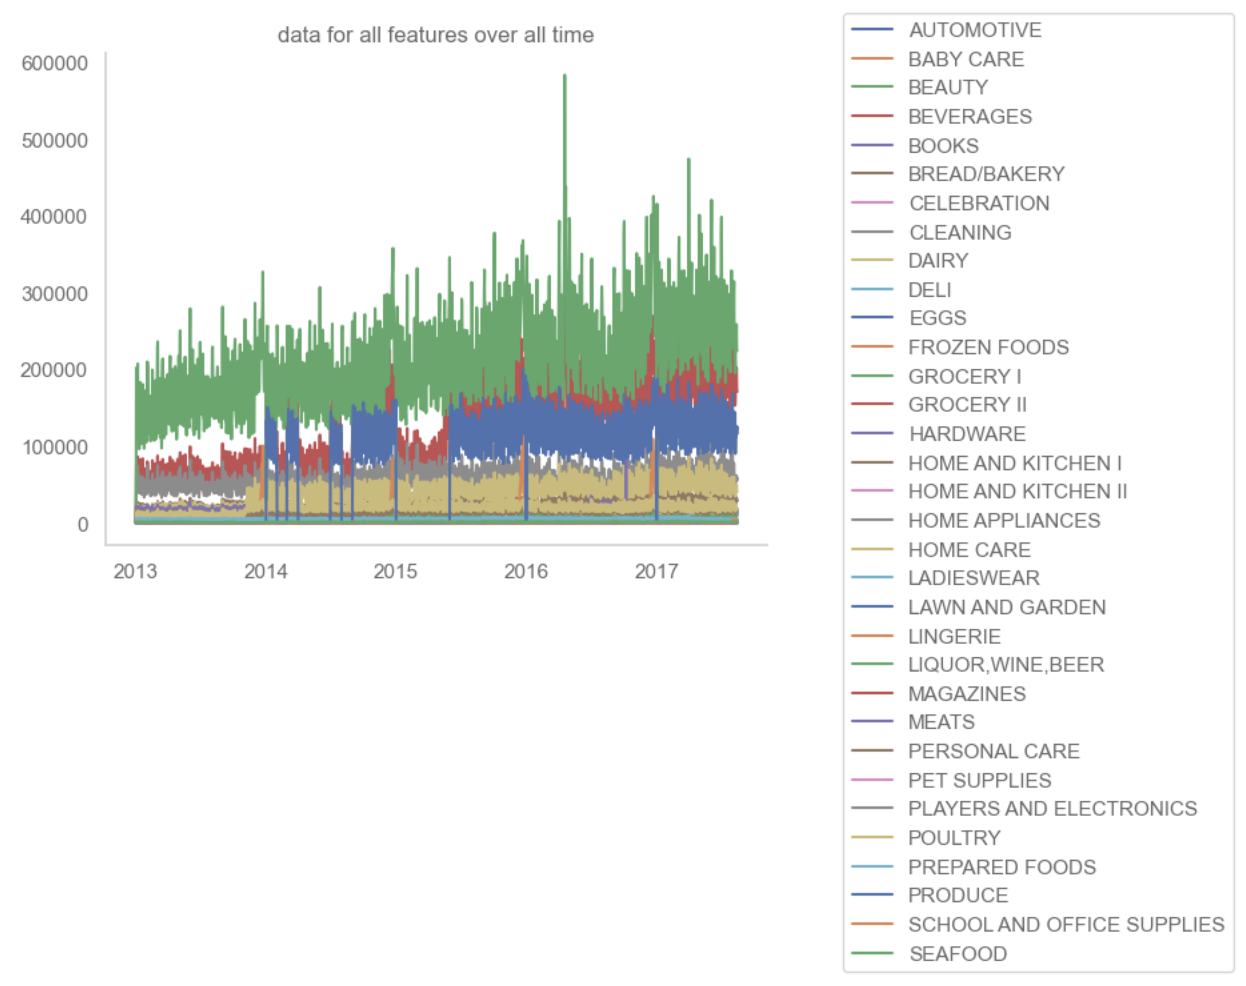

In [8]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.drop('LIQUOR,WINE,BEER',axis='columns',inplace=True)
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  MAGAZINES    MEATS  PERSONAL CARE  \
date                                                                       
2013-01-01             2.00      5.00       0.00   110.80          25.00   
2013-01-02           121.00    469.00       0.00 20871.46       17204.00   
2013-01-03            83.00    366.00       0.00 16597.40       12568.00   
2013-01-04           127.00    382.00       0.00 21625.96       11303.00   
2013-01-05           180.00    458.00       0.00 20879.09       16819.00   

family      PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  PREPARED FOODS  \
date                                                                         
2013-01-01          0.00                     0.00    42.64           37.85   
2013-01-02          0.00                     0.00 13975.88         5338.11   
2013-01-03          0.00                     0.00 10674.39         3591.39   
2013-01-04          0.00                     0.00 10772.52         4472.97   
2013-01-05          0.00                     0.00 13475.01         5830.07   

family      PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                      
2013-01-01     0.00                        0.00     0.00  
2013-01-02     0.00                        0.00  1526.75  
2013-01-03     0.00                        0.00  1094.31  
2013-01-04     0.00                        0.00  1293.12  
2013-01-05     0.00                        0.00  1245.64

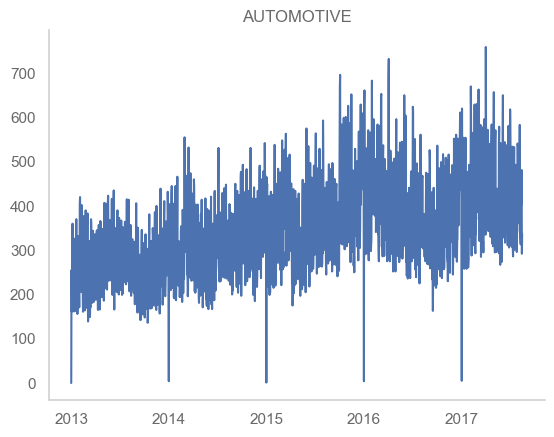

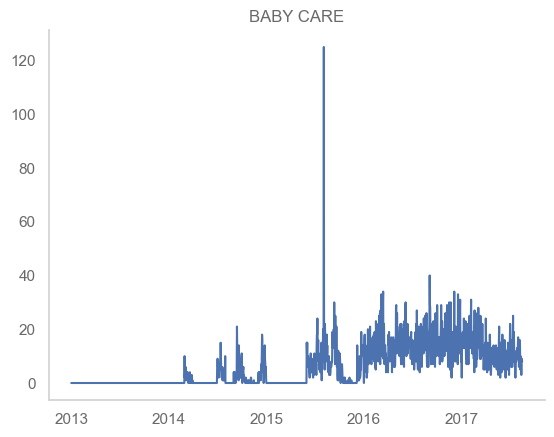

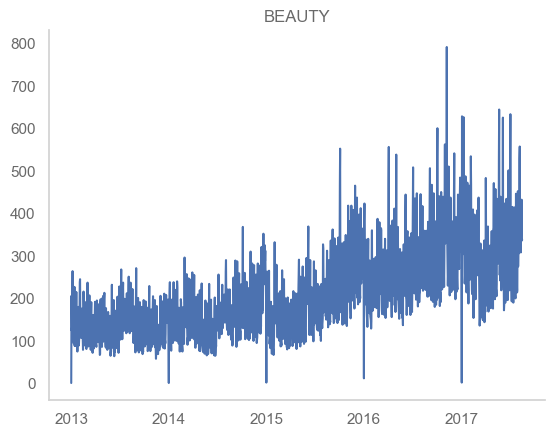

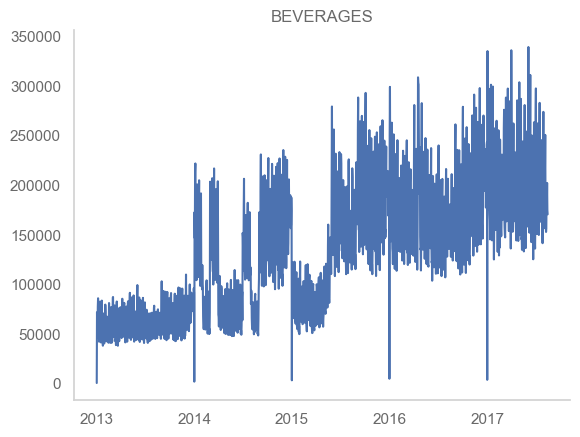

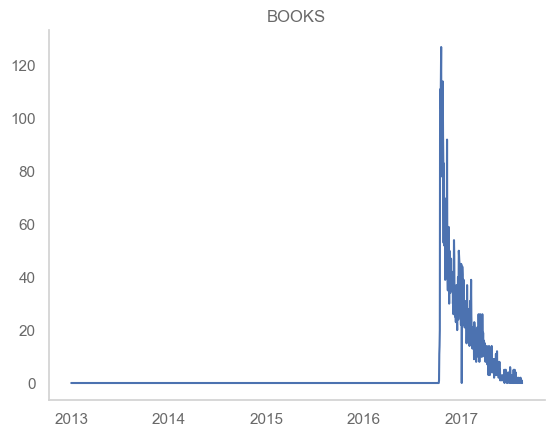

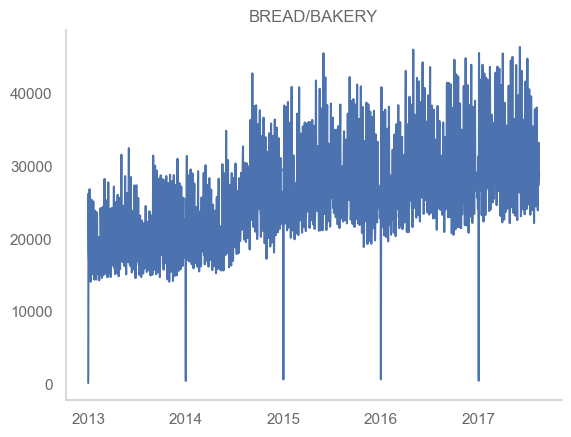

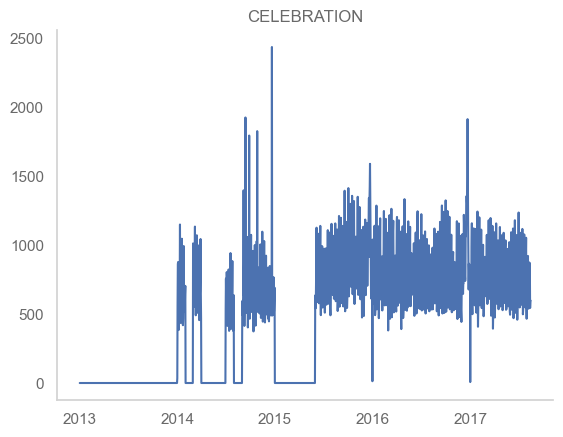

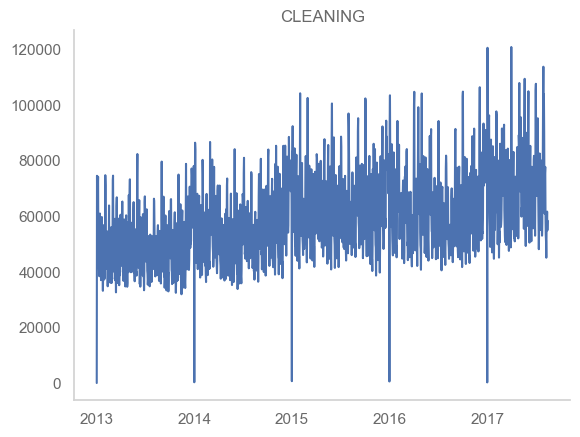

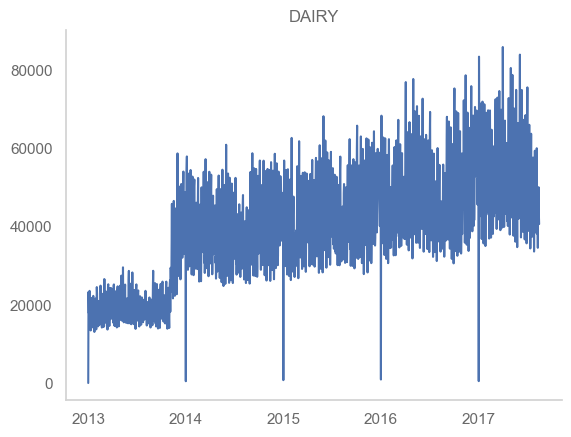

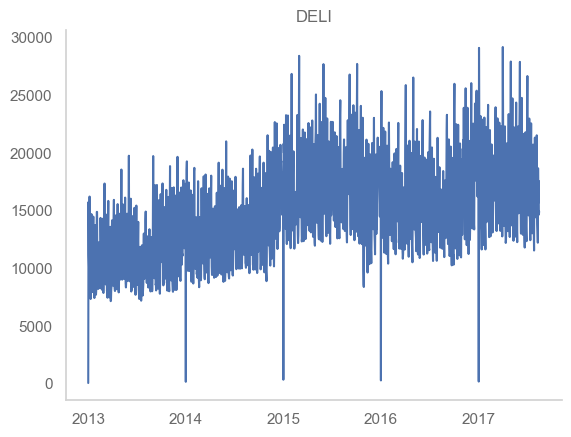

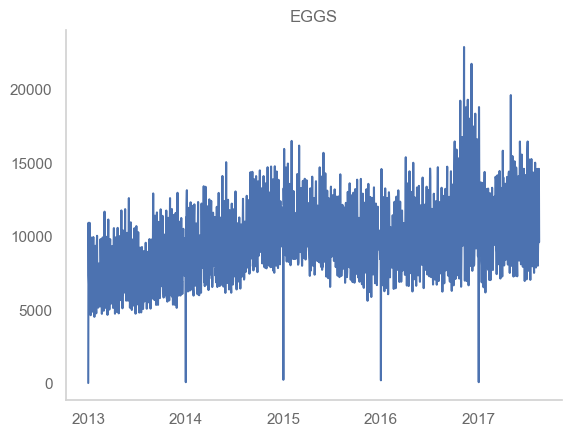

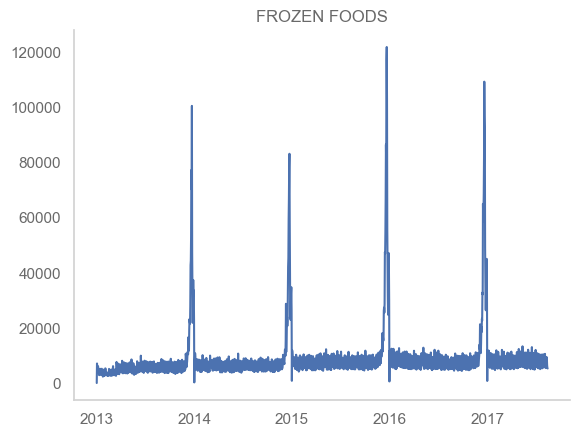

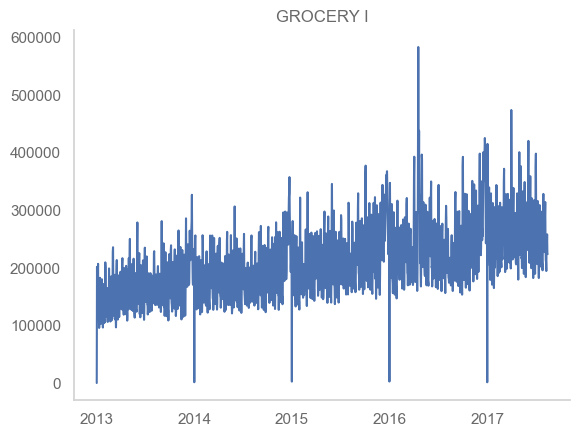

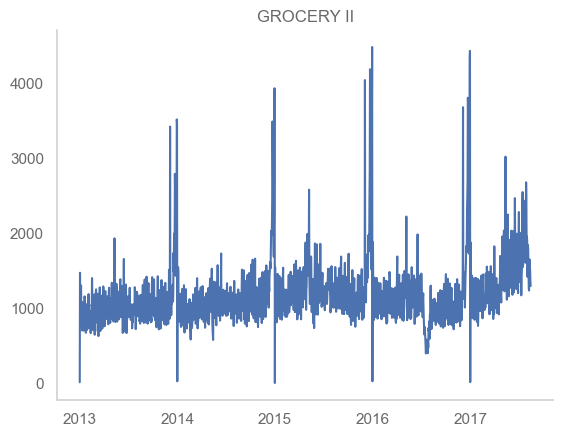

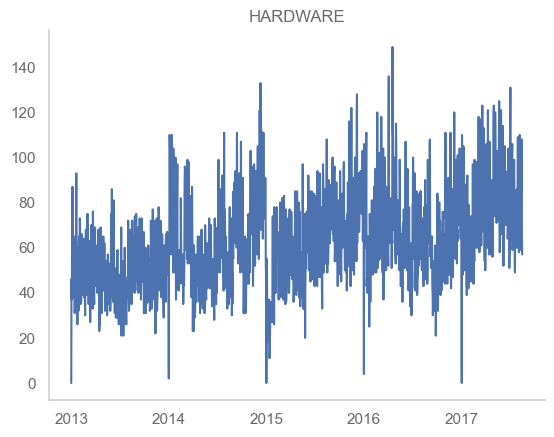

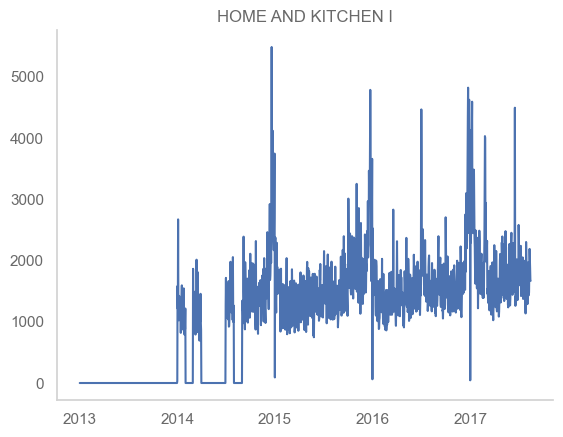

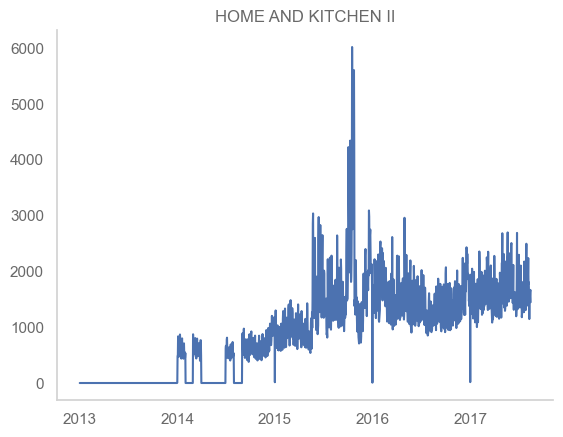

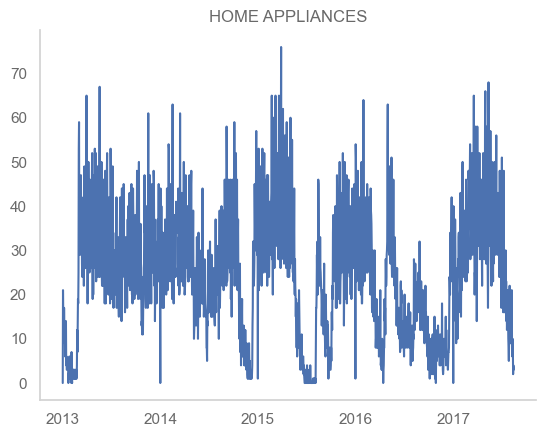

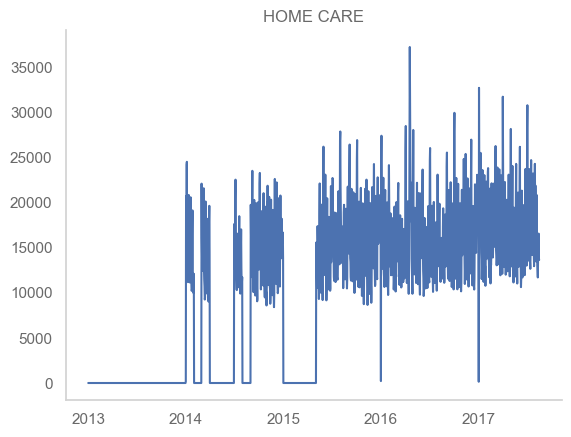

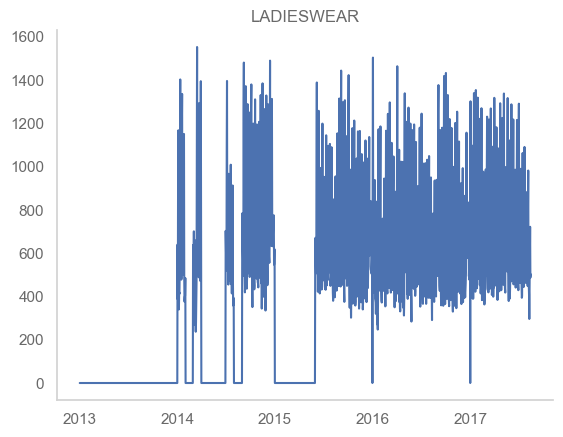

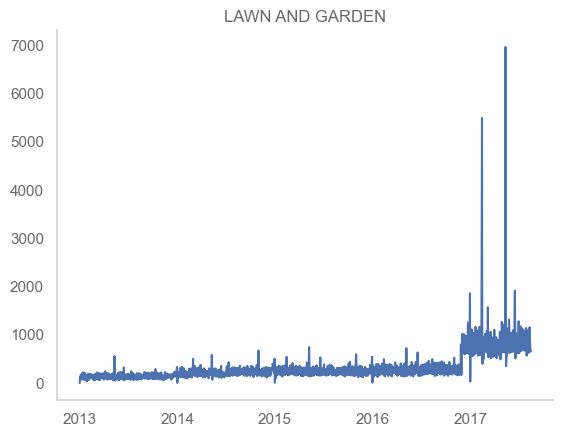

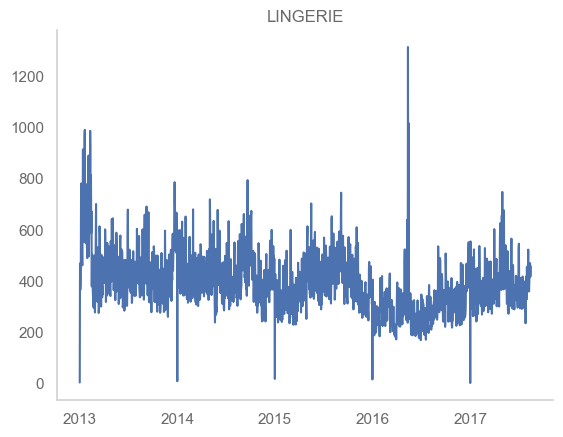

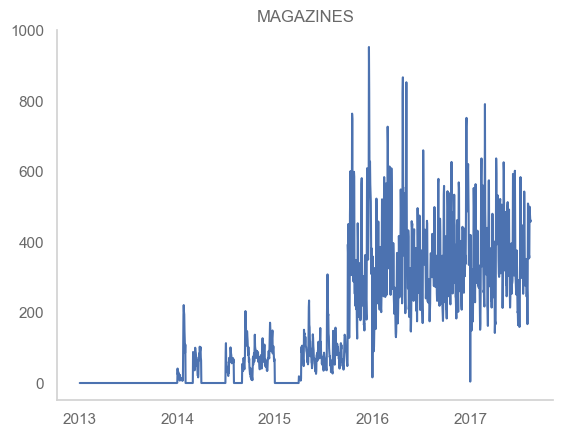

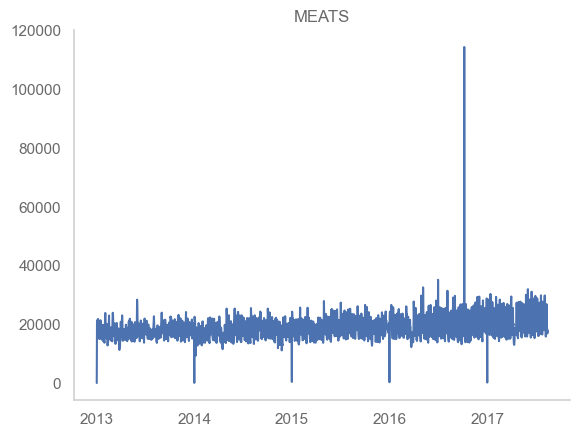

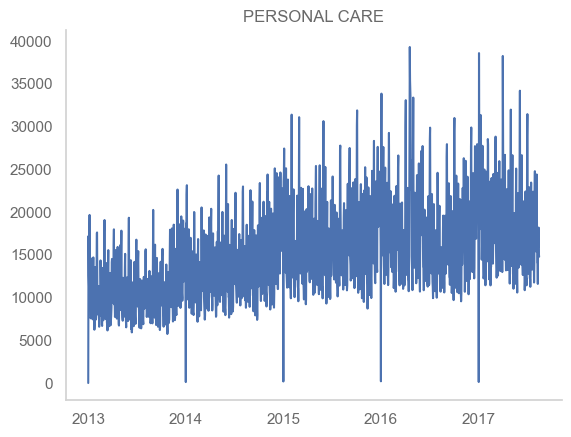

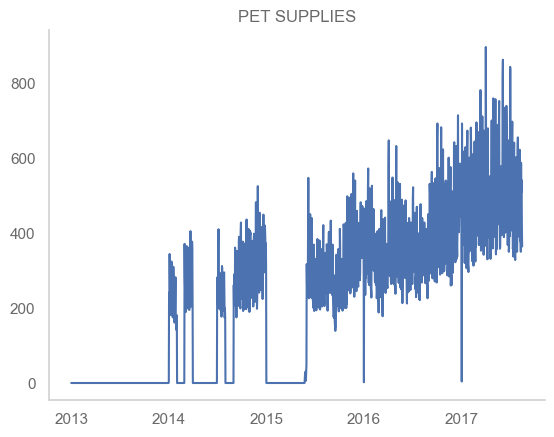

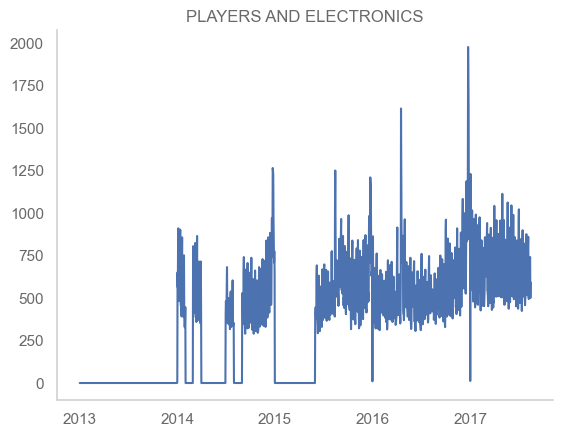

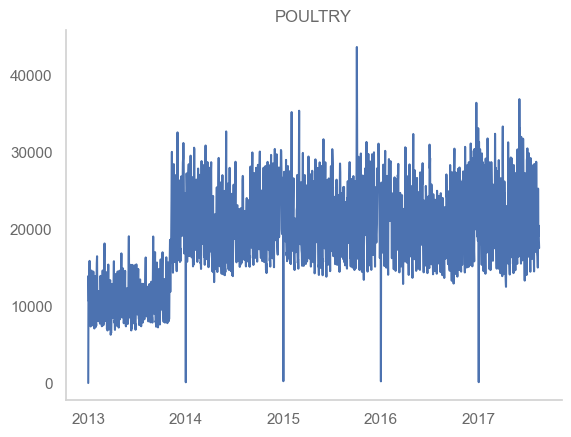

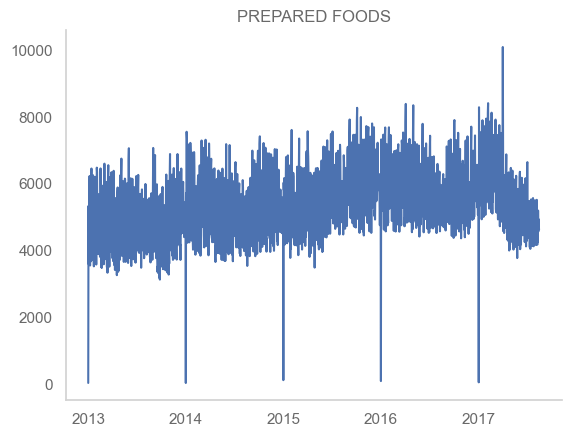

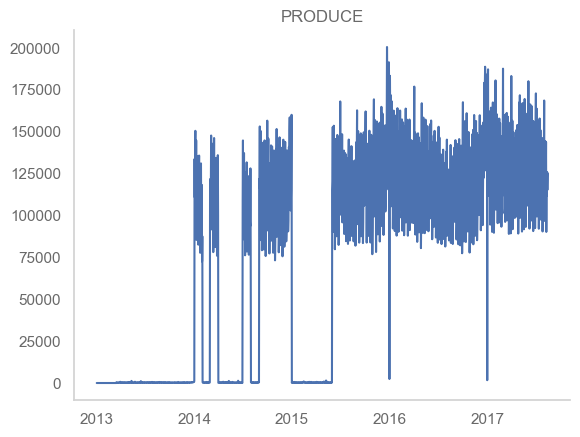

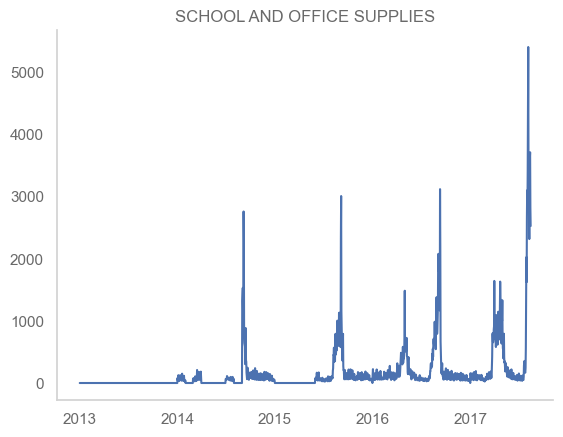

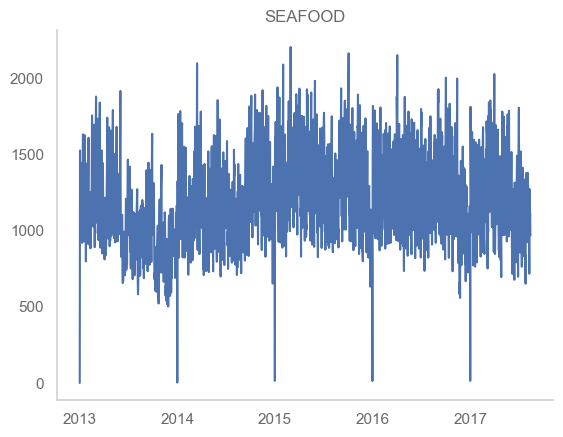

In [9]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [10]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [11]:
missing_data(total_sales_df).head()

Total  Percent    Types
family                             
AUTOMOTIVE      0     0.00  float64
BABY CARE       0     0.00  float64
BEAUTY          0     0.00  float64
BEVERAGES       0     0.00  float64
BOOKS           0     0.00  float64

### DATA CLEANING REQUIREMENTS
1. Remove low-volume data that can't be predicted.
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
3. Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

In [12]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 14 columns due to insufficient data volume.


In [13]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

After checking for 0s and not seeing any issues, we can keep all the categories that we have left in the dataframe.

In [14]:
print(total_sales_df.columns)

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')


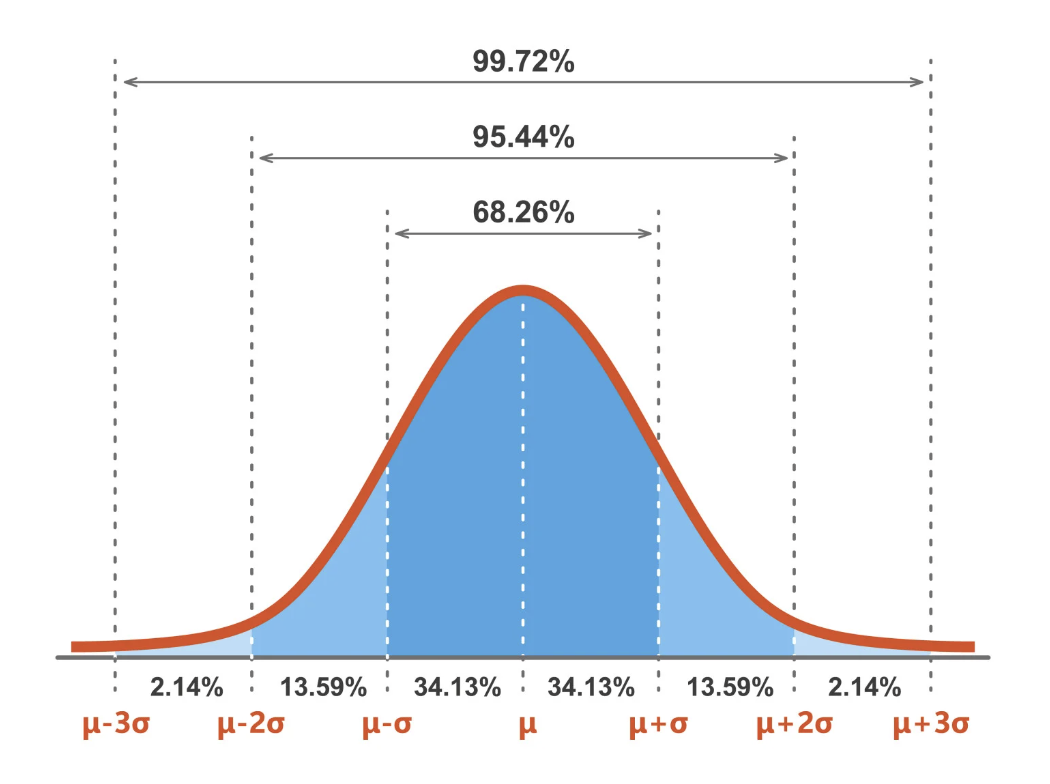

In [15]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD


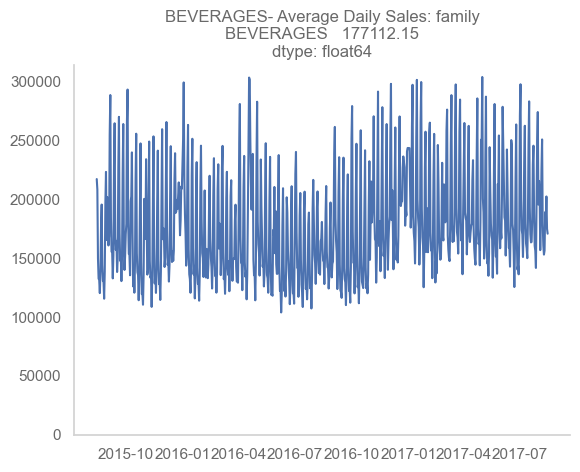

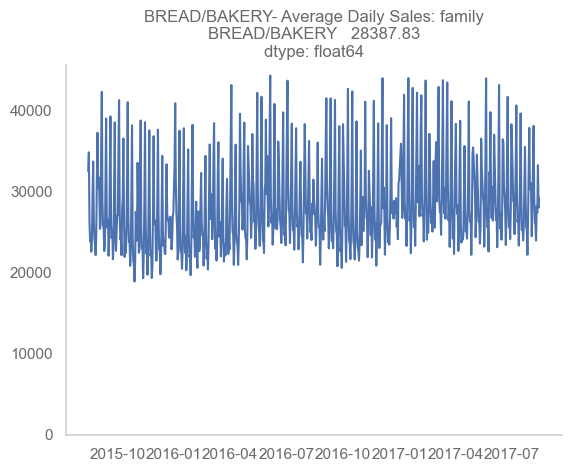

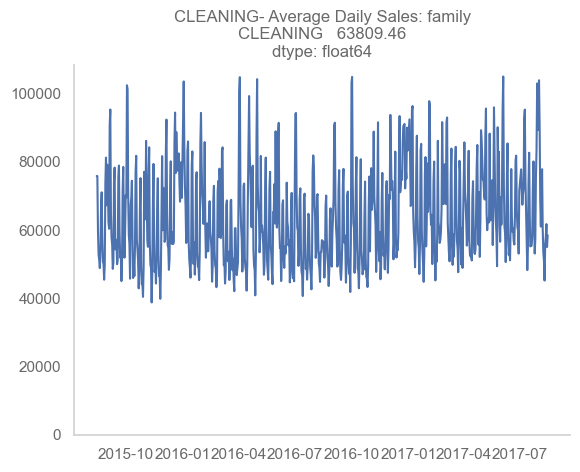

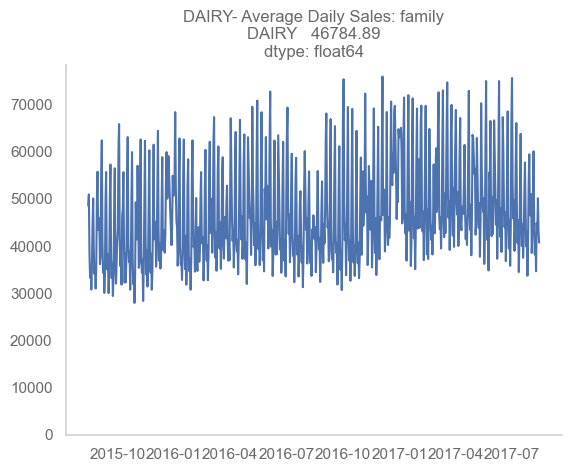

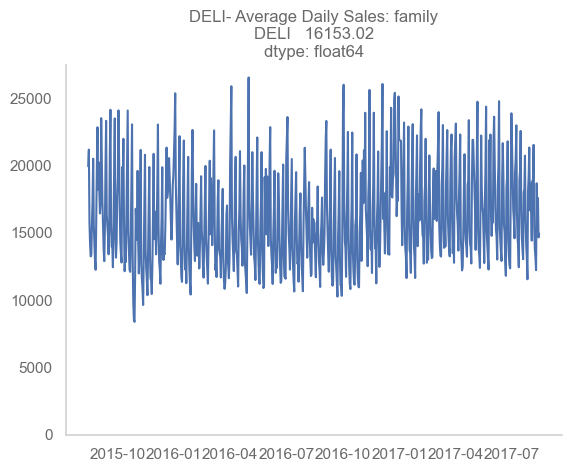

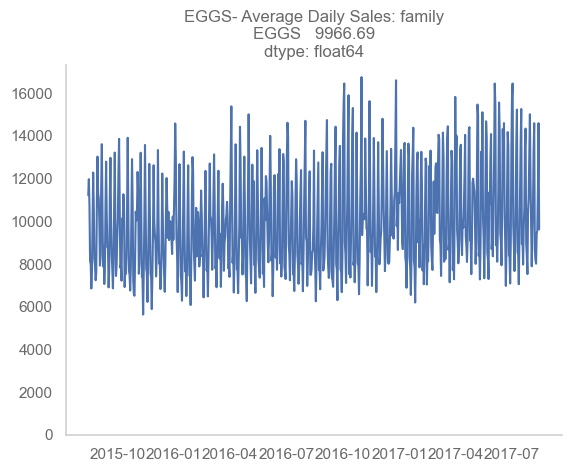

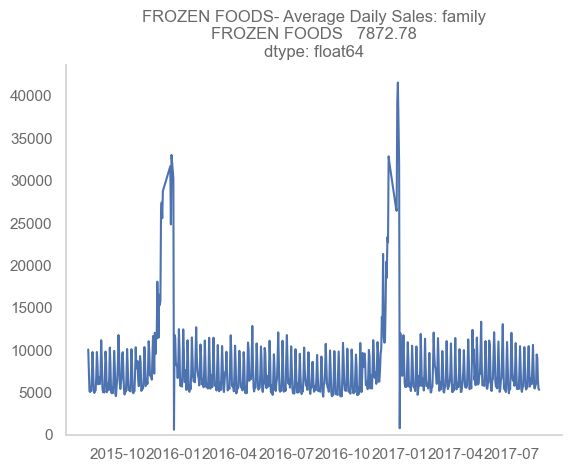

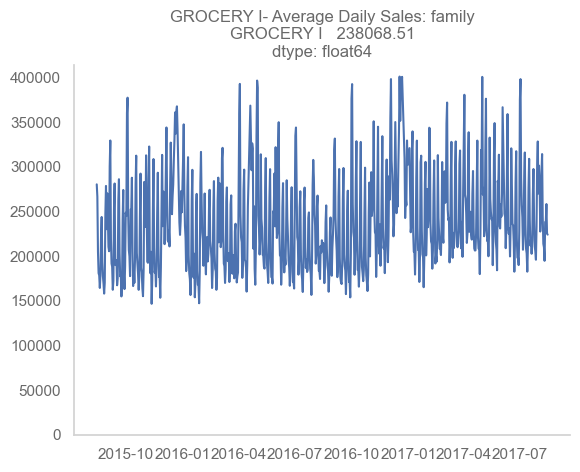

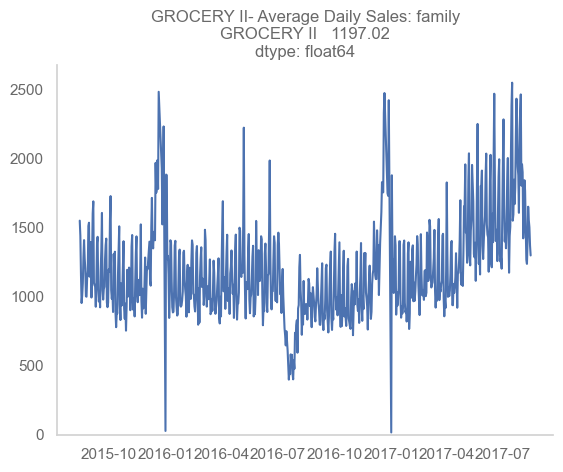

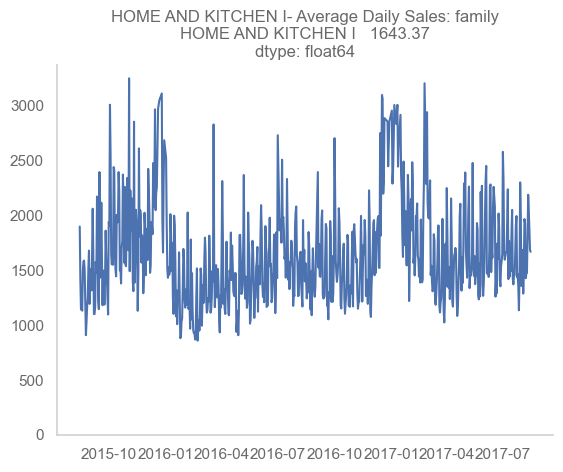

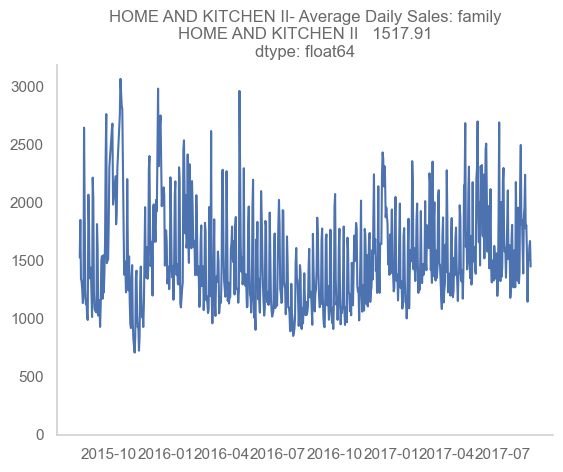

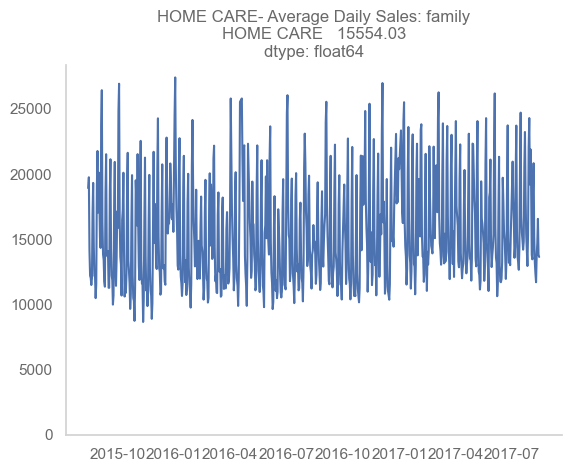

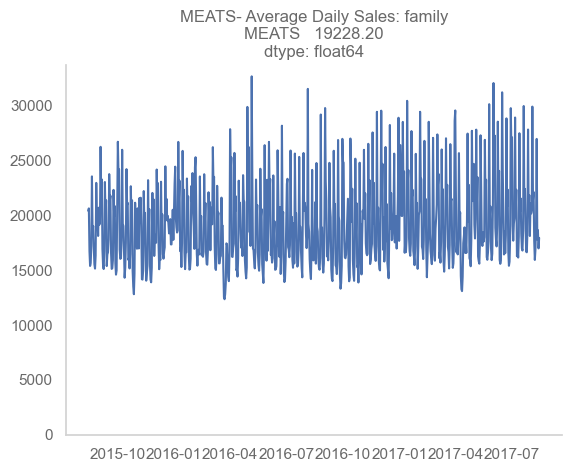

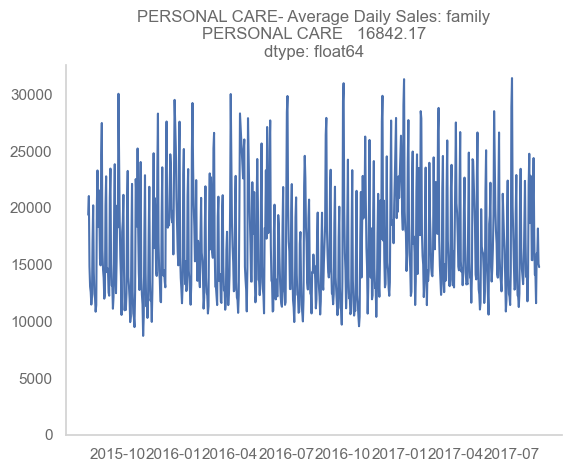

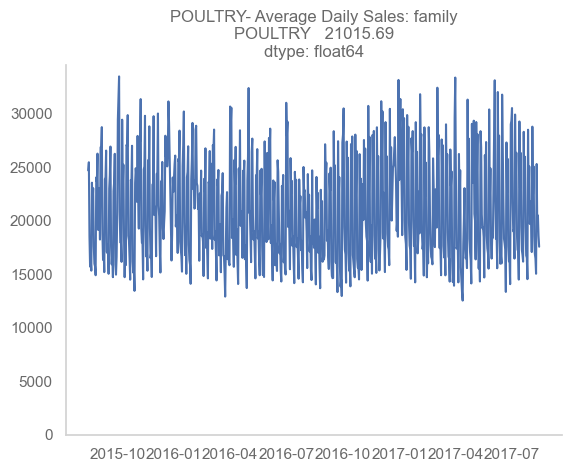

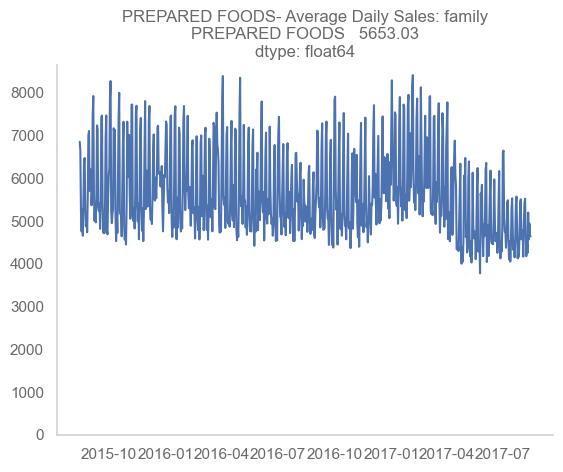

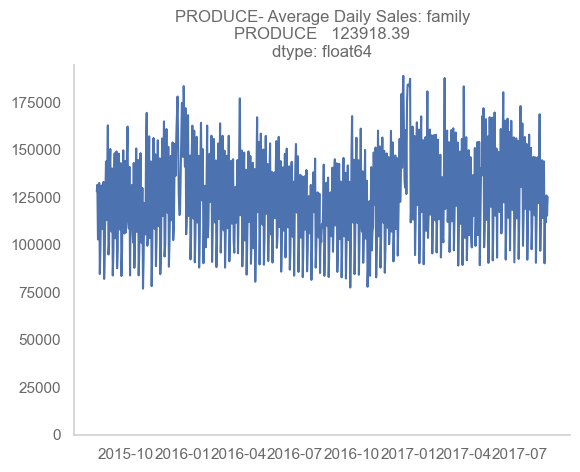

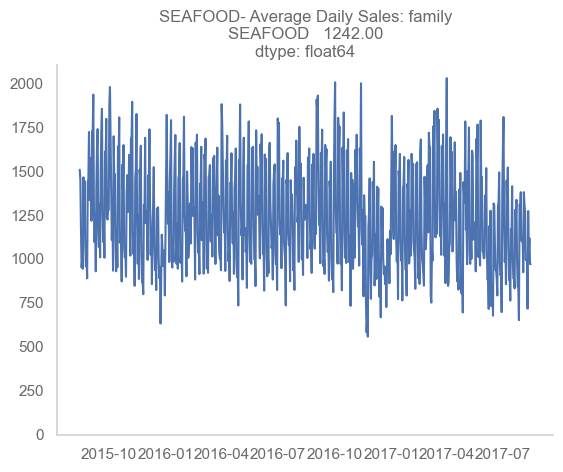

In [16]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

For further hypertuning, things to adjust would be on the category level. I'm not going to do further hypertuning in this notebook but here are the following things you can test and adjust to determine whether it's a category that can be predicted given the data.

1. Impute or drop situations for the <b>Liquor, Beer, Wine category</b> since there are many 0s in the first years worth of data. See if it improves the MAPE after cross-validation.
2. Impute or drop situations for the <b>Grocery II and Frozen Food categories </b> since there are 0s near the January 1st beginning of the year timeline that didn't get dropped during the z-score outlier automation. See if it improves the MAPE after cross-validation.
3. <b>Adjust the z-score outlier parameter</b> by checking out the Gaussian Distribution for different z-scores, check cut-offs and counts of rows being dropped, and see if there's an ideal situation for getting the best MAPE. (Idea is to loop through possible z-score possibilies, perhaps between 5 linear possibilities between 2.5 --> 3 and run the models with the best hypertuned parameters based on cross-validation below to see if MAPE's change with a change in z-score outlier drops.

### PLOTTING CATEGORIES

In [17]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [18]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

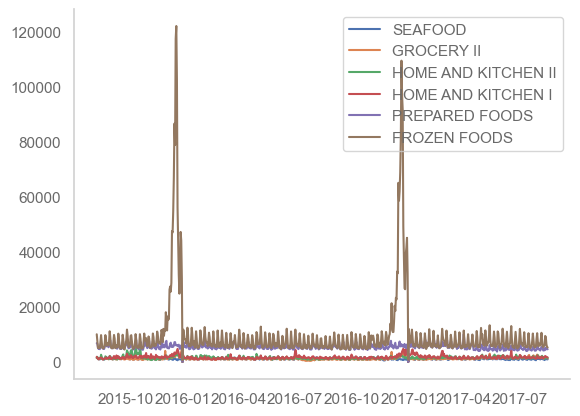

In [19]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

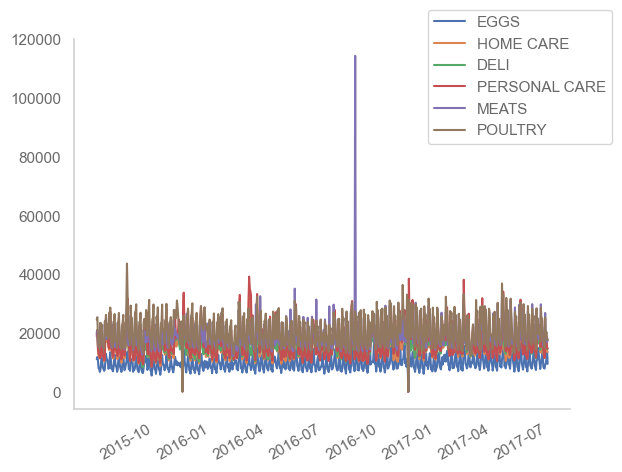

In [20]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

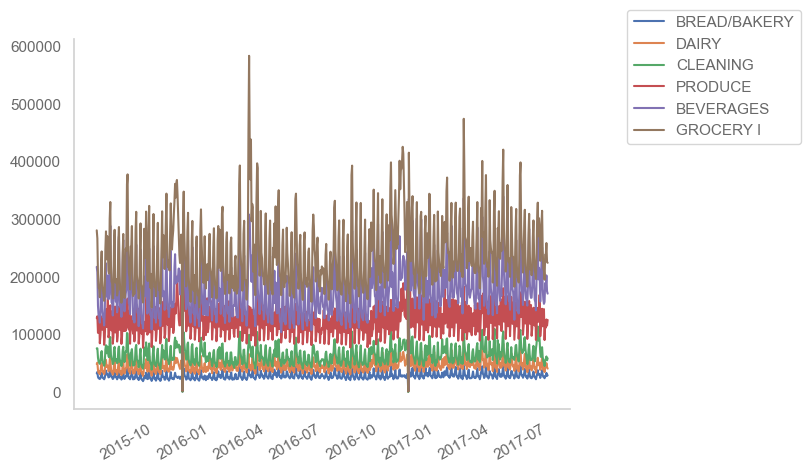

In [21]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [22]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [23]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [24]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

08:42:28 - cmdstanpy - INFO - Chain [1] start processing
08:42:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:28 - cmdstanpy - INFO - Chain [1] start processing
08:42:28 - cmdstanpy - INFO - Chain [1] done processing
08:42:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:28 - cmdstanpy - INFO - Chain [1] start processing
08:42:29 - cmdstanpy - INFO - Chain [1] done processing
08:42:29 - cmdstanpy - INFO - Chain [1] start processing
08:42:29 - cmdstanpy - INFO - Chain [1] done processing
08:42:29 - cmdstanpy - INFO - Chain [1] start processing
08:42:29 - cmdstanpy - INFO - Chain [1] done processing
08:42:29 - cmdstanpy - INFO - Chain [1] start processing
08:42:29 - cmdstanpy - INFO - Chain [1] done processing
08:42:29 - cmdstanpy - INFO - Chain [1] start processing
08:42:29 - cmdstanpy - INFO - Chain [1] done processing
08:42:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:29 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2028209799.08 45035.65 34020.77  0.33   0.16   0.20      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:32 - cmdstanpy - INFO - Chain [1] start processing
08:42:32 - cmdstanpy - INFO - Chain [1] done processing
08:42:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:32 - cmdstanpy - INFO - Chain [1] start processing
08:42:32 - cmdstanpy - INFO - Chain [1] done processing
08:42:33 - cmdstanpy - INFO - Chain [1] start processing
08:42:33 - cmdstanpy - INFO - Chain [1] done processing
08:42:33 - cmdstanpy - INFO - Chain [1] start processing
08:42:33 - cmdstanpy - INFO - Chain [1] done processing
08:42:33 - cmdstanpy - INFO - Chain [1] start processing
08:42:33 - cmdstanpy - INFO - Chain [1] done processing
08:42:33 - cmdstanpy - INFO - Chain [1] start processing
08:42:33 - cmdstanpy - INFO - Chain [1] done processing
08:42:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:33 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2165302599.09 46532.81 36449.14  0.37   0.17   0.22      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:36 - cmdstanpy - INFO - Chain [1] start processing
08:42:36 - cmdstanpy - INFO - Chain [1] done processing
08:42:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:36 - cmdstanpy - INFO - Chain [1] start processing
08:42:36 - cmdstanpy - INFO - Chain [1] done processing
08:42:36 - cmdstanpy - INFO - Chain [1] start processing
08:42:36 - cmdstanpy - INFO - Chain [1] done processing
08:42:37 - cmdstanpy - INFO - Chain [1] start processing
08:42:37 - cmdstanpy - INFO - Chain [1] done processing
08:42:37 - cmdstanpy - INFO - Chain [1] start processing
08:42:37 - cmdstanpy - INFO - Chain [1] done processing
08:42:37 - cmdstanpy - INFO - Chain [1] start processing
08:42:37 - cmdstanpy - INFO - Chain [1] done processing
08:42:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:37 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2168511862.02 46567.28 36416.93  0.37   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:40 - cmdstanpy - INFO - Chain [1] start processing
08:42:40 - cmdstanpy - INFO - Chain [1] done processing
08:42:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:40 - cmdstanpy - INFO - Chain [1] start processing
08:42:41 - cmdstanpy - INFO - Chain [1] done processing
08:42:41 - cmdstanpy - INFO - Chain [1] start processing
08:42:41 - cmdstanpy - INFO - Chain [1] done processing
08:42:41 - cmdstanpy - INFO - Chain [1] start processing
08:42:41 - cmdstanpy - INFO - Chain [1] done processing
08:42:41 - cmdstanpy - INFO - Chain [1] start processing
08:42:41 - cmdstanpy - INFO - Chain [1] done processing
08:42:41 - cmdstanpy - INFO - Chain [1] start processing
08:42:41 - cmdstanpy - INFO - Chain [1] done processing
08:42:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:41 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2156294745.05 46435.92 36246.97  0.36   0.17   0.22      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:44 - cmdstanpy - INFO - Chain [1] start processing
08:42:44 - cmdstanpy - INFO - Chain [1] done processing
08:42:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:44 - cmdstanpy - INFO - Chain [1] start processing
08:42:45 - cmdstanpy - INFO - Chain [1] done processing
08:42:45 - cmdstanpy - INFO - Chain [1] start processing
08:42:45 - cmdstanpy - INFO - Chain [1] done processing
08:42:45 - cmdstanpy - INFO - Chain [1] start processing
08:42:45 - cmdstanpy - INFO - Chain [1] done processing
08:42:45 - cmdstanpy - INFO - Chain [1] start processing
08:42:45 - cmdstanpy - INFO - Chain [1] done processing
08:42:45 - cmdstanpy - INFO - Chain [1] start processing
08:42:45 - cmdstanpy - INFO - Chain [1] done processing
08:42:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:42:45 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2160660388.20 46482.90 36402.67  0.37   0.17   0.22      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:48 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1] done processing
08:42:49 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1] done processing
08:42:49 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1] done processing
08:42:49 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1] done processing
08:42:49 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1] done processing
08:42:49 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1] done processing
08:42:49 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1] done processing
08:42:49 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1] done processing
08:42:49 - cmdstanpy - INFO - Chain [1] start processing
08:42:49 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1026634525.53 32041.14 22229.23  0.29   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:50 - cmdstanpy - INFO - Chain [1] start processing
08:42:50 - cmdstanpy - INFO - Chain [1] done processing
08:42:50 - cmdstanpy - INFO - Chain [1] start processing
08:42:50 - cmdstanpy - INFO - Chain [1] done processing
08:42:50 - cmdstanpy - INFO - Chain [1] start processing
08:42:50 - cmdstanpy - INFO - Chain [1] done processing
08:42:50 - cmdstanpy - INFO - Chain [1] start processing
08:42:50 - cmdstanpy - INFO - Chain [1] done processing
08:42:50 - cmdstanpy - INFO - Chain [1] start processing
08:42:50 - cmdstanpy - INFO - Chain [1] done processing
08:42:50 - cmdstanpy - INFO - Chain [1] start processing
08:42:50 - cmdstanpy - INFO - Chain [1] done processing
08:42:50 - cmdstanpy - INFO - Chain [1] start processing
08:42:50 - cmdstanpy - INFO - Chain [1] done processing
08:42:50 - cmdstanpy - INFO - Chain [1] start processing
08:42:51 - cmdstanpy - INFO - Chain [1] done processing
08:42:51 - cmdstanpy - INFO - Chain [1] start processing
08:42:51 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1010590127.30 31789.78 21554.45  0.30   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:51 - cmdstanpy - INFO - Chain [1] start processing
08:42:51 - cmdstanpy - INFO - Chain [1] done processing
08:42:51 - cmdstanpy - INFO - Chain [1] start processing
08:42:51 - cmdstanpy - INFO - Chain [1] done processing
08:42:51 - cmdstanpy - INFO - Chain [1] start processing
08:42:51 - cmdstanpy - INFO - Chain [1] done processing
08:42:51 - cmdstanpy - INFO - Chain [1] start processing
08:42:51 - cmdstanpy - INFO - Chain [1] done processing
08:42:51 - cmdstanpy - INFO - Chain [1] start processing
08:42:52 - cmdstanpy - INFO - Chain [1] done processing
08:42:52 - cmdstanpy - INFO - Chain [1] start processing
08:42:52 - cmdstanpy - INFO - Chain [1] done processing
08:42:52 - cmdstanpy - INFO - Chain [1] start processing
08:42:52 - cmdstanpy - INFO - Chain [1] done processing
08:42:52 - cmdstanpy - INFO - Chain [1] start processing
08:42:52 - cmdstanpy - INFO - Chain [1] done processing
08:42:52 - cmdstanpy - INFO - Chain [1] start processing
08:42:52 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1006457975.82 31724.72 21475.57  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:52 - cmdstanpy - INFO - Chain [1] start processing
08:42:52 - cmdstanpy - INFO - Chain [1] done processing
08:42:53 - cmdstanpy - INFO - Chain [1] start processing
08:42:53 - cmdstanpy - INFO - Chain [1] done processing
08:42:53 - cmdstanpy - INFO - Chain [1] start processing
08:42:53 - cmdstanpy - INFO - Chain [1] done processing
08:42:53 - cmdstanpy - INFO - Chain [1] start processing
08:42:53 - cmdstanpy - INFO - Chain [1] done processing
08:42:53 - cmdstanpy - INFO - Chain [1] start processing
08:42:53 - cmdstanpy - INFO - Chain [1] done processing
08:42:53 - cmdstanpy - INFO - Chain [1] start processing
08:42:53 - cmdstanpy - INFO - Chain [1] done processing
08:42:53 - cmdstanpy - INFO - Chain [1] start processing
08:42:53 - cmdstanpy - INFO - Chain [1] done processing
08:42:53 - cmdstanpy - INFO - Chain [1] start processing
08:42:53 - cmdstanpy - INFO - Chain [1] done processing
08:42:53 - cmdstanpy - INFO - Chain [1] start processing
08:42:53 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1011766896.10 31808.28 21620.93  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:54 - cmdstanpy - INFO - Chain [1] start processing
08:42:54 - cmdstanpy - INFO - Chain [1] done processing
08:42:54 - cmdstanpy - INFO - Chain [1] start processing
08:42:54 - cmdstanpy - INFO - Chain [1] done processing
08:42:54 - cmdstanpy - INFO - Chain [1] start processing
08:42:54 - cmdstanpy - INFO - Chain [1] done processing
08:42:54 - cmdstanpy - INFO - Chain [1] start processing
08:42:54 - cmdstanpy - INFO - Chain [1] done processing
08:42:54 - cmdstanpy - INFO - Chain [1] start processing
08:42:54 - cmdstanpy - INFO - Chain [1] done processing
08:42:54 - cmdstanpy - INFO - Chain [1] start processing
08:42:54 - cmdstanpy - INFO - Chain [1] done processing
08:42:54 - cmdstanpy - INFO - Chain [1] start processing
08:42:54 - cmdstanpy - INFO - Chain [1] done processing
08:42:54 - cmdstanpy - INFO - Chain [1] start processing
08:42:55 - cmdstanpy - INFO - Chain [1] done processing
08:42:55 - cmdstanpy - INFO - Chain [1] start processing
08:42:55 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1012988434.95 31827.48 21578.52  0.30   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:55 - cmdstanpy - INFO - Chain [1] start processing
08:42:55 - cmdstanpy - INFO - Chain [1] done processing
08:42:55 - cmdstanpy - INFO - Chain [1] start processing
08:42:55 - cmdstanpy - INFO - Chain [1] done processing
08:42:55 - cmdstanpy - INFO - Chain [1] start processing
08:42:55 - cmdstanpy - INFO - Chain [1] done processing
08:42:55 - cmdstanpy - INFO - Chain [1] start processing
08:42:55 - cmdstanpy - INFO - Chain [1] done processing
08:42:56 - cmdstanpy - INFO - Chain [1] start processing
08:42:56 - cmdstanpy - INFO - Chain [1] done processing
08:42:56 - cmdstanpy - INFO - Chain [1] start processing
08:42:56 - cmdstanpy - INFO - Chain [1] done processing
08:42:56 - cmdstanpy - INFO - Chain [1] start processing
08:42:56 - cmdstanpy - INFO - Chain [1] done processing
08:42:56 - cmdstanpy - INFO - Chain [1] start processing
08:42:56 - cmdstanpy - INFO - Chain [1] done processing
08:42:56 - cmdstanpy - INFO - Chain [1] start processing
08:42:56 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1044160884.22 32313.48 22185.85  0.30   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1] done processing
08:42:57 - cmdstanpy - INFO - Chain [1] start processing
08:42:57 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1063118529.32 32605.50 22110.63  0.31   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:58 - cmdstanpy - INFO - Chain [1] done processing
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:58 - cmdstanpy - INFO - Chain [1] done processing
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:58 - cmdstanpy - INFO - Chain [1] done processing
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:58 - cmdstanpy - INFO - Chain [1] done processing
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:58 - cmdstanpy - INFO - Chain [1] done processing
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:59 - cmdstanpy - INFO - Chain [1] done processing
08:42:59 - cmdstanpy - INFO - Chain [1] start processing
08:42:59 - cmdstanpy - INFO - Chain [1] done processing
08:42:59 - cmdstanpy - INFO - Chain [1] start processing
08:42:59 - cmdstanpy - INFO - Chain [1] done processing
08:42:59 - cmdstanpy - INFO - Chain [1] start processing
08:42:59 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1079132064.65 32850.15 22359.07  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:42:59 - cmdstanpy - INFO - Chain [1] start processing
08:42:59 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1077545731.15 32825.99 22319.58  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:01 - cmdstanpy - INFO - Chain [1] start processing
08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:01 - cmdstanpy - INFO - Chain [1] start processing
08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:01 - cmdstanpy - INFO - Chain [1] start processing
08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:01 - cmdstanpy - INFO - Chain [1] start processing
08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:01 - cmdstanpy - INFO - Chain [1] start processing
08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:01 - cmdstanpy - INFO - Chain [1] start processing
08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:01 - cmdstanpy - INFO - Chain [1] start processing
08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:02 - cmdstanpy - INFO - Chain [1] start processing
08:43:02 - cmdstanpy - INFO - Chain [1] done processing
08:43:02 - cmdstanpy - INFO - Chain [1] start processing
08:43:02 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1067599718.14 32674.14 22183.68  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:02 - cmdstanpy - INFO - Chain [1] start processing
08:43:02 - cmdstanpy - INFO - Chain [1] done processing
08:43:02 - cmdstanpy - INFO - Chain [1] start processing
08:43:02 - cmdstanpy - INFO - Chain [1] done processing
08:43:02 - cmdstanpy - INFO - Chain [1] start processing
08:43:03 - cmdstanpy - INFO - Chain [1] done processing
08:43:03 - cmdstanpy - INFO - Chain [1] start processing
08:43:03 - cmdstanpy - INFO - Chain [1] done processing
08:43:03 - cmdstanpy - INFO - Chain [1] start processing
08:43:03 - cmdstanpy - INFO - Chain [1] done processing
08:43:03 - cmdstanpy - INFO - Chain [1] start processing
08:43:03 - cmdstanpy - INFO - Chain [1] done processing
08:43:03 - cmdstanpy - INFO - Chain [1] start processing
08:43:03 - cmdstanpy - INFO - Chain [1] done processing
08:43:03 - cmdstanpy - INFO - Chain [1] start processing
08:43:03 - cmdstanpy - INFO - Chain [1] done processing
08:43:03 - cmdstanpy - INFO - Chain [1] start processing
08:43:03 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1044933773.43 32325.44 22078.23  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:04 - cmdstanpy - INFO - Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
08:43:04 - cmdstanpy - INFO - Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
08:43:04 - cmdstanpy - INFO - Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
08:43:04 - cmdstanpy - INFO - Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
08:43:04 - cmdstanpy - INFO - Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
08:43:04 - cmdstanpy - INFO - Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
08:43:04 - cmdstanpy - INFO - Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
08:43:05 - cmdstanpy - INFO - Chain [1] start processing
08:43:05 - cmdstanpy - INFO - Chain [1] done processing
08:43:05 - cmdstanpy - INFO - Chain [1] start processing
08:43:05 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1111733319.29 33342.67 23024.15  0.31   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:05 - cmdstanpy - INFO - Chain [1] start processing
08:43:05 - cmdstanpy - INFO - Chain [1] done processing
08:43:05 - cmdstanpy - INFO - Chain [1] start processing
08:43:05 - cmdstanpy - INFO - Chain [1] done processing
08:43:05 - cmdstanpy - INFO - Chain [1] start processing
08:43:06 - cmdstanpy - INFO - Chain [1] done processing
08:43:06 - cmdstanpy - INFO - Chain [1] start processing
08:43:06 - cmdstanpy - INFO - Chain [1] done processing
08:43:06 - cmdstanpy - INFO - Chain [1] start processing
08:43:06 - cmdstanpy - INFO - Chain [1] done processing
08:43:06 - cmdstanpy - INFO - Chain [1] start processing
08:43:06 - cmdstanpy - INFO - Chain [1] done processing
08:43:06 - cmdstanpy - INFO - Chain [1] start processing
08:43:06 - cmdstanpy - INFO - Chain [1] done processing
08:43:06 - cmdstanpy - INFO - Chain [1] start processing
08:43:06 - cmdstanpy - INFO - Chain [1] done processing
08:43:06 - cmdstanpy - INFO - Chain [1] start processing
08:43:06 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1121132096.08 33483.31 23203.17  0.31   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing
08:43:08 - cmdstanpy - INFO - Chain [1] start processing
08:43:08 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1110799211.59 33328.65 23058.06  0.31   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:08 - cmdstanpy - INFO - Chain [1] start processing
08:43:08 - cmdstanpy - INFO - Chain [1] done processing
08:43:08 - cmdstanpy - INFO - Chain [1] start processing
08:43:08 - cmdstanpy - INFO - Chain [1] done processing
08:43:08 - cmdstanpy - INFO - Chain [1] start processing
08:43:08 - cmdstanpy - INFO - Chain [1] done processing
08:43:09 - cmdstanpy - INFO - Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1] done processing
08:43:09 - cmdstanpy - INFO - Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1] done processing
08:43:09 - cmdstanpy - INFO - Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1] done processing
08:43:09 - cmdstanpy - INFO - Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1] done processing
08:43:09 - cmdstanpy - INFO - Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1] done processing
08:43:09 - cmdstanpy - INFO - Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1117021668.05 33421.87 23170.05  0.31   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:10 - cmdstanpy - INFO - Chain [1] start processing
08:43:11 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1024394602.94 32006.17 21824.36  0.30   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:11 - cmdstanpy - INFO - Chain [1] start processing
08:43:11 - cmdstanpy - INFO - Chain [1] done processing
08:43:11 - cmdstanpy - INFO - Chain [1] start processing
08:43:11 - cmdstanpy - INFO - Chain [1] done processing
08:43:11 - cmdstanpy - INFO - Chain [1] start processing
08:43:11 - cmdstanpy - INFO - Chain [1] done processing
08:43:11 - cmdstanpy - INFO - Chain [1] start processing
08:43:12 - cmdstanpy - INFO - Chain [1] done processing
08:43:12 - cmdstanpy - INFO - Chain [1] start processing
08:43:12 - cmdstanpy - INFO - Chain [1] done processing
08:43:12 - cmdstanpy - INFO - Chain [1] start processing
08:43:12 - cmdstanpy - INFO - Chain [1] done processing
08:43:12 - cmdstanpy - INFO - Chain [1] start processing
08:43:12 - cmdstanpy - INFO - Chain [1] done processing
08:43:12 - cmdstanpy - INFO - Chain [1] start processing
08:43:12 - cmdstanpy - INFO - Chain [1] done processing
08:43:12 - cmdstanpy - INFO - Chain [1] start processing
08:43:12 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1164552037.93 34125.53 23962.70  0.32   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:13 - cmdstanpy - INFO - Chain [1] done processing
08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:13 - cmdstanpy - INFO - Chain [1] done processing
08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:13 - cmdstanpy - INFO - Chain [1] done processing
08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:13 - cmdstanpy - INFO - Chain [1] done processing
08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:13 - cmdstanpy - INFO - Chain [1] done processing
08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:13 - cmdstanpy - INFO - Chain [1] done processing
08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:13 - cmdstanpy - INFO - Chain [1] done processing
08:43:13 - cmdstanpy - INFO - Chain [1] start processing
08:43:13 - cmdstanpy - INFO - Chain [1] done processing
08:43:14 - cmdstanpy - INFO - Chain [1] start processing
08:43:14 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1155797842.89 33997.03 23877.77  0.32   0.11   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:14 - cmdstanpy - INFO - Chain [1] start processing
08:43:14 - cmdstanpy - INFO - Chain [1] done processing
08:43:14 - cmdstanpy - INFO - Chain [1] start processing
08:43:14 - cmdstanpy - INFO - Chain [1] done processing
08:43:14 - cmdstanpy - INFO - Chain [1] start processing
08:43:14 - cmdstanpy - INFO - Chain [1] done processing
08:43:15 - cmdstanpy - INFO - Chain [1] start processing
08:43:15 - cmdstanpy - INFO - Chain [1] done processing
08:43:15 - cmdstanpy - INFO - Chain [1] start processing
08:43:15 - cmdstanpy - INFO - Chain [1] done processing
08:43:15 - cmdstanpy - INFO - Chain [1] start processing
08:43:15 - cmdstanpy - INFO - Chain [1] done processing
08:43:15 - cmdstanpy - INFO - Chain [1] start processing
08:43:15 - cmdstanpy - INFO - Chain [1] done processing
08:43:15 - cmdstanpy - INFO - Chain [1] start processing
08:43:15 - cmdstanpy - INFO - Chain [1] done processing
08:43:15 - cmdstanpy - INFO - Chain [1] start processing
08:43:15 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1158164956.02 34031.82 23842.01  0.32   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:16 - cmdstanpy - INFO - Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing
08:43:16 - cmdstanpy - INFO - Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing
08:43:16 - cmdstanpy - INFO - Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing
08:43:16 - cmdstanpy - INFO - Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing
08:43:16 - cmdstanpy - INFO - Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing
08:43:16 - cmdstanpy - INFO - Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing
08:43:16 - cmdstanpy - INFO - Chain [1] start processing
08:43:17 - cmdstanpy - INFO - Chain [1] done processing
08:43:17 - cmdstanpy - INFO - Chain [1] start processing
08:43:17 - cmdstanpy - INFO - Chain [1] done processing
08:43:17 - cmdstanpy - INFO - Chain [1] start processing
08:43:17 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1163580432.70 34111.29 23881.33  0.32   0.11   0.13      0.75
BEVERAGES
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.33
1                     0.00                     2.51  0.37
2                     0.00                     5.00  0.37
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.37


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:17 - cmdstanpy - INFO - Chain [1] start processing
08:43:17 - cmdstanpy - INFO - Chain [1] done processing
08:43:17 - cmdstanpy - INFO - Chain [1] start processing
08:43:17 - cmdstanpy - INFO - Chain [1] done processing
08:43:18 - cmdstanpy - INFO - Chain [1] start processing
08:43:18 - cmdstanpy - INFO - Chain [1] done processing
08:43:18 - cmdstanpy - INFO - Chain [1] start processing
08:43:18 - cmdstanpy - INFO - Chain [1] done processing
08:43:18 - cmdstanpy - INFO - Chain [1] start processing
08:43:18 - cmdstanpy - INFO - Chain [1] done processing
08:43:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:43:18 - cmdstanpy - INFO - Chain [1] start processing
08:43:18 - cmdstanpy - INFO - Chain [1] done processing
08:43:18 - cmdstanpy - INFO - Chain [1] start processing
08:43:18 - cmdstanpy - INFO - Chain [1] done processing
08:43:18 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18054165.88 4249.02 2854.56  0.29   0.07   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:21 - cmdstanpy - INFO - Chain [1] start processing
08:43:21 - cmdstanpy - INFO - Chain [1] done processing
08:43:21 - cmdstanpy - INFO - Chain [1] start processing
08:43:21 - cmdstanpy - INFO - Chain [1] done processing
08:43:21 - cmdstanpy - INFO - Chain [1] start processing
08:43:21 - cmdstanpy - INFO - Chain [1] done processing
08:43:21 - cmdstanpy - INFO - Chain [1] start processing
08:43:21 - cmdstanpy - INFO - Chain [1] done processing
08:43:21 - cmdstanpy - INFO - Chain [1] start processing
08:43:21 - cmdstanpy - INFO - Chain [1] done processing
08:43:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:43:21 - cmdstanpy - INFO - Chain [1] start processing
08:43:22 - cmdstanpy - INFO - Chain [1] done processing
08:43:22 - cmdstanpy - INFO - Chain [1] start processing
08:43:22 - cmdstanpy - INFO - Chain [1] done processing
08:43:23 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20599117.92 4538.63 3212.78  0.31   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:25 - cmdstanpy - INFO - Chain [1] start processing
08:43:25 - cmdstanpy - INFO - Chain [1] done processing
08:43:25 - cmdstanpy - INFO - Chain [1] start processing
08:43:25 - cmdstanpy - INFO - Chain [1] done processing
08:43:25 - cmdstanpy - INFO - Chain [1] start processing
08:43:25 - cmdstanpy - INFO - Chain [1] done processing
08:43:25 - cmdstanpy - INFO - Chain [1] start processing
08:43:25 - cmdstanpy - INFO - Chain [1] done processing
08:43:25 - cmdstanpy - INFO - Chain [1] start processing
08:43:25 - cmdstanpy - INFO - Chain [1] done processing
08:43:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:43:25 - cmdstanpy - INFO - Chain [1] start processing
08:43:26 - cmdstanpy - INFO - Chain [1] done processing
08:43:26 - cmdstanpy - INFO - Chain [1] start processing
08:43:26 - cmdstanpy - INFO - Chain [1] done processing
08:43:26 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19907644.30 4461.80 3141.26  0.31   0.09   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:28 - cmdstanpy - INFO - Chain [1] start processing
08:43:28 - cmdstanpy - INFO - Chain [1] done processing
08:43:28 - cmdstanpy - INFO - Chain [1] start processing
08:43:28 - cmdstanpy - INFO - Chain [1] done processing
08:43:28 - cmdstanpy - INFO - Chain [1] start processing
08:43:29 - cmdstanpy - INFO - Chain [1] done processing
08:43:29 - cmdstanpy - INFO - Chain [1] start processing
08:43:29 - cmdstanpy - INFO - Chain [1] done processing
08:43:29 - cmdstanpy - INFO - Chain [1] start processing
08:43:29 - cmdstanpy - INFO - Chain [1] done processing
08:43:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:43:29 - cmdstanpy - INFO - Chain [1] start processing
08:43:29 - cmdstanpy - INFO - Chain [1] done processing
08:43:29 - cmdstanpy - INFO - Chain [1] start processing
08:43:29 - cmdstanpy - INFO - Chain [1] done processing
08:43:29 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18193988.74 4265.44 2961.87  0.30   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:31 - cmdstanpy - INFO - Chain [1] start processing
08:43:31 - cmdstanpy - INFO - Chain [1] done processing
08:43:32 - cmdstanpy - INFO - Chain [1] start processing
08:43:32 - cmdstanpy - INFO - Chain [1] done processing
08:43:32 - cmdstanpy - INFO - Chain [1] start processing
08:43:32 - cmdstanpy - INFO - Chain [1] done processing
08:43:32 - cmdstanpy - INFO - Chain [1] start processing
08:43:32 - cmdstanpy - INFO - Chain [1] done processing
08:43:32 - cmdstanpy - INFO - Chain [1] start processing
08:43:32 - cmdstanpy - INFO - Chain [1] done processing
08:43:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:43:32 - cmdstanpy - INFO - Chain [1] start processing
08:43:32 - cmdstanpy - INFO - Chain [1] done processing
08:43:33 - cmdstanpy - INFO - Chain [1] start processing
08:43:33 - cmdstanpy - INFO - Chain [1] done processing
08:43:33 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20175275.30 4491.69 3166.23  0.31   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:35 - cmdstanpy - INFO - Chain [1] done processing
08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:35 - cmdstanpy - INFO - Chain [1] done processing
08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:35 - cmdstanpy - INFO - Chain [1] done processing
08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:35 - cmdstanpy - INFO - Chain [1] done processing
08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:35 - cmdstanpy - INFO - Chain [1] done processing
08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:35 - cmdstanpy - INFO - Chain [1] done processing
08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:35 - cmdstanpy - INFO - Chain [1] done processing
08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:35 - cmdstanpy - INFO - Chain [1] done processing
08:43:36 - cmdstanpy - INFO - Chain [1] start processing
08:43:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14428867.45 3798.53 2578.39  0.29   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:36 - cmdstanpy - INFO - Chain [1] start processing
08:43:36 - cmdstanpy - INFO - Chain [1] done processing
08:43:36 - cmdstanpy - INFO - Chain [1] start processing
08:43:36 - cmdstanpy - INFO - Chain [1] done processing
08:43:36 - cmdstanpy - INFO - Chain [1] start processing
08:43:36 - cmdstanpy - INFO - Chain [1] done processing
08:43:36 - cmdstanpy - INFO - Chain [1] start processing
08:43:36 - cmdstanpy - INFO - Chain [1] done processing
08:43:36 - cmdstanpy - INFO - Chain [1] start processing
08:43:36 - cmdstanpy - INFO - Chain [1] done processing
08:43:37 - cmdstanpy - INFO - Chain [1] start processing
08:43:37 - cmdstanpy - INFO - Chain [1] done processing
08:43:37 - cmdstanpy - INFO - Chain [1] start processing
08:43:37 - cmdstanpy - INFO - Chain [1] done processing
08:43:37 - cmdstanpy - INFO - Chain [1] start processing
08:43:37 - cmdstanpy - INFO - Chain [1] done processing
08:43:37 - cmdstanpy - INFO - Chain [1] start processing
08:43:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14747390.00 3840.23 2510.32  0.30   0.06   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:37 - cmdstanpy - INFO - Chain [1] start processing
08:43:37 - cmdstanpy - INFO - Chain [1] done processing
08:43:37 - cmdstanpy - INFO - Chain [1] start processing
08:43:37 - cmdstanpy - INFO - Chain [1] done processing
08:43:38 - cmdstanpy - INFO - Chain [1] start processing
08:43:38 - cmdstanpy - INFO - Chain [1] done processing
08:43:38 - cmdstanpy - INFO - Chain [1] start processing
08:43:38 - cmdstanpy - INFO - Chain [1] done processing
08:43:38 - cmdstanpy - INFO - Chain [1] start processing
08:43:38 - cmdstanpy - INFO - Chain [1] done processing
08:43:38 - cmdstanpy - INFO - Chain [1] start processing
08:43:38 - cmdstanpy - INFO - Chain [1] done processing
08:43:38 - cmdstanpy - INFO - Chain [1] start processing
08:43:38 - cmdstanpy - INFO - Chain [1] done processing
08:43:38 - cmdstanpy - INFO - Chain [1] start processing
08:43:38 - cmdstanpy - INFO - Chain [1] done processing
08:43:38 - cmdstanpy - INFO - Chain [1] start processing
08:43:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14786508.69 3845.32 2511.54  0.30   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing
08:43:40 - cmdstanpy - INFO - Chain [1] start processing
08:43:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14804989.08 3847.73 2518.59  0.30   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:40 - cmdstanpy - INFO - Chain [1] start processing
08:43:40 - cmdstanpy - INFO - Chain [1] done processing
08:43:40 - cmdstanpy - INFO - Chain [1] start processing
08:43:40 - cmdstanpy - INFO - Chain [1] done processing
08:43:40 - cmdstanpy - INFO - Chain [1] start processing
08:43:40 - cmdstanpy - INFO - Chain [1] done processing
08:43:40 - cmdstanpy - INFO - Chain [1] start processing
08:43:40 - cmdstanpy - INFO - Chain [1] done processing
08:43:40 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14809709.15 3848.34 2526.77  0.30   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:42 - cmdstanpy - INFO - Chain [1] done processing
08:43:42 - cmdstanpy - INFO - Chain [1] start processing
08:43:42 - cmdstanpy - INFO - Chain [1] done processing
08:43:42 - cmdstanpy - INFO - Chain [1] start processing
08:43:42 - cmdstanpy - INFO - Chain [1] done processing
08:43:42 - cmdstanpy - INFO - Chain [1] start processing
08:43:42 - cmdstanpy - INFO - Chain [1] done processing
08:43:42 - cmdstanpy - INFO - Chain [1] start processing
08:43:42 - cmdstanpy - INFO - Chain [1] done processing
08:43:42 - cmdstanpy - INFO - Chain [1] start processing
08:43:42 - cmdstanpy - INFO - Chain [1] done processing
08:43:42 - cmdstanpy - INFO - Chain [1] start processing
08:43:42 - cmdstanpy - INFO - Chain [1] done processing
08:43:42 - cmdstanpy - INFO - Chain [1] start processing
08:43:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14065790.70 3750.44 2481.21  0.29   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:43 - cmdstanpy - INFO - Chain [1] done processing
08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:43 - cmdstanpy - INFO - Chain [1] done processing
08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:43 - cmdstanpy - INFO - Chain [1] done processing
08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:43 - cmdstanpy - INFO - Chain [1] done processing
08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:43 - cmdstanpy - INFO - Chain [1] done processing
08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:43 - cmdstanpy - INFO - Chain [1] done processing
08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:43 - cmdstanpy - INFO - Chain [1] done processing
08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:44 - cmdstanpy - INFO - Chain [1] done processing
08:43:44 - cmdstanpy - INFO - Chain [1] start processing
08:43:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14499914.29 3807.88 2446.26  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:44 - cmdstanpy - INFO - Chain [1] start processing
08:43:44 - cmdstanpy - INFO - Chain [1] done processing
08:43:44 - cmdstanpy - INFO - Chain [1] start processing
08:43:44 - cmdstanpy - INFO - Chain [1] done processing
08:43:44 - cmdstanpy - INFO - Chain [1] start processing
08:43:44 - cmdstanpy - INFO - Chain [1] done processing
08:43:44 - cmdstanpy - INFO - Chain [1] start processing
08:43:44 - cmdstanpy - INFO - Chain [1] done processing
08:43:45 - cmdstanpy - INFO - Chain [1] start processing
08:43:45 - cmdstanpy - INFO - Chain [1] done processing
08:43:45 - cmdstanpy - INFO - Chain [1] start processing
08:43:45 - cmdstanpy - INFO - Chain [1] done processing
08:43:45 - cmdstanpy - INFO - Chain [1] start processing
08:43:45 - cmdstanpy - INFO - Chain [1] done processing
08:43:45 - cmdstanpy - INFO - Chain [1] start processing
08:43:45 - cmdstanpy - INFO - Chain [1] done processing
08:43:45 - cmdstanpy - INFO - Chain [1] start processing
08:43:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14511037.78 3809.34 2449.50  0.30   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing
08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing
08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing
08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing
08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing
08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing
08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing
08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing
08:43:46 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14478352.48 3805.04 2443.02  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:47 - cmdstanpy - INFO - Chain [1] start processing
08:43:47 - cmdstanpy - INFO - Chain [1] done processing
08:43:47 - cmdstanpy - INFO - Chain [1] start processing
08:43:47 - cmdstanpy - INFO - Chain [1] done processing
08:43:47 - cmdstanpy - INFO - Chain [1] start processing
08:43:47 - cmdstanpy - INFO - Chain [1] done processing
08:43:47 - cmdstanpy - INFO - Chain [1] start processing
08:43:47 - cmdstanpy - INFO - Chain [1] done processing
08:43:47 - cmdstanpy - INFO - Chain [1] start processing
08:43:47 - cmdstanpy - INFO - Chain [1] done processing
08:43:47 - cmdstanpy - INFO - Chain [1] start processing
08:43:47 - cmdstanpy - INFO - Chain [1] done processing
08:43:47 - cmdstanpy - INFO - Chain [1] start processing
08:43:48 - cmdstanpy - INFO - Chain [1] done processing
08:43:48 - cmdstanpy - INFO - Chain [1] start processing
08:43:48 - cmdstanpy - INFO - Chain [1] done processing
08:43:48 - cmdstanpy - INFO - Chain [1] start processing
08:43:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14459012.04 3802.50 2440.22  0.30   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:48 - cmdstanpy - INFO - Chain [1] start processing
08:43:48 - cmdstanpy - INFO - Chain [1] done processing
08:43:48 - cmdstanpy - INFO - Chain [1] start processing
08:43:48 - cmdstanpy - INFO - Chain [1] done processing
08:43:48 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1] done processing
08:43:49 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1] done processing
08:43:49 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1] done processing
08:43:49 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1] done processing
08:43:49 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1] done processing
08:43:49 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1] done processing
08:43:49 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13822962.45 3717.92 2424.59  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:50 - cmdstanpy - INFO - Chain [1] start processing
08:43:50 - cmdstanpy - INFO - Chain [1] done processing
08:43:50 - cmdstanpy - INFO - Chain [1] start processing
08:43:50 - cmdstanpy - INFO - Chain [1] done processing
08:43:50 - cmdstanpy - INFO - Chain [1] start processing
08:43:50 - cmdstanpy - INFO - Chain [1] done processing
08:43:50 - cmdstanpy - INFO - Chain [1] start processing
08:43:50 - cmdstanpy - INFO - Chain [1] done processing
08:43:50 - cmdstanpy - INFO - Chain [1] start processing
08:43:50 - cmdstanpy - INFO - Chain [1] done processing
08:43:50 - cmdstanpy - INFO - Chain [1] start processing
08:43:50 - cmdstanpy - INFO - Chain [1] done processing
08:43:50 - cmdstanpy - INFO - Chain [1] start processing
08:43:50 - cmdstanpy - INFO - Chain [1] done processing
08:43:51 - cmdstanpy - INFO - Chain [1] start processing
08:43:51 - cmdstanpy - INFO - Chain [1] done processing
08:43:51 - cmdstanpy - INFO - Chain [1] start processing
08:43:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14456851.61 3802.22 2430.25  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:51 - cmdstanpy - INFO - Chain [1] start processing
08:43:51 - cmdstanpy - INFO - Chain [1] done processing
08:43:51 - cmdstanpy - INFO - Chain [1] start processing
08:43:51 - cmdstanpy - INFO - Chain [1] done processing
08:43:52 - cmdstanpy - INFO - Chain [1] start processing
08:43:52 - cmdstanpy - INFO - Chain [1] done processing
08:43:52 - cmdstanpy - INFO - Chain [1] start processing
08:43:52 - cmdstanpy - INFO - Chain [1] done processing
08:43:52 - cmdstanpy - INFO - Chain [1] start processing
08:43:52 - cmdstanpy - INFO - Chain [1] done processing
08:43:52 - cmdstanpy - INFO - Chain [1] start processing
08:43:52 - cmdstanpy - INFO - Chain [1] done processing
08:43:52 - cmdstanpy - INFO - Chain [1] start processing
08:43:52 - cmdstanpy - INFO - Chain [1] done processing
08:43:52 - cmdstanpy - INFO - Chain [1] start processing
08:43:52 - cmdstanpy - INFO - Chain [1] done processing
08:43:52 - cmdstanpy - INFO - Chain [1] start processing
08:43:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14425620.76 3798.11 2427.32  0.30   0.06   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:53 - cmdstanpy - INFO - Chain [1] start processing
08:43:53 - cmdstanpy - INFO - Chain [1] done processing
08:43:53 - cmdstanpy - INFO - Chain [1] start processing
08:43:53 - cmdstanpy - INFO - Chain [1] done processing
08:43:53 - cmdstanpy - INFO - Chain [1] start processing
08:43:53 - cmdstanpy - INFO - Chain [1] done processing
08:43:53 - cmdstanpy - INFO - Chain [1] start processing
08:43:53 - cmdstanpy - INFO - Chain [1] done processing
08:43:53 - cmdstanpy - INFO - Chain [1] start processing
08:43:53 - cmdstanpy - INFO - Chain [1] done processing
08:43:53 - cmdstanpy - INFO - Chain [1] start processing
08:43:53 - cmdstanpy - INFO - Chain [1] done processing
08:43:53 - cmdstanpy - INFO - Chain [1] start processing
08:43:54 - cmdstanpy - INFO - Chain [1] done processing
08:43:54 - cmdstanpy - INFO - Chain [1] start processing
08:43:54 - cmdstanpy - INFO - Chain [1] done processing
08:43:54 - cmdstanpy - INFO - Chain [1] start processing
08:43:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14419146.81 3797.26 2424.03  0.30   0.06   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:54 - cmdstanpy - INFO - Chain [1] start processing
08:43:54 - cmdstanpy - INFO - Chain [1] done processing
08:43:54 - cmdstanpy - INFO - Chain [1] start processing
08:43:55 - cmdstanpy - INFO - Chain [1] done processing
08:43:55 - cmdstanpy - INFO - Chain [1] start processing
08:43:55 - cmdstanpy - INFO - Chain [1] done processing
08:43:55 - cmdstanpy - INFO - Chain [1] start processing
08:43:55 - cmdstanpy - INFO - Chain [1] done processing
08:43:55 - cmdstanpy - INFO - Chain [1] start processing
08:43:55 - cmdstanpy - INFO - Chain [1] done processing
08:43:55 - cmdstanpy - INFO - Chain [1] start processing
08:43:55 - cmdstanpy - INFO - Chain [1] done processing
08:43:55 - cmdstanpy - INFO - Chain [1] start processing
08:43:55 - cmdstanpy - INFO - Chain [1] done processing
08:43:55 - cmdstanpy - INFO - Chain [1] start processing
08:43:55 - cmdstanpy - INFO - Chain [1] done processing
08:43:55 - cmdstanpy - INFO - Chain [1] start processing
08:43:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14391927.06 3793.67 2421.74  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:56 - cmdstanpy - INFO - Chain [1] start processing
08:43:56 - cmdstanpy - INFO - Chain [1] done processing
08:43:56 - cmdstanpy - INFO - Chain [1] start processing
08:43:56 - cmdstanpy - INFO - Chain [1] done processing
08:43:56 - cmdstanpy - INFO - Chain [1] start processing
08:43:56 - cmdstanpy - INFO - Chain [1] done processing
08:43:56 - cmdstanpy - INFO - Chain [1] start processing
08:43:56 - cmdstanpy - INFO - Chain [1] done processing
08:43:56 - cmdstanpy - INFO - Chain [1] start processing
08:43:56 - cmdstanpy - INFO - Chain [1] done processing
08:43:56 - cmdstanpy - INFO - Chain [1] start processing
08:43:56 - cmdstanpy - INFO - Chain [1] done processing
08:43:56 - cmdstanpy - INFO - Chain [1] start processing
08:43:56 - cmdstanpy - INFO - Chain [1] done processing
08:43:57 - cmdstanpy - INFO - Chain [1] start processing
08:43:57 - cmdstanpy - INFO - Chain [1] done processing
08:43:57 - cmdstanpy - INFO - Chain [1] start processing
08:43:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13729922.84 3705.39 2402.61  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:57 - cmdstanpy - INFO - Chain [1] start processing
08:43:57 - cmdstanpy - INFO - Chain [1] done processing
08:43:57 - cmdstanpy - INFO - Chain [1] start processing
08:43:57 - cmdstanpy - INFO - Chain [1] done processing
08:43:58 - cmdstanpy - INFO - Chain [1] start processing
08:43:58 - cmdstanpy - INFO - Chain [1] done processing
08:43:58 - cmdstanpy - INFO - Chain [1] start processing
08:43:58 - cmdstanpy - INFO - Chain [1] done processing
08:43:58 - cmdstanpy - INFO - Chain [1] start processing
08:43:58 - cmdstanpy - INFO - Chain [1] done processing
08:43:58 - cmdstanpy - INFO - Chain [1] start processing
08:43:58 - cmdstanpy - INFO - Chain [1] done processing
08:43:58 - cmdstanpy - INFO - Chain [1] start processing
08:43:58 - cmdstanpy - INFO - Chain [1] done processing
08:43:58 - cmdstanpy - INFO - Chain [1] start processing
08:43:58 - cmdstanpy - INFO - Chain [1] done processing
08:43:58 - cmdstanpy - INFO - Chain [1] start processing
08:43:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14350761.60 3788.24 2401.85  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing
08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing
08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing
08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing
08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing
08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing
08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing
08:44:00 - cmdstanpy - INFO - Chain [1] start processing
08:44:00 - cmdstanpy - INFO - Chain [1] done processing
08:44:00 - cmdstanpy - INFO - Chain [1] start processing
08:44:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14298824.92 3781.38 2394.41  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:00 - cmdstanpy - INFO - Chain [1] start processing
08:44:00 - cmdstanpy - INFO - Chain [1] done processing
08:44:00 - cmdstanpy - INFO - Chain [1] start processing
08:44:00 - cmdstanpy - INFO - Chain [1] done processing
08:44:00 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1] done processing
08:44:01 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1] done processing
08:44:01 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1] done processing
08:44:01 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1] done processing
08:44:01 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1] done processing
08:44:01 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1] done processing
08:44:01 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14316289.80 3783.69 2397.95  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:02 - cmdstanpy - INFO - Chain [1] start processing
08:44:02 - cmdstanpy - INFO - Chain [1] done processing
08:44:02 - cmdstanpy - INFO - Chain [1] start processing
08:44:02 - cmdstanpy - INFO - Chain [1] done processing
08:44:02 - cmdstanpy - INFO - Chain [1] start processing
08:44:02 - cmdstanpy - INFO - Chain [1] done processing
08:44:02 - cmdstanpy - INFO - Chain [1] start processing
08:44:02 - cmdstanpy - INFO - Chain [1] done processing
08:44:02 - cmdstanpy - INFO - Chain [1] start processing
08:44:02 - cmdstanpy - INFO - Chain [1] done processing
08:44:02 - cmdstanpy - INFO - Chain [1] start processing
08:44:02 - cmdstanpy - INFO - Chain [1] done processing
08:44:02 - cmdstanpy - INFO - Chain [1] start processing
08:44:02 - cmdstanpy - INFO - Chain [1] done processing
08:44:02 - cmdstanpy - INFO - Chain [1] start processing
08:44:02 - cmdstanpy - INFO - Chain [1] done processing
08:44:03 - cmdstanpy - INFO - Chain [1] start processing
08:44:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14293586.57 3780.69 2394.90  0.30   0.06   0.08      0.82
BREAD/BAKERY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.29
1                     0.00                     2.51  0.31
2                     0.00                     5.00  0.31
3                     0.00                     7.50  0.30
4                     0.00                    10.00  0.31


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:03 - cmdstanpy - INFO - Chain [1] start processing
08:44:03 - cmdstanpy - INFO - Chain [1] done processing
08:44:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:03 - cmdstanpy - INFO - Chain [1] start processing
08:44:04 - cmdstanpy - INFO - Chain [1] done processing
08:44:04 - cmdstanpy - INFO - Chain [1] start processing
08:44:04 - cmdstanpy - INFO - Chain [1] done processing
08:44:04 - cmdstanpy - INFO - Chain [1] start processing
08:44:04 - cmdstanpy - INFO - Chain [1] done processing
08:44:04 - cmdstanpy - INFO - Chain [1] start processing
08:44:04 - cmdstanpy - INFO - Chain [1] done processing
08:44:04 - cmdstanpy - INFO - Chain [1] start processing
08:44:04 - cmdstanpy - INFO - Chain [1] done processing
08:44:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:04 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 270222264.61 16438.44 12141.10  0.71   0.15   0.19      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:06 - cmdstanpy - INFO - Chain [1] start processing
08:44:06 - cmdstanpy - INFO - Chain [1] done processing
08:44:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:06 - cmdstanpy - INFO - Chain [1] start processing
08:44:07 - cmdstanpy - INFO - Chain [1] done processing
08:44:07 - cmdstanpy - INFO - Chain [1] start processing
08:44:07 - cmdstanpy - INFO - Chain [1] done processing
08:44:07 - cmdstanpy - INFO - Chain [1] start processing
08:44:07 - cmdstanpy - INFO - Chain [1] done processing
08:44:07 - cmdstanpy - INFO - Chain [1] start processing
08:44:07 - cmdstanpy - INFO - Chain [1] done processing
08:44:08 - cmdstanpy - INFO - Chain [1] start processing
08:44:08 - cmdstanpy - INFO - Chain [1] done processing
08:44:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:08 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 296482736.32 17218.67 13014.67  0.78   0.17   0.22      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:09 - cmdstanpy - INFO - Chain [1] start processing
08:44:09 - cmdstanpy - INFO - Chain [1] done processing
08:44:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:09 - cmdstanpy - INFO - Chain [1] start processing
08:44:09 - cmdstanpy - INFO - Chain [1] done processing
08:44:09 - cmdstanpy - INFO - Chain [1] start processing
08:44:09 - cmdstanpy - INFO - Chain [1] done processing
08:44:10 - cmdstanpy - INFO - Chain [1] start processing
08:44:10 - cmdstanpy - INFO - Chain [1] done processing
08:44:10 - cmdstanpy - INFO - Chain [1] start processing
08:44:10 - cmdstanpy - INFO - Chain [1] done processing
08:44:10 - cmdstanpy - INFO - Chain [1] start processing
08:44:10 - cmdstanpy - INFO - Chain [1] done processing
08:44:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:10 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 311339941.81 17644.83 13544.80  0.78   0.18   0.23      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:11 - cmdstanpy - INFO - Chain [1] start processing
08:44:11 - cmdstanpy - INFO - Chain [1] done processing
08:44:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:11 - cmdstanpy - INFO - Chain [1] start processing
08:44:11 - cmdstanpy - INFO - Chain [1] done processing
08:44:12 - cmdstanpy - INFO - Chain [1] start processing
08:44:12 - cmdstanpy - INFO - Chain [1] done processing
08:44:12 - cmdstanpy - INFO - Chain [1] start processing
08:44:12 - cmdstanpy - INFO - Chain [1] done processing
08:44:12 - cmdstanpy - INFO - Chain [1] start processing
08:44:12 - cmdstanpy - INFO - Chain [1] done processing
08:44:12 - cmdstanpy - INFO - Chain [1] start processing
08:44:12 - cmdstanpy - INFO - Chain [1] done processing
08:44:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:12 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 314832212.41 17743.51 13677.72  0.79   0.18   0.23      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:13 - cmdstanpy - INFO - Chain [1] start processing
08:44:13 - cmdstanpy - INFO - Chain [1] done processing
08:44:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:13 - cmdstanpy - INFO - Chain [1] start processing
08:44:14 - cmdstanpy - INFO - Chain [1] done processing
08:44:14 - cmdstanpy - INFO - Chain [1] start processing
08:44:14 - cmdstanpy - INFO - Chain [1] done processing
08:44:14 - cmdstanpy - INFO - Chain [1] start processing
08:44:14 - cmdstanpy - INFO - Chain [1] done processing
08:44:14 - cmdstanpy - INFO - Chain [1] start processing
08:44:14 - cmdstanpy - INFO - Chain [1] done processing
08:44:14 - cmdstanpy - INFO - Chain [1] start processing
08:44:14 - cmdstanpy - INFO - Chain [1] done processing
08:44:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:14 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 294083227.48 17148.85 12905.33  0.77   0.17   0.21      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:15 - cmdstanpy - INFO - Chain [1] start processing
08:44:15 - cmdstanpy - INFO - Chain [1] done processing
08:44:15 - cmdstanpy - INFO - Chain [1] start processing
08:44:15 - cmdstanpy - INFO - Chain [1] done processing
08:44:16 - cmdstanpy - INFO - Chain [1] start processing
08:44:16 - cmdstanpy - INFO - Chain [1] done processing
08:44:16 - cmdstanpy - INFO - Chain [1] start processing
08:44:16 - cmdstanpy - INFO - Chain [1] done processing
08:44:16 - cmdstanpy - INFO - Chain [1] start processing
08:44:16 - cmdstanpy - INFO - Chain [1] done processing
08:44:16 - cmdstanpy - INFO - Chain [1] start processing
08:44:16 - cmdstanpy - INFO - Chain [1] done processing
08:44:16 - cmdstanpy - INFO - Chain [1] start processing
08:44:16 - cmdstanpy - INFO - Chain [1] done processing
08:44:16 - cmdstanpy - INFO - Chain [1] start processing
08:44:16 - cmdstanpy - INFO - Chain [1] done processing
08:44:16 - cmdstanpy - INFO - Chain [1] start processing
08:44:16 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148045002.93 12167.37 8562.94  0.69   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1] done processing
08:44:17 - cmdstanpy - INFO - Chain [1] start processing
08:44:17 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147179576.26 12131.76 8153.88  0.72   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:18 - cmdstanpy - INFO - Chain [1] start processing
08:44:18 - cmdstanpy - INFO - Chain [1] done processing
08:44:18 - cmdstanpy - INFO - Chain [1] start processing
08:44:18 - cmdstanpy - INFO - Chain [1] done processing
08:44:18 - cmdstanpy - INFO - Chain [1] start processing
08:44:18 - cmdstanpy - INFO - Chain [1] done processing
08:44:18 - cmdstanpy - INFO - Chain [1] start processing
08:44:18 - cmdstanpy - INFO - Chain [1] done processing
08:44:18 - cmdstanpy - INFO - Chain [1] start processing
08:44:18 - cmdstanpy - INFO - Chain [1] done processing
08:44:18 - cmdstanpy - INFO - Chain [1] start processing
08:44:18 - cmdstanpy - INFO - Chain [1] done processing
08:44:18 - cmdstanpy - INFO - Chain [1] start processing
08:44:18 - cmdstanpy - INFO - Chain [1] done processing
08:44:18 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147203315.45 12132.74 8159.35  0.72   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1] done processing
08:44:20 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1] done processing
08:44:20 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1] done processing
08:44:20 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1] done processing
08:44:20 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147274678.23 12135.68 8158.76  0.72   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:20 - cmdstanpy - INFO - Chain [1] start processing
08:44:20 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147252013.46 12134.74 8153.02  0.72   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1] done processing
08:44:22 - cmdstanpy - INFO - Chain [1] start processing
08:44:22 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148173091.89 12172.64 8606.69  0.70   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:23 - cmdstanpy - INFO - Chain [1] start processing
08:44:23 - cmdstanpy - INFO - Chain [1] done processing
08:44:23 - cmdstanpy - INFO - Chain [1] start processing
08:44:23 - cmdstanpy - INFO - Chain [1] done processing
08:44:23 - cmdstanpy - INFO - Chain [1] start processing
08:44:23 - cmdstanpy - INFO - Chain [1] done processing
08:44:23 - cmdstanpy - INFO - Chain [1] start processing
08:44:23 - cmdstanpy - INFO - Chain [1] done processing
08:44:23 - cmdstanpy - INFO - Chain [1] start processing
08:44:23 - cmdstanpy - INFO - Chain [1] done processing
08:44:23 - cmdstanpy - INFO - Chain [1] start processing
08:44:23 - cmdstanpy - INFO - Chain [1] done processing
08:44:24 - cmdstanpy - INFO - Chain [1] start processing
08:44:24 - cmdstanpy - INFO - Chain [1] done processing
08:44:24 - cmdstanpy - INFO - Chain [1] start processing
08:44:24 - cmdstanpy - INFO - Chain [1] done processing
08:44:24 - cmdstanpy - INFO - Chain [1] start processing
08:44:24 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146186316.26 12090.75 8162.84  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:24 - cmdstanpy - INFO - Chain [1] start processing
08:44:24 - cmdstanpy - INFO - Chain [1] done processing
08:44:24 - cmdstanpy - INFO - Chain [1] start processing
08:44:24 - cmdstanpy - INFO - Chain [1] done processing
08:44:24 - cmdstanpy - INFO - Chain [1] start processing
08:44:24 - cmdstanpy - INFO - Chain [1] done processing
08:44:25 - cmdstanpy - INFO - Chain [1] start processing
08:44:25 - cmdstanpy - INFO - Chain [1] done processing
08:44:25 - cmdstanpy - INFO - Chain [1] start processing
08:44:25 - cmdstanpy - INFO - Chain [1] done processing
08:44:25 - cmdstanpy - INFO - Chain [1] start processing
08:44:25 - cmdstanpy - INFO - Chain [1] done processing
08:44:25 - cmdstanpy - INFO - Chain [1] start processing
08:44:25 - cmdstanpy - INFO - Chain [1] done processing
08:44:25 - cmdstanpy - INFO - Chain [1] start processing
08:44:25 - cmdstanpy - INFO - Chain [1] done processing
08:44:25 - cmdstanpy - INFO - Chain [1] start processing
08:44:25 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 145813021.21 12075.31 8153.60  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:26 - cmdstanpy - INFO - Chain [1] start processing
08:44:26 - cmdstanpy - INFO - Chain [1] done processing
08:44:26 - cmdstanpy - INFO - Chain [1] start processing
08:44:26 - cmdstanpy - INFO - Chain [1] done processing
08:44:26 - cmdstanpy - INFO - Chain [1] start processing
08:44:26 - cmdstanpy - INFO - Chain [1] done processing
08:44:26 - cmdstanpy - INFO - Chain [1] start processing
08:44:26 - cmdstanpy - INFO - Chain [1] done processing
08:44:26 - cmdstanpy - INFO - Chain [1] start processing
08:44:26 - cmdstanpy - INFO - Chain [1] done processing
08:44:26 - cmdstanpy - INFO - Chain [1] start processing
08:44:26 - cmdstanpy - INFO - Chain [1] done processing
08:44:26 - cmdstanpy - INFO - Chain [1] start processing
08:44:27 - cmdstanpy - INFO - Chain [1] done processing
08:44:27 - cmdstanpy - INFO - Chain [1] start processing
08:44:27 - cmdstanpy - INFO - Chain [1] done processing
08:44:27 - cmdstanpy - INFO - Chain [1] start processing
08:44:27 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146007559.44 12083.36 8160.64  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:27 - cmdstanpy - INFO - Chain [1] start processing
08:44:27 - cmdstanpy - INFO - Chain [1] done processing
08:44:27 - cmdstanpy - INFO - Chain [1] start processing
08:44:27 - cmdstanpy - INFO - Chain [1] done processing
08:44:27 - cmdstanpy - INFO - Chain [1] start processing
08:44:27 - cmdstanpy - INFO - Chain [1] done processing
08:44:28 - cmdstanpy - INFO - Chain [1] start processing
08:44:28 - cmdstanpy - INFO - Chain [1] done processing
08:44:28 - cmdstanpy - INFO - Chain [1] start processing
08:44:28 - cmdstanpy - INFO - Chain [1] done processing
08:44:28 - cmdstanpy - INFO - Chain [1] start processing
08:44:28 - cmdstanpy - INFO - Chain [1] done processing
08:44:28 - cmdstanpy - INFO - Chain [1] start processing
08:44:28 - cmdstanpy - INFO - Chain [1] done processing
08:44:28 - cmdstanpy - INFO - Chain [1] start processing
08:44:28 - cmdstanpy - INFO - Chain [1] done processing
08:44:28 - cmdstanpy - INFO - Chain [1] start processing
08:44:28 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146250944.20 12093.43 8171.74  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 149671981.55 12234.05 8631.88  0.70   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:30 - cmdstanpy - INFO - Chain [1] start processing
08:44:30 - cmdstanpy - INFO - Chain [1] done processing
08:44:30 - cmdstanpy - INFO - Chain [1] start processing
08:44:30 - cmdstanpy - INFO - Chain [1] done processing
08:44:30 - cmdstanpy - INFO - Chain [1] start processing
08:44:30 - cmdstanpy - INFO - Chain [1] done processing
08:44:30 - cmdstanpy - INFO - Chain [1] start processing
08:44:30 - cmdstanpy - INFO - Chain [1] done processing
08:44:30 - cmdstanpy - INFO - Chain [1] start processing
08:44:30 - cmdstanpy - INFO - Chain [1] done processing
08:44:30 - cmdstanpy - INFO - Chain [1] start processing
08:44:30 - cmdstanpy - INFO - Chain [1] done processing
08:44:30 - cmdstanpy - INFO - Chain [1] start processing
08:44:30 - cmdstanpy - INFO - Chain [1] done processing
08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:31 - cmdstanpy - INFO - Chain [1] done processing
08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146537159.70 12105.25 8188.78  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:31 - cmdstanpy - INFO - Chain [1] done processing
08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:31 - cmdstanpy - INFO - Chain [1] done processing
08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:31 - cmdstanpy - INFO - Chain [1] done processing
08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:31 - cmdstanpy - INFO - Chain [1] done processing
08:44:32 - cmdstanpy - INFO - Chain [1] start processing
08:44:32 - cmdstanpy - INFO - Chain [1] done processing
08:44:32 - cmdstanpy - INFO - Chain [1] start processing
08:44:32 - cmdstanpy - INFO - Chain [1] done processing
08:44:32 - cmdstanpy - INFO - Chain [1] start processing
08:44:32 - cmdstanpy - INFO - Chain [1] done processing
08:44:32 - cmdstanpy - INFO - Chain [1] start processing
08:44:32 - cmdstanpy - INFO - Chain [1] done processing
08:44:32 - cmdstanpy - INFO - Chain [1] start processing
08:44:32 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146636756.61 12109.37 8176.62  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1] done processing
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
08:44:33 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146243729.20 12093.13 8179.01  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
08:44:35 - cmdstanpy - INFO - Chain [1] start processing
08:44:35 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146676809.39 12111.02 8187.03  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:35 - cmdstanpy - INFO - Chain [1] start processing
08:44:35 - cmdstanpy - INFO - Chain [1] done processing
08:44:35 - cmdstanpy - INFO - Chain [1] start processing
08:44:35 - cmdstanpy - INFO - Chain [1] done processing
08:44:35 - cmdstanpy - INFO - Chain [1] start processing
08:44:35 - cmdstanpy - INFO - Chain [1] done processing
08:44:35 - cmdstanpy - INFO - Chain [1] start processing
08:44:35 - cmdstanpy - INFO - Chain [1] done processing
08:44:35 - cmdstanpy - INFO - Chain [1] start processing
08:44:36 - cmdstanpy - INFO - Chain [1] done processing
08:44:36 - cmdstanpy - INFO - Chain [1] start processing
08:44:36 - cmdstanpy - INFO - Chain [1] done processing
08:44:36 - cmdstanpy - INFO - Chain [1] start processing
08:44:36 - cmdstanpy - INFO - Chain [1] done processing
08:44:36 - cmdstanpy - INFO - Chain [1] start processing
08:44:36 - cmdstanpy - INFO - Chain [1] done processing
08:44:36 - cmdstanpy - INFO - Chain [1] start processing
08:44:36 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 150607447.25 12272.22 8688.31  0.70   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:36 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1] done processing
08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:37 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147038613.99 12125.95 8220.09  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1] done processing
08:44:39 - cmdstanpy - INFO - Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146989436.70 12123.92 8224.32  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:39 - cmdstanpy - INFO - Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1] done processing
08:44:39 - cmdstanpy - INFO - Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1] done processing
08:44:39 - cmdstanpy - INFO - Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1] done processing
08:44:40 - cmdstanpy - INFO - Chain [1] start processing
08:44:40 - cmdstanpy - INFO - Chain [1] done processing
08:44:40 - cmdstanpy - INFO - Chain [1] start processing
08:44:40 - cmdstanpy - INFO - Chain [1] done processing
08:44:40 - cmdstanpy - INFO - Chain [1] start processing
08:44:40 - cmdstanpy - INFO - Chain [1] done processing
08:44:40 - cmdstanpy - INFO - Chain [1] start processing
08:44:40 - cmdstanpy - INFO - Chain [1] done processing
08:44:40 - cmdstanpy - INFO - Chain [1] start processing
08:44:40 - cmdstanpy - INFO - Chain [1] done processing
08:44:40 - cmdstanpy - INFO - Chain [1] start processing
08:44:40 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146731641.06 12113.28 8213.23  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147302524.28 12136.83 8230.05  0.73   0.09   0.12      0.77
CLEANING
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.71
1                     0.00                     2.51  0.78
2                     0.00                     5.00  0.78
3                     0.00                     7.50  0.79
4                     0.00                    10.00  0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:42 - cmdstanpy - INFO - Chain [1] start processing
08:44:42 - cmdstanpy - INFO - Chain [1] done processing
08:44:42 - cmdstanpy - INFO - Chain [1] start processing
08:44:42 - cmdstanpy - INFO - Chain [1] done processing
08:44:42 - cmdstanpy - INFO - Chain [1] start processing
08:44:42 - cmdstanpy - INFO - Chain [1] done processing
08:44:42 - cmdstanpy - INFO - Chain [1] start processing
08:44:42 - cmdstanpy - INFO - Chain [1] done processing
08:44:42 - cmdstanpy - INFO - Chain [1] start processing
08:44:42 - cmdstanpy - INFO - Chain [1] done processing
08:44:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:42 - cmdstanpy - INFO - Chain [1] start processing
08:44:43 - cmdstanpy - INFO - Chain [1] done processing
08:44:43 - cmdstanpy - INFO - Chain [1] start processing
08:44:43 - cmdstanpy - INFO - Chain [1] done processing
08:44:43 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 67755423.59 8231.37 5428.14  0.38   0.08   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:45 - cmdstanpy - INFO - Chain [1] start processing
08:44:45 - cmdstanpy - INFO - Chain [1] done processing
08:44:45 - cmdstanpy - INFO - Chain [1] start processing
08:44:45 - cmdstanpy - INFO - Chain [1] done processing
08:44:45 - cmdstanpy - INFO - Chain [1] start processing
08:44:45 - cmdstanpy - INFO - Chain [1] done processing
08:44:45 - cmdstanpy - INFO - Chain [1] start processing
08:44:45 - cmdstanpy - INFO - Chain [1] done processing
08:44:45 - cmdstanpy - INFO - Chain [1] start processing
08:44:45 - cmdstanpy - INFO - Chain [1] done processing
08:44:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:45 - cmdstanpy - INFO - Chain [1] start processing
08:44:45 - cmdstanpy - INFO - Chain [1] done processing
08:44:46 - cmdstanpy - INFO - Chain [1] start processing
08:44:46 - cmdstanpy - INFO - Chain [1] done processing
08:44:46 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73255831.48 8558.96 5913.48  0.41   0.10   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:47 - cmdstanpy - INFO - Chain [1] start processing
08:44:47 - cmdstanpy - INFO - Chain [1] done processing
08:44:47 - cmdstanpy - INFO - Chain [1] start processing
08:44:47 - cmdstanpy - INFO - Chain [1] done processing
08:44:47 - cmdstanpy - INFO - Chain [1] start processing
08:44:47 - cmdstanpy - INFO - Chain [1] done processing
08:44:47 - cmdstanpy - INFO - Chain [1] start processing
08:44:47 - cmdstanpy - INFO - Chain [1] done processing
08:44:47 - cmdstanpy - INFO - Chain [1] start processing
08:44:47 - cmdstanpy - INFO - Chain [1] done processing
08:44:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:47 - cmdstanpy - INFO - Chain [1] start processing
08:44:48 - cmdstanpy - INFO - Chain [1] done processing
08:44:48 - cmdstanpy - INFO - Chain [1] start processing
08:44:48 - cmdstanpy - INFO - Chain [1] done processing
08:44:48 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73129835.53 8551.60 5933.16  0.41   0.10   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:49 - cmdstanpy - INFO - Chain [1] start processing
08:44:49 - cmdstanpy - INFO - Chain [1] done processing
08:44:49 - cmdstanpy - INFO - Chain [1] start processing
08:44:49 - cmdstanpy - INFO - Chain [1] done processing
08:44:49 - cmdstanpy - INFO - Chain [1] start processing
08:44:49 - cmdstanpy - INFO - Chain [1] done processing
08:44:49 - cmdstanpy - INFO - Chain [1] start processing
08:44:49 - cmdstanpy - INFO - Chain [1] done processing
08:44:49 - cmdstanpy - INFO - Chain [1] start processing
08:44:50 - cmdstanpy - INFO - Chain [1] done processing
08:44:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:50 - cmdstanpy - INFO - Chain [1] start processing
08:44:50 - cmdstanpy - INFO - Chain [1] done processing
08:44:50 - cmdstanpy - INFO - Chain [1] start processing
08:44:50 - cmdstanpy - INFO - Chain [1] done processing
08:44:50 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73925068.82 8597.97 5972.69  0.41   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:51 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - INFO - Chain [1] start processing
08:44:52 - cmdstanpy - INFO - Chain [1] done processing
08:44:52 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 72020289.33 8486.48 5830.48  0.41   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1] done processing
08:44:54 - cmdstanpy - INFO - Chain [1] start processing
08:44:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52016638.21 7212.26 4866.34  0.38   0.08   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:55 - cmdstanpy - INFO - Chain [1] start processing
08:44:55 - cmdstanpy - INFO - Chain [1] done processing
08:44:55 - cmdstanpy - INFO - Chain [1] start processing
08:44:55 - cmdstanpy - INFO - Chain [1] done processing
08:44:55 - cmdstanpy - INFO - Chain [1] start processing
08:44:55 - cmdstanpy - INFO - Chain [1] done processing
08:44:55 - cmdstanpy - INFO - Chain [1] start processing
08:44:55 - cmdstanpy - INFO - Chain [1] done processing
08:44:55 - cmdstanpy - INFO - Chain [1] start processing
08:44:55 - cmdstanpy - INFO - Chain [1] done processing
08:44:55 - cmdstanpy - INFO - Chain [1] start processing
08:44:55 - cmdstanpy - INFO - Chain [1] done processing
08:44:56 - cmdstanpy - INFO - Chain [1] start processing
08:44:56 - cmdstanpy - INFO - Chain [1] done processing
08:44:56 - cmdstanpy - INFO - Chain [1] start processing
08:44:56 - cmdstanpy - INFO - Chain [1] done processing
08:44:56 - cmdstanpy - INFO - Chain [1] start processing
08:44:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48020655.83 6929.69 4407.32  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:56 - cmdstanpy - INFO - Chain [1] start processing
08:44:56 - cmdstanpy - INFO - Chain [1] done processing
08:44:56 - cmdstanpy - INFO - Chain [1] start processing
08:44:56 - cmdstanpy - INFO - Chain [1] done processing
08:44:56 - cmdstanpy - INFO - Chain [1] start processing
08:44:56 - cmdstanpy - INFO - Chain [1] done processing
08:44:57 - cmdstanpy - INFO - Chain [1] start processing
08:44:57 - cmdstanpy - INFO - Chain [1] done processing
08:44:57 - cmdstanpy - INFO - Chain [1] start processing
08:44:57 - cmdstanpy - INFO - Chain [1] done processing
08:44:57 - cmdstanpy - INFO - Chain [1] start processing
08:44:57 - cmdstanpy - INFO - Chain [1] done processing
08:44:57 - cmdstanpy - INFO - Chain [1] start processing
08:44:57 - cmdstanpy - INFO - Chain [1] done processing
08:44:57 - cmdstanpy - INFO - Chain [1] start processing
08:44:57 - cmdstanpy - INFO - Chain [1] done processing
08:44:57 - cmdstanpy - INFO - Chain [1] start processing
08:44:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47899566.42 6920.95 4396.96  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47919634.43 6922.40 4400.18  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:44:59 - cmdstanpy - INFO - Chain [1] start processing
08:44:59 - cmdstanpy - INFO - Chain [1] done processing
08:44:59 - cmdstanpy - INFO - Chain [1] start processing
08:44:59 - cmdstanpy - INFO - Chain [1] done processing
08:44:59 - cmdstanpy - INFO - Chain [1] start processing
08:44:59 - cmdstanpy - INFO - Chain [1] done processing
08:44:59 - cmdstanpy - INFO - Chain [1] start processing
08:44:59 - cmdstanpy - INFO - Chain [1] done processing
08:44:59 - cmdstanpy - INFO - Chain [1] start processing
08:44:59 - cmdstanpy - INFO - Chain [1] done processing
08:44:59 - cmdstanpy - INFO - Chain [1] start processing
08:44:59 - cmdstanpy - INFO - Chain [1] done processing
08:44:59 - cmdstanpy - INFO - Chain [1] start processing
08:44:59 - cmdstanpy - INFO - Chain [1] done processing
08:44:59 - cmdstanpy - INFO - Chain [1] start processing
08:45:00 - cmdstanpy - INFO - Chain [1] done processing
08:45:00 - cmdstanpy - INFO - Chain [1] start processing
08:45:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47979375.65 6926.71 4401.33  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:00 - cmdstanpy - INFO - Chain [1] start processing
08:45:00 - cmdstanpy - INFO - Chain [1] done processing
08:45:00 - cmdstanpy - INFO - Chain [1] start processing
08:45:00 - cmdstanpy - INFO - Chain [1] done processing
08:45:00 - cmdstanpy - INFO - Chain [1] start processing
08:45:00 - cmdstanpy - INFO - Chain [1] done processing
08:45:00 - cmdstanpy - INFO - Chain [1] start processing
08:45:00 - cmdstanpy - INFO - Chain [1] done processing
08:45:00 - cmdstanpy - INFO - Chain [1] start processing
08:45:01 - cmdstanpy - INFO - Chain [1] done processing
08:45:01 - cmdstanpy - INFO - Chain [1] start processing
08:45:01 - cmdstanpy - INFO - Chain [1] done processing
08:45:01 - cmdstanpy - INFO - Chain [1] start processing
08:45:01 - cmdstanpy - INFO - Chain [1] done processing
08:45:01 - cmdstanpy - INFO - Chain [1] start processing
08:45:01 - cmdstanpy - INFO - Chain [1] done processing
08:45:01 - cmdstanpy - INFO - Chain [1] start processing
08:45:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52178763.85 7223.49 4813.81  0.38   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:01 - cmdstanpy - INFO - Chain [1] start processing
08:45:01 - cmdstanpy - INFO - Chain [1] done processing
08:45:02 - cmdstanpy - INFO - Chain [1] start processing
08:45:02 - cmdstanpy - INFO - Chain [1] done processing
08:45:02 - cmdstanpy - INFO - Chain [1] start processing
08:45:02 - cmdstanpy - INFO - Chain [1] done processing
08:45:02 - cmdstanpy - INFO - Chain [1] start processing
08:45:02 - cmdstanpy - INFO - Chain [1] done processing
08:45:02 - cmdstanpy - INFO - Chain [1] start processing
08:45:02 - cmdstanpy - INFO - Chain [1] done processing
08:45:02 - cmdstanpy - INFO - Chain [1] start processing
08:45:02 - cmdstanpy - INFO - Chain [1] done processing
08:45:02 - cmdstanpy - INFO - Chain [1] start processing
08:45:02 - cmdstanpy - INFO - Chain [1] done processing
08:45:02 - cmdstanpy - INFO - Chain [1] start processing
08:45:02 - cmdstanpy - INFO - Chain [1] done processing
08:45:02 - cmdstanpy - INFO - Chain [1] start processing
08:45:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47589061.18 6898.48 4326.01  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:03 - cmdstanpy - INFO - Chain [1] done processing
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:03 - cmdstanpy - INFO - Chain [1] done processing
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:03 - cmdstanpy - INFO - Chain [1] done processing
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:03 - cmdstanpy - INFO - Chain [1] done processing
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:03 - cmdstanpy - INFO - Chain [1] done processing
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:03 - cmdstanpy - INFO - Chain [1] done processing
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:03 - cmdstanpy - INFO - Chain [1] done processing
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:03 - cmdstanpy - INFO - Chain [1] done processing
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
08:45:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47644246.74 6902.48 4337.69  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:04 - cmdstanpy - INFO - Chain [1] start processing
08:45:04 - cmdstanpy - INFO - Chain [1] done processing
08:45:04 - cmdstanpy - INFO - Chain [1] start processing
08:45:04 - cmdstanpy - INFO - Chain [1] done processing
08:45:04 - cmdstanpy - INFO - Chain [1] start processing
08:45:04 - cmdstanpy - INFO - Chain [1] done processing
08:45:04 - cmdstanpy - INFO - Chain [1] start processing
08:45:04 - cmdstanpy - INFO - Chain [1] done processing
08:45:04 - cmdstanpy - INFO - Chain [1] start processing
08:45:04 - cmdstanpy - INFO - Chain [1] done processing
08:45:04 - cmdstanpy - INFO - Chain [1] start processing
08:45:05 - cmdstanpy - INFO - Chain [1] done processing
08:45:05 - cmdstanpy - INFO - Chain [1] start processing
08:45:05 - cmdstanpy - INFO - Chain [1] done processing
08:45:05 - cmdstanpy - INFO - Chain [1] start processing
08:45:05 - cmdstanpy - INFO - Chain [1] done processing
08:45:05 - cmdstanpy - INFO - Chain [1] start processing
08:45:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47619531.43 6900.69 4326.95  0.38   0.07   0.09      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:05 - cmdstanpy - INFO - Chain [1] start processing
08:45:05 - cmdstanpy - INFO - Chain [1] done processing
08:45:05 - cmdstanpy - INFO - Chain [1] start processing
08:45:06 - cmdstanpy - INFO - Chain [1] done processing
08:45:06 - cmdstanpy - INFO - Chain [1] start processing
08:45:06 - cmdstanpy - INFO - Chain [1] done processing
08:45:06 - cmdstanpy - INFO - Chain [1] start processing
08:45:06 - cmdstanpy - INFO - Chain [1] done processing
08:45:06 - cmdstanpy - INFO - Chain [1] start processing
08:45:06 - cmdstanpy - INFO - Chain [1] done processing
08:45:06 - cmdstanpy - INFO - Chain [1] start processing
08:45:06 - cmdstanpy - INFO - Chain [1] done processing
08:45:06 - cmdstanpy - INFO - Chain [1] start processing
08:45:06 - cmdstanpy - INFO - Chain [1] done processing
08:45:06 - cmdstanpy - INFO - Chain [1] start processing
08:45:06 - cmdstanpy - INFO - Chain [1] done processing
08:45:06 - cmdstanpy - INFO - Chain [1] start processing
08:45:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47566876.61 6896.87 4324.39  0.38   0.07   0.09      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:07 - cmdstanpy - INFO - Chain [1] done processing
08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:07 - cmdstanpy - INFO - Chain [1] done processing
08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:07 - cmdstanpy - INFO - Chain [1] done processing
08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:07 - cmdstanpy - INFO - Chain [1] done processing
08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:07 - cmdstanpy - INFO - Chain [1] done processing
08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:07 - cmdstanpy - INFO - Chain [1] done processing
08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:07 - cmdstanpy - INFO - Chain [1] done processing
08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:07 - cmdstanpy - INFO - Chain [1] done processing
08:45:07 - cmdstanpy - INFO - Chain [1] start processing
08:45:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52461919.78 7243.06 4820.12  0.38   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:08 - cmdstanpy - INFO - Chain [1] start processing
08:45:08 - cmdstanpy - INFO - Chain [1] done processing
08:45:08 - cmdstanpy - INFO - Chain [1] start processing
08:45:08 - cmdstanpy - INFO - Chain [1] done processing
08:45:08 - cmdstanpy - INFO - Chain [1] start processing
08:45:08 - cmdstanpy - INFO - Chain [1] done processing
08:45:08 - cmdstanpy - INFO - Chain [1] start processing
08:45:08 - cmdstanpy - INFO - Chain [1] done processing
08:45:08 - cmdstanpy - INFO - Chain [1] start processing
08:45:08 - cmdstanpy - INFO - Chain [1] done processing
08:45:09 - cmdstanpy - INFO - Chain [1] start processing
08:45:09 - cmdstanpy - INFO - Chain [1] done processing
08:45:09 - cmdstanpy - INFO - Chain [1] start processing
08:45:09 - cmdstanpy - INFO - Chain [1] done processing
08:45:09 - cmdstanpy - INFO - Chain [1] start processing
08:45:09 - cmdstanpy - INFO - Chain [1] done processing
08:45:09 - cmdstanpy - INFO - Chain [1] start processing
08:45:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47680347.22 6905.10 4306.87  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:09 - cmdstanpy - INFO - Chain [1] start processing
08:45:09 - cmdstanpy - INFO - Chain [1] done processing
08:45:09 - cmdstanpy - INFO - Chain [1] start processing
08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing
08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing
08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing
08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing
08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing
08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing
08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing
08:45:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47723416.59 6908.21 4316.34  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:11 - cmdstanpy - INFO - Chain [1] start processing
08:45:11 - cmdstanpy - INFO - Chain [1] done processing
08:45:11 - cmdstanpy - INFO - Chain [1] start processing
08:45:11 - cmdstanpy - INFO - Chain [1] done processing
08:45:11 - cmdstanpy - INFO - Chain [1] start processing
08:45:11 - cmdstanpy - INFO - Chain [1] done processing
08:45:11 - cmdstanpy - INFO - Chain [1] start processing
08:45:11 - cmdstanpy - INFO - Chain [1] done processing
08:45:11 - cmdstanpy - INFO - Chain [1] start processing
08:45:11 - cmdstanpy - INFO - Chain [1] done processing
08:45:11 - cmdstanpy - INFO - Chain [1] start processing
08:45:11 - cmdstanpy - INFO - Chain [1] done processing
08:45:11 - cmdstanpy - INFO - Chain [1] start processing
08:45:11 - cmdstanpy - INFO - Chain [1] done processing
08:45:11 - cmdstanpy - INFO - Chain [1] start processing
08:45:12 - cmdstanpy - INFO - Chain [1] done processing
08:45:12 - cmdstanpy - INFO - Chain [1] start processing
08:45:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47688174.25 6905.66 4319.22  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:12 - cmdstanpy - INFO - Chain [1] start processing
08:45:12 - cmdstanpy - INFO - Chain [1] done processing
08:45:12 - cmdstanpy - INFO - Chain [1] start processing
08:45:12 - cmdstanpy - INFO - Chain [1] done processing
08:45:12 - cmdstanpy - INFO - Chain [1] start processing
08:45:12 - cmdstanpy - INFO - Chain [1] done processing
08:45:12 - cmdstanpy - INFO - Chain [1] start processing
08:45:12 - cmdstanpy - INFO - Chain [1] done processing
08:45:12 - cmdstanpy - INFO - Chain [1] start processing
08:45:13 - cmdstanpy - INFO - Chain [1] done processing
08:45:13 - cmdstanpy - INFO - Chain [1] start processing
08:45:13 - cmdstanpy - INFO - Chain [1] done processing
08:45:13 - cmdstanpy - INFO - Chain [1] start processing
08:45:13 - cmdstanpy - INFO - Chain [1] done processing
08:45:13 - cmdstanpy - INFO - Chain [1] start processing
08:45:13 - cmdstanpy - INFO - Chain [1] done processing
08:45:13 - cmdstanpy - INFO - Chain [1] start processing
08:45:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47670705.52 6904.40 4306.48  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1] done processing
08:45:14 - cmdstanpy - INFO - Chain [1] start processing
08:45:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52464044.35 7243.21 4823.61  0.38   0.07   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:15 - cmdstanpy - INFO - Chain [1] start processing
08:45:15 - cmdstanpy - INFO - Chain [1] done processing
08:45:15 - cmdstanpy - INFO - Chain [1] start processing
08:45:15 - cmdstanpy - INFO - Chain [1] done processing
08:45:15 - cmdstanpy - INFO - Chain [1] start processing
08:45:15 - cmdstanpy - INFO - Chain [1] done processing
08:45:15 - cmdstanpy - INFO - Chain [1] start processing
08:45:15 - cmdstanpy - INFO - Chain [1] done processing
08:45:15 - cmdstanpy - INFO - Chain [1] start processing
08:45:15 - cmdstanpy - INFO - Chain [1] done processing
08:45:15 - cmdstanpy - INFO - Chain [1] start processing
08:45:15 - cmdstanpy - INFO - Chain [1] done processing
08:45:15 - cmdstanpy - INFO - Chain [1] start processing
08:45:16 - cmdstanpy - INFO - Chain [1] done processing
08:45:16 - cmdstanpy - INFO - Chain [1] start processing
08:45:16 - cmdstanpy - INFO - Chain [1] done processing
08:45:16 - cmdstanpy - INFO - Chain [1] start processing
08:45:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47780051.73 6912.31 4298.61  0.38   0.06   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:16 - cmdstanpy - INFO - Chain [1] start processing
08:45:16 - cmdstanpy - INFO - Chain [1] done processing
08:45:16 - cmdstanpy - INFO - Chain [1] start processing
08:45:16 - cmdstanpy - INFO - Chain [1] done processing
08:45:16 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing
08:45:17 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing
08:45:17 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing
08:45:17 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing
08:45:17 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing
08:45:17 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1] done processing
08:45:17 - cmdstanpy - INFO - Chain [1] start processing
08:45:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47826947.30 6915.70 4299.86  0.38   0.06   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47861567.00 6918.21 4300.66  0.38   0.06   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:19 - cmdstanpy - INFO - Chain [1] start processing
08:45:19 - cmdstanpy - INFO - Chain [1] done processing
08:45:19 - cmdstanpy - INFO - Chain [1] start processing
08:45:19 - cmdstanpy - INFO - Chain [1] done processing
08:45:19 - cmdstanpy - INFO - Chain [1] start processing
08:45:19 - cmdstanpy - INFO - Chain [1] done processing
08:45:19 - cmdstanpy - INFO - Chain [1] start processing
08:45:19 - cmdstanpy - INFO - Chain [1] done processing
08:45:19 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1] done processing
08:45:20 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1] done processing
08:45:20 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1] done processing
08:45:20 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1] done processing
08:45:20 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47802545.46 6913.94 4297.93  0.38   0.06   0.09      0.85
DAIRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:20 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1] done processing
08:45:21 - cmdstanpy - INFO - Chain [1] start processing
08:45:21 - cmdstanpy - INFO - Chain [1] done processing
08:45:21 - cmdstanpy - INFO - Chain [1] start processing
08:45:21 - cmdstanpy - INFO - Chain [1] done processing
08:45:21 - cmdstanpy - INFO - Chain [1] start processing
08:45:21 - cmdstanpy - INFO - Chain [1] done processing
08:45:21 - cmdstanpy - INFO - Chain [1] start processing
08:45:21 - cmdstanpy - INFO - Chain [1] done processing
08:45:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:45:21 - cmdstanpy - INFO - Chain [1] start processing
08:45:22 - cmdstanpy - INFO - Chain [1] done processing
08:45:22 - cmdstanpy - INFO - Chain [1] start processing
08:45:22 - cmdstanpy - INFO - Chain [1] done processing
08:45:22 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16085372.94 4010.66 2928.39  0.45   0.13   0.19      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:24 - cmdstanpy - INFO - Chain [1] start processing
08:45:24 - cmdstanpy - INFO - Chain [1] done processing
08:45:24 - cmdstanpy - INFO - Chain [1] start processing
08:45:24 - cmdstanpy - INFO - Chain [1] done processing
08:45:24 - cmdstanpy - INFO - Chain [1] start processing
08:45:24 - cmdstanpy - INFO - Chain [1] done processing
08:45:24 - cmdstanpy - INFO - Chain [1] start processing
08:45:25 - cmdstanpy - INFO - Chain [1] done processing
08:45:25 - cmdstanpy - INFO - Chain [1] start processing
08:45:25 - cmdstanpy - INFO - Chain [1] done processing
08:45:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:45:25 - cmdstanpy - INFO - Chain [1] start processing
08:45:25 - cmdstanpy - INFO - Chain [1] done processing
08:45:25 - cmdstanpy - INFO - Chain [1] start processing
08:45:25 - cmdstanpy - INFO - Chain [1] done processing
08:45:25 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17644363.11 4200.52 3096.54  0.48   0.14   0.21      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:28 - cmdstanpy - INFO - Chain [1] done processing
08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:28 - cmdstanpy - INFO - Chain [1] done processing
08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:28 - cmdstanpy - INFO - Chain [1] done processing
08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:28 - cmdstanpy - INFO - Chain [1] done processing
08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:28 - cmdstanpy - INFO - Chain [1] done processing
08:45:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:29 - cmdstanpy - INFO - Chain [1] done processing
08:45:29 - cmdstanpy - INFO - Chain [1] start processing
08:45:29 - cmdstanpy - INFO - Chain [1] done processing
08:45:29 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19277709.62 4390.64 3338.68  0.50   0.17   0.23      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:31 - cmdstanpy - INFO - Chain [1] start processing
08:45:31 - cmdstanpy - INFO - Chain [1] done processing
08:45:31 - cmdstanpy - INFO - Chain [1] start processing
08:45:31 - cmdstanpy - INFO - Chain [1] done processing
08:45:31 - cmdstanpy - INFO - Chain [1] start processing
08:45:31 - cmdstanpy - INFO - Chain [1] done processing
08:45:31 - cmdstanpy - INFO - Chain [1] start processing
08:45:31 - cmdstanpy - INFO - Chain [1] done processing
08:45:31 - cmdstanpy - INFO - Chain [1] start processing
08:45:31 - cmdstanpy - INFO - Chain [1] done processing
08:45:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:45:31 - cmdstanpy - INFO - Chain [1] start processing
08:45:32 - cmdstanpy - INFO - Chain [1] done processing
08:45:32 - cmdstanpy - INFO - Chain [1] start processing
08:45:32 - cmdstanpy - INFO - Chain [1] done processing
08:45:32 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19372125.12 4401.38 3370.01  0.50   0.17   0.23      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:34 - cmdstanpy - INFO - Chain [1] start processing
08:45:34 - cmdstanpy - INFO - Chain [1] done processing
08:45:34 - cmdstanpy - INFO - Chain [1] start processing
08:45:34 - cmdstanpy - INFO - Chain [1] done processing
08:45:34 - cmdstanpy - INFO - Chain [1] start processing
08:45:34 - cmdstanpy - INFO - Chain [1] done processing
08:45:34 - cmdstanpy - INFO - Chain [1] start processing
08:45:34 - cmdstanpy - INFO - Chain [1] done processing
08:45:34 - cmdstanpy - INFO - Chain [1] start processing
08:45:34 - cmdstanpy - INFO - Chain [1] done processing
08:45:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:45:34 - cmdstanpy - INFO - Chain [1] start processing
08:45:35 - cmdstanpy - INFO - Chain [1] done processing
08:45:35 - cmdstanpy - INFO - Chain [1] start processing
08:45:35 - cmdstanpy - INFO - Chain [1] done processing
08:45:35 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18157671.79 4261.18 3161.93  0.49   0.15   0.22      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing
08:45:38 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing
08:45:38 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing
08:45:38 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing
08:45:38 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing
08:45:38 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing
08:45:38 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing
08:45:38 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1] done processing
08:45:38 - cmdstanpy - INFO - Chain [1] start processing
08:45:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7758080.28 2785.33 1935.70  0.44   0.10   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:39 - cmdstanpy - INFO - Chain [1] start processing
08:45:39 - cmdstanpy - INFO - Chain [1] done processing
08:45:39 - cmdstanpy - INFO - Chain [1] start processing
08:45:39 - cmdstanpy - INFO - Chain [1] done processing
08:45:39 - cmdstanpy - INFO - Chain [1] start processing
08:45:39 - cmdstanpy - INFO - Chain [1] done processing
08:45:39 - cmdstanpy - INFO - Chain [1] start processing
08:45:39 - cmdstanpy - INFO - Chain [1] done processing
08:45:39 - cmdstanpy - INFO - Chain [1] start processing
08:45:39 - cmdstanpy - INFO - Chain [1] done processing
08:45:39 - cmdstanpy - INFO - Chain [1] start processing
08:45:39 - cmdstanpy - INFO - Chain [1] done processing
08:45:39 - cmdstanpy - INFO - Chain [1] start processing
08:45:39 - cmdstanpy - INFO - Chain [1] done processing
08:45:40 - cmdstanpy - INFO - Chain [1] start processing
08:45:40 - cmdstanpy - INFO - Chain [1] done processing
08:45:40 - cmdstanpy - INFO - Chain [1] start processing
08:45:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7995308.20 2827.60 1870.26  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:40 - cmdstanpy - INFO - Chain [1] start processing
08:45:40 - cmdstanpy - INFO - Chain [1] done processing
08:45:40 - cmdstanpy - INFO - Chain [1] start processing
08:45:40 - cmdstanpy - INFO - Chain [1] done processing
08:45:40 - cmdstanpy - INFO - Chain [1] start processing
08:45:41 - cmdstanpy - INFO - Chain [1] done processing
08:45:41 - cmdstanpy - INFO - Chain [1] start processing
08:45:41 - cmdstanpy - INFO - Chain [1] done processing
08:45:41 - cmdstanpy - INFO - Chain [1] start processing
08:45:41 - cmdstanpy - INFO - Chain [1] done processing
08:45:41 - cmdstanpy - INFO - Chain [1] start processing
08:45:41 - cmdstanpy - INFO - Chain [1] done processing
08:45:41 - cmdstanpy - INFO - Chain [1] start processing
08:45:41 - cmdstanpy - INFO - Chain [1] done processing
08:45:41 - cmdstanpy - INFO - Chain [1] start processing
08:45:41 - cmdstanpy - INFO - Chain [1] done processing
08:45:41 - cmdstanpy - INFO - Chain [1] start processing
08:45:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7970800.83 2823.26 1861.24  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing
08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing
08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing
08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing
08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing
08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing
08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing
08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1] done processing
08:45:42 - cmdstanpy - INFO - Chain [1] start processing
08:45:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8026305.52 2833.07 1881.12  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:43 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing
08:45:43 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing
08:45:43 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing
08:45:43 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing
08:45:43 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing
08:45:44 - cmdstanpy - INFO - Chain [1] start processing
08:45:44 - cmdstanpy - INFO - Chain [1] done processing
08:45:44 - cmdstanpy - INFO - Chain [1] start processing
08:45:44 - cmdstanpy - INFO - Chain [1] done processing
08:45:44 - cmdstanpy - INFO - Chain [1] start processing
08:45:44 - cmdstanpy - INFO - Chain [1] done processing
08:45:44 - cmdstanpy - INFO - Chain [1] start processing
08:45:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7988691.99 2826.43 1870.86  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:44 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing
08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing
08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing
08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing
08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing
08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing
08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing
08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1] done processing
08:45:45 - cmdstanpy - INFO - Chain [1] start processing
08:45:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7708364.28 2776.39 1912.77  0.44   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:46 - cmdstanpy - INFO - Chain [1] start processing
08:45:46 - cmdstanpy - INFO - Chain [1] done processing
08:45:46 - cmdstanpy - INFO - Chain [1] start processing
08:45:46 - cmdstanpy - INFO - Chain [1] done processing
08:45:46 - cmdstanpy - INFO - Chain [1] start processing
08:45:46 - cmdstanpy - INFO - Chain [1] done processing
08:45:46 - cmdstanpy - INFO - Chain [1] start processing
08:45:46 - cmdstanpy - INFO - Chain [1] done processing
08:45:46 - cmdstanpy - INFO - Chain [1] start processing
08:45:46 - cmdstanpy - INFO - Chain [1] done processing
08:45:46 - cmdstanpy - INFO - Chain [1] start processing
08:45:46 - cmdstanpy - INFO - Chain [1] done processing
08:45:46 - cmdstanpy - INFO - Chain [1] start processing
08:45:47 - cmdstanpy - INFO - Chain [1] done processing
08:45:47 - cmdstanpy - INFO - Chain [1] start processing
08:45:47 - cmdstanpy - INFO - Chain [1] done processing
08:45:47 - cmdstanpy - INFO - Chain [1] start processing
08:45:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8025501.23 2832.93 1872.81  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:47 - cmdstanpy - INFO - Chain [1] start processing
08:45:47 - cmdstanpy - INFO - Chain [1] done processing
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1] done processing
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1] done processing
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1] done processing
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1] done processing
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1] done processing
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1] done processing
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1] done processing
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8048603.23 2837.01 1877.86  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:49 - cmdstanpy - INFO - Chain [1] start processing
08:45:49 - cmdstanpy - INFO - Chain [1] done processing
08:45:49 - cmdstanpy - INFO - Chain [1] start processing
08:45:49 - cmdstanpy - INFO - Chain [1] done processing
08:45:49 - cmdstanpy - INFO - Chain [1] start processing
08:45:49 - cmdstanpy - INFO - Chain [1] done processing
08:45:49 - cmdstanpy - INFO - Chain [1] start processing
08:45:49 - cmdstanpy - INFO - Chain [1] done processing
08:45:49 - cmdstanpy - INFO - Chain [1] start processing
08:45:49 - cmdstanpy - INFO - Chain [1] done processing
08:45:49 - cmdstanpy - INFO - Chain [1] start processing
08:45:49 - cmdstanpy - INFO - Chain [1] done processing
08:45:49 - cmdstanpy - INFO - Chain [1] start processing
08:45:50 - cmdstanpy - INFO - Chain [1] done processing
08:45:50 - cmdstanpy - INFO - Chain [1] start processing
08:45:50 - cmdstanpy - INFO - Chain [1] done processing
08:45:50 - cmdstanpy - INFO - Chain [1] start processing
08:45:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8041259.89 2835.71 1876.74  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:50 - cmdstanpy - INFO - Chain [1] start processing
08:45:50 - cmdstanpy - INFO - Chain [1] done processing
08:45:50 - cmdstanpy - INFO - Chain [1] start processing
08:45:51 - cmdstanpy - INFO - Chain [1] done processing
08:45:51 - cmdstanpy - INFO - Chain [1] start processing
08:45:51 - cmdstanpy - INFO - Chain [1] done processing
08:45:51 - cmdstanpy - INFO - Chain [1] start processing
08:45:51 - cmdstanpy - INFO - Chain [1] done processing
08:45:51 - cmdstanpy - INFO - Chain [1] start processing
08:45:51 - cmdstanpy - INFO - Chain [1] done processing
08:45:51 - cmdstanpy - INFO - Chain [1] start processing
08:45:51 - cmdstanpy - INFO - Chain [1] done processing
08:45:51 - cmdstanpy - INFO - Chain [1] start processing
08:45:51 - cmdstanpy - INFO - Chain [1] done processing
08:45:51 - cmdstanpy - INFO - Chain [1] start processing
08:45:51 - cmdstanpy - INFO - Chain [1] done processing
08:45:51 - cmdstanpy - INFO - Chain [1] start processing
08:45:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8018974.14 2831.78 1870.91  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:52 - cmdstanpy - INFO - Chain [1] start processing
08:45:52 - cmdstanpy - INFO - Chain [1] done processing
08:45:52 - cmdstanpy - INFO - Chain [1] start processing
08:45:52 - cmdstanpy - INFO - Chain [1] done processing
08:45:52 - cmdstanpy - INFO - Chain [1] start processing
08:45:52 - cmdstanpy - INFO - Chain [1] done processing
08:45:52 - cmdstanpy - INFO - Chain [1] start processing
08:45:52 - cmdstanpy - INFO - Chain [1] done processing
08:45:52 - cmdstanpy - INFO - Chain [1] start processing
08:45:52 - cmdstanpy - INFO - Chain [1] done processing
08:45:52 - cmdstanpy - INFO - Chain [1] start processing
08:45:52 - cmdstanpy - INFO - Chain [1] done processing
08:45:53 - cmdstanpy - INFO - Chain [1] start processing
08:45:53 - cmdstanpy - INFO - Chain [1] done processing
08:45:53 - cmdstanpy - INFO - Chain [1] start processing
08:45:53 - cmdstanpy - INFO - Chain [1] done processing
08:45:53 - cmdstanpy - INFO - Chain [1] start processing
08:45:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7739116.35 2781.93 1911.25  0.44   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:53 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8088432.17 2844.02 1878.53  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:55 - cmdstanpy - INFO - Chain [1] start processing
08:45:55 - cmdstanpy - INFO - Chain [1] done processing
08:45:55 - cmdstanpy - INFO - Chain [1] start processing
08:45:55 - cmdstanpy - INFO - Chain [1] done processing
08:45:55 - cmdstanpy - INFO - Chain [1] start processing
08:45:55 - cmdstanpy - INFO - Chain [1] done processing
08:45:55 - cmdstanpy - INFO - Chain [1] start processing
08:45:55 - cmdstanpy - INFO - Chain [1] done processing
08:45:55 - cmdstanpy - INFO - Chain [1] start processing
08:45:55 - cmdstanpy - INFO - Chain [1] done processing
08:45:55 - cmdstanpy - INFO - Chain [1] start processing
08:45:56 - cmdstanpy - INFO - Chain [1] done processing
08:45:56 - cmdstanpy - INFO - Chain [1] start processing
08:45:56 - cmdstanpy - INFO - Chain [1] done processing
08:45:56 - cmdstanpy - INFO - Chain [1] start processing
08:45:56 - cmdstanpy - INFO - Chain [1] done processing
08:45:56 - cmdstanpy - INFO - Chain [1] start processing
08:45:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8094152.64 2845.02 1883.60  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8080480.98 2842.62 1882.05  0.46   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:45:58 - cmdstanpy - INFO - Chain [1] start processing
08:45:58 - cmdstanpy - INFO - Chain [1] done processing
08:45:58 - cmdstanpy - INFO - Chain [1] start processing
08:45:58 - cmdstanpy - INFO - Chain [1] done processing
08:45:58 - cmdstanpy - INFO - Chain [1] start processing
08:45:58 - cmdstanpy - INFO - Chain [1] done processing
08:45:58 - cmdstanpy - INFO - Chain [1] start processing
08:45:58 - cmdstanpy - INFO - Chain [1] done processing
08:45:58 - cmdstanpy - INFO - Chain [1] start processing
08:45:59 - cmdstanpy - INFO - Chain [1] done processing
08:45:59 - cmdstanpy - INFO - Chain [1] start processing
08:45:59 - cmdstanpy - INFO - Chain [1] done processing
08:45:59 - cmdstanpy - INFO - Chain [1] start processing
08:45:59 - cmdstanpy - INFO - Chain [1] done processing
08:45:59 - cmdstanpy - INFO - Chain [1] start processing
08:45:59 - cmdstanpy - INFO - Chain [1] done processing
08:45:59 - cmdstanpy - INFO - Chain [1] start processing
08:45:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8079581.00 2842.46 1878.56  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:00 - cmdstanpy - INFO - Chain [1] done processing
08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:00 - cmdstanpy - INFO - Chain [1] done processing
08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:00 - cmdstanpy - INFO - Chain [1] done processing
08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:00 - cmdstanpy - INFO - Chain [1] done processing
08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:00 - cmdstanpy - INFO - Chain [1] done processing
08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:00 - cmdstanpy - INFO - Chain [1] done processing
08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:00 - cmdstanpy - INFO - Chain [1] done processing
08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:00 - cmdstanpy - INFO - Chain [1] done processing
08:46:00 - cmdstanpy - INFO - Chain [1] start processing
08:46:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7702938.00 2775.42 1901.86  0.44   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:01 - cmdstanpy - INFO - Chain [1] start processing
08:46:01 - cmdstanpy - INFO - Chain [1] done processing
08:46:01 - cmdstanpy - INFO - Chain [1] start processing
08:46:01 - cmdstanpy - INFO - Chain [1] done processing
08:46:01 - cmdstanpy - INFO - Chain [1] start processing
08:46:01 - cmdstanpy - INFO - Chain [1] done processing
08:46:01 - cmdstanpy - INFO - Chain [1] start processing
08:46:02 - cmdstanpy - INFO - Chain [1] done processing
08:46:02 - cmdstanpy - INFO - Chain [1] start processing
08:46:02 - cmdstanpy - INFO - Chain [1] done processing
08:46:02 - cmdstanpy - INFO - Chain [1] start processing
08:46:02 - cmdstanpy - INFO - Chain [1] done processing
08:46:02 - cmdstanpy - INFO - Chain [1] start processing
08:46:02 - cmdstanpy - INFO - Chain [1] done processing
08:46:02 - cmdstanpy - INFO - Chain [1] start processing
08:46:02 - cmdstanpy - INFO - Chain [1] done processing
08:46:02 - cmdstanpy - INFO - Chain [1] start processing
08:46:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8166208.23 2857.66 1895.80  0.46   0.08   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chain [1] done processing
08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chain [1] done processing
08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chain [1] done processing
08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chain [1] done processing
08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chain [1] done processing
08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chain [1] done processing
08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chain [1] done processing
08:46:03 - cmdstanpy - INFO - Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chain [1] done processing
08:46:04 - cmdstanpy - INFO - Chain [1] start processing
08:46:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8169343.72 2858.21 1896.15  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:04 - cmdstanpy - INFO - Chain [1] start processing
08:46:04 - cmdstanpy - INFO - Chain [1] done processing
08:46:04 - cmdstanpy - INFO - Chain [1] start processing
08:46:04 - cmdstanpy - INFO - Chain [1] done processing
08:46:04 - cmdstanpy - INFO - Chain [1] start processing
08:46:04 - cmdstanpy - INFO - Chain [1] done processing
08:46:05 - cmdstanpy - INFO - Chain [1] start processing
08:46:05 - cmdstanpy - INFO - Chain [1] done processing
08:46:05 - cmdstanpy - INFO - Chain [1] start processing
08:46:05 - cmdstanpy - INFO - Chain [1] done processing
08:46:05 - cmdstanpy - INFO - Chain [1] start processing
08:46:05 - cmdstanpy - INFO - Chain [1] done processing
08:46:05 - cmdstanpy - INFO - Chain [1] start processing
08:46:05 - cmdstanpy - INFO - Chain [1] done processing
08:46:05 - cmdstanpy - INFO - Chain [1] start processing
08:46:05 - cmdstanpy - INFO - Chain [1] done processing
08:46:05 - cmdstanpy - INFO - Chain [1] start processing
08:46:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8173927.62 2859.01 1896.73  0.46   0.08   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:06 - cmdstanpy - INFO - Chain [1] start processing
08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:06 - cmdstanpy - INFO - Chain [1] start processing
08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:06 - cmdstanpy - INFO - Chain [1] start processing
08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:06 - cmdstanpy - INFO - Chain [1] start processing
08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:06 - cmdstanpy - INFO - Chain [1] start processing
08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:06 - cmdstanpy - INFO - Chain [1] start processing
08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:06 - cmdstanpy - INFO - Chain [1] start processing
08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:07 - cmdstanpy - INFO - Chain [1] start processing
08:46:07 - cmdstanpy - INFO - Chain [1] done processing
08:46:07 - cmdstanpy - INFO - Chain [1] start processing
08:46:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8192648.96 2862.28 1903.05  0.46   0.09   0.12      0.81
DELI
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.45
1                     0.00                     2.51  0.48
2                     0.00                     5.00  0.50
3                     0.00                     7.50  0.50
4                     0.00                    10.00  0.49


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:07 - cmdstanpy - INFO - Chain [1] start processing
08:46:07 - cmdstanpy - INFO - Chain [1] done processing
08:46:07 - cmdstanpy - INFO - Chain [1] start processing
08:46:07 - cmdstanpy - INFO - Chain [1] done processing
08:46:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:07 - cmdstanpy - INFO - Chain [1] start processing
08:46:08 - cmdstanpy - INFO - Chain [1] done processing
08:46:08 - cmdstanpy - INFO - Chain [1] start processing
08:46:08 - cmdstanpy - INFO - Chain [1] done processing
08:46:08 - cmdstanpy - INFO - Chain [1] start processing
08:46:08 - cmdstanpy - INFO - Chain [1] done processing
08:46:08 - cmdstanpy - INFO - Chain [1] start processing
08:46:08 - cmdstanpy - INFO - Chain [1] done processing
08:46:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:08 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4954905.46 2225.96 1406.38  0.47   0.09   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:10 - cmdstanpy - INFO - Chain [1] start processing
08:46:10 - cmdstanpy - INFO - Chain [1] done processing
08:46:10 - cmdstanpy - INFO - Chain [1] start processing
08:46:10 - cmdstanpy - INFO - Chain [1] done processing
08:46:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:10 - cmdstanpy - INFO - Chain [1] start processing
08:46:11 - cmdstanpy - INFO - Chain [1] done processing
08:46:11 - cmdstanpy - INFO - Chain [1] start processing
08:46:11 - cmdstanpy - INFO - Chain [1] done processing
08:46:11 - cmdstanpy - INFO - Chain [1] start processing
08:46:11 - cmdstanpy - INFO - Chain [1] done processing
08:46:11 - cmdstanpy - INFO - Chain [1] start processing
08:46:11 - cmdstanpy - INFO - Chain [1] done processing
08:46:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:11 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4930623.89 2220.50 1362.84  0.47   0.08   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:13 - cmdstanpy - INFO - Chain [1] start processing
08:46:13 - cmdstanpy - INFO - Chain [1] done processing
08:46:13 - cmdstanpy - INFO - Chain [1] start processing
08:46:13 - cmdstanpy - INFO - Chain [1] done processing
08:46:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:13 - cmdstanpy - INFO - Chain [1] start processing
08:46:15 - cmdstanpy - INFO - Chain [1] done processing
08:46:16 - cmdstanpy - INFO - Chain [1] start processing
08:46:16 - cmdstanpy - INFO - Chain [1] done processing
08:46:16 - cmdstanpy - INFO - Chain [1] start processing
08:46:16 - cmdstanpy - INFO - Chain [1] done processing
08:46:16 - cmdstanpy - INFO - Chain [1] start processing
08:46:16 - cmdstanpy - INFO - Chain [1] done processing
08:46:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:16 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4973669.24 2230.17 1398.54  0.48   0.09   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:18 - cmdstanpy - INFO - Chain [1] start processing
08:46:18 - cmdstanpy - INFO - Chain [1] done processing
08:46:18 - cmdstanpy - INFO - Chain [1] start processing
08:46:18 - cmdstanpy - INFO - Chain [1] done processing
08:46:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:18 - cmdstanpy - INFO - Chain [1] start processing
08:46:18 - cmdstanpy - INFO - Chain [1] done processing
08:46:18 - cmdstanpy - INFO - Chain [1] start processing
08:46:19 - cmdstanpy - INFO - Chain [1] done processing
08:46:19 - cmdstanpy - INFO - Chain [1] start processing
08:46:19 - cmdstanpy - INFO - Chain [1] done processing
08:46:19 - cmdstanpy - INFO - Chain [1] start processing
08:46:19 - cmdstanpy - INFO - Chain [1] done processing
08:46:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:19 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5054038.75 2248.12 1411.82  0.48   0.09   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:21 - cmdstanpy - INFO - Chain [1] start processing
08:46:21 - cmdstanpy - INFO - Chain [1] done processing
08:46:21 - cmdstanpy - INFO - Chain [1] start processing
08:46:21 - cmdstanpy - INFO - Chain [1] done processing
08:46:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:21 - cmdstanpy - INFO - Chain [1] start processing
08:46:22 - cmdstanpy - INFO - Chain [1] done processing
08:46:22 - cmdstanpy - INFO - Chain [1] start processing
08:46:22 - cmdstanpy - INFO - Chain [1] done processing
08:46:22 - cmdstanpy - INFO - Chain [1] start processing
08:46:22 - cmdstanpy - INFO - Chain [1] done processing
08:46:22 - cmdstanpy - INFO - Chain [1] start processing
08:46:22 - cmdstanpy - INFO - Chain [1] done processing
08:46:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:22 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4938440.50 2222.26 1380.59  0.48   0.09   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:24 - cmdstanpy - INFO - Chain [1] start processing
08:46:24 - cmdstanpy - INFO - Chain [1] done processing
08:46:24 - cmdstanpy - INFO - Chain [1] start processing
08:46:24 - cmdstanpy - INFO - Chain [1] done processing
08:46:24 - cmdstanpy - INFO - Chain [1] start processing
08:46:24 - cmdstanpy - INFO - Chain [1] done processing
08:46:24 - cmdstanpy - INFO - Chain [1] start processing
08:46:24 - cmdstanpy - INFO - Chain [1] done processing
08:46:24 - cmdstanpy - INFO - Chain [1] start processing
08:46:24 - cmdstanpy - INFO - Chain [1] done processing
08:46:24 - cmdstanpy - INFO - Chain [1] start processing
08:46:25 - cmdstanpy - INFO - Chain [1] done processing
08:46:25 - cmdstanpy - INFO - Chain [1] start processing
08:46:25 - cmdstanpy - INFO - Chain [1] done processing
08:46:25 - cmdstanpy - INFO - Chain [1] start processing
08:46:25 - cmdstanpy - INFO - Chain [1] done processing
08:46:25 - cmdstanpy - INFO - Chain [1] start processing
08:46:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3792998.90 1947.56 1258.70  0.49   0.08   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:25 - cmdstanpy - INFO - Chain [1] start processing
08:46:25 - cmdstanpy - INFO - Chain [1] done processing
08:46:25 - cmdstanpy - INFO - Chain [1] start processing
08:46:25 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1] done processing
08:46:26 - cmdstanpy - INFO - Chain [1] start processing
08:46:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3499768.28 1870.77 1155.83  0.49   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3503288.53 1871.71 1154.72  0.49   0.08   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:28 - cmdstanpy - INFO - Chain [1] start processing
08:46:28 - cmdstanpy - INFO - Chain [1] done processing
08:46:28 - cmdstanpy - INFO - Chain [1] start processing
08:46:28 - cmdstanpy - INFO - Chain [1] done processing
08:46:28 - cmdstanpy - INFO - Chain [1] start processing
08:46:28 - cmdstanpy - INFO - Chain [1] done processing
08:46:28 - cmdstanpy - INFO - Chain [1] start processing
08:46:28 - cmdstanpy - INFO - Chain [1] done processing
08:46:28 - cmdstanpy - INFO - Chain [1] start processing
08:46:28 - cmdstanpy - INFO - Chain [1] done processing
08:46:29 - cmdstanpy - INFO - Chain [1] start processing
08:46:29 - cmdstanpy - INFO - Chain [1] done processing
08:46:29 - cmdstanpy - INFO - Chain [1] start processing
08:46:29 - cmdstanpy - INFO - Chain [1] done processing
08:46:29 - cmdstanpy - INFO - Chain [1] start processing
08:46:29 - cmdstanpy - INFO - Chain [1] done processing
08:46:29 - cmdstanpy - INFO - Chain [1] start processing
08:46:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3521797.97 1876.65 1155.22  0.49   0.08   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:29 - cmdstanpy - INFO - Chain [1] start processing
08:46:29 - cmdstanpy - INFO - Chain [1] done processing
08:46:30 - cmdstanpy - INFO - Chain [1] start processing
08:46:30 - cmdstanpy - INFO - Chain [1] done processing
08:46:30 - cmdstanpy - INFO - Chain [1] start processing
08:46:30 - cmdstanpy - INFO - Chain [1] done processing
08:46:30 - cmdstanpy - INFO - Chain [1] start processing
08:46:30 - cmdstanpy - INFO - Chain [1] done processing
08:46:30 - cmdstanpy - INFO - Chain [1] start processing
08:46:30 - cmdstanpy - INFO - Chain [1] done processing
08:46:30 - cmdstanpy - INFO - Chain [1] start processing
08:46:30 - cmdstanpy - INFO - Chain [1] done processing
08:46:30 - cmdstanpy - INFO - Chain [1] start processing
08:46:30 - cmdstanpy - INFO - Chain [1] done processing
08:46:30 - cmdstanpy - INFO - Chain [1] start processing
08:46:30 - cmdstanpy - INFO - Chain [1] done processing
08:46:30 - cmdstanpy - INFO - Chain [1] start processing
08:46:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3473423.74 1863.71 1147.34  0.49   0.08   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:31 - cmdstanpy - INFO - Chain [1] start processing
08:46:31 - cmdstanpy - INFO - Chain [1] done processing
08:46:31 - cmdstanpy - INFO - Chain [1] start processing
08:46:31 - cmdstanpy - INFO - Chain [1] done processing
08:46:31 - cmdstanpy - INFO - Chain [1] start processing
08:46:31 - cmdstanpy - INFO - Chain [1] done processing
08:46:31 - cmdstanpy - INFO - Chain [1] start processing
08:46:31 - cmdstanpy - INFO - Chain [1] done processing
08:46:31 - cmdstanpy - INFO - Chain [1] start processing
08:46:31 - cmdstanpy - INFO - Chain [1] done processing
08:46:31 - cmdstanpy - INFO - Chain [1] start processing
08:46:31 - cmdstanpy - INFO - Chain [1] done processing
08:46:31 - cmdstanpy - INFO - Chain [1] start processing
08:46:31 - cmdstanpy - INFO - Chain [1] done processing
08:46:31 - cmdstanpy - INFO - Chain [1] start processing
08:46:32 - cmdstanpy - INFO - Chain [1] done processing
08:46:32 - cmdstanpy - INFO - Chain [1] start processing
08:46:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3825971.09 1956.01 1261.83  0.49   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:32 - cmdstanpy - INFO - Chain [1] start processing
08:46:32 - cmdstanpy - INFO - Chain [1] done processing
08:46:32 - cmdstanpy - INFO - Chain [1] start processing
08:46:32 - cmdstanpy - INFO - Chain [1] done processing
08:46:32 - cmdstanpy - INFO - Chain [1] start processing
08:46:32 - cmdstanpy - INFO - Chain [1] done processing
08:46:32 - cmdstanpy - INFO - Chain [1] start processing
08:46:32 - cmdstanpy - INFO - Chain [1] done processing
08:46:33 - cmdstanpy - INFO - Chain [1] start processing
08:46:33 - cmdstanpy - INFO - Chain [1] done processing
08:46:33 - cmdstanpy - INFO - Chain [1] start processing
08:46:33 - cmdstanpy - INFO - Chain [1] done processing
08:46:33 - cmdstanpy - INFO - Chain [1] start processing
08:46:33 - cmdstanpy - INFO - Chain [1] done processing
08:46:33 - cmdstanpy - INFO - Chain [1] start processing
08:46:33 - cmdstanpy - INFO - Chain [1] done processing
08:46:33 - cmdstanpy - INFO - Chain [1] start processing
08:46:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3469559.96 1862.68 1168.91  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1] done processing
08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1] done processing
08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1] done processing
08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1] done processing
08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1] done processing
08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1] done processing
08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1] done processing
08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1] done processing
08:46:34 - cmdstanpy - INFO - Chain [1] start processing
08:46:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3472201.93 1863.38 1170.31  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:35 - cmdstanpy - INFO - Chain [1] start processing
08:46:35 - cmdstanpy - INFO - Chain [1] done processing
08:46:35 - cmdstanpy - INFO - Chain [1] start processing
08:46:35 - cmdstanpy - INFO - Chain [1] done processing
08:46:35 - cmdstanpy - INFO - Chain [1] start processing
08:46:35 - cmdstanpy - INFO - Chain [1] done processing
08:46:35 - cmdstanpy - INFO - Chain [1] start processing
08:46:35 - cmdstanpy - INFO - Chain [1] done processing
08:46:35 - cmdstanpy - INFO - Chain [1] start processing
08:46:36 - cmdstanpy - INFO - Chain [1] done processing
08:46:36 - cmdstanpy - INFO - Chain [1] start processing
08:46:36 - cmdstanpy - INFO - Chain [1] done processing
08:46:36 - cmdstanpy - INFO - Chain [1] start processing
08:46:36 - cmdstanpy - INFO - Chain [1] done processing
08:46:36 - cmdstanpy - INFO - Chain [1] start processing
08:46:36 - cmdstanpy - INFO - Chain [1] done processing
08:46:36 - cmdstanpy - INFO - Chain [1] start processing
08:46:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3461425.55 1860.49 1165.58  0.48   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1] done processing
08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1] done processing
08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1] done processing
08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1] done processing
08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1] done processing
08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1] done processing
08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1] done processing
08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1] done processing
08:46:37 - cmdstanpy - INFO - Chain [1] start processing
08:46:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3456387.25 1859.14 1166.95  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:38 - cmdstanpy - INFO - Chain [1] start processing
08:46:38 - cmdstanpy - INFO - Chain [1] done processing
08:46:38 - cmdstanpy - INFO - Chain [1] start processing
08:46:38 - cmdstanpy - INFO - Chain [1] done processing
08:46:38 - cmdstanpy - INFO - Chain [1] start processing
08:46:38 - cmdstanpy - INFO - Chain [1] done processing
08:46:38 - cmdstanpy - INFO - Chain [1] start processing
08:46:38 - cmdstanpy - INFO - Chain [1] done processing
08:46:38 - cmdstanpy - INFO - Chain [1] start processing
08:46:38 - cmdstanpy - INFO - Chain [1] done processing
08:46:38 - cmdstanpy - INFO - Chain [1] start processing
08:46:38 - cmdstanpy - INFO - Chain [1] done processing
08:46:39 - cmdstanpy - INFO - Chain [1] start processing
08:46:39 - cmdstanpy - INFO - Chain [1] done processing
08:46:39 - cmdstanpy - INFO - Chain [1] start processing
08:46:39 - cmdstanpy - INFO - Chain [1] done processing
08:46:39 - cmdstanpy - INFO - Chain [1] start processing
08:46:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3835598.46 1958.47 1268.01  0.49   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:39 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1] done processing
08:46:40 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1] done processing
08:46:40 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1] done processing
08:46:40 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1] done processing
08:46:40 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1] done processing
08:46:40 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1] done processing
08:46:40 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1] done processing
08:46:40 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1] done processing
08:46:40 - cmdstanpy - INFO - Chain [1] start processing
08:46:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3465763.10 1861.66 1181.51  0.49   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:41 - cmdstanpy - INFO - Chain [1] start processing
08:46:41 - cmdstanpy - INFO - Chain [1] done processing
08:46:41 - cmdstanpy - INFO - Chain [1] start processing
08:46:41 - cmdstanpy - INFO - Chain [1] done processing
08:46:41 - cmdstanpy - INFO - Chain [1] start processing
08:46:41 - cmdstanpy - INFO - Chain [1] done processing
08:46:41 - cmdstanpy - INFO - Chain [1] start processing
08:46:41 - cmdstanpy - INFO - Chain [1] done processing
08:46:41 - cmdstanpy - INFO - Chain [1] start processing
08:46:41 - cmdstanpy - INFO - Chain [1] done processing
08:46:42 - cmdstanpy - INFO - Chain [1] start processing
08:46:42 - cmdstanpy - INFO - Chain [1] done processing
08:46:42 - cmdstanpy - INFO - Chain [1] start processing
08:46:42 - cmdstanpy - INFO - Chain [1] done processing
08:46:42 - cmdstanpy - INFO - Chain [1] start processing
08:46:42 - cmdstanpy - INFO - Chain [1] done processing
08:46:42 - cmdstanpy - INFO - Chain [1] start processing
08:46:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3469530.76 1862.67 1181.77  0.49   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:43 - cmdstanpy - INFO - Chain [1] start processing
08:46:43 - cmdstanpy - INFO - Chain [1] done processing
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
08:46:43 - cmdstanpy - INFO - Chain [1] done processing
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
08:46:43 - cmdstanpy - INFO - Chain [1] done processing
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
08:46:43 - cmdstanpy - INFO - Chain [1] done processing
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
08:46:43 - cmdstanpy - INFO - Chain [1] done processing
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
08:46:43 - cmdstanpy - INFO - Chain [1] done processing
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
08:46:43 - cmdstanpy - INFO - Chain [1] done processing
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
08:46:44 - cmdstanpy - INFO - Chain [1] done processing
08:46:44 - cmdstanpy - INFO - Chain [1] start processing
08:46:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3458565.18 1859.72 1179.05  0.49   0.07   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:45 - cmdstanpy - INFO - Chain [1] start processing
08:46:45 - cmdstanpy - INFO - Chain [1] done processing
08:46:45 - cmdstanpy - INFO - Chain [1] start processing
08:46:45 - cmdstanpy - INFO - Chain [1] done processing
08:46:45 - cmdstanpy - INFO - Chain [1] start processing
08:46:45 - cmdstanpy - INFO - Chain [1] done processing
08:46:45 - cmdstanpy - INFO - Chain [1] start processing
08:46:45 - cmdstanpy - INFO - Chain [1] done processing
08:46:45 - cmdstanpy - INFO - Chain [1] start processing
08:46:45 - cmdstanpy - INFO - Chain [1] done processing
08:46:45 - cmdstanpy - INFO - Chain [1] start processing
08:46:45 - cmdstanpy - INFO - Chain [1] done processing
08:46:45 - cmdstanpy - INFO - Chain [1] start processing
08:46:46 - cmdstanpy - INFO - Chain [1] done processing
08:46:46 - cmdstanpy - INFO - Chain [1] start processing
08:46:46 - cmdstanpy - INFO - Chain [1] done processing
08:46:46 - cmdstanpy - INFO - Chain [1] start processing
08:46:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3461999.58 1860.64 1179.10  0.49   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
08:46:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3817374.49 1953.81 1266.12  0.49   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:48 - cmdstanpy - INFO - Chain [1] start processing
08:46:48 - cmdstanpy - INFO - Chain [1] done processing
08:46:48 - cmdstanpy - INFO - Chain [1] start processing
08:46:48 - cmdstanpy - INFO - Chain [1] done processing
08:46:48 - cmdstanpy - INFO - Chain [1] start processing
08:46:48 - cmdstanpy - INFO - Chain [1] done processing
08:46:48 - cmdstanpy - INFO - Chain [1] start processing
08:46:49 - cmdstanpy - INFO - Chain [1] done processing
08:46:49 - cmdstanpy - INFO - Chain [1] start processing
08:46:49 - cmdstanpy - INFO - Chain [1] done processing
08:46:49 - cmdstanpy - INFO - Chain [1] start processing
08:46:49 - cmdstanpy - INFO - Chain [1] done processing
08:46:49 - cmdstanpy - INFO - Chain [1] start processing
08:46:49 - cmdstanpy - INFO - Chain [1] done processing
08:46:49 - cmdstanpy - INFO - Chain [1] start processing
08:46:49 - cmdstanpy - INFO - Chain [1] done processing
08:46:49 - cmdstanpy - INFO - Chain [1] start processing
08:46:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3437019.37 1853.92 1177.30  0.48   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:50 - cmdstanpy - INFO - Chain [1] start processing
08:46:50 - cmdstanpy - INFO - Chain [1] done processing
08:46:50 - cmdstanpy - INFO - Chain [1] start processing
08:46:50 - cmdstanpy - INFO - Chain [1] done processing
08:46:50 - cmdstanpy - INFO - Chain [1] start processing
08:46:50 - cmdstanpy - INFO - Chain [1] done processing
08:46:50 - cmdstanpy - INFO - Chain [1] start processing
08:46:50 - cmdstanpy - INFO - Chain [1] done processing
08:46:50 - cmdstanpy - INFO - Chain [1] start processing
08:46:50 - cmdstanpy - INFO - Chain [1] done processing
08:46:50 - cmdstanpy - INFO - Chain [1] start processing
08:46:50 - cmdstanpy - INFO - Chain [1] done processing
08:46:50 - cmdstanpy - INFO - Chain [1] start processing
08:46:50 - cmdstanpy - INFO - Chain [1] done processing
08:46:51 - cmdstanpy - INFO - Chain [1] start processing
08:46:51 - cmdstanpy - INFO - Chain [1] done processing
08:46:51 - cmdstanpy - INFO - Chain [1] start processing
08:46:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3445415.85 1856.18 1182.02  0.49   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:51 - cmdstanpy - INFO - Chain [1] start processing
08:46:51 - cmdstanpy - INFO - Chain [1] done processing
08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3430908.62 1852.27 1174.48  0.48   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:53 - cmdstanpy - INFO - Chain [1] start processing
08:46:53 - cmdstanpy - INFO - Chain [1] done processing
08:46:53 - cmdstanpy - INFO - Chain [1] start processing
08:46:53 - cmdstanpy - INFO - Chain [1] done processing
08:46:53 - cmdstanpy - INFO - Chain [1] start processing
08:46:53 - cmdstanpy - INFO - Chain [1] done processing
08:46:53 - cmdstanpy - INFO - Chain [1] start processing
08:46:53 - cmdstanpy - INFO - Chain [1] done processing
08:46:53 - cmdstanpy - INFO - Chain [1] start processing
08:46:53 - cmdstanpy - INFO - Chain [1] done processing
08:46:54 - cmdstanpy - INFO - Chain [1] start processing
08:46:54 - cmdstanpy - INFO - Chain [1] done processing
08:46:54 - cmdstanpy - INFO - Chain [1] start processing
08:46:54 - cmdstanpy - INFO - Chain [1] done processing
08:46:54 - cmdstanpy - INFO - Chain [1] start processing
08:46:54 - cmdstanpy - INFO - Chain [1] done processing
08:46:54 - cmdstanpy - INFO - Chain [1] start processing
08:46:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3433086.82 1852.86 1175.77  0.48   0.08   0.11      0.82
EGGS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.47
2                     0.00                     5.00  0.48
3                     0.00                     7.50  0.48
4                     0.00                    10.00  0.48


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:55 - cmdstanpy - INFO - Chain [1] start processing
08:46:55 - cmdstanpy - INFO - Chain [1] done processing
08:46:55 - cmdstanpy - INFO - Chain [1] start processing
08:46:55 - cmdstanpy - INFO - Chain [1] done processing
08:46:55 - cmdstanpy - INFO - Chain [1] start processing
08:46:55 - cmdstanpy - INFO - Chain [1] done processing
08:46:55 - cmdstanpy - INFO - Chain [1] start processing
08:46:55 - cmdstanpy - INFO - Chain [1] done processing
08:46:55 - cmdstanpy - INFO - Chain [1] start processing
08:46:55 - cmdstanpy - INFO - Chain [1] done processing
08:46:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:55 - cmdstanpy - INFO - Chain [1] start processing
08:46:56 - cmdstanpy - INFO - Chain [1] done processing
08:46:56 - cmdstanpy - INFO - Chain [1] start processing
08:46:56 - cmdstanpy - INFO - Chain [1] done processing
08:46:56 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47078491.39 6861.38 3639.28  0.47   0.32   0.44      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:57 - cmdstanpy - INFO - Chain [1] start processing
08:46:57 - cmdstanpy - INFO - Chain [1] done processing
08:46:57 - cmdstanpy - INFO - Chain [1] start processing
08:46:57 - cmdstanpy - INFO - Chain [1] done processing
08:46:57 - cmdstanpy - INFO - Chain [1] start processing
08:46:57 - cmdstanpy - INFO - Chain [1] done processing
08:46:57 - cmdstanpy - INFO - Chain [1] start processing
08:46:57 - cmdstanpy - INFO - Chain [1] done processing
08:46:57 - cmdstanpy - INFO - Chain [1] start processing
08:46:58 - cmdstanpy - INFO - Chain [1] done processing
08:46:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:58 - cmdstanpy - INFO - Chain [1] start processing
08:46:58 - cmdstanpy - INFO - Chain [1] done processing
08:46:58 - cmdstanpy - INFO - Chain [1] start processing
08:46:58 - cmdstanpy - INFO - Chain [1] done processing
08:46:58 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53219872.69 7295.20 4206.05  0.56   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

08:46:59 - cmdstanpy - INFO - Chain [1] start processing
08:46:59 - cmdstanpy - INFO - Chain [1] done processing
08:46:59 - cmdstanpy - INFO - Chain [1] start processing
08:46:59 - cmdstanpy - INFO - Chain [1] done processing
08:46:59 - cmdstanpy - INFO - Chain [1] start processing
08:46:59 - cmdstanpy - INFO - Chain [1] done processing
08:46:59 - cmdstanpy - INFO - Chain [1] start processing
08:46:59 - cmdstanpy - INFO - Chain [1] done processing
08:46:59 - cmdstanpy - INFO - Chain [1] start processing
08:46:59 - cmdstanpy - INFO - Chain [1] done processing
08:46:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:46:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:00 - cmdstanpy - INFO - Chain [1] done processing
08:47:00 - cmdstanpy - INFO - Chain [1] start processing
08:47:00 - cmdstanpy - INFO - Chain [1] done processing
08:47:00 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53012052.47 7280.94 4170.86  0.55   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:01 - cmdstanpy - INFO - Chain [1] start processing
08:47:01 - cmdstanpy - INFO - Chain [1] done processing
08:47:01 - cmdstanpy - INFO - Chain [1] start processing
08:47:01 - cmdstanpy - INFO - Chain [1] done processing
08:47:01 - cmdstanpy - INFO - Chain [1] start processing
08:47:01 - cmdstanpy - INFO - Chain [1] done processing
08:47:01 - cmdstanpy - INFO - Chain [1] start processing
08:47:01 - cmdstanpy - INFO - Chain [1] done processing
08:47:01 - cmdstanpy - INFO - Chain [1] start processing
08:47:01 - cmdstanpy - INFO - Chain [1] done processing
08:47:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:47:01 - cmdstanpy - INFO - Chain [1] start processing
08:47:01 - cmdstanpy - INFO - Chain [1] done processing
08:47:02 - cmdstanpy - INFO - Chain [1] start processing
08:47:02 - cmdstanpy - INFO - Chain [1] done processing
08:47:02 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51046751.10 7144.70 4127.38  0.55   0.37   0.56      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:02 - cmdstanpy - INFO - Chain [1] start processing
08:47:02 - cmdstanpy - INFO - Chain [1] done processing
08:47:02 - cmdstanpy - INFO - Chain [1] start processing
08:47:02 - cmdstanpy - INFO - Chain [1] done processing
08:47:03 - cmdstanpy - INFO - Chain [1] start processing
08:47:03 - cmdstanpy - INFO - Chain [1] done processing
08:47:03 - cmdstanpy - INFO - Chain [1] start processing
08:47:03 - cmdstanpy - INFO - Chain [1] done processing
08:47:03 - cmdstanpy - INFO - Chain [1] start processing
08:47:03 - cmdstanpy - INFO - Chain [1] done processing
08:47:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:47:03 - cmdstanpy - INFO - Chain [1] start processing
08:47:03 - cmdstanpy - INFO - Chain [1] done processing
08:47:03 - cmdstanpy - INFO - Chain [1] start processing
08:47:03 - cmdstanpy - INFO - Chain [1] done processing
08:47:03 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53379575.42 7306.13 4232.02  0.56   0.38   0.57      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:04 - cmdstanpy - INFO - Chain [1] start processing
08:47:04 - cmdstanpy - INFO - Chain [1] done processing
08:47:04 - cmdstanpy - INFO - Chain [1] start processing
08:47:04 - cmdstanpy - INFO - Chain [1] done processing
08:47:04 - cmdstanpy - INFO - Chain [1] start processing
08:47:04 - cmdstanpy - INFO - Chain [1] done processing
08:47:04 - cmdstanpy - INFO - Chain [1] start processing
08:47:04 - cmdstanpy - INFO - Chain [1] done processing
08:47:04 - cmdstanpy - INFO - Chain [1] start processing
08:47:05 - cmdstanpy - INFO - Chain [1] done processing
08:47:05 - cmdstanpy - INFO - Chain [1] start processing
08:47:05 - cmdstanpy - INFO - Chain [1] done processing
08:47:05 - cmdstanpy - INFO - Chain [1] start processing
08:47:05 - cmdstanpy - INFO - Chain [1] done processing
08:47:05 - cmdstanpy - INFO - Chain [1] start processing
08:47:05 - cmdstanpy - INFO - Chain [1] done processing
08:47:05 - cmdstanpy - INFO - Chain [1] start processing
08:47:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53089799.84 7286.27 4019.94  0.53   0.32   0.45      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:05 - cmdstanpy - INFO - Chain [1] start processing
08:47:05 - cmdstanpy - INFO - Chain [1] done processing
08:47:06 - cmdstanpy - INFO - Chain [1] start processing
08:47:06 - cmdstanpy - INFO - Chain [1] done processing
08:47:06 - cmdstanpy - INFO - Chain [1] start processing
08:47:06 - cmdstanpy - INFO - Chain [1] done processing
08:47:06 - cmdstanpy - INFO - Chain [1] start processing
08:47:06 - cmdstanpy - INFO - Chain [1] done processing
08:47:06 - cmdstanpy - INFO - Chain [1] start processing
08:47:06 - cmdstanpy - INFO - Chain [1] done processing
08:47:06 - cmdstanpy - INFO - Chain [1] start processing
08:47:06 - cmdstanpy - INFO - Chain [1] done processing
08:47:06 - cmdstanpy - INFO - Chain [1] start processing
08:47:06 - cmdstanpy - INFO - Chain [1] done processing
08:47:06 - cmdstanpy - INFO - Chain [1] start processing
08:47:06 - cmdstanpy - INFO - Chain [1] done processing
08:47:06 - cmdstanpy - INFO - Chain [1] start processing
08:47:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49449816.47 7032.06 3800.57  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1] done processing
08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1] done processing
08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1] done processing
08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1] done processing
08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1] done processing
08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1] done processing
08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1] done processing
08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1] done processing
08:47:07 - cmdstanpy - INFO - Chain [1] start processing
08:47:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49573480.98 7040.84 3802.87  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:08 - cmdstanpy - INFO - Chain [1] start processing
08:47:08 - cmdstanpy - INFO - Chain [1] done processing
08:47:08 - cmdstanpy - INFO - Chain [1] start processing
08:47:08 - cmdstanpy - INFO - Chain [1] done processing
08:47:08 - cmdstanpy - INFO - Chain [1] start processing
08:47:08 - cmdstanpy - INFO - Chain [1] done processing
08:47:08 - cmdstanpy - INFO - Chain [1] start processing
08:47:08 - cmdstanpy - INFO - Chain [1] done processing
08:47:08 - cmdstanpy - INFO - Chain [1] start processing
08:47:08 - cmdstanpy - INFO - Chain [1] done processing
08:47:08 - cmdstanpy - INFO - Chain [1] start processing
08:47:08 - cmdstanpy - INFO - Chain [1] done processing
08:47:08 - cmdstanpy - INFO - Chain [1] start processing
08:47:09 - cmdstanpy - INFO - Chain [1] done processing
08:47:09 - cmdstanpy - INFO - Chain [1] start processing
08:47:09 - cmdstanpy - INFO - Chain [1] done processing
08:47:09 - cmdstanpy - INFO - Chain [1] start processing
08:47:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49440410.34 7031.39 3795.79  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:09 - cmdstanpy - INFO - Chain [1] start processing
08:47:09 - cmdstanpy - INFO - Chain [1] done processing
08:47:09 - cmdstanpy - INFO - Chain [1] start processing
08:47:09 - cmdstanpy - INFO - Chain [1] done processing
08:47:09 - cmdstanpy - INFO - Chain [1] start processing
08:47:09 - cmdstanpy - INFO - Chain [1] done processing
08:47:09 - cmdstanpy - INFO - Chain [1] start processing
08:47:10 - cmdstanpy - INFO - Chain [1] done processing
08:47:10 - cmdstanpy - INFO - Chain [1] start processing
08:47:10 - cmdstanpy - INFO - Chain [1] done processing
08:47:10 - cmdstanpy - INFO - Chain [1] start processing
08:47:10 - cmdstanpy - INFO - Chain [1] done processing
08:47:10 - cmdstanpy - INFO - Chain [1] start processing
08:47:10 - cmdstanpy - INFO - Chain [1] done processing
08:47:10 - cmdstanpy - INFO - Chain [1] start processing
08:47:10 - cmdstanpy - INFO - Chain [1] done processing
08:47:10 - cmdstanpy - INFO - Chain [1] start processing
08:47:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49513297.60 7036.57 3799.24  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:11 - cmdstanpy - INFO - Chain [1] done processing
08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:11 - cmdstanpy - INFO - Chain [1] done processing
08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:11 - cmdstanpy - INFO - Chain [1] done processing
08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:11 - cmdstanpy - INFO - Chain [1] done processing
08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:11 - cmdstanpy - INFO - Chain [1] done processing
08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:11 - cmdstanpy - INFO - Chain [1] done processing
08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:11 - cmdstanpy - INFO - Chain [1] done processing
08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:11 - cmdstanpy - INFO - Chain [1] done processing
08:47:11 - cmdstanpy - INFO - Chain [1] start processing
08:47:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 59216169.54 7695.20 4363.03  0.58   0.35   0.45      0.90


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:12 - cmdstanpy - INFO - Chain [1] start processing
08:47:12 - cmdstanpy - INFO - Chain [1] done processing
08:47:12 - cmdstanpy - INFO - Chain [1] start processing
08:47:12 - cmdstanpy - INFO - Chain [1] done processing
08:47:12 - cmdstanpy - INFO - Chain [1] start processing
08:47:12 - cmdstanpy - INFO - Chain [1] done processing
08:47:12 - cmdstanpy - INFO - Chain [1] start processing
08:47:12 - cmdstanpy - INFO - Chain [1] done processing
08:47:13 - cmdstanpy - INFO - Chain [1] start processing
08:47:13 - cmdstanpy - INFO - Chain [1] done processing
08:47:13 - cmdstanpy - INFO - Chain [1] start processing
08:47:13 - cmdstanpy - INFO - Chain [1] done processing
08:47:13 - cmdstanpy - INFO - Chain [1] start processing
08:47:13 - cmdstanpy - INFO - Chain [1] done processing
08:47:13 - cmdstanpy - INFO - Chain [1] start processing
08:47:13 - cmdstanpy - INFO - Chain [1] done processing
08:47:13 - cmdstanpy - INFO - Chain [1] start processing
08:47:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50070955.42 7076.08 3809.73  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:13 - cmdstanpy - INFO - Chain [1] start processing
08:47:13 - cmdstanpy - INFO - Chain [1] done processing
08:47:14 - cmdstanpy - INFO - Chain [1] start processing
08:47:14 - cmdstanpy - INFO - Chain [1] done processing
08:47:14 - cmdstanpy - INFO - Chain [1] start processing
08:47:14 - cmdstanpy - INFO - Chain [1] done processing
08:47:14 - cmdstanpy - INFO - Chain [1] start processing
08:47:14 - cmdstanpy - INFO - Chain [1] done processing
08:47:14 - cmdstanpy - INFO - Chain [1] start processing
08:47:14 - cmdstanpy - INFO - Chain [1] done processing
08:47:14 - cmdstanpy - INFO - Chain [1] start processing
08:47:14 - cmdstanpy - INFO - Chain [1] done processing
08:47:14 - cmdstanpy - INFO - Chain [1] start processing
08:47:14 - cmdstanpy - INFO - Chain [1] done processing
08:47:14 - cmdstanpy - INFO - Chain [1] start processing
08:47:14 - cmdstanpy - INFO - Chain [1] done processing
08:47:14 - cmdstanpy - INFO - Chain [1] start processing
08:47:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49980574.53 7069.69 3803.90  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1] done processing
08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1] done processing
08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1] done processing
08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1] done processing
08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1] done processing
08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1] done processing
08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1] done processing
08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1] done processing
08:47:15 - cmdstanpy - INFO - Chain [1] start processing
08:47:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50005365.03 7071.45 3809.93  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:16 - cmdstanpy - INFO - Chain [1] start processing
08:47:16 - cmdstanpy - INFO - Chain [1] done processing
08:47:16 - cmdstanpy - INFO - Chain [1] start processing
08:47:16 - cmdstanpy - INFO - Chain [1] done processing
08:47:16 - cmdstanpy - INFO - Chain [1] start processing
08:47:16 - cmdstanpy - INFO - Chain [1] done processing
08:47:16 - cmdstanpy - INFO - Chain [1] start processing
08:47:16 - cmdstanpy - INFO - Chain [1] done processing
08:47:16 - cmdstanpy - INFO - Chain [1] start processing
08:47:16 - cmdstanpy - INFO - Chain [1] done processing
08:47:16 - cmdstanpy - INFO - Chain [1] start processing
08:47:16 - cmdstanpy - INFO - Chain [1] done processing
08:47:16 - cmdstanpy - INFO - Chain [1] start processing
08:47:17 - cmdstanpy - INFO - Chain [1] done processing
08:47:17 - cmdstanpy - INFO - Chain [1] start processing
08:47:17 - cmdstanpy - INFO - Chain [1] done processing
08:47:17 - cmdstanpy - INFO - Chain [1] start processing
08:47:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50114885.48 7079.19 3814.09  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:17 - cmdstanpy - INFO - Chain [1] start processing
08:47:17 - cmdstanpy - INFO - Chain [1] done processing
08:47:17 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1] done processing
08:47:18 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1] done processing
08:47:18 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1] done processing
08:47:18 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1] done processing
08:47:18 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1] done processing
08:47:18 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1] done processing
08:47:18 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1] done processing
08:47:18 - cmdstanpy - INFO - Chain [1] start processing
08:47:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 65195631.47 8074.38 4701.01  0.63   0.37   0.50      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:19 - cmdstanpy - INFO - Chain [1] start processing
08:47:19 - cmdstanpy - INFO - Chain [1] done processing
08:47:19 - cmdstanpy - INFO - Chain [1] start processing
08:47:19 - cmdstanpy - INFO - Chain [1] done processing
08:47:19 - cmdstanpy - INFO - Chain [1] start processing
08:47:19 - cmdstanpy - INFO - Chain [1] done processing
08:47:19 - cmdstanpy - INFO - Chain [1] start processing
08:47:19 - cmdstanpy - INFO - Chain [1] done processing
08:47:19 - cmdstanpy - INFO - Chain [1] start processing
08:47:19 - cmdstanpy - INFO - Chain [1] done processing
08:47:20 - cmdstanpy - INFO - Chain [1] start processing
08:47:20 - cmdstanpy - INFO - Chain [1] done processing
08:47:20 - cmdstanpy - INFO - Chain [1] start processing
08:47:20 - cmdstanpy - INFO - Chain [1] done processing
08:47:20 - cmdstanpy - INFO - Chain [1] start processing
08:47:20 - cmdstanpy - INFO - Chain [1] done processing
08:47:20 - cmdstanpy - INFO - Chain [1] start processing
08:47:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52122876.54 7219.62 3847.96  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:20 - cmdstanpy - INFO - Chain [1] start processing
08:47:20 - cmdstanpy - INFO - Chain [1] done processing
08:47:20 - cmdstanpy - INFO - Chain [1] start processing
08:47:20 - cmdstanpy - INFO - Chain [1] done processing
08:47:21 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1] done processing
08:47:21 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1] done processing
08:47:21 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1] done processing
08:47:21 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1] done processing
08:47:21 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1] done processing
08:47:21 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1] done processing
08:47:21 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51798542.57 7197.12 3841.39  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1] done processing
08:47:22 - cmdstanpy - INFO - Chain [1] start processing
08:47:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51827218.67 7199.11 3840.46  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:23 - cmdstanpy - INFO - Chain [1] start processing
08:47:23 - cmdstanpy - INFO - Chain [1] done processing
08:47:23 - cmdstanpy - INFO - Chain [1] start processing
08:47:23 - cmdstanpy - INFO - Chain [1] done processing
08:47:23 - cmdstanpy - INFO - Chain [1] start processing
08:47:23 - cmdstanpy - INFO - Chain [1] done processing
08:47:23 - cmdstanpy - INFO - Chain [1] start processing
08:47:23 - cmdstanpy - INFO - Chain [1] done processing
08:47:23 - cmdstanpy - INFO - Chain [1] start processing
08:47:23 - cmdstanpy - INFO - Chain [1] done processing
08:47:23 - cmdstanpy - INFO - Chain [1] start processing
08:47:23 - cmdstanpy - INFO - Chain [1] done processing
08:47:23 - cmdstanpy - INFO - Chain [1] start processing
08:47:23 - cmdstanpy - INFO - Chain [1] done processing
08:47:24 - cmdstanpy - INFO - Chain [1] start processing
08:47:24 - cmdstanpy - INFO - Chain [1] done processing
08:47:24 - cmdstanpy - INFO - Chain [1] start processing
08:47:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52131645.20 7220.22 3846.96  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:24 - cmdstanpy - INFO - Chain [1] start processing
08:47:24 - cmdstanpy - INFO - Chain [1] done processing
08:47:24 - cmdstanpy - INFO - Chain [1] start processing
08:47:25 - cmdstanpy - INFO - Chain [1] done processing
08:47:25 - cmdstanpy - INFO - Chain [1] start processing
08:47:25 - cmdstanpy - INFO - Chain [1] done processing
08:47:25 - cmdstanpy - INFO - Chain [1] start processing
08:47:25 - cmdstanpy - INFO - Chain [1] done processing
08:47:25 - cmdstanpy - INFO - Chain [1] start processing
08:47:25 - cmdstanpy - INFO - Chain [1] done processing
08:47:25 - cmdstanpy - INFO - Chain [1] start processing
08:47:25 - cmdstanpy - INFO - Chain [1] done processing
08:47:25 - cmdstanpy - INFO - Chain [1] start processing
08:47:25 - cmdstanpy - INFO - Chain [1] done processing
08:47:26 - cmdstanpy - INFO - Chain [1] start processing
08:47:26 - cmdstanpy - INFO - Chain [1] done processing
08:47:26 - cmdstanpy - INFO - Chain [1] start processing
08:47:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73044032.29 8546.58 4867.11  0.65   0.35   0.51      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:26 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:27 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:27 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:27 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:27 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:27 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:27 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:27 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1] done processing
08:47:27 - cmdstanpy - INFO - Chain [1] start processing
08:47:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53849091.41 7338.19 3885.71  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:28 - cmdstanpy - INFO - Chain [1] done processing
08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:28 - cmdstanpy - INFO - Chain [1] done processing
08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:28 - cmdstanpy - INFO - Chain [1] done processing
08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:28 - cmdstanpy - INFO - Chain [1] done processing
08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:28 - cmdstanpy - INFO - Chain [1] done processing
08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:28 - cmdstanpy - INFO - Chain [1] done processing
08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:28 - cmdstanpy - INFO - Chain [1] done processing
08:47:28 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] done processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53866945.38 7339.41 3887.15  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] done processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] done processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] done processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] done processing
08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:30 - cmdstanpy - INFO - Chain [1] done processing
08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:30 - cmdstanpy - INFO - Chain [1] done processing
08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:30 - cmdstanpy - INFO - Chain [1] done processing
08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:30 - cmdstanpy - INFO - Chain [1] done processing
08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54059731.55 7352.53 3893.32  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:30 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1] done processing
08:47:31 - cmdstanpy - INFO - Chain [1] start processing
08:47:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54318802.40 7370.13 3903.48  0.50   0.33   0.42      0.92
FROZEN FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.56
2                     0.00                     5.00  0.55
3                     0.00                     7.50  0.55
4                     0.00                    10.00  0.56


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:32 - cmdstanpy - INFO - Chain [1] start processing
08:47:32 - cmdstanpy - INFO - Chain [1] done processing
08:47:32 - cmdstanpy - INFO - Chain [1] start processing
08:47:32 - cmdstanpy - INFO - Chain [1] done processing
08:47:32 - cmdstanpy - INFO - Chain [1] start processing
08:47:32 - cmdstanpy - INFO - Chain [1] done processing
08:47:32 - cmdstanpy - INFO - Chain [1] start processing
08:47:32 - cmdstanpy - INFO - Chain [1] done processing
08:47:32 - cmdstanpy - INFO - Chain [1] start processing
08:47:32 - cmdstanpy - INFO - Chain [1] done processing
08:47:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:47:32 - cmdstanpy - INFO - Chain [1] start processing
08:47:33 - cmdstanpy - INFO - Chain [1] done processing
08:47:33 - cmdstanpy - INFO - Chain [1] start processing
08:47:33 - cmdstanpy - INFO - Chain [1] done processing
08:47:33 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3169718514.78 56300.25 41948.20  0.59   0.13   0.18      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:47:34 - cmdstanpy - INFO - Chain [1] start processing
08:47:34 - cmdstanpy - INFO - Chain [1] done processing
08:47:35 - cmdstanpy - INFO - Chain [1] start processing
08:47:35 - cmdstanpy - INFO - Chain [1] done processing
08:47:35 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3545100096.64 59540.74 46092.81  0.63   0.16   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:35 - cmdstanpy - INFO - Chain [1] start processing
08:47:35 - cmdstanpy - INFO - Chain [1] done processing
08:47:35 - cmdstanpy - INFO - Chain [1] start processing
08:47:35 - cmdstanpy - INFO - Chain [1] done processing
08:47:36 - cmdstanpy - INFO - Chain [1] start processing
08:47:36 - cmdstanpy - INFO - Chain [1] done processing
08:47:36 - cmdstanpy - INFO - Chain [1] start processing
08:47:36 - cmdstanpy - INFO - Chain [1] done processing
08:47:36 - cmdstanpy - INFO - Chain [1] start processing
08:47:36 - cmdstanpy - INFO - Chain [1] done processing
08:47:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:47:36 - cmdstanpy - INFO - Chain [1] start processing
08:47:36 - cmdstanpy - INFO - Chain [1] done processing
08:47:36 - cmdstanpy - INFO - Chain [1] start processing
08:47:36 - cmdstanpy - INFO - Chain [1] done processing
08:47:36 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3533888237.94 59446.52 45904.70  0.63   0.15   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:37 - cmdstanpy - INFO - Chain [1] start processing
08:47:37 - cmdstanpy - INFO - Chain [1] done processing
08:47:37 - cmdstanpy - INFO - Chain [1] start processing
08:47:37 - cmdstanpy - INFO - Chain [1] done processing
08:47:37 - cmdstanpy - INFO - Chain [1] start processing
08:47:37 - cmdstanpy - INFO - Chain [1] done processing
08:47:37 - cmdstanpy - INFO - Chain [1] start processing
08:47:37 - cmdstanpy - INFO - Chain [1] done processing
08:47:37 - cmdstanpy - INFO - Chain [1] start processing
08:47:38 - cmdstanpy - INFO - Chain [1] done processing
08:47:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:47:38 - cmdstanpy - INFO - Chain [1] start processing
08:47:38 - cmdstanpy - INFO - Chain [1] done processing
08:47:38 - cmdstanpy - INFO - Chain [1] start processing
08:47:38 - cmdstanpy - INFO - Chain [1] done processing
08:47:38 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3469021491.69 58898.40 44966.14  0.63   0.15   0.20      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:39 - cmdstanpy - INFO - Chain [1] start processing
08:47:39 - cmdstanpy - INFO - Chain [1] done processing
08:47:39 - cmdstanpy - INFO - Chain [1] start processing
08:47:39 - cmdstanpy - INFO - Chain [1] done processing
08:47:39 - cmdstanpy - INFO - Chain [1] start processing
08:47:39 - cmdstanpy - INFO - Chain [1] done processing
08:47:39 - cmdstanpy - INFO - Chain [1] start processing
08:47:39 - cmdstanpy - INFO - Chain [1] done processing
08:47:39 - cmdstanpy - INFO - Chain [1] start processing
08:47:39 - cmdstanpy - INFO - Chain [1] done processing
08:47:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:47:39 - cmdstanpy - INFO - Chain [1] start processing
08:47:40 - cmdstanpy - INFO - Chain [1] done processing
08:47:40 - cmdstanpy - INFO - Chain [1] start processing
08:47:40 - cmdstanpy - INFO - Chain [1] done processing
08:47:40 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3466820829.22 58879.71 45098.26  0.63   0.15   0.20      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:41 - cmdstanpy - INFO - Chain [1] start processing
08:47:41 - cmdstanpy - INFO - Chain [1] done processing
08:47:41 - cmdstanpy - INFO - Chain [1] start processing
08:47:41 - cmdstanpy - INFO - Chain [1] done processing
08:47:41 - cmdstanpy - INFO - Chain [1] start processing
08:47:41 - cmdstanpy - INFO - Chain [1] done processing
08:47:41 - cmdstanpy - INFO - Chain [1] start processing
08:47:41 - cmdstanpy - INFO - Chain [1] done processing
08:47:41 - cmdstanpy - INFO - Chain [1] start processing
08:47:41 - cmdstanpy - INFO - Chain [1] done processing
08:47:41 - cmdstanpy - INFO - Chain [1] start processing
08:47:41 - cmdstanpy - INFO - Chain [1] done processing
08:47:41 - cmdstanpy - INFO - Chain [1] start processing
08:47:41 - cmdstanpy - INFO - Chain [1] done processing
08:47:42 - cmdstanpy - INFO - Chain [1] start processing
08:47:42 - cmdstanpy - INFO - Chain [1] done processing
08:47:42 - cmdstanpy - INFO - Chain [1] start processing
08:47:42 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948167344.47 44138.05 30187.18  0.57   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:42 - cmdstanpy - INFO - Chain [1] start processing
08:47:42 - cmdstanpy - INFO - Chain [1] done processing
08:47:42 - cmdstanpy - INFO - Chain [1] start processing
08:47:42 - cmdstanpy - INFO - Chain [1] done processing
08:47:42 - cmdstanpy - INFO - Chain [1] start processing
08:47:42 - cmdstanpy - INFO - Chain [1] done processing
08:47:43 - cmdstanpy - INFO - Chain [1] start processing
08:47:43 - cmdstanpy - INFO - Chain [1] done processing
08:47:43 - cmdstanpy - INFO - Chain [1] start processing
08:47:43 - cmdstanpy - INFO - Chain [1] done processing
08:47:43 - cmdstanpy - INFO - Chain [1] start processing
08:47:43 - cmdstanpy - INFO - Chain [1] done processing
08:47:43 - cmdstanpy - INFO - Chain [1] start processing
08:47:43 - cmdstanpy - INFO - Chain [1] done processing
08:47:43 - cmdstanpy - INFO - Chain [1] start processing
08:47:43 - cmdstanpy - INFO - Chain [1] done processing
08:47:43 - cmdstanpy - INFO - Chain [1] start processing
08:47:43 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1945276890.70 44105.29 29461.67  0.57   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1] done processing
08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1] done processing
08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1] done processing
08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1] done processing
08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1] done processing
08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1] done processing
08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1] done processing
08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1] done processing
08:47:44 - cmdstanpy - INFO - Chain [1] start processing
08:47:44 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1939291043.47 44037.38 29330.77  0.57   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:45 - cmdstanpy - INFO - Chain [1] done processing
08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:45 - cmdstanpy - INFO - Chain [1] done processing
08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:45 - cmdstanpy - INFO - Chain [1] done processing
08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:45 - cmdstanpy - INFO - Chain [1] done processing
08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:45 - cmdstanpy - INFO - Chain [1] done processing
08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:45 - cmdstanpy - INFO - Chain [1] done processing
08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:45 - cmdstanpy - INFO - Chain [1] done processing
08:47:45 - cmdstanpy - INFO - Chain [1] start processing
08:47:46 - cmdstanpy - INFO - Chain [1] done processing
08:47:46 - cmdstanpy - INFO - Chain [1] start processing
08:47:46 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1951925083.62 44180.60 29495.67  0.57   0.08   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:46 - cmdstanpy - INFO - Chain [1] start processing
08:47:46 - cmdstanpy - INFO - Chain [1] done processing
08:47:46 - cmdstanpy - INFO - Chain [1] start processing
08:47:46 - cmdstanpy - INFO - Chain [1] done processing
08:47:46 - cmdstanpy - INFO - Chain [1] start processing
08:47:46 - cmdstanpy - INFO - Chain [1] done processing
08:47:46 - cmdstanpy - INFO - Chain [1] start processing
08:47:46 - cmdstanpy - INFO - Chain [1] done processing
08:47:47 - cmdstanpy - INFO - Chain [1] start processing
08:47:47 - cmdstanpy - INFO - Chain [1] done processing
08:47:47 - cmdstanpy - INFO - Chain [1] start processing
08:47:47 - cmdstanpy - INFO - Chain [1] done processing
08:47:47 - cmdstanpy - INFO - Chain [1] start processing
08:47:47 - cmdstanpy - INFO - Chain [1] done processing
08:47:47 - cmdstanpy - INFO - Chain [1] start processing
08:47:47 - cmdstanpy - INFO - Chain [1] done processing
08:47:47 - cmdstanpy - INFO - Chain [1] start processing
08:47:47 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1938766392.55 44031.43 29338.40  0.57   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:47 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1] done processing
08:47:48 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1] done processing
08:47:48 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1] done processing
08:47:48 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1] done processing
08:47:48 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1] done processing
08:47:48 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1] done processing
08:47:48 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1] done processing
08:47:48 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1] done processing
08:47:48 - cmdstanpy - INFO - Chain [1] start processing
08:47:48 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2000491199.43 44726.85 30606.83  0.58   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:49 - cmdstanpy - INFO - Chain [1] start processing
08:47:49 - cmdstanpy - INFO - Chain [1] done processing
08:47:49 - cmdstanpy - INFO - Chain [1] start processing
08:47:49 - cmdstanpy - INFO - Chain [1] done processing
08:47:49 - cmdstanpy - INFO - Chain [1] start processing
08:47:49 - cmdstanpy - INFO - Chain [1] done processing
08:47:49 - cmdstanpy - INFO - Chain [1] start processing
08:47:49 - cmdstanpy - INFO - Chain [1] done processing
08:47:49 - cmdstanpy - INFO - Chain [1] start processing
08:47:49 - cmdstanpy - INFO - Chain [1] done processing
08:47:49 - cmdstanpy - INFO - Chain [1] start processing
08:47:49 - cmdstanpy - INFO - Chain [1] done processing
08:47:49 - cmdstanpy - INFO - Chain [1] start processing
08:47:49 - cmdstanpy - INFO - Chain [1] done processing
08:47:50 - cmdstanpy - INFO - Chain [1] start processing
08:47:50 - cmdstanpy - INFO - Chain [1] done processing
08:47:50 - cmdstanpy - INFO - Chain [1] start processing
08:47:50 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1956385351.10 44231.05 29779.89  0.58   0.08   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:50 - cmdstanpy - INFO - Chain [1] start processing
08:47:50 - cmdstanpy - INFO - Chain [1] done processing
08:47:50 - cmdstanpy - INFO - Chain [1] start processing
08:47:50 - cmdstanpy - INFO - Chain [1] done processing
08:47:50 - cmdstanpy - INFO - Chain [1] start processing
08:47:51 - cmdstanpy - INFO - Chain [1] done processing
08:47:51 - cmdstanpy - INFO - Chain [1] start processing
08:47:51 - cmdstanpy - INFO - Chain [1] done processing
08:47:51 - cmdstanpy - INFO - Chain [1] start processing
08:47:51 - cmdstanpy - INFO - Chain [1] done processing
08:47:51 - cmdstanpy - INFO - Chain [1] start processing
08:47:51 - cmdstanpy - INFO - Chain [1] done processing
08:47:51 - cmdstanpy - INFO - Chain [1] start processing
08:47:51 - cmdstanpy - INFO - Chain [1] done processing
08:47:51 - cmdstanpy - INFO - Chain [1] start processing
08:47:51 - cmdstanpy - INFO - Chain [1] done processing
08:47:51 - cmdstanpy - INFO - Chain [1] start processing
08:47:51 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1949934810.65 44158.07 29715.68  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1] done processing
08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1] done processing
08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1] done processing
08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1] done processing
08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1] done processing
08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1] done processing
08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1] done processing
08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1] done processing
08:47:52 - cmdstanpy - INFO - Chain [1] start processing
08:47:52 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1955791889.93 44224.34 29784.10  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:53 - cmdstanpy - INFO - Chain [1] start processing
08:47:53 - cmdstanpy - INFO - Chain [1] done processing
08:47:53 - cmdstanpy - INFO - Chain [1] start processing
08:47:53 - cmdstanpy - INFO - Chain [1] done processing
08:47:53 - cmdstanpy - INFO - Chain [1] start processing
08:47:53 - cmdstanpy - INFO - Chain [1] done processing
08:47:53 - cmdstanpy - INFO - Chain [1] start processing
08:47:53 - cmdstanpy - INFO - Chain [1] done processing
08:47:53 - cmdstanpy - INFO - Chain [1] start processing
08:47:53 - cmdstanpy - INFO - Chain [1] done processing
08:47:53 - cmdstanpy - INFO - Chain [1] start processing
08:47:54 - cmdstanpy - INFO - Chain [1] done processing
08:47:54 - cmdstanpy - INFO - Chain [1] start processing
08:47:54 - cmdstanpy - INFO - Chain [1] done processing
08:47:54 - cmdstanpy - INFO - Chain [1] start processing
08:47:54 - cmdstanpy - INFO - Chain [1] done processing
08:47:54 - cmdstanpy - INFO - Chain [1] start processing
08:47:54 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1952430030.27 44186.31 29768.18  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:54 - cmdstanpy - INFO - Chain [1] start processing
08:47:54 - cmdstanpy - INFO - Chain [1] done processing
08:47:54 - cmdstanpy - INFO - Chain [1] start processing
08:47:55 - cmdstanpy - INFO - Chain [1] done processing
08:47:55 - cmdstanpy - INFO - Chain [1] start processing
08:47:55 - cmdstanpy - INFO - Chain [1] done processing
08:47:55 - cmdstanpy - INFO - Chain [1] start processing
08:47:55 - cmdstanpy - INFO - Chain [1] done processing
08:47:55 - cmdstanpy - INFO - Chain [1] start processing
08:47:55 - cmdstanpy - INFO - Chain [1] done processing
08:47:55 - cmdstanpy - INFO - Chain [1] start processing
08:47:55 - cmdstanpy - INFO - Chain [1] done processing
08:47:55 - cmdstanpy - INFO - Chain [1] start processing
08:47:55 - cmdstanpy - INFO - Chain [1] done processing
08:47:55 - cmdstanpy - INFO - Chain [1] start processing
08:47:55 - cmdstanpy - INFO - Chain [1] done processing
08:47:55 - cmdstanpy - INFO - Chain [1] start processing
08:47:55 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1983400087.94 44535.38 30539.55  0.58   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:56 - cmdstanpy - INFO - Chain [1] start processing
08:47:56 - cmdstanpy - INFO - Chain [1] done processing
08:47:56 - cmdstanpy - INFO - Chain [1] start processing
08:47:56 - cmdstanpy - INFO - Chain [1] done processing
08:47:56 - cmdstanpy - INFO - Chain [1] start processing
08:47:56 - cmdstanpy - INFO - Chain [1] done processing
08:47:56 - cmdstanpy - INFO - Chain [1] start processing
08:47:56 - cmdstanpy - INFO - Chain [1] done processing
08:47:56 - cmdstanpy - INFO - Chain [1] start processing
08:47:56 - cmdstanpy - INFO - Chain [1] done processing
08:47:56 - cmdstanpy - INFO - Chain [1] start processing
08:47:56 - cmdstanpy - INFO - Chain [1] done processing
08:47:56 - cmdstanpy - INFO - Chain [1] start processing
08:47:57 - cmdstanpy - INFO - Chain [1] done processing
08:47:57 - cmdstanpy - INFO - Chain [1] start processing
08:47:57 - cmdstanpy - INFO - Chain [1] done processing
08:47:57 - cmdstanpy - INFO - Chain [1] start processing
08:47:57 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1945667753.78 44109.72 29748.36  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:57 - cmdstanpy - INFO - Chain [1] start processing
08:47:57 - cmdstanpy - INFO - Chain [1] done processing
08:47:57 - cmdstanpy - INFO - Chain [1] start processing
08:47:57 - cmdstanpy - INFO - Chain [1] done processing
08:47:58 - cmdstanpy - INFO - Chain [1] start processing
08:47:58 - cmdstanpy - INFO - Chain [1] done processing
08:47:58 - cmdstanpy - INFO - Chain [1] start processing
08:47:58 - cmdstanpy - INFO - Chain [1] done processing
08:47:58 - cmdstanpy - INFO - Chain [1] start processing
08:47:58 - cmdstanpy - INFO - Chain [1] done processing
08:47:58 - cmdstanpy - INFO - Chain [1] start processing
08:47:58 - cmdstanpy - INFO - Chain [1] done processing
08:47:58 - cmdstanpy - INFO - Chain [1] start processing
08:47:58 - cmdstanpy - INFO - Chain [1] done processing
08:47:58 - cmdstanpy - INFO - Chain [1] start processing
08:47:58 - cmdstanpy - INFO - Chain [1] done processing
08:47:58 - cmdstanpy - INFO - Chain [1] start processing
08:47:58 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1947038076.85 44125.25 29756.81  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:47:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:59 - cmdstanpy - INFO - Chain [1] done processing
08:47:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:59 - cmdstanpy - INFO - Chain [1] done processing
08:47:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:59 - cmdstanpy - INFO - Chain [1] done processing
08:47:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:59 - cmdstanpy - INFO - Chain [1] done processing
08:47:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:59 - cmdstanpy - INFO - Chain [1] done processing
08:47:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:59 - cmdstanpy - INFO - Chain [1] done processing
08:47:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:59 - cmdstanpy - INFO - Chain [1] done processing
08:47:59 - cmdstanpy - INFO - Chain [1] start processing
08:47:59 - cmdstanpy - INFO - Chain [1] done processing
08:48:00 - cmdstanpy - INFO - Chain [1] start processing
08:48:00 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1954519467.71 44209.95 29851.26  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:00 - cmdstanpy - INFO - Chain [1] start processing
08:48:00 - cmdstanpy - INFO - Chain [1] done processing
08:48:00 - cmdstanpy - INFO - Chain [1] start processing
08:48:00 - cmdstanpy - INFO - Chain [1] done processing
08:48:00 - cmdstanpy - INFO - Chain [1] start processing
08:48:00 - cmdstanpy - INFO - Chain [1] done processing
08:48:00 - cmdstanpy - INFO - Chain [1] start processing
08:48:00 - cmdstanpy - INFO - Chain [1] done processing
08:48:00 - cmdstanpy - INFO - Chain [1] start processing
08:48:01 - cmdstanpy - INFO - Chain [1] done processing
08:48:01 - cmdstanpy - INFO - Chain [1] start processing
08:48:01 - cmdstanpy - INFO - Chain [1] done processing
08:48:01 - cmdstanpy - INFO - Chain [1] start processing
08:48:01 - cmdstanpy - INFO - Chain [1] done processing
08:48:01 - cmdstanpy - INFO - Chain [1] start processing
08:48:01 - cmdstanpy - INFO - Chain [1] done processing
08:48:01 - cmdstanpy - INFO - Chain [1] start processing
08:48:01 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1942932903.15 44078.71 29731.43  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1] done processing
08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1] done processing
08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1] done processing
08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1] done processing
08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1] done processing
08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1] done processing
08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1] done processing
08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1] done processing
08:48:02 - cmdstanpy - INFO - Chain [1] start processing
08:48:02 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1973826624.26 44427.77 30443.32  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:03 - cmdstanpy - INFO - Chain [1] start processing
08:48:03 - cmdstanpy - INFO - Chain [1] done processing
08:48:03 - cmdstanpy - INFO - Chain [1] start processing
08:48:03 - cmdstanpy - INFO - Chain [1] done processing
08:48:03 - cmdstanpy - INFO - Chain [1] start processing
08:48:03 - cmdstanpy - INFO - Chain [1] done processing
08:48:03 - cmdstanpy - INFO - Chain [1] start processing
08:48:03 - cmdstanpy - INFO - Chain [1] done processing
08:48:04 - cmdstanpy - INFO - Chain [1] start processing
08:48:04 - cmdstanpy - INFO - Chain [1] done processing
08:48:04 - cmdstanpy - INFO - Chain [1] start processing
08:48:04 - cmdstanpy - INFO - Chain [1] done processing
08:48:04 - cmdstanpy - INFO - Chain [1] start processing
08:48:04 - cmdstanpy - INFO - Chain [1] done processing
08:48:04 - cmdstanpy - INFO - Chain [1] start processing
08:48:04 - cmdstanpy - INFO - Chain [1] done processing
08:48:04 - cmdstanpy - INFO - Chain [1] start processing
08:48:04 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1937534714.37 44017.44 29896.28  0.59   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:05 - cmdstanpy - INFO - Chain [1] done processing
08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:05 - cmdstanpy - INFO - Chain [1] done processing
08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:05 - cmdstanpy - INFO - Chain [1] done processing
08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:05 - cmdstanpy - INFO - Chain [1] done processing
08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:05 - cmdstanpy - INFO - Chain [1] done processing
08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:05 - cmdstanpy - INFO - Chain [1] done processing
08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:05 - cmdstanpy - INFO - Chain [1] done processing
08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:05 - cmdstanpy - INFO - Chain [1] done processing
08:48:05 - cmdstanpy - INFO - Chain [1] start processing
08:48:06 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1938128997.02 44024.19 29926.47  0.59   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:06 - cmdstanpy - INFO - Chain [1] start processing
08:48:06 - cmdstanpy - INFO - Chain [1] done processing
08:48:06 - cmdstanpy - INFO - Chain [1] start processing
08:48:06 - cmdstanpy - INFO - Chain [1] done processing
08:48:06 - cmdstanpy - INFO - Chain [1] start processing
08:48:06 - cmdstanpy - INFO - Chain [1] done processing
08:48:06 - cmdstanpy - INFO - Chain [1] start processing
08:48:06 - cmdstanpy - INFO - Chain [1] done processing
08:48:07 - cmdstanpy - INFO - Chain [1] start processing
08:48:07 - cmdstanpy - INFO - Chain [1] done processing
08:48:07 - cmdstanpy - INFO - Chain [1] start processing
08:48:07 - cmdstanpy - INFO - Chain [1] done processing
08:48:07 - cmdstanpy - INFO - Chain [1] start processing
08:48:07 - cmdstanpy - INFO - Chain [1] done processing
08:48:07 - cmdstanpy - INFO - Chain [1] start processing
08:48:07 - cmdstanpy - INFO - Chain [1] done processing
08:48:07 - cmdstanpy - INFO - Chain [1] start processing
08:48:07 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1936785653.26 44008.93 29887.44  0.59   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1936716563.55 44008.14 29893.21  0.59   0.09   0.12      0.83
GROCERY I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.63
4                     0.00                    10.00  0.63


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:09 - cmdstanpy - INFO - Chain [1] start processing
08:48:09 - cmdstanpy - INFO - Chain [1] done processing
08:48:09 - cmdstanpy - INFO - Chain [1] start processing
08:48:09 - cmdstanpy - INFO - Chain [1] done processing
08:48:09 - cmdstanpy - INFO - Chain [1] start processing
08:48:09 - cmdstanpy - INFO - Chain [1] done processing
08:48:09 - cmdstanpy - INFO - Chain [1] start processing
08:48:09 - cmdstanpy - INFO - Chain [1] done processing
08:48:09 - cmdstanpy - INFO - Chain [1] start processing
08:48:09 - cmdstanpy - INFO - Chain [1] done processing
08:48:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:48:09 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] done processing
08:48:10 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] done processing
08:48:10 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 321227.90 566.77 424.51  0.57   0.29   0.36      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:12 - cmdstanpy - INFO - Chain [1] start processing
08:48:12 - cmdstanpy - INFO - Chain [1] done processing
08:48:12 - cmdstanpy - INFO - Chain [1] start processing
08:48:12 - cmdstanpy - INFO - Chain [1] done processing
08:48:12 - cmdstanpy - INFO - Chain [1] start processing
08:48:12 - cmdstanpy - INFO - Chain [1] done processing
08:48:13 - cmdstanpy - INFO - Chain [1] start processing
08:48:13 - cmdstanpy - INFO - Chain [1] done processing
08:48:13 - cmdstanpy - INFO - Chain [1] start processing
08:48:13 - cmdstanpy - INFO - Chain [1] done processing
08:48:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:48:13 - cmdstanpy - INFO - Chain [1] start processing
08:48:13 - cmdstanpy - INFO - Chain [1] done processing
08:48:13 - cmdstanpy - INFO - Chain [1] start processing
08:48:13 - cmdstanpy - INFO - Chain [1] done processing
08:48:13 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 341270.04 584.18 451.75  0.63   0.32   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:16 - cmdstanpy - INFO - Chain [1] start processing
08:48:16 - cmdstanpy - INFO - Chain [1] done processing
08:48:16 - cmdstanpy - INFO - Chain [1] start processing
08:48:16 - cmdstanpy - INFO - Chain [1] done processing
08:48:16 - cmdstanpy - INFO - Chain [1] start processing
08:48:16 - cmdstanpy - INFO - Chain [1] done processing
08:48:16 - cmdstanpy - INFO - Chain [1] start processing
08:48:16 - cmdstanpy - INFO - Chain [1] done processing
08:48:16 - cmdstanpy - INFO - Chain [1] start processing
08:48:16 - cmdstanpy - INFO - Chain [1] done processing
08:48:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:48:16 - cmdstanpy - INFO - Chain [1] start processing
08:48:17 - cmdstanpy - INFO - Chain [1] done processing
08:48:17 - cmdstanpy - INFO - Chain [1] start processing
08:48:17 - cmdstanpy - INFO - Chain [1] done processing
08:48:17 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 344160.65 586.65 453.80  0.63   0.33   0.40      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:19 - cmdstanpy - INFO - Chain [1] start processing
08:48:19 - cmdstanpy - INFO - Chain [1] done processing
08:48:19 - cmdstanpy - INFO - Chain [1] start processing
08:48:19 - cmdstanpy - INFO - Chain [1] done processing
08:48:19 - cmdstanpy - INFO - Chain [1] start processing
08:48:19 - cmdstanpy - INFO - Chain [1] done processing
08:48:19 - cmdstanpy - INFO - Chain [1] start processing
08:48:19 - cmdstanpy - INFO - Chain [1] done processing
08:48:20 - cmdstanpy - INFO - Chain [1] start processing
08:48:20 - cmdstanpy - INFO - Chain [1] done processing
08:48:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:48:20 - cmdstanpy - INFO - Chain [1] start processing
08:48:20 - cmdstanpy - INFO - Chain [1] done processing
08:48:20 - cmdstanpy - INFO - Chain [1] start processing
08:48:20 - cmdstanpy - INFO - Chain [1] done processing
08:48:20 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342010.54 584.82 453.74  0.64   0.32   0.40      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:23 - cmdstanpy - INFO - Chain [1] start processing
08:48:23 - cmdstanpy - INFO - Chain [1] done processing
08:48:23 - cmdstanpy - INFO - Chain [1] start processing
08:48:23 - cmdstanpy - INFO - Chain [1] done processing
08:48:23 - cmdstanpy - INFO - Chain [1] start processing
08:48:23 - cmdstanpy - INFO - Chain [1] done processing
08:48:23 - cmdstanpy - INFO - Chain [1] start processing
08:48:23 - cmdstanpy - INFO - Chain [1] done processing
08:48:23 - cmdstanpy - INFO - Chain [1] start processing
08:48:23 - cmdstanpy - INFO - Chain [1] done processing
08:48:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:48:23 - cmdstanpy - INFO - Chain [1] start processing
08:48:24 - cmdstanpy - INFO - Chain [1] done processing
08:48:24 - cmdstanpy - INFO - Chain [1] start processing
08:48:24 - cmdstanpy - INFO - Chain [1] done processing
08:48:24 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 341842.50 584.67 453.58  0.64   0.33   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:26 - cmdstanpy - INFO - Chain [1] start processing
08:48:26 - cmdstanpy - INFO - Chain [1] done processing
08:48:26 - cmdstanpy - INFO - Chain [1] start processing
08:48:26 - cmdstanpy - INFO - Chain [1] done processing
08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1] done processing
08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1] done processing
08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1] done processing
08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1] done processing
08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1] done processing
08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1] done processing
08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 167622.25 409.42 240.72  0.45   0.13   0.17      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163752.86 404.66 233.83  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:29 - cmdstanpy - INFO - Chain [1] start processing
08:48:29 - cmdstanpy - INFO - Chain [1] done processing
08:48:29 - cmdstanpy - INFO - Chain [1] start processing
08:48:29 - cmdstanpy - INFO - Chain [1] done processing
08:48:29 - cmdstanpy - INFO - Chain [1] start processing
08:48:29 - cmdstanpy - INFO - Chain [1] done processing
08:48:29 - cmdstanpy - INFO - Chain [1] start processing
08:48:29 - cmdstanpy - INFO - Chain [1] done processing
08:48:29 - cmdstanpy - INFO - Chain [1] start processing
08:48:29 - cmdstanpy - INFO - Chain [1] done processing
08:48:29 - cmdstanpy - INFO - Chain [1] start processing
08:48:29 - cmdstanpy - INFO - Chain [1] done processing
08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:30 - cmdstanpy - INFO - Chain [1] done processing
08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:30 - cmdstanpy - INFO - Chain [1] done processing
08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163972.71 404.94 234.46  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:30 - cmdstanpy - INFO - Chain [1] done processing
08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:30 - cmdstanpy - INFO - Chain [1] done processing
08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:30 - cmdstanpy - INFO - Chain [1] done processing
08:48:31 - cmdstanpy - INFO - Chain [1] start processing
08:48:31 - cmdstanpy - INFO - Chain [1] done processing
08:48:31 - cmdstanpy - INFO - Chain [1] start processing
08:48:31 - cmdstanpy - INFO - Chain [1] done processing
08:48:31 - cmdstanpy - INFO - Chain [1] start processing
08:48:31 - cmdstanpy - INFO - Chain [1] done processing
08:48:31 - cmdstanpy - INFO - Chain [1] start processing
08:48:31 - cmdstanpy - INFO - Chain [1] done processing
08:48:31 - cmdstanpy - INFO - Chain [1] start processing
08:48:31 - cmdstanpy - INFO - Chain [1] done processing
08:48:31 - cmdstanpy - INFO - Chain [1] start processing
08:48:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163744.36 404.65 234.09  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163712.93 404.61 233.96  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:33 - cmdstanpy - INFO - Chain [1] done processing
08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:33 - cmdstanpy - INFO - Chain [1] done processing
08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:33 - cmdstanpy - INFO - Chain [1] done processing
08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:33 - cmdstanpy - INFO - Chain [1] done processing
08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:33 - cmdstanpy - INFO - Chain [1] done processing
08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:33 - cmdstanpy - INFO - Chain [1] done processing
08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:34 - cmdstanpy - INFO - Chain [1] done processing
08:48:34 - cmdstanpy - INFO - Chain [1] start processing
08:48:34 - cmdstanpy - INFO - Chain [1] done processing
08:48:34 - cmdstanpy - INFO - Chain [1] start processing
08:48:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168945.95 411.03 250.68  0.46   0.15   0.18      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:34 - cmdstanpy - INFO - Chain [1] start processing
08:48:34 - cmdstanpy - INFO - Chain [1] done processing
08:48:34 - cmdstanpy - INFO - Chain [1] start processing
08:48:34 - cmdstanpy - INFO - Chain [1] done processing
08:48:34 - cmdstanpy - INFO - Chain [1] start processing
08:48:34 - cmdstanpy - INFO - Chain [1] done processing
08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1] done processing
08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1] done processing
08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1] done processing
08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1] done processing
08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1] done processing
08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160421.91 400.53 232.08  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160782.84 400.98 232.66  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing
08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing
08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing
08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing
08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing
08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing
08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1] done processing
08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1] done processing
08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160880.99 401.10 232.68  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1] done processing
08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1] done processing
08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1] done processing
08:48:39 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1] done processing
08:48:39 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1] done processing
08:48:39 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1] done processing
08:48:39 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1] done processing
08:48:39 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1] done processing
08:48:39 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160653.09 400.82 232.53  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing
08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168912.04 410.99 248.28  0.46   0.14   0.18      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:41 - cmdstanpy - INFO - Chain [1] done processing
08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:41 - cmdstanpy - INFO - Chain [1] done processing
08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:41 - cmdstanpy - INFO - Chain [1] done processing
08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:42 - cmdstanpy - INFO - Chain [1] done processing
08:48:42 - cmdstanpy - INFO - Chain [1] start processing
08:48:42 - cmdstanpy - INFO - Chain [1] done processing
08:48:42 - cmdstanpy - INFO - Chain [1] start processing
08:48:42 - cmdstanpy - INFO - Chain [1] done processing
08:48:42 - cmdstanpy - INFO - Chain [1] start processing
08:48:42 - cmdstanpy - INFO - Chain [1] done processing
08:48:42 - cmdstanpy - INFO - Chain [1] start processing
08:48:42 - cmdstanpy - INFO - Chain [1] done processing
08:48:42 - cmdstanpy - INFO - Chain [1] start processing
08:48:42 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158712.95 398.39 231.94  0.46   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158332.92 397.91 231.35  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:44 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
08:48:44 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
08:48:44 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
08:48:44 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
08:48:44 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
08:48:44 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
08:48:44 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
08:48:45 - cmdstanpy - INFO - Chain [1] start processing
08:48:45 - cmdstanpy - INFO - Chain [1] done processing
08:48:45 - cmdstanpy - INFO - Chain [1] start processing
08:48:45 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158553.40 398.19 231.21  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:45 - cmdstanpy - INFO - Chain [1] start processing
08:48:45 - cmdstanpy - INFO - Chain [1] done processing
08:48:45 - cmdstanpy - INFO - Chain [1] start processing
08:48:45 - cmdstanpy - INFO - Chain [1] done processing
08:48:45 - cmdstanpy - INFO - Chain [1] start processing
08:48:45 - cmdstanpy - INFO - Chain [1] done processing
08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1] done processing
08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1] done processing
08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1] done processing
08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1] done processing
08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1] done processing
08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158436.01 398.04 231.46  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing
08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing
08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing
08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing
08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing
08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing
08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing
08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:48 - cmdstanpy - INFO - Chain [1] done processing
08:48:48 - cmdstanpy - INFO - Chain [1] start processing
08:48:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 171357.71 413.95 250.25  0.46   0.15   0.18      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:48 - cmdstanpy - INFO - Chain [1] start processing
08:48:48 - cmdstanpy - INFO - Chain [1] done processing
08:48:48 - cmdstanpy - INFO - Chain [1] start processing
08:48:48 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing
08:48:49 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing
08:48:49 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing
08:48:49 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing
08:48:49 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing
08:48:49 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing
08:48:49 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing
08:48:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159975.24 399.97 231.35  0.45   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing
08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing
08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing
08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing
08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing
08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing
08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing
08:48:51 - cmdstanpy - INFO - Chain [1] start processing
08:48:51 - cmdstanpy - INFO - Chain [1] done processing
08:48:51 - cmdstanpy - INFO - Chain [1] start processing
08:48:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160300.79 400.38 231.62  0.45   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:51 - cmdstanpy - INFO - Chain [1] start processing
08:48:51 - cmdstanpy - INFO - Chain [1] done processing
08:48:51 - cmdstanpy - INFO - Chain [1] start processing
08:48:51 - cmdstanpy - INFO - Chain [1] done processing
08:48:51 - cmdstanpy - INFO - Chain [1] start processing
08:48:51 - cmdstanpy - INFO - Chain [1] done processing
08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1] done processing
08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1] done processing
08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1] done processing
08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1] done processing
08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1] done processing
08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159734.91 399.67 231.63  0.46   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing
08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing
08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing
08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing
08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing
08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing
08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing
08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing
08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159538.46 399.42 231.72  0.46   0.12   0.16      0.86
GROCERY II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.57
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.64
4                     0.00                    10.00  0.64


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:54 - cmdstanpy - INFO - Chain [1] start processing
08:48:54 - cmdstanpy - INFO - Chain [1] done processing
08:48:54 - cmdstanpy - INFO - Chain [1] start processing
08:48:54 - cmdstanpy - INFO - Chain [1] done processing
08:48:54 - cmdstanpy - INFO - Chain [1] start processing
08:48:54 - cmdstanpy - INFO - Chain [1] done processing
08:48:54 - cmdstanpy - INFO - Chain [1] start processing
08:48:54 - cmdstanpy - INFO - Chain [1] done processing
08:48:54 - cmdstanpy - INFO - Chain [1] start processing
08:48:54 - cmdstanpy - INFO - Chain [1] done processing
08:48:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:48:54 - cmdstanpy - INFO - Chain [1] start processing
08:48:55 - cmdstanpy - INFO - Chain [1] done processing
08:48:55 - cmdstanpy - INFO - Chain [1] start processing
08:48:55 - cmdstanpy - INFO - Chain [1] done processing
08:48:55 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 391416.53 625.63 387.50  0.31   0.14   0.21      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:56 - cmdstanpy - INFO - Chain [1] start processing
08:48:56 - cmdstanpy - INFO - Chain [1] done processing
08:48:56 - cmdstanpy - INFO - Chain [1] start processing
08:48:56 - cmdstanpy - INFO - Chain [1] done processing
08:48:56 - cmdstanpy - INFO - Chain [1] start processing
08:48:56 - cmdstanpy - INFO - Chain [1] done processing
08:48:56 - cmdstanpy - INFO - Chain [1] start processing
08:48:56 - cmdstanpy - INFO - Chain [1] done processing
08:48:56 - cmdstanpy - INFO - Chain [1] start processing
08:48:56 - cmdstanpy - INFO - Chain [1] done processing
08:48:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:48:56 - cmdstanpy - INFO - Chain [1] start processing
08:48:57 - cmdstanpy - INFO - Chain [1] done processing
08:48:57 - cmdstanpy - INFO - Chain [1] start processing
08:48:57 - cmdstanpy - INFO - Chain [1] done processing
08:48:57 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 418779.71 647.13 423.66  0.35   0.18   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:58 - cmdstanpy - INFO - Chain [1] done processing
08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:58 - cmdstanpy - INFO - Chain [1] done processing
08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:58 - cmdstanpy - INFO - Chain [1] done processing
08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:58 - cmdstanpy - INFO - Chain [1] done processing
08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:58 - cmdstanpy - INFO - Chain [1] done processing
08:48:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:59 - cmdstanpy - INFO - Chain [1] done processing
08:48:59 - cmdstanpy - INFO - Chain [1] start processing
08:48:59 - cmdstanpy - INFO - Chain [1] done processing
08:48:59 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 408549.96 639.18 411.32  0.34   0.16   0.23      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:00 - cmdstanpy - INFO - Chain [1] start processing
08:49:00 - cmdstanpy - INFO - Chain [1] done processing
08:49:00 - cmdstanpy - INFO - Chain [1] start processing
08:49:00 - cmdstanpy - INFO - Chain [1] done processing
08:49:00 - cmdstanpy - INFO - Chain [1] start processing
08:49:00 - cmdstanpy - INFO - Chain [1] done processing
08:49:00 - cmdstanpy - INFO - Chain [1] start processing
08:49:00 - cmdstanpy - INFO - Chain [1] done processing
08:49:00 - cmdstanpy - INFO - Chain [1] start processing
08:49:00 - cmdstanpy - INFO - Chain [1] done processing
08:49:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:49:00 - cmdstanpy - INFO - Chain [1] start processing
08:49:00 - cmdstanpy - INFO - Chain [1] done processing
08:49:01 - cmdstanpy - INFO - Chain [1] start processing
08:49:01 - cmdstanpy - INFO - Chain [1] done processing
08:49:01 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 413773.57 643.25 418.58  0.34   0.17   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:01 - cmdstanpy - INFO - Chain [1] start processing
08:49:01 - cmdstanpy - INFO - Chain [1] done processing
08:49:01 - cmdstanpy - INFO - Chain [1] start processing
08:49:01 - cmdstanpy - INFO - Chain [1] done processing
08:49:02 - cmdstanpy - INFO - Chain [1] start processing
08:49:02 - cmdstanpy - INFO - Chain [1] done processing
08:49:02 - cmdstanpy - INFO - Chain [1] start processing
08:49:02 - cmdstanpy - INFO - Chain [1] done processing
08:49:02 - cmdstanpy - INFO - Chain [1] start processing
08:49:02 - cmdstanpy - INFO - Chain [1] done processing
08:49:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:49:02 - cmdstanpy - INFO - Chain [1] start processing
08:49:02 - cmdstanpy - INFO - Chain [1] done processing
08:49:02 - cmdstanpy - INFO - Chain [1] start processing
08:49:02 - cmdstanpy - INFO - Chain [1] done processing
08:49:02 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 415609.99 644.68 421.82  0.34   0.17   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:03 - cmdstanpy - INFO - Chain [1] done processing
08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:03 - cmdstanpy - INFO - Chain [1] done processing
08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:03 - cmdstanpy - INFO - Chain [1] done processing
08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:03 - cmdstanpy - INFO - Chain [1] done processing
08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:04 - cmdstanpy - INFO - Chain [1] done processing
08:49:04 - cmdstanpy - INFO - Chain [1] start processing
08:49:04 - cmdstanpy - INFO - Chain [1] done processing
08:49:04 - cmdstanpy - INFO - Chain [1] start processing
08:49:04 - cmdstanpy - INFO - Chain [1] done processing
08:49:04 - cmdstanpy - INFO - Chain [1] start processing
08:49:04 - cmdstanpy - INFO - Chain [1] done processing
08:49:04 - cmdstanpy - INFO - Chain [1] start processing
08:49:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 457997.48 676.76 483.53  0.40   0.20   0.25      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing
08:49:05 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 492976.33 702.12 504.44  0.40   0.23   0.26      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:06 - cmdstanpy - INFO - Chain [1] start processing
08:49:06 - cmdstanpy - INFO - Chain [1] done processing
08:49:06 - cmdstanpy - INFO - Chain [1] start processing
08:49:06 - cmdstanpy - INFO - Chain [1] done processing
08:49:06 - cmdstanpy - INFO - Chain [1] start processing
08:49:06 - cmdstanpy - INFO - Chain [1] done processing
08:49:06 - cmdstanpy - INFO - Chain [1] start processing
08:49:06 - cmdstanpy - INFO - Chain [1] done processing
08:49:06 - cmdstanpy - INFO - Chain [1] start processing
08:49:06 - cmdstanpy - INFO - Chain [1] done processing
08:49:06 - cmdstanpy - INFO - Chain [1] start processing
08:49:06 - cmdstanpy - INFO - Chain [1] done processing
08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:07 - cmdstanpy - INFO - Chain [1] done processing
08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:07 - cmdstanpy - INFO - Chain [1] done processing
08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 478542.74 691.77 496.49  0.40   0.22   0.26      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:07 - cmdstanpy - INFO - Chain [1] done processing
08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:07 - cmdstanpy - INFO - Chain [1] done processing
08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing
08:49:08 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing
08:49:08 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing
08:49:08 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing
08:49:08 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing
08:49:08 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing
08:49:08 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475560.57 689.61 494.18  0.40   0.22   0.26      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:10 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 488425.69 698.87 502.79  0.40   0.22   0.26      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:10 - cmdstanpy - INFO - Chain [1] start processing
08:49:10 - cmdstanpy - INFO - Chain [1] done processing
08:49:10 - cmdstanpy - INFO - Chain [1] start processing
08:49:10 - cmdstanpy - INFO - Chain [1] done processing
08:49:10 - cmdstanpy - INFO - Chain [1] start processing
08:49:10 - cmdstanpy - INFO - Chain [1] done processing
08:49:10 - cmdstanpy - INFO - Chain [1] start processing
08:49:10 - cmdstanpy - INFO - Chain [1] done processing
08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing
08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing
08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing
08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing
08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 486098.00 697.21 499.77  0.40   0.20   0.26      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:13 - cmdstanpy - INFO - Chain [1] start processing
08:49:13 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 526848.00 725.84 529.49  0.42   0.24   0.28      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:13 - cmdstanpy - INFO - Chain [1] start processing
08:49:13 - cmdstanpy - INFO - Chain [1] done processing
08:49:13 - cmdstanpy - INFO - Chain [1] start processing
08:49:13 - cmdstanpy - INFO - Chain [1] done processing
08:49:13 - cmdstanpy - INFO - Chain [1] start processing
08:49:13 - cmdstanpy - INFO - Chain [1] done processing
08:49:14 - cmdstanpy - INFO - Chain [1] start processing
08:49:14 - cmdstanpy - INFO - Chain [1] done processing
08:49:14 - cmdstanpy - INFO - Chain [1] start processing
08:49:14 - cmdstanpy - INFO - Chain [1] done processing
08:49:14 - cmdstanpy - INFO - Chain [1] start processing
08:49:14 - cmdstanpy - INFO - Chain [1] done processing
08:49:14 - cmdstanpy - INFO - Chain [1] start processing
08:49:14 - cmdstanpy - INFO - Chain [1] done processing
08:49:14 - cmdstanpy - INFO - Chain [1] start processing
08:49:14 - cmdstanpy - INFO - Chain [1] done processing
08:49:14 - cmdstanpy - INFO - Chain [1] start processing
08:49:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 507906.36 712.68 515.54  0.41   0.23   0.27      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:15 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing
08:49:15 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing
08:49:15 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing
08:49:15 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing
08:49:15 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing
08:49:15 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing
08:49:16 - cmdstanpy - INFO - Chain [1] start processing
08:49:16 - cmdstanpy - INFO - Chain [1] done processing
08:49:16 - cmdstanpy - INFO - Chain [1] start processing
08:49:16 - cmdstanpy - INFO - Chain [1] done processing
08:49:16 - cmdstanpy - INFO - Chain [1] start processing
08:49:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 514009.03 716.94 520.32  0.41   0.23   0.27      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:16 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 514248.42 717.11 519.04  0.41   0.23   0.27      0.63


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:18 - cmdstanpy - INFO - Chain [1] start processing
08:49:18 - cmdstanpy - INFO - Chain [1] done processing
08:49:18 - cmdstanpy - INFO - Chain [1] start processing
08:49:18 - cmdstanpy - INFO - Chain [1] done processing
08:49:18 - cmdstanpy - INFO - Chain [1] start processing
08:49:18 - cmdstanpy - INFO - Chain [1] done processing
08:49:19 - cmdstanpy - INFO - Chain [1] start processing
08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:19 - cmdstanpy - INFO - Chain [1] start processing
08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:19 - cmdstanpy - INFO - Chain [1] start processing
08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:19 - cmdstanpy - INFO - Chain [1] start processing
08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:19 - cmdstanpy - INFO - Chain [1] start processing
08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:19 - cmdstanpy - INFO - Chain [1] start processing
08:49:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 513476.07 716.57 517.57  0.41   0.22   0.27      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:20 - cmdstanpy - INFO - Chain [1] start processing
08:49:20 - cmdstanpy - INFO - Chain [1] done processing
08:49:20 - cmdstanpy - INFO - Chain [1] start processing
08:49:20 - cmdstanpy - INFO - Chain [1] done processing
08:49:20 - cmdstanpy - INFO - Chain [1] start processing
08:49:20 - cmdstanpy - INFO - Chain [1] done processing
08:49:20 - cmdstanpy - INFO - Chain [1] start processing
08:49:20 - cmdstanpy - INFO - Chain [1] done processing
08:49:20 - cmdstanpy - INFO - Chain [1] start processing
08:49:20 - cmdstanpy - INFO - Chain [1] done processing
08:49:20 - cmdstanpy - INFO - Chain [1] start processing
08:49:20 - cmdstanpy - INFO - Chain [1] done processing
08:49:21 - cmdstanpy - INFO - Chain [1] start processing
08:49:21 - cmdstanpy - INFO - Chain [1] done processing
08:49:21 - cmdstanpy - INFO - Chain [1] start processing
08:49:21 - cmdstanpy - INFO - Chain [1] done processing
08:49:21 - cmdstanpy - INFO - Chain [1] start processing
08:49:21 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 552588.55 743.36 541.83  0.42   0.25   0.28      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:23 - cmdstanpy - INFO - Chain [1] start processing
08:49:23 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 543407.25 737.16 535.58  0.42   0.24   0.28      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:23 - cmdstanpy - INFO - Chain [1] start processing
08:49:23 - cmdstanpy - INFO - Chain [1] done processing
08:49:23 - cmdstanpy - INFO - Chain [1] start processing
08:49:23 - cmdstanpy - INFO - Chain [1] done processing
08:49:23 - cmdstanpy - INFO - Chain [1] start processing
08:49:23 - cmdstanpy - INFO - Chain [1] done processing
08:49:24 - cmdstanpy - INFO - Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1] done processing
08:49:24 - cmdstanpy - INFO - Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1] done processing
08:49:24 - cmdstanpy - INFO - Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1] done processing
08:49:24 - cmdstanpy - INFO - Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1] done processing
08:49:24 - cmdstanpy - INFO - Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1] done processing
08:49:24 - cmdstanpy - INFO - Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 547428.74 739.88 537.83  0.42   0.24   0.28      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:25 - cmdstanpy - INFO - Chain [1] start processing
08:49:25 - cmdstanpy - INFO - Chain [1] done processing
08:49:25 - cmdstanpy - INFO - Chain [1] start processing
08:49:25 - cmdstanpy - INFO - Chain [1] done processing
08:49:25 - cmdstanpy - INFO - Chain [1] start processing
08:49:25 - cmdstanpy - INFO - Chain [1] done processing
08:49:25 - cmdstanpy - INFO - Chain [1] start processing
08:49:25 - cmdstanpy - INFO - Chain [1] done processing
08:49:25 - cmdstanpy - INFO - Chain [1] start processing
08:49:25 - cmdstanpy - INFO - Chain [1] done processing
08:49:25 - cmdstanpy - INFO - Chain [1] start processing
08:49:26 - cmdstanpy - INFO - Chain [1] done processing
08:49:26 - cmdstanpy - INFO - Chain [1] start processing
08:49:26 - cmdstanpy - INFO - Chain [1] done processing
08:49:26 - cmdstanpy - INFO - Chain [1] start processing
08:49:26 - cmdstanpy - INFO - Chain [1] done processing
08:49:26 - cmdstanpy - INFO - Chain [1] start processing
08:49:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 551115.20 742.37 537.76  0.42   0.24   0.28      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:27 - cmdstanpy - INFO - Chain [1] start processing
08:49:27 - cmdstanpy - INFO - Chain [1] done processing
08:49:27 - cmdstanpy - INFO - Chain [1] start processing
08:49:27 - cmdstanpy - INFO - Chain [1] done processing
08:49:27 - cmdstanpy - INFO - Chain [1] start processing
08:49:27 - cmdstanpy - INFO - Chain [1] done processing
08:49:27 - cmdstanpy - INFO - Chain [1] start processing
08:49:27 - cmdstanpy - INFO - Chain [1] done processing
08:49:27 - cmdstanpy - INFO - Chain [1] start processing
08:49:27 - cmdstanpy - INFO - Chain [1] done processing
08:49:27 - cmdstanpy - INFO - Chain [1] start processing
08:49:27 - cmdstanpy - INFO - Chain [1] done processing
08:49:27 - cmdstanpy - INFO - Chain [1] start processing
08:49:27 - cmdstanpy - INFO - Chain [1] done processing
08:49:28 - cmdstanpy - INFO - Chain [1] start processing
08:49:28 - cmdstanpy - INFO - Chain [1] done processing
08:49:28 - cmdstanpy - INFO - Chain [1] start processing
08:49:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 530449.16 728.32 525.61  0.42   0.22   0.27      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:28 - cmdstanpy - INFO - Chain [1] start processing
08:49:29 - cmdstanpy - INFO - Chain [1] done processing
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
08:49:29 - cmdstanpy - INFO - Chain [1] done processing
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
08:49:29 - cmdstanpy - INFO - Chain [1] done processing
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
08:49:29 - cmdstanpy - INFO - Chain [1] done processing
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
08:49:29 - cmdstanpy - INFO - Chain [1] done processing
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
08:49:29 - cmdstanpy - INFO - Chain [1] done processing
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
08:49:29 - cmdstanpy - INFO - Chain [1] done processing
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
08:49:29 - cmdstanpy - INFO - Chain [1] done processing
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
08:49:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 561389.43 749.26 531.99  0.41   0.23   0.27      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:30 - cmdstanpy - INFO - Chain [1] start processing
08:49:30 - cmdstanpy - INFO - Chain [1] done processing
08:49:30 - cmdstanpy - INFO - Chain [1] start processing
08:49:31 - cmdstanpy - INFO - Chain [1] done processing
08:49:31 - cmdstanpy - INFO - Chain [1] start processing
08:49:31 - cmdstanpy - INFO - Chain [1] done processing
08:49:31 - cmdstanpy - INFO - Chain [1] start processing
08:49:31 - cmdstanpy - INFO - Chain [1] done processing
08:49:31 - cmdstanpy - INFO - Chain [1] start processing
08:49:31 - cmdstanpy - INFO - Chain [1] done processing
08:49:31 - cmdstanpy - INFO - Chain [1] start processing
08:49:31 - cmdstanpy - INFO - Chain [1] done processing
08:49:31 - cmdstanpy - INFO - Chain [1] start processing
08:49:31 - cmdstanpy - INFO - Chain [1] done processing
08:49:31 - cmdstanpy - INFO - Chain [1] start processing
08:49:31 - cmdstanpy - INFO - Chain [1] done processing
08:49:31 - cmdstanpy - INFO - Chain [1] start processing
08:49:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 551861.40 742.87 527.66  0.41   0.23   0.27      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:32 - cmdstanpy - INFO - Chain [1] start processing
08:49:32 - cmdstanpy - INFO - Chain [1] done processing
08:49:32 - cmdstanpy - INFO - Chain [1] start processing
08:49:32 - cmdstanpy - INFO - Chain [1] done processing
08:49:32 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing
08:49:33 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing
08:49:33 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing
08:49:33 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing
08:49:33 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing
08:49:33 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing
08:49:33 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573410.37 757.24 545.17  0.42   0.24   0.28      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:34 - cmdstanpy - INFO - Chain [1] start processing
08:49:34 - cmdstanpy - INFO - Chain [1] done processing
08:49:34 - cmdstanpy - INFO - Chain [1] start processing
08:49:34 - cmdstanpy - INFO - Chain [1] done processing
08:49:34 - cmdstanpy - INFO - Chain [1] start processing
08:49:34 - cmdstanpy - INFO - Chain [1] done processing
08:49:34 - cmdstanpy - INFO - Chain [1] start processing
08:49:35 - cmdstanpy - INFO - Chain [1] done processing
08:49:35 - cmdstanpy - INFO - Chain [1] start processing
08:49:35 - cmdstanpy - INFO - Chain [1] done processing
08:49:35 - cmdstanpy - INFO - Chain [1] start processing
08:49:35 - cmdstanpy - INFO - Chain [1] done processing
08:49:35 - cmdstanpy - INFO - Chain [1] start processing
08:49:35 - cmdstanpy - INFO - Chain [1] done processing
08:49:35 - cmdstanpy - INFO - Chain [1] start processing
08:49:35 - cmdstanpy - INFO - Chain [1] done processing
08:49:35 - cmdstanpy - INFO - Chain [1] start processing
08:49:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 558125.75 747.08 533.23  0.41   0.24   0.28      0.61
HOME AND KITCHEN I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.31
1                     0.00                     2.51  0.35
2                     0.00                     5.00  0.34
3                     0.00                     7.50  0.34
4                     0.00                    10.00  0.34


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:36 - cmdstanpy - INFO - Chain [1] start processing
08:49:36 - cmdstanpy - INFO - Chain [1] done processing
08:49:36 - cmdstanpy - INFO - Chain [1] start processing
08:49:36 - cmdstanpy - INFO - Chain [1] done processing
08:49:36 - cmdstanpy - INFO - Chain [1] start processing
08:49:36 - cmdstanpy - INFO - Chain [1] done processing
08:49:36 - cmdstanpy - INFO - Chain [1] start processing
08:49:36 - cmdstanpy - INFO - Chain [1] done processing
08:49:36 - cmdstanpy - INFO - Chain [1] start processing
08:49:36 - cmdstanpy - INFO - Chain [1] done processing
08:49:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:49:36 - cmdstanpy - INFO - Chain [1] start processing
08:49:37 - cmdstanpy - INFO - Chain [1] done processing
08:49:37 - cmdstanpy - INFO - Chain [1] start processing
08:49:37 - cmdstanpy - INFO - Chain [1] done processing
08:49:37 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 283727.22 532.66 392.22  0.55   0.20   0.27      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:38 - cmdstanpy - INFO - Chain [1] start processing
08:49:38 - cmdstanpy - INFO - Chain [1] done processing
08:49:38 - cmdstanpy - INFO - Chain [1] start processing
08:49:38 - cmdstanpy - INFO - Chain [1] done processing
08:49:38 - cmdstanpy - INFO - Chain [1] start processing
08:49:38 - cmdstanpy - INFO - Chain [1] done processing
08:49:38 - cmdstanpy - INFO - Chain [1] start processing
08:49:38 - cmdstanpy - INFO - Chain [1] done processing
08:49:38 - cmdstanpy - INFO - Chain [1] start processing
08:49:38 - cmdstanpy - INFO - Chain [1] done processing
08:49:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:49:38 - cmdstanpy - INFO - Chain [1] start processing
08:49:39 - cmdstanpy - INFO - Chain [1] done processing
08:49:39 - cmdstanpy - INFO - Chain [1] start processing
08:49:39 - cmdstanpy - INFO - Chain [1] done processing
08:49:39 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394804.81 628.33 455.80  0.62   0.23   0.32      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:40 - cmdstanpy - INFO - Chain [1] start processing
08:49:40 - cmdstanpy - INFO - Chain [1] done processing
08:49:40 - cmdstanpy - INFO - Chain [1] start processing
08:49:40 - cmdstanpy - INFO - Chain [1] done processing
08:49:40 - cmdstanpy - INFO - Chain [1] start processing
08:49:40 - cmdstanpy - INFO - Chain [1] done processing
08:49:40 - cmdstanpy - INFO - Chain [1] start processing
08:49:40 - cmdstanpy - INFO - Chain [1] done processing
08:49:40 - cmdstanpy - INFO - Chain [1] start processing
08:49:40 - cmdstanpy - INFO - Chain [1] done processing
08:49:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:49:40 - cmdstanpy - INFO - Chain [1] start processing
08:49:41 - cmdstanpy - INFO - Chain [1] done processing
08:49:41 - cmdstanpy - INFO - Chain [1] start processing
08:49:41 - cmdstanpy - INFO - Chain [1] done processing
08:49:41 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394228.38 627.88 451.84  0.61   0.22   0.31      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:41 - cmdstanpy - INFO - Chain [1] start processing
08:49:41 - cmdstanpy - INFO - Chain [1] done processing
08:49:42 - cmdstanpy - INFO - Chain [1] start processing
08:49:42 - cmdstanpy - INFO - Chain [1] done processing
08:49:42 - cmdstanpy - INFO - Chain [1] start processing
08:49:42 - cmdstanpy - INFO - Chain [1] done processing
08:49:42 - cmdstanpy - INFO - Chain [1] start processing
08:49:42 - cmdstanpy - INFO - Chain [1] done processing
08:49:42 - cmdstanpy - INFO - Chain [1] start processing
08:49:42 - cmdstanpy - INFO - Chain [1] done processing
08:49:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:49:42 - cmdstanpy - INFO - Chain [1] start processing
08:49:42 - cmdstanpy - INFO - Chain [1] done processing
08:49:42 - cmdstanpy - INFO - Chain [1] start processing
08:49:42 - cmdstanpy - INFO - Chain [1] done processing
08:49:42 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 398608.30 631.35 456.16  0.62   0.23   0.32      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:43 - cmdstanpy - INFO - Chain [1] start processing
08:49:43 - cmdstanpy - INFO - Chain [1] done processing
08:49:43 - cmdstanpy - INFO - Chain [1] start processing
08:49:43 - cmdstanpy - INFO - Chain [1] done processing
08:49:43 - cmdstanpy - INFO - Chain [1] start processing
08:49:43 - cmdstanpy - INFO - Chain [1] done processing
08:49:43 - cmdstanpy - INFO - Chain [1] start processing
08:49:43 - cmdstanpy - INFO - Chain [1] done processing
08:49:43 - cmdstanpy - INFO - Chain [1] start processing
08:49:43 - cmdstanpy - INFO - Chain [1] done processing
08:49:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:49:43 - cmdstanpy - INFO - Chain [1] start processing
08:49:44 - cmdstanpy - INFO - Chain [1] done processing
08:49:44 - cmdstanpy - INFO - Chain [1] start processing
08:49:44 - cmdstanpy - INFO - Chain [1] done processing
08:49:44 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 397881.20 630.78 456.13  0.62   0.23   0.32      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:45 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing
08:49:45 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing
08:49:45 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing
08:49:45 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing
08:49:45 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing
08:49:45 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing
08:49:46 - cmdstanpy - INFO - Chain [1] start processing
08:49:46 - cmdstanpy - INFO - Chain [1] done processing
08:49:46 - cmdstanpy - INFO - Chain [1] start processing
08:49:46 - cmdstanpy - INFO - Chain [1] done processing
08:49:46 - cmdstanpy - INFO - Chain [1] start processing
08:49:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 372576.07 610.39 427.51  0.66   0.20   0.32      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:46 - cmdstanpy - INFO - Chain [1] start processing
08:49:46 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1] done processing
08:49:47 - cmdstanpy - INFO - Chain [1] start processing
08:49:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 685422.04 827.90 518.41  0.76   0.20   0.35      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:49 - cmdstanpy - INFO - Chain [1] done processing
08:49:49 - cmdstanpy - INFO - Chain [1] start processing
08:49:49 - cmdstanpy - INFO - Chain [1] done processing
08:49:49 - cmdstanpy - INFO - Chain [1] start processing
08:49:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 700684.14 837.07 521.38  0.75   0.20   0.35      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:49 - cmdstanpy - INFO - Chain [1] start processing
08:49:49 - cmdstanpy - INFO - Chain [1] done processing
08:49:49 - cmdstanpy - INFO - Chain [1] start processing
08:49:49 - cmdstanpy - INFO - Chain [1] done processing
08:49:50 - cmdstanpy - INFO - Chain [1] start processing
08:49:50 - cmdstanpy - INFO - Chain [1] done processing
08:49:50 - cmdstanpy - INFO - Chain [1] start processing
08:49:50 - cmdstanpy - INFO - Chain [1] done processing
08:49:50 - cmdstanpy - INFO - Chain [1] start processing
08:49:50 - cmdstanpy - INFO - Chain [1] done processing
08:49:50 - cmdstanpy - INFO - Chain [1] start processing
08:49:50 - cmdstanpy - INFO - Chain [1] done processing
08:49:50 - cmdstanpy - INFO - Chain [1] start processing
08:49:50 - cmdstanpy - INFO - Chain [1] done processing
08:49:50 - cmdstanpy - INFO - Chain [1] start processing
08:49:50 - cmdstanpy - INFO - Chain [1] done processing
08:49:50 - cmdstanpy - INFO - Chain [1] start processing
08:49:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 695119.54 833.74 514.39  0.75   0.19   0.35      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:51 - cmdstanpy - INFO - Chain [1] start processing
08:49:51 - cmdstanpy - INFO - Chain [1] done processing
08:49:51 - cmdstanpy - INFO - Chain [1] start processing
08:49:51 - cmdstanpy - INFO - Chain [1] done processing
08:49:51 - cmdstanpy - INFO - Chain [1] start processing
08:49:51 - cmdstanpy - INFO - Chain [1] done processing
08:49:51 - cmdstanpy - INFO - Chain [1] start processing
08:49:51 - cmdstanpy - INFO - Chain [1] done processing
08:49:51 - cmdstanpy - INFO - Chain [1] start processing
08:49:51 - cmdstanpy - INFO - Chain [1] done processing
08:49:51 - cmdstanpy - INFO - Chain [1] start processing
08:49:51 - cmdstanpy - INFO - Chain [1] done processing
08:49:51 - cmdstanpy - INFO - Chain [1] start processing
08:49:51 - cmdstanpy - INFO - Chain [1] done processing
08:49:52 - cmdstanpy - INFO - Chain [1] start processing
08:49:52 - cmdstanpy - INFO - Chain [1] done processing
08:49:52 - cmdstanpy - INFO - Chain [1] start processing
08:49:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 680155.75 824.72 512.97  0.76   0.20   0.35      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:52 - cmdstanpy - INFO - Chain [1] start processing
08:49:52 - cmdstanpy - INFO - Chain [1] done processing
08:49:52 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1] done processing
08:49:53 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1] done processing
08:49:53 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1] done processing
08:49:53 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1] done processing
08:49:53 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1] done processing
08:49:53 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1] done processing
08:49:53 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1] done processing
08:49:53 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 358868.10 599.06 406.70  0.65   0.17   0.31      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:54 - cmdstanpy - INFO - Chain [1] start processing
08:49:54 - cmdstanpy - INFO - Chain [1] done processing
08:49:54 - cmdstanpy - INFO - Chain [1] start processing
08:49:54 - cmdstanpy - INFO - Chain [1] done processing
08:49:54 - cmdstanpy - INFO - Chain [1] start processing
08:49:54 - cmdstanpy - INFO - Chain [1] done processing
08:49:55 - cmdstanpy - INFO - Chain [1] start processing
08:49:55 - cmdstanpy - INFO - Chain [1] done processing
08:49:55 - cmdstanpy - INFO - Chain [1] start processing
08:49:55 - cmdstanpy - INFO - Chain [1] done processing
08:49:55 - cmdstanpy - INFO - Chain [1] start processing
08:49:55 - cmdstanpy - INFO - Chain [1] done processing
08:49:55 - cmdstanpy - INFO - Chain [1] start processing
08:49:55 - cmdstanpy - INFO - Chain [1] done processing
08:49:55 - cmdstanpy - INFO - Chain [1] start processing
08:49:55 - cmdstanpy - INFO - Chain [1] done processing
08:49:55 - cmdstanpy - INFO - Chain [1] start processing
08:49:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 820079.35 905.58 561.49  0.77   0.20   0.36      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:56 - cmdstanpy - INFO - Chain [1] start processing
08:49:56 - cmdstanpy - INFO - Chain [1] done processing
08:49:56 - cmdstanpy - INFO - Chain [1] start processing
08:49:56 - cmdstanpy - INFO - Chain [1] done processing
08:49:56 - cmdstanpy - INFO - Chain [1] start processing
08:49:56 - cmdstanpy - INFO - Chain [1] done processing
08:49:56 - cmdstanpy - INFO - Chain [1] start processing
08:49:56 - cmdstanpy - INFO - Chain [1] done processing
08:49:57 - cmdstanpy - INFO - Chain [1] start processing
08:49:57 - cmdstanpy - INFO - Chain [1] done processing
08:49:57 - cmdstanpy - INFO - Chain [1] start processing
08:49:57 - cmdstanpy - INFO - Chain [1] done processing
08:49:57 - cmdstanpy - INFO - Chain [1] start processing
08:49:57 - cmdstanpy - INFO - Chain [1] done processing
08:49:57 - cmdstanpy - INFO - Chain [1] start processing
08:49:57 - cmdstanpy - INFO - Chain [1] done processing
08:49:57 - cmdstanpy - INFO - Chain [1] start processing
08:49:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 815821.46 903.23 561.62  0.77   0.20   0.36      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

08:49:58 - cmdstanpy - INFO - Chain [1] start processing
08:49:58 - cmdstanpy - INFO - Chain [1] done processing
08:49:58 - cmdstanpy - INFO - Chain [1] start processing
08:49:58 - cmdstanpy - INFO - Chain [1] done processing
08:49:58 - cmdstanpy - INFO - Chain [1] start processing
08:49:58 - cmdstanpy - INFO - Chain [1] done processing
08:49:58 - cmdstanpy - INFO - Chain [1] start processing
08:49:58 - cmdstanpy - INFO - Chain [1] done processing
08:49:58 - cmdstanpy - INFO - Chain [1] start processing
08:49:58 - cmdstanpy - INFO - Chain [1] done processing
08:49:59 - cmdstanpy - INFO - Chain [1] start processing
08:49:59 - cmdstanpy - INFO - Chain [1] done processing
08:49:59 - cmdstanpy - INFO - Chain [1] start processing
08:49:59 - cmdstanpy - INFO - Chain [1] done processing
08:49:59 - cmdstanpy - INFO - Chain [1] start processing
08:49:59 - cmdstanpy - INFO - Chain [1] done processing
08:49:59 - cmdstanpy - INFO - Chain [1] start processing
08:49:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 826499.99 909.12 565.45  0.77   0.20   0.36      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:00 - cmdstanpy - INFO - Chain [1] start processing
08:50:00 - cmdstanpy - INFO - Chain [1] done processing
08:50:00 - cmdstanpy - INFO - Chain [1] start processing
08:50:00 - cmdstanpy - INFO - Chain [1] done processing
08:50:00 - cmdstanpy - INFO - Chain [1] start processing
08:50:00 - cmdstanpy - INFO - Chain [1] done processing
08:50:00 - cmdstanpy - INFO - Chain [1] start processing
08:50:00 - cmdstanpy - INFO - Chain [1] done processing
08:50:00 - cmdstanpy - INFO - Chain [1] start processing
08:50:00 - cmdstanpy - INFO - Chain [1] done processing
08:50:00 - cmdstanpy - INFO - Chain [1] start processing
08:50:00 - cmdstanpy - INFO - Chain [1] done processing
08:50:01 - cmdstanpy - INFO - Chain [1] start processing
08:50:01 - cmdstanpy - INFO - Chain [1] done processing
08:50:01 - cmdstanpy - INFO - Chain [1] start processing
08:50:01 - cmdstanpy - INFO - Chain [1] done processing
08:50:01 - cmdstanpy - INFO - Chain [1] start processing
08:50:01 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 818560.41 904.74 560.22  0.77   0.20   0.36      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:02 - cmdstanpy - INFO - Chain [1] start processing
08:50:02 - cmdstanpy - INFO - Chain [1] done processing
08:50:02 - cmdstanpy - INFO - Chain [1] start processing
08:50:02 - cmdstanpy - INFO - Chain [1] done processing
08:50:02 - cmdstanpy - INFO - Chain [1] start processing
08:50:02 - cmdstanpy - INFO - Chain [1] done processing
08:50:02 - cmdstanpy - INFO - Chain [1] start processing
08:50:02 - cmdstanpy - INFO - Chain [1] done processing
08:50:02 - cmdstanpy - INFO - Chain [1] start processing
08:50:02 - cmdstanpy - INFO - Chain [1] done processing
08:50:02 - cmdstanpy - INFO - Chain [1] start processing
08:50:02 - cmdstanpy - INFO - Chain [1] done processing
08:50:03 - cmdstanpy - INFO - Chain [1] start processing
08:50:03 - cmdstanpy - INFO - Chain [1] done processing
08:50:03 - cmdstanpy - INFO - Chain [1] start processing
08:50:03 - cmdstanpy - INFO - Chain [1] done processing
08:50:03 - cmdstanpy - INFO - Chain [1] start processing
08:50:03 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 326177.76 571.12 389.53  0.63   0.16   0.30      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:04 - cmdstanpy - INFO - Chain [1] start processing
08:50:04 - cmdstanpy - INFO - Chain [1] done processing
08:50:04 - cmdstanpy - INFO - Chain [1] start processing
08:50:04 - cmdstanpy - INFO - Chain [1] done processing
08:50:04 - cmdstanpy - INFO - Chain [1] start processing
08:50:04 - cmdstanpy - INFO - Chain [1] done processing
08:50:04 - cmdstanpy - INFO - Chain [1] start processing
08:50:04 - cmdstanpy - INFO - Chain [1] done processing
08:50:04 - cmdstanpy - INFO - Chain [1] start processing
08:50:05 - cmdstanpy - INFO - Chain [1] done processing
08:50:05 - cmdstanpy - INFO - Chain [1] start processing
08:50:05 - cmdstanpy - INFO - Chain [1] done processing
08:50:05 - cmdstanpy - INFO - Chain [1] start processing
08:50:05 - cmdstanpy - INFO - Chain [1] done processing
08:50:05 - cmdstanpy - INFO - Chain [1] start processing
08:50:05 - cmdstanpy - INFO - Chain [1] done processing
08:50:05 - cmdstanpy - INFO - Chain [1] start processing
08:50:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1035673.58 1017.68 628.25  0.78   0.21   0.39      0.64


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:06 - cmdstanpy - INFO - Chain [1] start processing
08:50:06 - cmdstanpy - INFO - Chain [1] done processing
08:50:06 - cmdstanpy - INFO - Chain [1] start processing
08:50:06 - cmdstanpy - INFO - Chain [1] done processing
08:50:06 - cmdstanpy - INFO - Chain [1] start processing
08:50:07 - cmdstanpy - INFO - Chain [1] done processing
08:50:07 - cmdstanpy - INFO - Chain [1] start processing
08:50:07 - cmdstanpy - INFO - Chain [1] done processing
08:50:07 - cmdstanpy - INFO - Chain [1] start processing
08:50:07 - cmdstanpy - INFO - Chain [1] done processing
08:50:07 - cmdstanpy - INFO - Chain [1] start processing
08:50:07 - cmdstanpy - INFO - Chain [1] done processing
08:50:07 - cmdstanpy - INFO - Chain [1] start processing
08:50:07 - cmdstanpy - INFO - Chain [1] done processing
08:50:07 - cmdstanpy - INFO - Chain [1] start processing
08:50:07 - cmdstanpy - INFO - Chain [1] done processing
08:50:07 - cmdstanpy - INFO - Chain [1] start processing
08:50:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 987654.73 993.81 614.92  0.77   0.21   0.39      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:08 - cmdstanpy - INFO - Chain [1] start processing
08:50:08 - cmdstanpy - INFO - Chain [1] done processing
08:50:08 - cmdstanpy - INFO - Chain [1] start processing
08:50:09 - cmdstanpy - INFO - Chain [1] done processing
08:50:09 - cmdstanpy - INFO - Chain [1] start processing
08:50:09 - cmdstanpy - INFO - Chain [1] done processing
08:50:09 - cmdstanpy - INFO - Chain [1] start processing
08:50:09 - cmdstanpy - INFO - Chain [1] done processing
08:50:09 - cmdstanpy - INFO - Chain [1] start processing
08:50:09 - cmdstanpy - INFO - Chain [1] done processing
08:50:09 - cmdstanpy - INFO - Chain [1] start processing
08:50:09 - cmdstanpy - INFO - Chain [1] done processing
08:50:09 - cmdstanpy - INFO - Chain [1] start processing
08:50:09 - cmdstanpy - INFO - Chain [1] done processing
08:50:09 - cmdstanpy - INFO - Chain [1] start processing
08:50:10 - cmdstanpy - INFO - Chain [1] done processing
08:50:10 - cmdstanpy - INFO - Chain [1] start processing
08:50:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1032281.77 1016.01 632.99  0.76   0.22   0.40      0.62


08:50:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:11 - cmdstanpy - INFO - Chain [1] start processing
08:50:11 - cmdstanpy - INFO - Chain [1] done processing
08:50:11 - cmdstanpy - INFO - Chain [1] start processing
08:50:11 - cmdstanpy - INFO - Chain [1] done processing
08:50:11 - cmdstanpy - INFO - Chain [1] start processing
08:50:11 - cmdstanpy - INFO - Chain [1] done processing
08:50:11 - cmdstanpy - INFO - Chain [1] start processing
08:50:11 - cmdstanpy - INFO - Chain [1] done processing
08:50:11 - cmdstanpy - INFO - Chain [1] start processing
08:50:11 - cmdstanpy - INFO - Chain [1] done processing
08:50:11 - cmdstanpy - INFO - Chain [1] start processing
08:50:12 - cmdstanpy - INFO - Chain [1] done processing
08:50:12 - cmdstanpy - INFO - Chain [1] start processing
08:50:12 - cmdstanpy - INFO - Chain [1] done processing
08:50:12 - cmdstanpy - INFO - Chain [1] start processing
08:50:12 - cmdstanpy - INFO - Chain [1] done processing
08:50:12 - cmdstanpy - INFO - Chain [1] start processing
08:50:12 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 994403.04 997.20 611.64  0.78   0.21   0.38      0.64


08:50:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:13 - cmdstanpy - INFO - Chain [1] start processing
08:50:13 - cmdstanpy - INFO - Chain [1] done processing
08:50:13 - cmdstanpy - INFO - Chain [1] start processing
08:50:13 - cmdstanpy - INFO - Chain [1] done processing
08:50:13 - cmdstanpy - INFO - Chain [1] start processing
08:50:13 - cmdstanpy - INFO - Chain [1] done processing
08:50:13 - cmdstanpy - INFO - Chain [1] start processing
08:50:13 - cmdstanpy - INFO - Chain [1] done processing
08:50:14 - cmdstanpy - INFO - Chain [1] start processing
08:50:14 - cmdstanpy - INFO - Chain [1] done processing
08:50:14 - cmdstanpy - INFO - Chain [1] start processing
08:50:14 - cmdstanpy - INFO - Chain [1] done processing
08:50:14 - cmdstanpy - INFO - Chain [1] start processing
08:50:14 - cmdstanpy - INFO - Chain [1] done processing
08:50:14 - cmdstanpy - INFO - Chain [1] start processing
08:50:14 - cmdstanpy - INFO - Chain [1] done processing
08:50:15 - cmdstanpy - INFO - Chain [1] start processing
08:50:15 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 300056.67 547.77 388.10  0.61   0.16   0.31      0.71


08:50:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:16 - cmdstanpy - INFO - Chain [1] start processing
08:50:16 - cmdstanpy - INFO - Chain [1] done processing
08:50:16 - cmdstanpy - INFO - Chain [1] start processing
08:50:16 - cmdstanpy - INFO - Chain [1] done processing
08:50:16 - cmdstanpy - INFO - Chain [1] start processing
08:50:16 - cmdstanpy - INFO - Chain [1] done processing
08:50:16 - cmdstanpy - INFO - Chain [1] start processing
08:50:16 - cmdstanpy - INFO - Chain [1] done processing
08:50:16 - cmdstanpy - INFO - Chain [1] start processing
08:50:16 - cmdstanpy - INFO - Chain [1] done processing
08:50:17 - cmdstanpy - INFO - Chain [1] start processing
08:50:17 - cmdstanpy - INFO - Chain [1] done processing
08:50:17 - cmdstanpy - INFO - Chain [1] start processing
08:50:17 - cmdstanpy - INFO - Chain [1] done processing
08:50:17 - cmdstanpy - INFO - Chain [1] start processing
08:50:17 - cmdstanpy - INFO - Chain [1] done processing
08:50:17 - cmdstanpy - INFO - Chain [1] start processing
08:50:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1201085.50 1095.94 696.53  0.77   0.24   0.43      0.57


08:50:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:18 - cmdstanpy - INFO - Chain [1] start processing
08:50:18 - cmdstanpy - INFO - Chain [1] done processing
08:50:18 - cmdstanpy - INFO - Chain [1] start processing
08:50:18 - cmdstanpy - INFO - Chain [1] done processing
08:50:18 - cmdstanpy - INFO - Chain [1] start processing
08:50:18 - cmdstanpy - INFO - Chain [1] done processing
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
08:50:19 - cmdstanpy - INFO - Chain [1] done processing
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
08:50:19 - cmdstanpy - INFO - Chain [1] done processing
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
08:50:19 - cmdstanpy - INFO - Chain [1] done processing
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
08:50:19 - cmdstanpy - INFO - Chain [1] done processing
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
08:50:19 - cmdstanpy - INFO - Chain [1] done processing
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
08:50:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1261719.67 1123.26 712.15  0.76   0.24   0.45      0.58


08:50:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:21 - cmdstanpy - INFO - Chain [1] start processing
08:50:21 - cmdstanpy - INFO - Chain [1] done processing
08:50:21 - cmdstanpy - INFO - Chain [1] start processing
08:50:21 - cmdstanpy - INFO - Chain [1] done processing
08:50:21 - cmdstanpy - INFO - Chain [1] start processing
08:50:21 - cmdstanpy - INFO - Chain [1] done processing
08:50:21 - cmdstanpy - INFO - Chain [1] start processing
08:50:21 - cmdstanpy - INFO - Chain [1] done processing
08:50:21 - cmdstanpy - INFO - Chain [1] start processing
08:50:21 - cmdstanpy - INFO - Chain [1] done processing
08:50:21 - cmdstanpy - INFO - Chain [1] start processing
08:50:22 - cmdstanpy - INFO - Chain [1] done processing
08:50:22 - cmdstanpy - INFO - Chain [1] start processing
08:50:22 - cmdstanpy - INFO - Chain [1] done processing
08:50:22 - cmdstanpy - INFO - Chain [1] start processing
08:50:22 - cmdstanpy - INFO - Chain [1] done processing
08:50:22 - cmdstanpy - INFO - Chain [1] start processing
08:50:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1255263.55 1120.39 712.92  0.78   0.25   0.44      0.57


08:50:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:23 - cmdstanpy - INFO - Chain [1] start processing
08:50:23 - cmdstanpy - INFO - Chain [1] done processing
08:50:23 - cmdstanpy - INFO - Chain [1] start processing
08:50:23 - cmdstanpy - INFO - Chain [1] done processing
08:50:23 - cmdstanpy - INFO - Chain [1] start processing
08:50:23 - cmdstanpy - INFO - Chain [1] done processing
08:50:23 - cmdstanpy - INFO - Chain [1] start processing
08:50:24 - cmdstanpy - INFO - Chain [1] done processing
08:50:24 - cmdstanpy - INFO - Chain [1] start processing
08:50:24 - cmdstanpy - INFO - Chain [1] done processing
08:50:24 - cmdstanpy - INFO - Chain [1] start processing
08:50:24 - cmdstanpy - INFO - Chain [1] done processing
08:50:24 - cmdstanpy - INFO - Chain [1] start processing
08:50:24 - cmdstanpy - INFO - Chain [1] done processing
08:50:24 - cmdstanpy - INFO - Chain [1] start processing
08:50:24 - cmdstanpy - INFO - Chain [1] done processing
08:50:24 - cmdstanpy - INFO - Chain [1] start processing
08:50:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1237816.92 1112.57 709.58  0.77   0.24   0.44      0.57
HOME AND KITCHEN II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.55
1                     0.00                     2.51  0.62
2                     0.00                     5.00  0.61
3                     0.00                     7.50  0.62
4                     0.00                    10.00  0.62


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:25 - cmdstanpy - INFO - Chain [1] start processing
08:50:25 - cmdstanpy - INFO - Chain [1] done processing
08:50:26 - cmdstanpy - INFO - Chain [1] start processing
08:50:26 - cmdstanpy - INFO - Chain [1] done processing
08:50:26 - cmdstanpy - INFO - Chain [1] start processing
08:50:26 - cmdstanpy - INFO - Chain [1] done processing
08:50:26 - cmdstanpy - INFO - Chain [1] start processing
08:50:26 - cmdstanpy - INFO - Chain [1] done processing
08:50:26 - cmdstanpy - INFO - Chain [1] start processing
08:50:26 - cmdstanpy - INFO - Chain [1] done processing
08:50:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:50:26 - cmdstanpy - INFO - Chain [1] start processing
08:50:26 - cmdstanpy - INFO - Chain [1] done processing
08:50:26 - cmdstanpy - INFO - Chain [1] start processing
08:50:26 - cmdstanpy - INFO - Chain [1] done processing
08:50:27 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16376237.47 4046.76 2809.77  0.59   0.13   0.18      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:29 - cmdstanpy - INFO - Chain [1] start processing
08:50:29 - cmdstanpy - INFO - Chain [1] done processing
08:50:29 - cmdstanpy - INFO - Chain [1] start processing
08:50:29 - cmdstanpy - INFO - Chain [1] done processing
08:50:29 - cmdstanpy - INFO - Chain [1] start processing
08:50:29 - cmdstanpy - INFO - Chain [1] done processing
08:50:29 - cmdstanpy - INFO - Chain [1] start processing
08:50:29 - cmdstanpy - INFO - Chain [1] done processing
08:50:29 - cmdstanpy - INFO - Chain [1] start processing
08:50:29 - cmdstanpy - INFO - Chain [1] done processing
08:50:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:50:29 - cmdstanpy - INFO - Chain [1] start processing
08:50:30 - cmdstanpy - INFO - Chain [1] done processing
08:50:30 - cmdstanpy - INFO - Chain [1] start processing
08:50:30 - cmdstanpy - INFO - Chain [1] done processing
08:50:31 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20092041.66 4482.41 3260.84  0.65   0.15   0.23      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:33 - cmdstanpy - INFO - Chain [1] start processing
08:50:33 - cmdstanpy - INFO - Chain [1] done processing
08:50:33 - cmdstanpy - INFO - Chain [1] start processing
08:50:33 - cmdstanpy - INFO - Chain [1] done processing
08:50:33 - cmdstanpy - INFO - Chain [1] start processing
08:50:33 - cmdstanpy - INFO - Chain [1] done processing
08:50:33 - cmdstanpy - INFO - Chain [1] start processing
08:50:33 - cmdstanpy - INFO - Chain [1] done processing
08:50:33 - cmdstanpy - INFO - Chain [1] start processing
08:50:33 - cmdstanpy - INFO - Chain [1] done processing
08:50:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:50:33 - cmdstanpy - INFO - Chain [1] start processing
08:50:35 - cmdstanpy - INFO - Chain [1] done processing
08:50:35 - cmdstanpy - INFO - Chain [1] start processing
08:50:35 - cmdstanpy - INFO - Chain [1] done processing
08:50:35 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20516372.29 4529.50 3332.45  0.66   0.16   0.23      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:37 - cmdstanpy - INFO - Chain [1] start processing
08:50:37 - cmdstanpy - INFO - Chain [1] done processing
08:50:37 - cmdstanpy - INFO - Chain [1] start processing
08:50:37 - cmdstanpy - INFO - Chain [1] done processing
08:50:37 - cmdstanpy - INFO - Chain [1] start processing
08:50:38 - cmdstanpy - INFO - Chain [1] done processing
08:50:38 - cmdstanpy - INFO - Chain [1] start processing
08:50:38 - cmdstanpy - INFO - Chain [1] done processing
08:50:38 - cmdstanpy - INFO - Chain [1] start processing
08:50:38 - cmdstanpy - INFO - Chain [1] done processing
08:50:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:50:38 - cmdstanpy - INFO - Chain [1] start processing
08:50:40 - cmdstanpy - INFO - Chain [1] done processing
08:50:40 - cmdstanpy - INFO - Chain [1] start processing
08:50:40 - cmdstanpy - INFO - Chain [1] done processing
08:50:40 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20778558.98 4558.35 3365.69  0.66   0.17   0.24      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:42 - cmdstanpy - INFO - Chain [1] start processing
08:50:42 - cmdstanpy - INFO - Chain [1] done processing
08:50:42 - cmdstanpy - INFO - Chain [1] start processing
08:50:42 - cmdstanpy - INFO - Chain [1] done processing
08:50:42 - cmdstanpy - INFO - Chain [1] start processing
08:50:42 - cmdstanpy - INFO - Chain [1] done processing
08:50:42 - cmdstanpy - INFO - Chain [1] start processing
08:50:42 - cmdstanpy - INFO - Chain [1] done processing
08:50:42 - cmdstanpy - INFO - Chain [1] start processing
08:50:42 - cmdstanpy - INFO - Chain [1] done processing
08:50:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:50:42 - cmdstanpy - INFO - Chain [1] start processing
08:50:44 - cmdstanpy - INFO - Chain [1] done processing
08:50:44 - cmdstanpy - INFO - Chain [1] start processing
08:50:44 - cmdstanpy - INFO - Chain [1] done processing
08:50:44 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20656061.90 4544.89 3338.67  0.66   0.16   0.24      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:46 - cmdstanpy - INFO - Chain [1] start processing
08:50:46 - cmdstanpy - INFO - Chain [1] done processing
08:50:46 - cmdstanpy - INFO - Chain [1] start processing
08:50:46 - cmdstanpy - INFO - Chain [1] done processing
08:50:46 - cmdstanpy - INFO - Chain [1] start processing
08:50:46 - cmdstanpy - INFO - Chain [1] done processing
08:50:46 - cmdstanpy - INFO - Chain [1] start processing
08:50:46 - cmdstanpy - INFO - Chain [1] done processing
08:50:46 - cmdstanpy - INFO - Chain [1] start processing
08:50:46 - cmdstanpy - INFO - Chain [1] done processing
08:50:46 - cmdstanpy - INFO - Chain [1] start processing
08:50:47 - cmdstanpy - INFO - Chain [1] done processing
08:50:47 - cmdstanpy - INFO - Chain [1] start processing
08:50:47 - cmdstanpy - INFO - Chain [1] done processing
08:50:47 - cmdstanpy - INFO - Chain [1] start processing
08:50:47 - cmdstanpy - INFO - Chain [1] done processing
08:50:47 - cmdstanpy - INFO - Chain [1] start processing
08:50:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10454277.86 3233.31 2210.83  0.56   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:47 - cmdstanpy - INFO - Chain [1] start processing
08:50:47 - cmdstanpy - INFO - Chain [1] done processing
08:50:47 - cmdstanpy - INFO - Chain [1] start processing
08:50:47 - cmdstanpy - INFO - Chain [1] done processing
08:50:48 - cmdstanpy - INFO - Chain [1] start processing
08:50:48 - cmdstanpy - INFO - Chain [1] done processing
08:50:48 - cmdstanpy - INFO - Chain [1] start processing
08:50:48 - cmdstanpy - INFO - Chain [1] done processing
08:50:48 - cmdstanpy - INFO - Chain [1] start processing
08:50:48 - cmdstanpy - INFO - Chain [1] done processing
08:50:48 - cmdstanpy - INFO - Chain [1] start processing
08:50:48 - cmdstanpy - INFO - Chain [1] done processing
08:50:48 - cmdstanpy - INFO - Chain [1] start processing
08:50:48 - cmdstanpy - INFO - Chain [1] done processing
08:50:48 - cmdstanpy - INFO - Chain [1] start processing
08:50:48 - cmdstanpy - INFO - Chain [1] done processing
08:50:48 - cmdstanpy - INFO - Chain [1] start processing
08:50:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10729823.77 3275.64 2176.07  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10761592.74 3280.49 2180.78  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:50 - cmdstanpy - INFO - Chain [1] start processing
08:50:50 - cmdstanpy - INFO - Chain [1] done processing
08:50:50 - cmdstanpy - INFO - Chain [1] start processing
08:50:50 - cmdstanpy - INFO - Chain [1] done processing
08:50:50 - cmdstanpy - INFO - Chain [1] start processing
08:50:50 - cmdstanpy - INFO - Chain [1] done processing
08:50:50 - cmdstanpy - INFO - Chain [1] start processing
08:50:50 - cmdstanpy - INFO - Chain [1] done processing
08:50:50 - cmdstanpy - INFO - Chain [1] start processing
08:50:50 - cmdstanpy - INFO - Chain [1] done processing
08:50:51 - cmdstanpy - INFO - Chain [1] start processing
08:50:51 - cmdstanpy - INFO - Chain [1] done processing
08:50:51 - cmdstanpy - INFO - Chain [1] start processing
08:50:51 - cmdstanpy - INFO - Chain [1] done processing
08:50:51 - cmdstanpy - INFO - Chain [1] start processing
08:50:51 - cmdstanpy - INFO - Chain [1] done processing
08:50:51 - cmdstanpy - INFO - Chain [1] start processing
08:50:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10743146.77 3277.67 2180.74  0.59   0.09   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:51 - cmdstanpy - INFO - Chain [1] start processing
08:50:51 - cmdstanpy - INFO - Chain [1] done processing
08:50:51 - cmdstanpy - INFO - Chain [1] start processing
08:50:51 - cmdstanpy - INFO - Chain [1] done processing
08:50:52 - cmdstanpy - INFO - Chain [1] start processing
08:50:52 - cmdstanpy - INFO - Chain [1] done processing
08:50:52 - cmdstanpy - INFO - Chain [1] start processing
08:50:52 - cmdstanpy - INFO - Chain [1] done processing
08:50:52 - cmdstanpy - INFO - Chain [1] start processing
08:50:52 - cmdstanpy - INFO - Chain [1] done processing
08:50:52 - cmdstanpy - INFO - Chain [1] start processing
08:50:52 - cmdstanpy - INFO - Chain [1] done processing
08:50:52 - cmdstanpy - INFO - Chain [1] start processing
08:50:52 - cmdstanpy - INFO - Chain [1] done processing
08:50:52 - cmdstanpy - INFO - Chain [1] start processing
08:50:52 - cmdstanpy - INFO - Chain [1] done processing
08:50:52 - cmdstanpy - INFO - Chain [1] start processing
08:50:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10749198.89 3278.60 2173.82  0.59   0.09   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1] done processing
08:50:53 - cmdstanpy - INFO - Chain [1] start processing
08:50:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10658007.73 3264.66 2222.86  0.57   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:54 - cmdstanpy - INFO - Chain [1] start processing
08:50:54 - cmdstanpy - INFO - Chain [1] done processing
08:50:54 - cmdstanpy - INFO - Chain [1] start processing
08:50:54 - cmdstanpy - INFO - Chain [1] done processing
08:50:54 - cmdstanpy - INFO - Chain [1] start processing
08:50:54 - cmdstanpy - INFO - Chain [1] done processing
08:50:54 - cmdstanpy - INFO - Chain [1] start processing
08:50:54 - cmdstanpy - INFO - Chain [1] done processing
08:50:54 - cmdstanpy - INFO - Chain [1] start processing
08:50:54 - cmdstanpy - INFO - Chain [1] done processing
08:50:54 - cmdstanpy - INFO - Chain [1] start processing
08:50:55 - cmdstanpy - INFO - Chain [1] done processing
08:50:55 - cmdstanpy - INFO - Chain [1] start processing
08:50:55 - cmdstanpy - INFO - Chain [1] done processing
08:50:55 - cmdstanpy - INFO - Chain [1] start processing
08:50:55 - cmdstanpy - INFO - Chain [1] done processing
08:50:55 - cmdstanpy - INFO - Chain [1] start processing
08:50:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10953368.93 3309.59 2216.07  0.59   0.09   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:55 - cmdstanpy - INFO - Chain [1] start processing
08:50:55 - cmdstanpy - INFO - Chain [1] done processing
08:50:55 - cmdstanpy - INFO - Chain [1] start processing
08:50:55 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10894752.38 3300.72 2204.78  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1] done processing
08:50:57 - cmdstanpy - INFO - Chain [1] start processing
08:50:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10924577.27 3305.23 2211.45  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:58 - cmdstanpy - INFO - Chain [1] start processing
08:50:58 - cmdstanpy - INFO - Chain [1] done processing
08:50:58 - cmdstanpy - INFO - Chain [1] start processing
08:50:58 - cmdstanpy - INFO - Chain [1] done processing
08:50:58 - cmdstanpy - INFO - Chain [1] start processing
08:50:58 - cmdstanpy - INFO - Chain [1] done processing
08:50:58 - cmdstanpy - INFO - Chain [1] start processing
08:50:58 - cmdstanpy - INFO - Chain [1] done processing
08:50:58 - cmdstanpy - INFO - Chain [1] start processing
08:50:58 - cmdstanpy - INFO - Chain [1] done processing
08:50:58 - cmdstanpy - INFO - Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1] done processing
08:50:59 - cmdstanpy - INFO - Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1] done processing
08:50:59 - cmdstanpy - INFO - Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1] done processing
08:50:59 - cmdstanpy - INFO - Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10951271.75 3309.27 2217.70  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:50:59 - cmdstanpy - INFO - Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1] done processing
08:50:59 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1] done processing
08:51:00 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1] done processing
08:51:00 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1] done processing
08:51:00 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1] done processing
08:51:00 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1] done processing
08:51:00 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1] done processing
08:51:00 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1] done processing
08:51:00 - cmdstanpy - INFO - Chain [1] start processing
08:51:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10763647.74 3280.80 2231.58  0.57   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:01 - cmdstanpy - INFO - Chain [1] start processing
08:51:01 - cmdstanpy - INFO - Chain [1] done processing
08:51:01 - cmdstanpy - INFO - Chain [1] start processing
08:51:01 - cmdstanpy - INFO - Chain [1] done processing
08:51:01 - cmdstanpy - INFO - Chain [1] start processing
08:51:01 - cmdstanpy - INFO - Chain [1] done processing
08:51:01 - cmdstanpy - INFO - Chain [1] start processing
08:51:01 - cmdstanpy - INFO - Chain [1] done processing
08:51:01 - cmdstanpy - INFO - Chain [1] start processing
08:51:01 - cmdstanpy - INFO - Chain [1] done processing
08:51:01 - cmdstanpy - INFO - Chain [1] start processing
08:51:01 - cmdstanpy - INFO - Chain [1] done processing
08:51:01 - cmdstanpy - INFO - Chain [1] start processing
08:51:01 - cmdstanpy - INFO - Chain [1] done processing
08:51:02 - cmdstanpy - INFO - Chain [1] start processing
08:51:02 - cmdstanpy - INFO - Chain [1] done processing
08:51:02 - cmdstanpy - INFO - Chain [1] start processing
08:51:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10969762.56 3312.06 2219.24  0.60   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:02 - cmdstanpy - INFO - Chain [1] start processing
08:51:02 - cmdstanpy - INFO - Chain [1] done processing
08:51:02 - cmdstanpy - INFO - Chain [1] start processing
08:51:02 - cmdstanpy - INFO - Chain [1] done processing
08:51:03 - cmdstanpy - INFO - Chain [1] start processing
08:51:03 - cmdstanpy - INFO - Chain [1] done processing
08:51:03 - cmdstanpy - INFO - Chain [1] start processing
08:51:03 - cmdstanpy - INFO - Chain [1] done processing
08:51:03 - cmdstanpy - INFO - Chain [1] start processing
08:51:03 - cmdstanpy - INFO - Chain [1] done processing
08:51:03 - cmdstanpy - INFO - Chain [1] start processing
08:51:03 - cmdstanpy - INFO - Chain [1] done processing
08:51:03 - cmdstanpy - INFO - Chain [1] start processing
08:51:03 - cmdstanpy - INFO - Chain [1] done processing
08:51:03 - cmdstanpy - INFO - Chain [1] start processing
08:51:03 - cmdstanpy - INFO - Chain [1] done processing
08:51:03 - cmdstanpy - INFO - Chain [1] start processing
08:51:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11012761.11 3318.55 2223.15  0.60   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:04 - cmdstanpy - INFO - Chain [1] done processing
08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:04 - cmdstanpy - INFO - Chain [1] done processing
08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:04 - cmdstanpy - INFO - Chain [1] done processing
08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:04 - cmdstanpy - INFO - Chain [1] done processing
08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:04 - cmdstanpy - INFO - Chain [1] done processing
08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:04 - cmdstanpy - INFO - Chain [1] done processing
08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:04 - cmdstanpy - INFO - Chain [1] done processing
08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:04 - cmdstanpy - INFO - Chain [1] done processing
08:51:04 - cmdstanpy - INFO - Chain [1] start processing
08:51:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11009819.11 3318.10 2221.74  0.60   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:05 - cmdstanpy - INFO - Chain [1] start processing
08:51:05 - cmdstanpy - INFO - Chain [1] done processing
08:51:05 - cmdstanpy - INFO - Chain [1] start processing
08:51:05 - cmdstanpy - INFO - Chain [1] done processing
08:51:05 - cmdstanpy - INFO - Chain [1] start processing
08:51:05 - cmdstanpy - INFO - Chain [1] done processing
08:51:05 - cmdstanpy - INFO - Chain [1] start processing
08:51:05 - cmdstanpy - INFO - Chain [1] done processing
08:51:05 - cmdstanpy - INFO - Chain [1] start processing
08:51:05 - cmdstanpy - INFO - Chain [1] done processing
08:51:06 - cmdstanpy - INFO - Chain [1] start processing
08:51:06 - cmdstanpy - INFO - Chain [1] done processing
08:51:06 - cmdstanpy - INFO - Chain [1] start processing
08:51:06 - cmdstanpy - INFO - Chain [1] done processing
08:51:06 - cmdstanpy - INFO - Chain [1] start processing
08:51:06 - cmdstanpy - INFO - Chain [1] done processing
08:51:06 - cmdstanpy - INFO - Chain [1] start processing
08:51:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11007908.57 3317.82 2221.79  0.59   0.10   0.13      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1] done processing
08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1] done processing
08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1] done processing
08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1] done processing
08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1] done processing
08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1] done processing
08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1] done processing
08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1] done processing
08:51:07 - cmdstanpy - INFO - Chain [1] start processing
08:51:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10709004.82 3272.46 2222.23  0.57   0.10   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:08 - cmdstanpy - INFO - Chain [1] start processing
08:51:08 - cmdstanpy - INFO - Chain [1] done processing
08:51:08 - cmdstanpy - INFO - Chain [1] start processing
08:51:08 - cmdstanpy - INFO - Chain [1] done processing
08:51:08 - cmdstanpy - INFO - Chain [1] start processing
08:51:08 - cmdstanpy - INFO - Chain [1] done processing
08:51:08 - cmdstanpy - INFO - Chain [1] start processing
08:51:08 - cmdstanpy - INFO - Chain [1] done processing
08:51:08 - cmdstanpy - INFO - Chain [1] start processing
08:51:08 - cmdstanpy - INFO - Chain [1] done processing
08:51:08 - cmdstanpy - INFO - Chain [1] start processing
08:51:09 - cmdstanpy - INFO - Chain [1] done processing
08:51:09 - cmdstanpy - INFO - Chain [1] start processing
08:51:09 - cmdstanpy - INFO - Chain [1] done processing
08:51:09 - cmdstanpy - INFO - Chain [1] start processing
08:51:09 - cmdstanpy - INFO - Chain [1] done processing
08:51:09 - cmdstanpy - INFO - Chain [1] start processing
08:51:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11059409.92 3325.57 2231.15  0.60   0.10   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:09 - cmdstanpy - INFO - Chain [1] start processing
08:51:09 - cmdstanpy - INFO - Chain [1] done processing
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1] done processing
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1] done processing
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1] done processing
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1] done processing
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1] done processing
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1] done processing
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1] done processing
08:51:10 - cmdstanpy - INFO - Chain [1] start processing
08:51:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11038689.87 3322.45 2226.33  0.60   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:11 - cmdstanpy - INFO - Chain [1] start processing
08:51:11 - cmdstanpy - INFO - Chain [1] done processing
08:51:11 - cmdstanpy - INFO - Chain [1] start processing
08:51:11 - cmdstanpy - INFO - Chain [1] done processing
08:51:11 - cmdstanpy - INFO - Chain [1] start processing
08:51:11 - cmdstanpy - INFO - Chain [1] done processing
08:51:11 - cmdstanpy - INFO - Chain [1] start processing
08:51:11 - cmdstanpy - INFO - Chain [1] done processing
08:51:11 - cmdstanpy - INFO - Chain [1] start processing
08:51:11 - cmdstanpy - INFO - Chain [1] done processing
08:51:11 - cmdstanpy - INFO - Chain [1] start processing
08:51:11 - cmdstanpy - INFO - Chain [1] done processing
08:51:12 - cmdstanpy - INFO - Chain [1] start processing
08:51:12 - cmdstanpy - INFO - Chain [1] done processing
08:51:12 - cmdstanpy - INFO - Chain [1] start processing
08:51:12 - cmdstanpy - INFO - Chain [1] done processing
08:51:12 - cmdstanpy - INFO - Chain [1] start processing
08:51:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11027629.59 3320.79 2222.08  0.60   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:12 - cmdstanpy - INFO - Chain [1] start processing
08:51:12 - cmdstanpy - INFO - Chain [1] done processing
08:51:12 - cmdstanpy - INFO - Chain [1] start processing
08:51:12 - cmdstanpy - INFO - Chain [1] done processing
08:51:13 - cmdstanpy - INFO - Chain [1] start processing
08:51:13 - cmdstanpy - INFO - Chain [1] done processing
08:51:13 - cmdstanpy - INFO - Chain [1] start processing
08:51:13 - cmdstanpy - INFO - Chain [1] done processing
08:51:13 - cmdstanpy - INFO - Chain [1] start processing
08:51:13 - cmdstanpy - INFO - Chain [1] done processing
08:51:13 - cmdstanpy - INFO - Chain [1] start processing
08:51:13 - cmdstanpy - INFO - Chain [1] done processing
08:51:13 - cmdstanpy - INFO - Chain [1] start processing
08:51:13 - cmdstanpy - INFO - Chain [1] done processing
08:51:13 - cmdstanpy - INFO - Chain [1] start processing
08:51:13 - cmdstanpy - INFO - Chain [1] done processing
08:51:13 - cmdstanpy - INFO - Chain [1] start processing
08:51:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11074667.32 3327.86 2235.07  0.60   0.10   0.14      0.80
HOME CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.65
2                     0.00                     5.00  0.66
3                     0.00                     7.50  0.66
4                     0.00                    10.00  0.66


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:14 - cmdstanpy - INFO - Chain [1] done processing
08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:14 - cmdstanpy - INFO - Chain [1] done processing
08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:14 - cmdstanpy - INFO - Chain [1] done processing
08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:14 - cmdstanpy - INFO - Chain [1] done processing
08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:14 - cmdstanpy - INFO - Chain [1] done processing
08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:14 - cmdstanpy - INFO - Chain [1] done processing
08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:14 - cmdstanpy - INFO - Chain [1] done processing
08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:14 - cmdstanpy - INFO - Chain [1] done processing
08:51:15 - cmdstanpy - INFO - Chain [1] start processing
08:51:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32940887.26 5739.42 2339.41  0.32   0.08   0.11      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:15 - cmdstanpy - INFO - Chain [1] start processing
08:51:15 - cmdstanpy - INFO - Chain [1] done processing
08:51:15 - cmdstanpy - INFO - Chain [1] start processing
08:51:15 - cmdstanpy - INFO - Chain [1] done processing
08:51:15 - cmdstanpy - INFO - Chain [1] start processing
08:51:15 - cmdstanpy - INFO - Chain [1] done processing
08:51:15 - cmdstanpy - INFO - Chain [1] start processing
08:51:15 - cmdstanpy - INFO - Chain [1] done processing
08:51:15 - cmdstanpy - INFO - Chain [1] start processing
08:51:15 - cmdstanpy - INFO - Chain [1] done processing
08:51:15 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1] done processing
08:51:16 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1] done processing
08:51:16 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1] done processing
08:51:16 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32822615.76 5729.10 2437.21  0.33   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:16 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1] done processing
08:51:16 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1] done processing
08:51:16 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1] done processing
08:51:17 - cmdstanpy - INFO - Chain [1] start processing
08:51:17 - cmdstanpy - INFO - Chain [1] done processing
08:51:17 - cmdstanpy - INFO - Chain [1] start processing
08:51:17 - cmdstanpy - INFO - Chain [1] done processing
08:51:17 - cmdstanpy - INFO - Chain [1] start processing
08:51:17 - cmdstanpy - INFO - Chain [1] done processing
08:51:17 - cmdstanpy - INFO - Chain [1] start processing
08:51:17 - cmdstanpy - INFO - Chain [1] done processing
08:51:17 - cmdstanpy - INFO - Chain [1] start processing
08:51:17 - cmdstanpy - INFO - Chain [1] done processing
08:51:17 - cmdstanpy - INFO - Chain [1] start processing
08:51:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32776085.54 5725.04 2419.53  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1] done processing
08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1] done processing
08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1] done processing
08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1] done processing
08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1] done processing
08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1] done processing
08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1] done processing
08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1] done processing
08:51:18 - cmdstanpy - INFO - Chain [1] start processing
08:51:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32865176.67 5732.82 2433.54  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32647950.88 5713.84 2402.73  0.33   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:20 - cmdstanpy - INFO - Chain [1] start processing
08:51:20 - cmdstanpy - INFO - Chain [1] done processing
08:51:20 - cmdstanpy - INFO - Chain [1] start processing
08:51:20 - cmdstanpy - INFO - Chain [1] done processing
08:51:20 - cmdstanpy - INFO - Chain [1] start processing
08:51:20 - cmdstanpy - INFO - Chain [1] done processing
08:51:20 - cmdstanpy - INFO - Chain [1] start processing
08:51:20 - cmdstanpy - INFO - Chain [1] done processing
08:51:20 - cmdstanpy - INFO - Chain [1] start processing
08:51:20 - cmdstanpy - INFO - Chain [1] done processing
08:51:20 - cmdstanpy - INFO - Chain [1] start processing
08:51:20 - cmdstanpy - INFO - Chain [1] done processing
08:51:21 - cmdstanpy - INFO - Chain [1] start processing
08:51:21 - cmdstanpy - INFO - Chain [1] done processing
08:51:21 - cmdstanpy - INFO - Chain [1] start processing
08:51:21 - cmdstanpy - INFO - Chain [1] done processing
08:51:21 - cmdstanpy - INFO - Chain [1] start processing
08:51:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29258638.47 5409.13 1980.31  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:21 - cmdstanpy - INFO - Chain [1] start processing
08:51:21 - cmdstanpy - INFO - Chain [1] done processing
08:51:21 - cmdstanpy - INFO - Chain [1] start processing
08:51:21 - cmdstanpy - INFO - Chain [1] done processing
08:51:22 - cmdstanpy - INFO - Chain [1] start processing
08:51:22 - cmdstanpy - INFO - Chain [1] done processing
08:51:22 - cmdstanpy - INFO - Chain [1] start processing
08:51:22 - cmdstanpy - INFO - Chain [1] done processing
08:51:22 - cmdstanpy - INFO - Chain [1] start processing
08:51:22 - cmdstanpy - INFO - Chain [1] done processing
08:51:22 - cmdstanpy - INFO - Chain [1] start processing
08:51:22 - cmdstanpy - INFO - Chain [1] done processing
08:51:22 - cmdstanpy - INFO - Chain [1] start processing
08:51:22 - cmdstanpy - INFO - Chain [1] done processing
08:51:22 - cmdstanpy - INFO - Chain [1] start processing
08:51:22 - cmdstanpy - INFO - Chain [1] done processing
08:51:22 - cmdstanpy - INFO - Chain [1] start processing
08:51:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28571991.53 5345.28 1904.12  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1] done processing
08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1] done processing
08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1] done processing
08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1] done processing
08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1] done processing
08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1] done processing
08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1] done processing
08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1] done processing
08:51:23 - cmdstanpy - INFO - Chain [1] start processing
08:51:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28580206.64 5346.05 1902.11  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:24 - cmdstanpy - INFO - Chain [1] start processing
08:51:24 - cmdstanpy - INFO - Chain [1] done processing
08:51:24 - cmdstanpy - INFO - Chain [1] start processing
08:51:24 - cmdstanpy - INFO - Chain [1] done processing
08:51:24 - cmdstanpy - INFO - Chain [1] start processing
08:51:24 - cmdstanpy - INFO - Chain [1] done processing
08:51:24 - cmdstanpy - INFO - Chain [1] start processing
08:51:24 - cmdstanpy - INFO - Chain [1] done processing
08:51:24 - cmdstanpy - INFO - Chain [1] start processing
08:51:24 - cmdstanpy - INFO - Chain [1] done processing
08:51:24 - cmdstanpy - INFO - Chain [1] start processing
08:51:24 - cmdstanpy - INFO - Chain [1] done processing
08:51:24 - cmdstanpy - INFO - Chain [1] start processing
08:51:25 - cmdstanpy - INFO - Chain [1] done processing
08:51:25 - cmdstanpy - INFO - Chain [1] start processing
08:51:25 - cmdstanpy - INFO - Chain [1] done processing
08:51:25 - cmdstanpy - INFO - Chain [1] start processing
08:51:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28557053.40 5343.88 1898.48  0.31   0.06   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:25 - cmdstanpy - INFO - Chain [1] start processing
08:51:25 - cmdstanpy - INFO - Chain [1] done processing
08:51:25 - cmdstanpy - INFO - Chain [1] start processing
08:51:25 - cmdstanpy - INFO - Chain [1] done processing
08:51:25 - cmdstanpy - INFO - Chain [1] start processing
08:51:25 - cmdstanpy - INFO - Chain [1] done processing
08:51:25 - cmdstanpy - INFO - Chain [1] start processing
08:51:26 - cmdstanpy - INFO - Chain [1] done processing
08:51:26 - cmdstanpy - INFO - Chain [1] start processing
08:51:26 - cmdstanpy - INFO - Chain [1] done processing
08:51:26 - cmdstanpy - INFO - Chain [1] start processing
08:51:26 - cmdstanpy - INFO - Chain [1] done processing
08:51:26 - cmdstanpy - INFO - Chain [1] start processing
08:51:26 - cmdstanpy - INFO - Chain [1] done processing
08:51:26 - cmdstanpy - INFO - Chain [1] start processing
08:51:26 - cmdstanpy - INFO - Chain [1] done processing
08:51:26 - cmdstanpy - INFO - Chain [1] start processing
08:51:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28566715.60 5344.78 1903.19  0.31   0.06   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1] done processing
08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1] done processing
08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1] done processing
08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1] done processing
08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1] done processing
08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1] done processing
08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1] done processing
08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1] done processing
08:51:27 - cmdstanpy - INFO - Chain [1] start processing
08:51:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29433541.91 5425.27 2026.93  0.31   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1] done processing
08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1] done processing
08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1] done processing
08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1] done processing
08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1] done processing
08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1] done processing
08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1] done processing
08:51:29 - cmdstanpy - INFO - Chain [1] start processing
08:51:29 - cmdstanpy - INFO - Chain [1] done processing
08:51:29 - cmdstanpy - INFO - Chain [1] start processing
08:51:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28784906.51 5365.16 1952.90  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:29 - cmdstanpy - INFO - Chain [1] start processing
08:51:29 - cmdstanpy - INFO - Chain [1] done processing
08:51:29 - cmdstanpy - INFO - Chain [1] start processing
08:51:29 - cmdstanpy - INFO - Chain [1] done processing
08:51:29 - cmdstanpy - INFO - Chain [1] start processing
08:51:29 - cmdstanpy - INFO - Chain [1] done processing
08:51:29 - cmdstanpy - INFO - Chain [1] start processing
08:51:30 - cmdstanpy - INFO - Chain [1] done processing
08:51:30 - cmdstanpy - INFO - Chain [1] start processing
08:51:30 - cmdstanpy - INFO - Chain [1] done processing
08:51:30 - cmdstanpy - INFO - Chain [1] start processing
08:51:30 - cmdstanpy - INFO - Chain [1] done processing
08:51:30 - cmdstanpy - INFO - Chain [1] start processing
08:51:30 - cmdstanpy - INFO - Chain [1] done processing
08:51:30 - cmdstanpy - INFO - Chain [1] start processing
08:51:30 - cmdstanpy - INFO - Chain [1] done processing
08:51:30 - cmdstanpy - INFO - Chain [1] start processing
08:51:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28748299.22 5361.74 1955.81  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:31 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28752390.39 5362.13 1950.98  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:32 - cmdstanpy - INFO - Chain [1] start processing
08:51:32 - cmdstanpy - INFO - Chain [1] done processing
08:51:32 - cmdstanpy - INFO - Chain [1] start processing
08:51:32 - cmdstanpy - INFO - Chain [1] done processing
08:51:32 - cmdstanpy - INFO - Chain [1] start processing
08:51:32 - cmdstanpy - INFO - Chain [1] done processing
08:51:32 - cmdstanpy - INFO - Chain [1] start processing
08:51:32 - cmdstanpy - INFO - Chain [1] done processing
08:51:32 - cmdstanpy - INFO - Chain [1] start processing
08:51:32 - cmdstanpy - INFO - Chain [1] done processing
08:51:33 - cmdstanpy - INFO - Chain [1] start processing
08:51:33 - cmdstanpy - INFO - Chain [1] done processing
08:51:33 - cmdstanpy - INFO - Chain [1] start processing
08:51:33 - cmdstanpy - INFO - Chain [1] done processing
08:51:33 - cmdstanpy - INFO - Chain [1] start processing
08:51:33 - cmdstanpy - INFO - Chain [1] done processing
08:51:33 - cmdstanpy - INFO - Chain [1] start processing
08:51:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28811373.26 5367.62 1965.65  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:33 - cmdstanpy - INFO - Chain [1] start processing
08:51:33 - cmdstanpy - INFO - Chain [1] done processing
08:51:34 - cmdstanpy - INFO - Chain [1] start processing
08:51:34 - cmdstanpy - INFO - Chain [1] done processing
08:51:34 - cmdstanpy - INFO - Chain [1] start processing
08:51:34 - cmdstanpy - INFO - Chain [1] done processing
08:51:34 - cmdstanpy - INFO - Chain [1] start processing
08:51:34 - cmdstanpy - INFO - Chain [1] done processing
08:51:34 - cmdstanpy - INFO - Chain [1] start processing
08:51:34 - cmdstanpy - INFO - Chain [1] done processing
08:51:34 - cmdstanpy - INFO - Chain [1] start processing
08:51:34 - cmdstanpy - INFO - Chain [1] done processing
08:51:34 - cmdstanpy - INFO - Chain [1] start processing
08:51:34 - cmdstanpy - INFO - Chain [1] done processing
08:51:34 - cmdstanpy - INFO - Chain [1] start processing
08:51:34 - cmdstanpy - INFO - Chain [1] done processing
08:51:34 - cmdstanpy - INFO - Chain [1] start processing
08:51:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29585775.16 5439.28 2053.38  0.32   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] done processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] done processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] done processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] done processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] done processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] done processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] done processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] done processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28873364.87 5373.39 1977.55  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] done processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] done processing
08:51:37 - cmdstanpy - INFO - Chain [1] start processing
08:51:37 - cmdstanpy - INFO - Chain [1] done processing
08:51:37 - cmdstanpy - INFO - Chain [1] start processing
08:51:37 - cmdstanpy - INFO - Chain [1] done processing
08:51:37 - cmdstanpy - INFO - Chain [1] start processing
08:51:37 - cmdstanpy - INFO - Chain [1] done processing
08:51:37 - cmdstanpy - INFO - Chain [1] start processing
08:51:37 - cmdstanpy - INFO - Chain [1] done processing
08:51:37 - cmdstanpy - INFO - Chain [1] start processing
08:51:37 - cmdstanpy - INFO - Chain [1] done processing
08:51:37 - cmdstanpy - INFO - Chain [1] start processing
08:51:37 - cmdstanpy - INFO - Chain [1] done processing
08:51:37 - cmdstanpy - INFO - Chain [1] start processing
08:51:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28877165.67 5373.75 1981.47  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:38 - cmdstanpy - INFO - Chain [1] start processing
08:51:38 - cmdstanpy - INFO - Chain [1] done processing
08:51:38 - cmdstanpy - INFO - Chain [1] start processing
08:51:38 - cmdstanpy - INFO - Chain [1] done processing
08:51:38 - cmdstanpy - INFO - Chain [1] start processing
08:51:38 - cmdstanpy - INFO - Chain [1] done processing
08:51:38 - cmdstanpy - INFO - Chain [1] start processing
08:51:38 - cmdstanpy - INFO - Chain [1] done processing
08:51:38 - cmdstanpy - INFO - Chain [1] start processing
08:51:38 - cmdstanpy - INFO - Chain [1] done processing
08:51:38 - cmdstanpy - INFO - Chain [1] start processing
08:51:38 - cmdstanpy - INFO - Chain [1] done processing
08:51:38 - cmdstanpy - INFO - Chain [1] start processing
08:51:38 - cmdstanpy - INFO - Chain [1] done processing
08:51:38 - cmdstanpy - INFO - Chain [1] start processing
08:51:39 - cmdstanpy - INFO - Chain [1] done processing
08:51:39 - cmdstanpy - INFO - Chain [1] start processing
08:51:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28900015.18 5375.87 1991.69  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:39 - cmdstanpy - INFO - Chain [1] start processing
08:51:39 - cmdstanpy - INFO - Chain [1] done processing
08:51:39 - cmdstanpy - INFO - Chain [1] start processing
08:51:39 - cmdstanpy - INFO - Chain [1] done processing
08:51:39 - cmdstanpy - INFO - Chain [1] start processing
08:51:40 - cmdstanpy - INFO - Chain [1] done processing
08:51:40 - cmdstanpy - INFO - Chain [1] start processing
08:51:40 - cmdstanpy - INFO - Chain [1] done processing
08:51:40 - cmdstanpy - INFO - Chain [1] start processing
08:51:40 - cmdstanpy - INFO - Chain [1] done processing
08:51:40 - cmdstanpy - INFO - Chain [1] start processing
08:51:40 - cmdstanpy - INFO - Chain [1] done processing
08:51:40 - cmdstanpy - INFO - Chain [1] start processing
08:51:40 - cmdstanpy - INFO - Chain [1] done processing
08:51:40 - cmdstanpy - INFO - Chain [1] start processing
08:51:40 - cmdstanpy - INFO - Chain [1] done processing
08:51:40 - cmdstanpy - INFO - Chain [1] start processing
08:51:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28927697.87 5378.45 1994.24  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:41 - cmdstanpy - INFO - Chain [1] start processing
08:51:41 - cmdstanpy - INFO - Chain [1] done processing
08:51:41 - cmdstanpy - INFO - Chain [1] start processing
08:51:41 - cmdstanpy - INFO - Chain [1] done processing
08:51:41 - cmdstanpy - INFO - Chain [1] start processing
08:51:41 - cmdstanpy - INFO - Chain [1] done processing
08:51:41 - cmdstanpy - INFO - Chain [1] start processing
08:51:41 - cmdstanpy - INFO - Chain [1] done processing
08:51:41 - cmdstanpy - INFO - Chain [1] start processing
08:51:41 - cmdstanpy - INFO - Chain [1] done processing
08:51:41 - cmdstanpy - INFO - Chain [1] start processing
08:51:41 - cmdstanpy - INFO - Chain [1] done processing
08:51:41 - cmdstanpy - INFO - Chain [1] start processing
08:51:41 - cmdstanpy - INFO - Chain [1] done processing
08:51:42 - cmdstanpy - INFO - Chain [1] start processing
08:51:42 - cmdstanpy - INFO - Chain [1] done processing
08:51:42 - cmdstanpy - INFO - Chain [1] start processing
08:51:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29614070.28 5441.88 2058.28  0.31   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:42 - cmdstanpy - INFO - Chain [1] start processing
08:51:42 - cmdstanpy - INFO - Chain [1] done processing
08:51:42 - cmdstanpy - INFO - Chain [1] start processing
08:51:42 - cmdstanpy - INFO - Chain [1] done processing
08:51:43 - cmdstanpy - INFO - Chain [1] start processing
08:51:43 - cmdstanpy - INFO - Chain [1] done processing
08:51:43 - cmdstanpy - INFO - Chain [1] start processing
08:51:43 - cmdstanpy - INFO - Chain [1] done processing
08:51:43 - cmdstanpy - INFO - Chain [1] start processing
08:51:43 - cmdstanpy - INFO - Chain [1] done processing
08:51:43 - cmdstanpy - INFO - Chain [1] start processing
08:51:43 - cmdstanpy - INFO - Chain [1] done processing
08:51:43 - cmdstanpy - INFO - Chain [1] start processing
08:51:43 - cmdstanpy - INFO - Chain [1] done processing
08:51:43 - cmdstanpy - INFO - Chain [1] start processing
08:51:43 - cmdstanpy - INFO - Chain [1] done processing
08:51:43 - cmdstanpy - INFO - Chain [1] start processing
08:51:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29046715.70 5389.50 2025.02  0.31   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:44 - cmdstanpy - INFO - Chain [1] start processing
08:51:44 - cmdstanpy - INFO - Chain [1] done processing
08:51:44 - cmdstanpy - INFO - Chain [1] start processing
08:51:44 - cmdstanpy - INFO - Chain [1] done processing
08:51:44 - cmdstanpy - INFO - Chain [1] start processing
08:51:44 - cmdstanpy - INFO - Chain [1] done processing
08:51:44 - cmdstanpy - INFO - Chain [1] start processing
08:51:44 - cmdstanpy - INFO - Chain [1] done processing
08:51:44 - cmdstanpy - INFO - Chain [1] start processing
08:51:44 - cmdstanpy - INFO - Chain [1] done processing
08:51:44 - cmdstanpy - INFO - Chain [1] start processing
08:51:44 - cmdstanpy - INFO - Chain [1] done processing
08:51:44 - cmdstanpy - INFO - Chain [1] start processing
08:51:45 - cmdstanpy - INFO - Chain [1] done processing
08:51:45 - cmdstanpy - INFO - Chain [1] start processing
08:51:45 - cmdstanpy - INFO - Chain [1] done processing
08:51:45 - cmdstanpy - INFO - Chain [1] start processing
08:51:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28976098.15 5382.95 2012.94  0.31   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:45 - cmdstanpy - INFO - Chain [1] start processing
08:51:45 - cmdstanpy - INFO - Chain [1] done processing
08:51:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:46 - cmdstanpy - INFO - Chain [1] done processing
08:51:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:46 - cmdstanpy - INFO - Chain [1] done processing
08:51:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:46 - cmdstanpy - INFO - Chain [1] done processing
08:51:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:46 - cmdstanpy - INFO - Chain [1] done processing
08:51:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:46 - cmdstanpy - INFO - Chain [1] done processing
08:51:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:46 - cmdstanpy - INFO - Chain [1] done processing
08:51:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:46 - cmdstanpy - INFO - Chain [1] done processing
08:51:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29061862.78 5390.91 2030.21  0.31   0.08   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:47 - cmdstanpy - INFO - Chain [1] start processing
08:51:47 - cmdstanpy - INFO - Chain [1] done processing
08:51:47 - cmdstanpy - INFO - Chain [1] start processing
08:51:47 - cmdstanpy - INFO - Chain [1] done processing
08:51:47 - cmdstanpy - INFO - Chain [1] start processing
08:51:47 - cmdstanpy - INFO - Chain [1] done processing
08:51:47 - cmdstanpy - INFO - Chain [1] start processing
08:51:47 - cmdstanpy - INFO - Chain [1] done processing
08:51:47 - cmdstanpy - INFO - Chain [1] start processing
08:51:47 - cmdstanpy - INFO - Chain [1] done processing
08:51:47 - cmdstanpy - INFO - Chain [1] start processing
08:51:47 - cmdstanpy - INFO - Chain [1] done processing
08:51:47 - cmdstanpy - INFO - Chain [1] start processing
08:51:48 - cmdstanpy - INFO - Chain [1] done processing
08:51:48 - cmdstanpy - INFO - Chain [1] start processing
08:51:48 - cmdstanpy - INFO - Chain [1] done processing
08:51:48 - cmdstanpy - INFO - Chain [1] start processing
08:51:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29041193.28 5388.99 2023.94  0.31   0.07   0.10      0.96
MEATS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.32
1                     0.00                     2.51  0.33
2                     0.00                     5.00  0.33
3                     0.00                     7.50  0.33
4                     0.00                    10.00  0.33


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:48 - cmdstanpy - INFO - Chain [1] start processing
08:51:48 - cmdstanpy - INFO - Chain [1] done processing
08:51:48 - cmdstanpy - INFO - Chain [1] start processing
08:51:49 - cmdstanpy - INFO - Chain [1] done processing
08:51:49 - cmdstanpy - INFO - Chain [1] start processing
08:51:49 - cmdstanpy - INFO - Chain [1] done processing
08:51:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:49 - cmdstanpy - INFO - Chain [1] start processing
08:51:49 - cmdstanpy - INFO - Chain [1] done processing
08:51:49 - cmdstanpy - INFO - Chain [1] start processing
08:51:49 - cmdstanpy - INFO - Chain [1] done processing
08:51:49 - cmdstanpy - INFO - Chain [1] start processing
08:51:49 - cmdstanpy - INFO - Chain [1] done processing
08:51:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:49 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19261101.02 4388.75 2970.24  0.61   0.12   0.17      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:51 - cmdstanpy - INFO - Chain [1] start processing
08:51:51 - cmdstanpy - INFO - Chain [1] done processing
08:51:51 - cmdstanpy - INFO - Chain [1] start processing
08:51:51 - cmdstanpy - INFO - Chain [1] done processing
08:51:51 - cmdstanpy - INFO - Chain [1] start processing
08:51:51 - cmdstanpy - INFO - Chain [1] done processing
08:51:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:51 - cmdstanpy - INFO - Chain [1] start processing
08:51:52 - cmdstanpy - INFO - Chain [1] done processing
08:51:52 - cmdstanpy - INFO - Chain [1] start processing
08:51:52 - cmdstanpy - INFO - Chain [1] done processing
08:51:52 - cmdstanpy - INFO - Chain [1] start processing
08:51:52 - cmdstanpy - INFO - Chain [1] done processing
08:51:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:52 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21117745.80 4595.40 3230.99  0.69   0.14   0.20      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:53 - cmdstanpy - INFO - Chain [1] start processing
08:51:53 - cmdstanpy - INFO - Chain [1] done processing
08:51:53 - cmdstanpy - INFO - Chain [1] start processing
08:51:53 - cmdstanpy - INFO - Chain [1] done processing
08:51:53 - cmdstanpy - INFO - Chain [1] start processing
08:51:53 - cmdstanpy - INFO - Chain [1] done processing
08:51:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:53 - cmdstanpy - INFO - Chain [1] start processing
08:51:54 - cmdstanpy - INFO - Chain [1] done processing
08:51:54 - cmdstanpy - INFO - Chain [1] start processing
08:51:54 - cmdstanpy - INFO - Chain [1] done processing
08:51:54 - cmdstanpy - INFO - Chain [1] start processing
08:51:54 - cmdstanpy - INFO - Chain [1] done processing
08:51:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:54 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377467.80 4623.58 3260.85  0.69   0.14   0.20      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:55 - cmdstanpy - INFO - Chain [1] start processing
08:51:55 - cmdstanpy - INFO - Chain [1] done processing
08:51:55 - cmdstanpy - INFO - Chain [1] start processing
08:51:55 - cmdstanpy - INFO - Chain [1] done processing
08:51:56 - cmdstanpy - INFO - Chain [1] start processing
08:51:56 - cmdstanpy - INFO - Chain [1] done processing
08:51:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:56 - cmdstanpy - INFO - Chain [1] start processing
08:51:56 - cmdstanpy - INFO - Chain [1] done processing
08:51:56 - cmdstanpy - INFO - Chain [1] start processing
08:51:56 - cmdstanpy - INFO - Chain [1] done processing
08:51:56 - cmdstanpy - INFO - Chain [1] start processing
08:51:56 - cmdstanpy - INFO - Chain [1] done processing
08:51:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:56 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21410010.57 4627.10 3264.18  0.69   0.14   0.20      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:51:58 - cmdstanpy - INFO - Chain [1] start processing
08:51:58 - cmdstanpy - INFO - Chain [1] done processing
08:51:58 - cmdstanpy - INFO - Chain [1] start processing
08:51:58 - cmdstanpy - INFO - Chain [1] done processing
08:51:58 - cmdstanpy - INFO - Chain [1] start processing
08:51:58 - cmdstanpy - INFO - Chain [1] done processing
08:51:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:58 - cmdstanpy - INFO - Chain [1] start processing
08:51:58 - cmdstanpy - INFO - Chain [1] done processing
08:51:58 - cmdstanpy - INFO - Chain [1] start processing
08:51:58 - cmdstanpy - INFO - Chain [1] done processing
08:51:58 - cmdstanpy - INFO - Chain [1] start processing
08:51:58 - cmdstanpy - INFO - Chain [1] done processing
08:51:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:51:58 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21387951.33 4624.71 3261.24  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:00 - cmdstanpy - INFO - Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
08:52:00 - cmdstanpy - INFO - Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
08:52:00 - cmdstanpy - INFO - Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
08:52:00 - cmdstanpy - INFO - Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
08:52:00 - cmdstanpy - INFO - Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
08:52:00 - cmdstanpy - INFO - Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
08:52:00 - cmdstanpy - INFO - Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
08:52:00 - cmdstanpy - INFO - Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
08:52:01 - cmdstanpy - INFO - Chain [1] start processing
08:52:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16351857.44 4043.74 2832.56  0.62   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:01 - cmdstanpy - INFO - Chain [1] start processing
08:52:01 - cmdstanpy - INFO - Chain [1] done processing
08:52:01 - cmdstanpy - INFO - Chain [1] start processing
08:52:01 - cmdstanpy - INFO - Chain [1] done processing
08:52:01 - cmdstanpy - INFO - Chain [1] start processing
08:52:01 - cmdstanpy - INFO - Chain [1] done processing
08:52:01 - cmdstanpy - INFO - Chain [1] start processing
08:52:01 - cmdstanpy - INFO - Chain [1] done processing
08:52:01 - cmdstanpy - INFO - Chain [1] start processing
08:52:02 - cmdstanpy - INFO - Chain [1] done processing
08:52:02 - cmdstanpy - INFO - Chain [1] start processing
08:52:02 - cmdstanpy - INFO - Chain [1] done processing
08:52:02 - cmdstanpy - INFO - Chain [1] start processing
08:52:02 - cmdstanpy - INFO - Chain [1] done processing
08:52:02 - cmdstanpy - INFO - Chain [1] start processing
08:52:02 - cmdstanpy - INFO - Chain [1] done processing
08:52:02 - cmdstanpy - INFO - Chain [1] start processing
08:52:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16069334.99 4008.66 2757.48  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:02 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16093605.08 4011.68 2761.70  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16089772.17 4011.21 2762.93  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:05 - cmdstanpy - INFO - Chain [1] done processing
08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:05 - cmdstanpy - INFO - Chain [1] done processing
08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:05 - cmdstanpy - INFO - Chain [1] done processing
08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:05 - cmdstanpy - INFO - Chain [1] done processing
08:52:06 - cmdstanpy - INFO - Chain [1] start processing
08:52:06 - cmdstanpy - INFO - Chain [1] done processing
08:52:06 - cmdstanpy - INFO - Chain [1] start processing
08:52:06 - cmdstanpy - INFO - Chain [1] done processing
08:52:06 - cmdstanpy - INFO - Chain [1] start processing
08:52:06 - cmdstanpy - INFO - Chain [1] done processing
08:52:06 - cmdstanpy - INFO - Chain [1] start processing
08:52:06 - cmdstanpy - INFO - Chain [1] done processing
08:52:06 - cmdstanpy - INFO - Chain [1] start processing
08:52:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16063232.98 4007.90 2761.94  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:06 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
08:52:07 - cmdstanpy - INFO - Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16962862.15 4118.60 2873.26  0.63   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:09 - cmdstanpy - INFO - Chain [1] start processing
08:52:09 - cmdstanpy - INFO - Chain [1] done processing
08:52:09 - cmdstanpy - INFO - Chain [1] start processing
08:52:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16762309.38 4094.18 2856.07  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:09 - cmdstanpy - INFO - Chain [1] start processing
08:52:09 - cmdstanpy - INFO - Chain [1] done processing
08:52:09 - cmdstanpy - INFO - Chain [1] start processing
08:52:09 - cmdstanpy - INFO - Chain [1] done processing
08:52:09 - cmdstanpy - INFO - Chain [1] start processing
08:52:09 - cmdstanpy - INFO - Chain [1] done processing
08:52:10 - cmdstanpy - INFO - Chain [1] start processing
08:52:10 - cmdstanpy - INFO - Chain [1] done processing
08:52:10 - cmdstanpy - INFO - Chain [1] start processing
08:52:10 - cmdstanpy - INFO - Chain [1] done processing
08:52:10 - cmdstanpy - INFO - Chain [1] start processing
08:52:10 - cmdstanpy - INFO - Chain [1] done processing
08:52:10 - cmdstanpy - INFO - Chain [1] start processing
08:52:10 - cmdstanpy - INFO - Chain [1] done processing
08:52:10 - cmdstanpy - INFO - Chain [1] start processing
08:52:10 - cmdstanpy - INFO - Chain [1] done processing
08:52:10 - cmdstanpy - INFO - Chain [1] start processing
08:52:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16638268.32 4079.00 2838.82  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1] done processing
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1] done processing
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1] done processing
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1] done processing
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1] done processing
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1] done processing
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1] done processing
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1] done processing
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
08:52:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16675048.54 4083.51 2844.69  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:12 - cmdstanpy - INFO - Chain [1] start processing
08:52:12 - cmdstanpy - INFO - Chain [1] done processing
08:52:12 - cmdstanpy - INFO - Chain [1] start processing
08:52:12 - cmdstanpy - INFO - Chain [1] done processing
08:52:12 - cmdstanpy - INFO - Chain [1] start processing
08:52:12 - cmdstanpy - INFO - Chain [1] done processing
08:52:12 - cmdstanpy - INFO - Chain [1] start processing
08:52:12 - cmdstanpy - INFO - Chain [1] done processing
08:52:12 - cmdstanpy - INFO - Chain [1] start processing
08:52:12 - cmdstanpy - INFO - Chain [1] done processing
08:52:12 - cmdstanpy - INFO - Chain [1] start processing
08:52:13 - cmdstanpy - INFO - Chain [1] done processing
08:52:13 - cmdstanpy - INFO - Chain [1] start processing
08:52:13 - cmdstanpy - INFO - Chain [1] done processing
08:52:13 - cmdstanpy - INFO - Chain [1] start processing
08:52:13 - cmdstanpy - INFO - Chain [1] done processing
08:52:13 - cmdstanpy - INFO - Chain [1] start processing
08:52:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16642941.66 4079.58 2840.31  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:13 - cmdstanpy - INFO - Chain [1] start processing
08:52:13 - cmdstanpy - INFO - Chain [1] done processing
08:52:14 - cmdstanpy - INFO - Chain [1] start processing
08:52:14 - cmdstanpy - INFO - Chain [1] done processing
08:52:14 - cmdstanpy - INFO - Chain [1] start processing
08:52:14 - cmdstanpy - INFO - Chain [1] done processing
08:52:14 - cmdstanpy - INFO - Chain [1] start processing
08:52:14 - cmdstanpy - INFO - Chain [1] done processing
08:52:14 - cmdstanpy - INFO - Chain [1] start processing
08:52:14 - cmdstanpy - INFO - Chain [1] done processing
08:52:14 - cmdstanpy - INFO - Chain [1] start processing
08:52:14 - cmdstanpy - INFO - Chain [1] done processing
08:52:14 - cmdstanpy - INFO - Chain [1] start processing
08:52:14 - cmdstanpy - INFO - Chain [1] done processing
08:52:14 - cmdstanpy - INFO - Chain [1] start processing
08:52:14 - cmdstanpy - INFO - Chain [1] done processing
08:52:14 - cmdstanpy - INFO - Chain [1] start processing
08:52:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16927318.34 4114.28 2874.28  0.64   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:15 - cmdstanpy - INFO - Chain [1] start processing
08:52:15 - cmdstanpy - INFO - Chain [1] done processing
08:52:15 - cmdstanpy - INFO - Chain [1] start processing
08:52:15 - cmdstanpy - INFO - Chain [1] done processing
08:52:15 - cmdstanpy - INFO - Chain [1] start processing
08:52:15 - cmdstanpy - INFO - Chain [1] done processing
08:52:15 - cmdstanpy - INFO - Chain [1] start processing
08:52:15 - cmdstanpy - INFO - Chain [1] done processing
08:52:15 - cmdstanpy - INFO - Chain [1] start processing
08:52:15 - cmdstanpy - INFO - Chain [1] done processing
08:52:15 - cmdstanpy - INFO - Chain [1] start processing
08:52:15 - cmdstanpy - INFO - Chain [1] done processing
08:52:16 - cmdstanpy - INFO - Chain [1] start processing
08:52:16 - cmdstanpy - INFO - Chain [1] done processing
08:52:16 - cmdstanpy - INFO - Chain [1] start processing
08:52:16 - cmdstanpy - INFO - Chain [1] done processing
08:52:16 - cmdstanpy - INFO - Chain [1] start processing
08:52:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16805759.78 4099.48 2863.15  0.69   0.14   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:16 - cmdstanpy - INFO - Chain [1] start processing
08:52:16 - cmdstanpy - INFO - Chain [1] done processing
08:52:16 - cmdstanpy - INFO - Chain [1] start processing
08:52:16 - cmdstanpy - INFO - Chain [1] done processing
08:52:17 - cmdstanpy - INFO - Chain [1] start processing
08:52:17 - cmdstanpy - INFO - Chain [1] done processing
08:52:17 - cmdstanpy - INFO - Chain [1] start processing
08:52:17 - cmdstanpy - INFO - Chain [1] done processing
08:52:17 - cmdstanpy - INFO - Chain [1] start processing
08:52:17 - cmdstanpy - INFO - Chain [1] done processing
08:52:17 - cmdstanpy - INFO - Chain [1] start processing
08:52:17 - cmdstanpy - INFO - Chain [1] done processing
08:52:17 - cmdstanpy - INFO - Chain [1] start processing
08:52:17 - cmdstanpy - INFO - Chain [1] done processing
08:52:17 - cmdstanpy - INFO - Chain [1] start processing
08:52:17 - cmdstanpy - INFO - Chain [1] done processing
08:52:17 - cmdstanpy - INFO - Chain [1] start processing
08:52:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16911997.99 4112.42 2870.99  0.69   0.14   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:18 - cmdstanpy - INFO - Chain [1] start processing
08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:18 - cmdstanpy - INFO - Chain [1] start processing
08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:18 - cmdstanpy - INFO - Chain [1] start processing
08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:18 - cmdstanpy - INFO - Chain [1] start processing
08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:18 - cmdstanpy - INFO - Chain [1] start processing
08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:18 - cmdstanpy - INFO - Chain [1] start processing
08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:18 - cmdstanpy - INFO - Chain [1] start processing
08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:19 - cmdstanpy - INFO - Chain [1] start processing
08:52:19 - cmdstanpy - INFO - Chain [1] done processing
08:52:19 - cmdstanpy - INFO - Chain [1] start processing
08:52:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16849412.69 4104.80 2866.20  0.69   0.13   0.17      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:19 - cmdstanpy - INFO - Chain [1] start processing
08:52:19 - cmdstanpy - INFO - Chain [1] done processing
08:52:19 - cmdstanpy - INFO - Chain [1] start processing
08:52:19 - cmdstanpy - INFO - Chain [1] done processing
08:52:19 - cmdstanpy - INFO - Chain [1] start processing
08:52:19 - cmdstanpy - INFO - Chain [1] done processing
08:52:19 - cmdstanpy - INFO - Chain [1] start processing
08:52:20 - cmdstanpy - INFO - Chain [1] done processing
08:52:20 - cmdstanpy - INFO - Chain [1] start processing
08:52:20 - cmdstanpy - INFO - Chain [1] done processing
08:52:20 - cmdstanpy - INFO - Chain [1] start processing
08:52:20 - cmdstanpy - INFO - Chain [1] done processing
08:52:20 - cmdstanpy - INFO - Chain [1] start processing
08:52:20 - cmdstanpy - INFO - Chain [1] done processing
08:52:20 - cmdstanpy - INFO - Chain [1] start processing
08:52:20 - cmdstanpy - INFO - Chain [1] done processing
08:52:20 - cmdstanpy - INFO - Chain [1] start processing
08:52:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16948824.57 4116.90 2872.37  0.69   0.13   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1] done processing
08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1] done processing
08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1] done processing
08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1] done processing
08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1] done processing
08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1] done processing
08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1] done processing
08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1] done processing
08:52:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16906632.96 4111.77 2873.90  0.64   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:22 - cmdstanpy - INFO - Chain [1] start processing
08:52:22 - cmdstanpy - INFO - Chain [1] done processing
08:52:22 - cmdstanpy - INFO - Chain [1] start processing
08:52:22 - cmdstanpy - INFO - Chain [1] done processing
08:52:22 - cmdstanpy - INFO - Chain [1] start processing
08:52:22 - cmdstanpy - INFO - Chain [1] done processing
08:52:22 - cmdstanpy - INFO - Chain [1] start processing
08:52:22 - cmdstanpy - INFO - Chain [1] done processing
08:52:23 - cmdstanpy - INFO - Chain [1] start processing
08:52:23 - cmdstanpy - INFO - Chain [1] done processing
08:52:23 - cmdstanpy - INFO - Chain [1] start processing
08:52:23 - cmdstanpy - INFO - Chain [1] done processing
08:52:23 - cmdstanpy - INFO - Chain [1] start processing
08:52:23 - cmdstanpy - INFO - Chain [1] done processing
08:52:23 - cmdstanpy - INFO - Chain [1] start processing
08:52:23 - cmdstanpy - INFO - Chain [1] done processing
08:52:23 - cmdstanpy - INFO - Chain [1] start processing
08:52:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17001137.53 4123.24 2875.35  0.69   0.13   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1] done processing
08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1] done processing
08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1] done processing
08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1] done processing
08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1] done processing
08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1] done processing
08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1] done processing
08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1] done processing
08:52:24 - cmdstanpy - INFO - Chain [1] start processing
08:52:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17039712.03 4127.92 2874.17  0.69   0.13   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:25 - cmdstanpy - INFO - Chain [1] start processing
08:52:25 - cmdstanpy - INFO - Chain [1] done processing
08:52:25 - cmdstanpy - INFO - Chain [1] start processing
08:52:25 - cmdstanpy - INFO - Chain [1] done processing
08:52:25 - cmdstanpy - INFO - Chain [1] start processing
08:52:25 - cmdstanpy - INFO - Chain [1] done processing
08:52:25 - cmdstanpy - INFO - Chain [1] start processing
08:52:25 - cmdstanpy - INFO - Chain [1] done processing
08:52:26 - cmdstanpy - INFO - Chain [1] start processing
08:52:26 - cmdstanpy - INFO - Chain [1] done processing
08:52:26 - cmdstanpy - INFO - Chain [1] start processing
08:52:26 - cmdstanpy - INFO - Chain [1] done processing
08:52:26 - cmdstanpy - INFO - Chain [1] start processing
08:52:26 - cmdstanpy - INFO - Chain [1] done processing
08:52:26 - cmdstanpy - INFO - Chain [1] start processing
08:52:26 - cmdstanpy - INFO - Chain [1] done processing
08:52:26 - cmdstanpy - INFO - Chain [1] start processing
08:52:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16849682.07 4104.84 2853.72  0.69   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1] done processing
08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1] done processing
08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1] done processing
08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1] done processing
08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1] done processing
08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1] done processing
08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1] done processing
08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1] done processing
08:52:27 - cmdstanpy - INFO - Chain [1] start processing
08:52:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16935430.37 4115.27 2863.38  0.69   0.13   0.16      0.80
PERSONAL CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.61
1                     0.00                     2.51  0.69
2                     0.00                     5.00  0.69
3                     0.00                     7.50  0.69
4                     0.00                    10.00  0.69


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:28 - cmdstanpy - INFO - Chain [1] start processing
08:52:28 - cmdstanpy - INFO - Chain [1] done processing
08:52:28 - cmdstanpy - INFO - Chain [1] start processing
08:52:28 - cmdstanpy - INFO - Chain [1] done processing
08:52:28 - cmdstanpy - INFO - Chain [1] start processing
08:52:28 - cmdstanpy - INFO - Chain [1] done processing
08:52:28 - cmdstanpy - INFO - Chain [1] start processing
08:52:28 - cmdstanpy - INFO - Chain [1] done processing
08:52:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:28 - cmdstanpy - INFO - Chain [1] start processing
08:52:29 - cmdstanpy - INFO - Chain [1] done processing
08:52:29 - cmdstanpy - INFO - Chain [1] start processing
08:52:29 - cmdstanpy - INFO - Chain [1] done processing
08:52:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:29 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16246697.48 4030.72 2858.04  0.57   0.11   0.14      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:31 - cmdstanpy - INFO - Chain [1] start processing
08:52:31 - cmdstanpy - INFO - Chain [1] done processing
08:52:31 - cmdstanpy - INFO - Chain [1] start processing
08:52:31 - cmdstanpy - INFO - Chain [1] done processing
08:52:31 - cmdstanpy - INFO - Chain [1] start processing
08:52:31 - cmdstanpy - INFO - Chain [1] done processing
08:52:31 - cmdstanpy - INFO - Chain [1] start processing
08:52:31 - cmdstanpy - INFO - Chain [1] done processing
08:52:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:31 - cmdstanpy - INFO - Chain [1] start processing
08:52:32 - cmdstanpy - INFO - Chain [1] done processing
08:52:32 - cmdstanpy - INFO - Chain [1] start processing
08:52:32 - cmdstanpy - INFO - Chain [1] done processing
08:52:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:32 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18286933.16 4276.32 3222.84  0.60   0.13   0.16      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:34 - cmdstanpy - INFO - Chain [1] start processing
08:52:34 - cmdstanpy - INFO - Chain [1] done processing
08:52:34 - cmdstanpy - INFO - Chain [1] start processing
08:52:34 - cmdstanpy - INFO - Chain [1] done processing
08:52:34 - cmdstanpy - INFO - Chain [1] start processing
08:52:35 - cmdstanpy - INFO - Chain [1] done processing
08:52:35 - cmdstanpy - INFO - Chain [1] start processing
08:52:35 - cmdstanpy - INFO - Chain [1] done processing
08:52:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:35 - cmdstanpy - INFO - Chain [1] start processing
08:52:35 - cmdstanpy - INFO - Chain [1] done processing
08:52:35 - cmdstanpy - INFO - Chain [1] start processing
08:52:35 - cmdstanpy - INFO - Chain [1] done processing
08:52:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:35 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16778276.25 4096.13 3036.33  0.59   0.12   0.15      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:38 - cmdstanpy - INFO - Chain [1] start processing
08:52:38 - cmdstanpy - INFO - Chain [1] done processing
08:52:38 - cmdstanpy - INFO - Chain [1] start processing
08:52:38 - cmdstanpy - INFO - Chain [1] done processing
08:52:38 - cmdstanpy - INFO - Chain [1] start processing
08:52:38 - cmdstanpy - INFO - Chain [1] done processing
08:52:38 - cmdstanpy - INFO - Chain [1] start processing
08:52:38 - cmdstanpy - INFO - Chain [1] done processing
08:52:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:38 - cmdstanpy - INFO - Chain [1] start processing
08:52:38 - cmdstanpy - INFO - Chain [1] done processing
08:52:38 - cmdstanpy - INFO - Chain [1] start processing
08:52:38 - cmdstanpy - INFO - Chain [1] done processing
08:52:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:38 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17019773.46 4125.50 3056.79  0.59   0.12   0.15      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:41 - cmdstanpy - INFO - Chain [1] start processing
08:52:41 - cmdstanpy - INFO - Chain [1] done processing
08:52:41 - cmdstanpy - INFO - Chain [1] start processing
08:52:41 - cmdstanpy - INFO - Chain [1] done processing
08:52:41 - cmdstanpy - INFO - Chain [1] start processing
08:52:41 - cmdstanpy - INFO - Chain [1] done processing
08:52:41 - cmdstanpy - INFO - Chain [1] start processing
08:52:41 - cmdstanpy - INFO - Chain [1] done processing
08:52:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:41 - cmdstanpy - INFO - Chain [1] start processing
08:52:42 - cmdstanpy - INFO - Chain [1] done processing
08:52:42 - cmdstanpy - INFO - Chain [1] start processing
08:52:42 - cmdstanpy - INFO - Chain [1] done processing
08:52:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:52:42 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16818445.48 4101.03 3037.04  0.59   0.12   0.15      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:44 - cmdstanpy - INFO - Chain [1] start processing
08:52:44 - cmdstanpy - INFO - Chain [1] done processing
08:52:44 - cmdstanpy - INFO - Chain [1] start processing
08:52:44 - cmdstanpy - INFO - Chain [1] done processing
08:52:44 - cmdstanpy - INFO - Chain [1] start processing
08:52:44 - cmdstanpy - INFO - Chain [1] done processing
08:52:44 - cmdstanpy - INFO - Chain [1] start processing
08:52:44 - cmdstanpy - INFO - Chain [1] done processing
08:52:44 - cmdstanpy - INFO - Chain [1] start processing
08:52:44 - cmdstanpy - INFO - Chain [1] done processing
08:52:44 - cmdstanpy - INFO - Chain [1] start processing
08:52:44 - cmdstanpy - INFO - Chain [1] done processing
08:52:44 - cmdstanpy - INFO - Chain [1] start processing
08:52:45 - cmdstanpy - INFO - Chain [1] done processing
08:52:45 - cmdstanpy - INFO - Chain [1] start processing
08:52:45 - cmdstanpy - INFO - Chain [1] done processing
08:52:45 - cmdstanpy - INFO - Chain [1] start processing
08:52:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11533488.04 3396.10 2426.13  0.56   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:45 - cmdstanpy - INFO - Chain [1] start processing
08:52:45 - cmdstanpy - INFO - Chain [1] done processing
08:52:45 - cmdstanpy - INFO - Chain [1] start processing
08:52:45 - cmdstanpy - INFO - Chain [1] done processing
08:52:45 - cmdstanpy - INFO - Chain [1] start processing
08:52:45 - cmdstanpy - INFO - Chain [1] done processing
08:52:46 - cmdstanpy - INFO - Chain [1] start processing
08:52:46 - cmdstanpy - INFO - Chain [1] done processing
08:52:46 - cmdstanpy - INFO - Chain [1] start processing
08:52:46 - cmdstanpy - INFO - Chain [1] done processing
08:52:46 - cmdstanpy - INFO - Chain [1] start processing
08:52:46 - cmdstanpy - INFO - Chain [1] done processing
08:52:46 - cmdstanpy - INFO - Chain [1] start processing
08:52:46 - cmdstanpy - INFO - Chain [1] done processing
08:52:46 - cmdstanpy - INFO - Chain [1] start processing
08:52:46 - cmdstanpy - INFO - Chain [1] done processing
08:52:46 - cmdstanpy - INFO - Chain [1] start processing
08:52:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10721742.81 3274.41 2243.07  0.56   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] start processing
08:52:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10742515.35 3277.58 2245.11  0.56   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:48 - cmdstanpy - INFO - Chain [1] start processing
08:52:48 - cmdstanpy - INFO - Chain [1] done processing
08:52:48 - cmdstanpy - INFO - Chain [1] start processing
08:52:48 - cmdstanpy - INFO - Chain [1] done processing
08:52:48 - cmdstanpy - INFO - Chain [1] start processing
08:52:48 - cmdstanpy - INFO - Chain [1] done processing
08:52:48 - cmdstanpy - INFO - Chain [1] start processing
08:52:48 - cmdstanpy - INFO - Chain [1] done processing
08:52:48 - cmdstanpy - INFO - Chain [1] start processing
08:52:48 - cmdstanpy - INFO - Chain [1] done processing
08:52:48 - cmdstanpy - INFO - Chain [1] start processing
08:52:48 - cmdstanpy - INFO - Chain [1] done processing
08:52:48 - cmdstanpy - INFO - Chain [1] start processing
08:52:49 - cmdstanpy - INFO - Chain [1] done processing
08:52:49 - cmdstanpy - INFO - Chain [1] start processing
08:52:49 - cmdstanpy - INFO - Chain [1] done processing
08:52:49 - cmdstanpy - INFO - Chain [1] start processing
08:52:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10744859.02 3277.94 2244.82  0.56   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:49 - cmdstanpy - INFO - Chain [1] start processing
08:52:49 - cmdstanpy - INFO - Chain [1] done processing
08:52:49 - cmdstanpy - INFO - Chain [1] start processing
08:52:49 - cmdstanpy - INFO - Chain [1] done processing
08:52:49 - cmdstanpy - INFO - Chain [1] start processing
08:52:49 - cmdstanpy - INFO - Chain [1] done processing
08:52:50 - cmdstanpy - INFO - Chain [1] start processing
08:52:50 - cmdstanpy - INFO - Chain [1] done processing
08:52:50 - cmdstanpy - INFO - Chain [1] start processing
08:52:50 - cmdstanpy - INFO - Chain [1] done processing
08:52:50 - cmdstanpy - INFO - Chain [1] start processing
08:52:50 - cmdstanpy - INFO - Chain [1] done processing
08:52:50 - cmdstanpy - INFO - Chain [1] start processing
08:52:50 - cmdstanpy - INFO - Chain [1] done processing
08:52:50 - cmdstanpy - INFO - Chain [1] start processing
08:52:50 - cmdstanpy - INFO - Chain [1] done processing
08:52:50 - cmdstanpy - INFO - Chain [1] start processing
08:52:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10748617.15 3278.51 2245.77  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11842323.12 3441.27 2442.60  0.57   0.10   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:52 - cmdstanpy - INFO - Chain [1] start processing
08:52:52 - cmdstanpy - INFO - Chain [1] done processing
08:52:52 - cmdstanpy - INFO - Chain [1] start processing
08:52:52 - cmdstanpy - INFO - Chain [1] done processing
08:52:52 - cmdstanpy - INFO - Chain [1] start processing
08:52:52 - cmdstanpy - INFO - Chain [1] done processing
08:52:52 - cmdstanpy - INFO - Chain [1] start processing
08:52:52 - cmdstanpy - INFO - Chain [1] done processing
08:52:52 - cmdstanpy - INFO - Chain [1] start processing
08:52:52 - cmdstanpy - INFO - Chain [1] done processing
08:52:52 - cmdstanpy - INFO - Chain [1] start processing
08:52:53 - cmdstanpy - INFO - Chain [1] done processing
08:52:53 - cmdstanpy - INFO - Chain [1] start processing
08:52:53 - cmdstanpy - INFO - Chain [1] done processing
08:52:53 - cmdstanpy - INFO - Chain [1] start processing
08:52:53 - cmdstanpy - INFO - Chain [1] done processing
08:52:53 - cmdstanpy - INFO - Chain [1] start processing
08:52:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10960725.84 3310.70 2278.13  0.56   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:53 - cmdstanpy - INFO - Chain [1] start processing
08:52:53 - cmdstanpy - INFO - Chain [1] done processing
08:52:53 - cmdstanpy - INFO - Chain [1] start processing
08:52:53 - cmdstanpy - INFO - Chain [1] done processing
08:52:54 - cmdstanpy - INFO - Chain [1] start processing
08:52:54 - cmdstanpy - INFO - Chain [1] done processing
08:52:54 - cmdstanpy - INFO - Chain [1] start processing
08:52:54 - cmdstanpy - INFO - Chain [1] done processing
08:52:54 - cmdstanpy - INFO - Chain [1] start processing
08:52:54 - cmdstanpy - INFO - Chain [1] done processing
08:52:54 - cmdstanpy - INFO - Chain [1] start processing
08:52:54 - cmdstanpy - INFO - Chain [1] done processing
08:52:54 - cmdstanpy - INFO - Chain [1] start processing
08:52:54 - cmdstanpy - INFO - Chain [1] done processing
08:52:54 - cmdstanpy - INFO - Chain [1] start processing
08:52:54 - cmdstanpy - INFO - Chain [1] done processing
08:52:54 - cmdstanpy - INFO - Chain [1] start processing
08:52:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10971565.77 3312.34 2280.94  0.56   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:55 - cmdstanpy - INFO - Chain [1] start processing
08:52:55 - cmdstanpy - INFO - Chain [1] done processing
08:52:55 - cmdstanpy - INFO - Chain [1] start processing
08:52:55 - cmdstanpy - INFO - Chain [1] done processing
08:52:55 - cmdstanpy - INFO - Chain [1] start processing
08:52:55 - cmdstanpy - INFO - Chain [1] done processing
08:52:55 - cmdstanpy - INFO - Chain [1] start processing
08:52:55 - cmdstanpy - INFO - Chain [1] done processing
08:52:55 - cmdstanpy - INFO - Chain [1] start processing
08:52:55 - cmdstanpy - INFO - Chain [1] done processing
08:52:55 - cmdstanpy - INFO - Chain [1] start processing
08:52:55 - cmdstanpy - INFO - Chain [1] done processing
08:52:55 - cmdstanpy - INFO - Chain [1] start processing
08:52:55 - cmdstanpy - INFO - Chain [1] done processing
08:52:55 - cmdstanpy - INFO - Chain [1] start processing
08:52:56 - cmdstanpy - INFO - Chain [1] done processing
08:52:56 - cmdstanpy - INFO - Chain [1] start processing
08:52:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10937438.05 3307.18 2276.00  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:56 - cmdstanpy - INFO - Chain [1] start processing
08:52:56 - cmdstanpy - INFO - Chain [1] done processing
08:52:56 - cmdstanpy - INFO - Chain [1] start processing
08:52:56 - cmdstanpy - INFO - Chain [1] done processing
08:52:56 - cmdstanpy - INFO - Chain [1] start processing
08:52:56 - cmdstanpy - INFO - Chain [1] done processing
08:52:56 - cmdstanpy - INFO - Chain [1] start processing
08:52:56 - cmdstanpy - INFO - Chain [1] done processing
08:52:57 - cmdstanpy - INFO - Chain [1] start processing
08:52:57 - cmdstanpy - INFO - Chain [1] done processing
08:52:57 - cmdstanpy - INFO - Chain [1] start processing
08:52:57 - cmdstanpy - INFO - Chain [1] done processing
08:52:57 - cmdstanpy - INFO - Chain [1] start processing
08:52:57 - cmdstanpy - INFO - Chain [1] done processing
08:52:57 - cmdstanpy - INFO - Chain [1] start processing
08:52:57 - cmdstanpy - INFO - Chain [1] done processing
08:52:57 - cmdstanpy - INFO - Chain [1] start processing
08:52:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10950209.57 3309.11 2277.98  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12127425.71 3482.45 2468.80  0.57   0.10   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:52:59 - cmdstanpy - INFO - Chain [1] start processing
08:52:59 - cmdstanpy - INFO - Chain [1] done processing
08:52:59 - cmdstanpy - INFO - Chain [1] start processing
08:52:59 - cmdstanpy - INFO - Chain [1] done processing
08:52:59 - cmdstanpy - INFO - Chain [1] start processing
08:52:59 - cmdstanpy - INFO - Chain [1] done processing
08:52:59 - cmdstanpy - INFO - Chain [1] start processing
08:52:59 - cmdstanpy - INFO - Chain [1] done processing
08:52:59 - cmdstanpy - INFO - Chain [1] start processing
08:52:59 - cmdstanpy - INFO - Chain [1] done processing
08:52:59 - cmdstanpy - INFO - Chain [1] start processing
08:52:59 - cmdstanpy - INFO - Chain [1] done processing
08:53:00 - cmdstanpy - INFO - Chain [1] start processing
08:53:00 - cmdstanpy - INFO - Chain [1] done processing
08:53:00 - cmdstanpy - INFO - Chain [1] start processing
08:53:00 - cmdstanpy - INFO - Chain [1] done processing
08:53:00 - cmdstanpy - INFO - Chain [1] start processing
08:53:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11115839.39 3334.04 2296.21  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:00 - cmdstanpy - INFO - Chain [1] start processing
08:53:00 - cmdstanpy - INFO - Chain [1] done processing
08:53:00 - cmdstanpy - INFO - Chain [1] start processing
08:53:01 - cmdstanpy - INFO - Chain [1] done processing
08:53:01 - cmdstanpy - INFO - Chain [1] start processing
08:53:01 - cmdstanpy - INFO - Chain [1] done processing
08:53:01 - cmdstanpy - INFO - Chain [1] start processing
08:53:01 - cmdstanpy - INFO - Chain [1] done processing
08:53:01 - cmdstanpy - INFO - Chain [1] start processing
08:53:01 - cmdstanpy - INFO - Chain [1] done processing
08:53:01 - cmdstanpy - INFO - Chain [1] start processing
08:53:01 - cmdstanpy - INFO - Chain [1] done processing
08:53:01 - cmdstanpy - INFO - Chain [1] start processing
08:53:01 - cmdstanpy - INFO - Chain [1] done processing
08:53:01 - cmdstanpy - INFO - Chain [1] start processing
08:53:01 - cmdstanpy - INFO - Chain [1] done processing
08:53:01 - cmdstanpy - INFO - Chain [1] start processing
08:53:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11138639.21 3337.46 2301.19  0.57   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:02 - cmdstanpy - INFO - Chain [1] start processing
08:53:02 - cmdstanpy - INFO - Chain [1] done processing
08:53:02 - cmdstanpy - INFO - Chain [1] start processing
08:53:02 - cmdstanpy - INFO - Chain [1] done processing
08:53:02 - cmdstanpy - INFO - Chain [1] start processing
08:53:02 - cmdstanpy - INFO - Chain [1] done processing
08:53:02 - cmdstanpy - INFO - Chain [1] start processing
08:53:02 - cmdstanpy - INFO - Chain [1] done processing
08:53:02 - cmdstanpy - INFO - Chain [1] start processing
08:53:02 - cmdstanpy - INFO - Chain [1] done processing
08:53:02 - cmdstanpy - INFO - Chain [1] start processing
08:53:02 - cmdstanpy - INFO - Chain [1] done processing
08:53:02 - cmdstanpy - INFO - Chain [1] start processing
08:53:02 - cmdstanpy - INFO - Chain [1] done processing
08:53:03 - cmdstanpy - INFO - Chain [1] start processing
08:53:03 - cmdstanpy - INFO - Chain [1] done processing
08:53:03 - cmdstanpy - INFO - Chain [1] start processing
08:53:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11101934.63 3331.96 2295.10  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:03 - cmdstanpy - INFO - Chain [1] start processing
08:53:03 - cmdstanpy - INFO - Chain [1] done processing
08:53:03 - cmdstanpy - INFO - Chain [1] start processing
08:53:03 - cmdstanpy - INFO - Chain [1] done processing
08:53:03 - cmdstanpy - INFO - Chain [1] start processing
08:53:03 - cmdstanpy - INFO - Chain [1] done processing
08:53:04 - cmdstanpy - INFO - Chain [1] start processing
08:53:04 - cmdstanpy - INFO - Chain [1] done processing
08:53:04 - cmdstanpy - INFO - Chain [1] start processing
08:53:04 - cmdstanpy - INFO - Chain [1] done processing
08:53:04 - cmdstanpy - INFO - Chain [1] start processing
08:53:04 - cmdstanpy - INFO - Chain [1] done processing
08:53:04 - cmdstanpy - INFO - Chain [1] start processing
08:53:04 - cmdstanpy - INFO - Chain [1] done processing
08:53:04 - cmdstanpy - INFO - Chain [1] start processing
08:53:04 - cmdstanpy - INFO - Chain [1] done processing
08:53:04 - cmdstanpy - INFO - Chain [1] start processing
08:53:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104012.60 3332.27 2295.50  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:06 - cmdstanpy - INFO - Chain [1] done processing
08:53:06 - cmdstanpy - INFO - Chain [1] start processing
08:53:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12352282.80 3514.58 2489.63  0.57   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:06 - cmdstanpy - INFO - Chain [1] start processing
08:53:06 - cmdstanpy - INFO - Chain [1] done processing
08:53:06 - cmdstanpy - INFO - Chain [1] start processing
08:53:06 - cmdstanpy - INFO - Chain [1] done processing
08:53:06 - cmdstanpy - INFO - Chain [1] start processing
08:53:06 - cmdstanpy - INFO - Chain [1] done processing
08:53:07 - cmdstanpy - INFO - Chain [1] start processing
08:53:07 - cmdstanpy - INFO - Chain [1] done processing
08:53:07 - cmdstanpy - INFO - Chain [1] start processing
08:53:07 - cmdstanpy - INFO - Chain [1] done processing
08:53:07 - cmdstanpy - INFO - Chain [1] start processing
08:53:07 - cmdstanpy - INFO - Chain [1] done processing
08:53:07 - cmdstanpy - INFO - Chain [1] start processing
08:53:07 - cmdstanpy - INFO - Chain [1] done processing
08:53:07 - cmdstanpy - INFO - Chain [1] start processing
08:53:07 - cmdstanpy - INFO - Chain [1] done processing
08:53:07 - cmdstanpy - INFO - Chain [1] start processing
08:53:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11254965.17 3354.84 2321.45  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:08 - cmdstanpy - INFO - Chain [1] start processing
08:53:08 - cmdstanpy - INFO - Chain [1] done processing
08:53:08 - cmdstanpy - INFO - Chain [1] start processing
08:53:08 - cmdstanpy - INFO - Chain [1] done processing
08:53:08 - cmdstanpy - INFO - Chain [1] start processing
08:53:08 - cmdstanpy - INFO - Chain [1] done processing
08:53:08 - cmdstanpy - INFO - Chain [1] start processing
08:53:08 - cmdstanpy - INFO - Chain [1] done processing
08:53:08 - cmdstanpy - INFO - Chain [1] start processing
08:53:08 - cmdstanpy - INFO - Chain [1] done processing
08:53:08 - cmdstanpy - INFO - Chain [1] start processing
08:53:08 - cmdstanpy - INFO - Chain [1] done processing
08:53:08 - cmdstanpy - INFO - Chain [1] start processing
08:53:08 - cmdstanpy - INFO - Chain [1] done processing
08:53:08 - cmdstanpy - INFO - Chain [1] start processing
08:53:08 - cmdstanpy - INFO - Chain [1] done processing
08:53:09 - cmdstanpy - INFO - Chain [1] start processing
08:53:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11239451.46 3352.53 2317.62  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:09 - cmdstanpy - INFO - Chain [1] start processing
08:53:09 - cmdstanpy - INFO - Chain [1] done processing
08:53:09 - cmdstanpy - INFO - Chain [1] start processing
08:53:09 - cmdstanpy - INFO - Chain [1] done processing
08:53:09 - cmdstanpy - INFO - Chain [1] start processing
08:53:09 - cmdstanpy - INFO - Chain [1] done processing
08:53:09 - cmdstanpy - INFO - Chain [1] start processing
08:53:10 - cmdstanpy - INFO - Chain [1] done processing
08:53:10 - cmdstanpy - INFO - Chain [1] start processing
08:53:10 - cmdstanpy - INFO - Chain [1] done processing
08:53:10 - cmdstanpy - INFO - Chain [1] start processing
08:53:10 - cmdstanpy - INFO - Chain [1] done processing
08:53:10 - cmdstanpy - INFO - Chain [1] start processing
08:53:10 - cmdstanpy - INFO - Chain [1] done processing
08:53:10 - cmdstanpy - INFO - Chain [1] start processing
08:53:10 - cmdstanpy - INFO - Chain [1] done processing
08:53:10 - cmdstanpy - INFO - Chain [1] start processing
08:53:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11239059.33 3352.47 2318.92  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1] done processing
08:53:11 - cmdstanpy - INFO - Chain [1] start processing
08:53:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11215523.58 3348.96 2315.94  0.57   0.09   0.11      0.81
POULTRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.57
1                     0.00                     2.51  0.60
2                     0.00                     5.00  0.59
3                     0.00                     7.50  0.59
4                     0.00                    10.00  0.59


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:12 - cmdstanpy - INFO - Chain [1] start processing
08:53:12 - cmdstanpy - INFO - Chain [1] done processing
08:53:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:12 - cmdstanpy - INFO - Chain [1] start processing
08:53:12 - cmdstanpy - INFO - Chain [1] done processing
08:53:13 - cmdstanpy - INFO - Chain [1] start processing
08:53:13 - cmdstanpy - INFO - Chain [1] done processing
08:53:13 - cmdstanpy - INFO - Chain [1] start processing
08:53:13 - cmdstanpy - INFO - Chain [1] done processing
08:53:13 - cmdstanpy - INFO - Chain [1] start processing
08:53:13 - cmdstanpy - INFO - Chain [1] done processing
08:53:13 - cmdstanpy - INFO - Chain [1] start processing
08:53:13 - cmdstanpy - INFO - Chain [1] done processing
08:53:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:13 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 829721.36 910.89 698.56  0.44   0.11   0.13      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:15 - cmdstanpy - INFO - Chain [1] start processing
08:53:15 - cmdstanpy - INFO - Chain [1] done processing
08:53:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:15 - cmdstanpy - INFO - Chain [1] start processing
08:53:16 - cmdstanpy - INFO - Chain [1] done processing
08:53:16 - cmdstanpy - INFO - Chain [1] start processing
08:53:16 - cmdstanpy - INFO - Chain [1] done processing
08:53:16 - cmdstanpy - INFO - Chain [1] start processing
08:53:16 - cmdstanpy - INFO - Chain [1] done processing
08:53:16 - cmdstanpy - INFO - Chain [1] start processing
08:53:16 - cmdstanpy - INFO - Chain [1] done processing
08:53:16 - cmdstanpy - INFO - Chain [1] start processing
08:53:16 - cmdstanpy - INFO - Chain [1] done processing
08:53:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:16 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 876114.34 936.01 724.37  0.45   0.12   0.14      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:18 - cmdstanpy - INFO - Chain [1] start processing
08:53:18 - cmdstanpy - INFO - Chain [1] done processing
08:53:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:19 - cmdstanpy - INFO - Chain [1] start processing
08:53:19 - cmdstanpy - INFO - Chain [1] done processing
08:53:19 - cmdstanpy - INFO - Chain [1] start processing
08:53:19 - cmdstanpy - INFO - Chain [1] done processing
08:53:19 - cmdstanpy - INFO - Chain [1] start processing
08:53:19 - cmdstanpy - INFO - Chain [1] done processing
08:53:19 - cmdstanpy - INFO - Chain [1] start processing
08:53:19 - cmdstanpy - INFO - Chain [1] done processing
08:53:19 - cmdstanpy - INFO - Chain [1] start processing
08:53:19 - cmdstanpy - INFO - Chain [1] done processing
08:53:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:19 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 880241.30 938.21 726.14  0.45   0.12   0.14      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:21 - cmdstanpy - INFO - Chain [1] start processing
08:53:21 - cmdstanpy - INFO - Chain [1] done processing
08:53:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:21 - cmdstanpy - INFO - Chain [1] start processing
08:53:22 - cmdstanpy - INFO - Chain [1] done processing
08:53:22 - cmdstanpy - INFO - Chain [1] start processing
08:53:22 - cmdstanpy - INFO - Chain [1] done processing
08:53:22 - cmdstanpy - INFO - Chain [1] start processing
08:53:22 - cmdstanpy - INFO - Chain [1] done processing
08:53:22 - cmdstanpy - INFO - Chain [1] start processing
08:53:22 - cmdstanpy - INFO - Chain [1] done processing
08:53:22 - cmdstanpy - INFO - Chain [1] start processing
08:53:22 - cmdstanpy - INFO - Chain [1] done processing
08:53:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:22 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 857638.55 926.09 708.22  0.45   0.11   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:24 - cmdstanpy - INFO - Chain [1] start processing
08:53:24 - cmdstanpy - INFO - Chain [1] done processing
08:53:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:24 - cmdstanpy - INFO - Chain [1] start processing
08:53:25 - cmdstanpy - INFO - Chain [1] done processing
08:53:25 - cmdstanpy - INFO - Chain [1] start processing
08:53:25 - cmdstanpy - INFO - Chain [1] done processing
08:53:25 - cmdstanpy - INFO - Chain [1] start processing
08:53:25 - cmdstanpy - INFO - Chain [1] done processing
08:53:25 - cmdstanpy - INFO - Chain [1] start processing
08:53:25 - cmdstanpy - INFO - Chain [1] done processing
08:53:25 - cmdstanpy - INFO - Chain [1] start processing
08:53:25 - cmdstanpy - INFO - Chain [1] done processing
08:53:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:25 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 854103.49 924.18 711.48  0.45   0.11   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:27 - cmdstanpy - INFO - Chain [1] start processing
08:53:27 - cmdstanpy - INFO - Chain [1] done processing
08:53:27 - cmdstanpy - INFO - Chain [1] start processing
08:53:27 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 622226.35 788.81 557.61  0.42   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:29 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing
08:53:29 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing
08:53:29 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing
08:53:29 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing
08:53:29 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing
08:53:29 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing
08:53:29 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing
08:53:30 - cmdstanpy - INFO - Chain [1] start processing
08:53:30 - cmdstanpy - INFO - Chain [1] done processing
08:53:30 - cmdstanpy - INFO - Chain [1] start processing
08:53:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 614906.93 784.16 548.49  0.43   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:30 - cmdstanpy - INFO - Chain [1] start processing
08:53:30 - cmdstanpy - INFO - Chain [1] done processing
08:53:30 - cmdstanpy - INFO - Chain [1] start processing
08:53:30 - cmdstanpy - INFO - Chain [1] done processing
08:53:30 - cmdstanpy - INFO - Chain [1] start processing
08:53:30 - cmdstanpy - INFO - Chain [1] done processing
08:53:30 - cmdstanpy - INFO - Chain [1] start processing
08:53:30 - cmdstanpy - INFO - Chain [1] done processing
08:53:31 - cmdstanpy - INFO - Chain [1] start processing
08:53:31 - cmdstanpy - INFO - Chain [1] done processing
08:53:31 - cmdstanpy - INFO - Chain [1] start processing
08:53:31 - cmdstanpy - INFO - Chain [1] done processing
08:53:31 - cmdstanpy - INFO - Chain [1] start processing
08:53:31 - cmdstanpy - INFO - Chain [1] done processing
08:53:31 - cmdstanpy - INFO - Chain [1] start processing
08:53:31 - cmdstanpy - INFO - Chain [1] done processing
08:53:31 - cmdstanpy - INFO - Chain [1] start processing
08:53:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 614133.29 783.67 547.62  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:53:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 620397.16 787.65 552.26  0.43   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:33 - cmdstanpy - INFO - Chain [1] start processing
08:53:33 - cmdstanpy - INFO - Chain [1] done processing
08:53:33 - cmdstanpy - INFO - Chain [1] start processing
08:53:33 - cmdstanpy - INFO - Chain [1] done processing
08:53:33 - cmdstanpy - INFO - Chain [1] start processing
08:53:33 - cmdstanpy - INFO - Chain [1] done processing
08:53:33 - cmdstanpy - INFO - Chain [1] start processing
08:53:33 - cmdstanpy - INFO - Chain [1] done processing
08:53:33 - cmdstanpy - INFO - Chain [1] start processing
08:53:33 - cmdstanpy - INFO - Chain [1] done processing
08:53:33 - cmdstanpy - INFO - Chain [1] start processing
08:53:33 - cmdstanpy - INFO - Chain [1] done processing
08:53:34 - cmdstanpy - INFO - Chain [1] start processing
08:53:34 - cmdstanpy - INFO - Chain [1] done processing
08:53:34 - cmdstanpy - INFO - Chain [1] start processing
08:53:34 - cmdstanpy - INFO - Chain [1] done processing
08:53:34 - cmdstanpy - INFO - Chain [1] start processing
08:53:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 611638.40 782.07 546.43  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:34 - cmdstanpy - INFO - Chain [1] start processing
08:53:34 - cmdstanpy - INFO - Chain [1] done processing
08:53:34 - cmdstanpy - INFO - Chain [1] start processing
08:53:35 - cmdstanpy - INFO - Chain [1] done processing
08:53:35 - cmdstanpy - INFO - Chain [1] start processing
08:53:35 - cmdstanpy - INFO - Chain [1] done processing
08:53:35 - cmdstanpy - INFO - Chain [1] start processing
08:53:35 - cmdstanpy - INFO - Chain [1] done processing
08:53:35 - cmdstanpy - INFO - Chain [1] start processing
08:53:35 - cmdstanpy - INFO - Chain [1] done processing
08:53:35 - cmdstanpy - INFO - Chain [1] start processing
08:53:35 - cmdstanpy - INFO - Chain [1] done processing
08:53:35 - cmdstanpy - INFO - Chain [1] start processing
08:53:35 - cmdstanpy - INFO - Chain [1] done processing
08:53:35 - cmdstanpy - INFO - Chain [1] start processing
08:53:35 - cmdstanpy - INFO - Chain [1] done processing
08:53:35 - cmdstanpy - INFO - Chain [1] start processing
08:53:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 641987.65 801.24 566.80  0.42   0.07   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing
08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing
08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing
08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing
08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing
08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing
08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:37 - cmdstanpy - INFO - Chain [1] done processing
08:53:37 - cmdstanpy - INFO - Chain [1] start processing
08:53:37 - cmdstanpy - INFO - Chain [1] done processing
08:53:37 - cmdstanpy - INFO - Chain [1] start processing
08:53:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629795.27 793.60 563.43  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:37 - cmdstanpy - INFO - Chain [1] start processing
08:53:37 - cmdstanpy - INFO - Chain [1] done processing
08:53:37 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1] done processing
08:53:38 - cmdstanpy - INFO - Chain [1] start processing
08:53:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 628708.33 792.91 561.55  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:39 - cmdstanpy - INFO - Chain [1] start processing
08:53:39 - cmdstanpy - INFO - Chain [1] done processing
08:53:39 - cmdstanpy - INFO - Chain [1] start processing
08:53:39 - cmdstanpy - INFO - Chain [1] done processing
08:53:39 - cmdstanpy - INFO - Chain [1] start processing
08:53:39 - cmdstanpy - INFO - Chain [1] done processing
08:53:39 - cmdstanpy - INFO - Chain [1] start processing
08:53:39 - cmdstanpy - INFO - Chain [1] done processing
08:53:39 - cmdstanpy - INFO - Chain [1] start processing
08:53:39 - cmdstanpy - INFO - Chain [1] done processing
08:53:39 - cmdstanpy - INFO - Chain [1] start processing
08:53:39 - cmdstanpy - INFO - Chain [1] done processing
08:53:40 - cmdstanpy - INFO - Chain [1] start processing
08:53:40 - cmdstanpy - INFO - Chain [1] done processing
08:53:40 - cmdstanpy - INFO - Chain [1] start processing
08:53:40 - cmdstanpy - INFO - Chain [1] done processing
08:53:40 - cmdstanpy - INFO - Chain [1] start processing
08:53:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 630930.90 794.31 563.73  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:40 - cmdstanpy - INFO - Chain [1] start processing
08:53:40 - cmdstanpy - INFO - Chain [1] done processing
08:53:41 - cmdstanpy - INFO - Chain [1] start processing
08:53:41 - cmdstanpy - INFO - Chain [1] done processing
08:53:41 - cmdstanpy - INFO - Chain [1] start processing
08:53:41 - cmdstanpy - INFO - Chain [1] done processing
08:53:41 - cmdstanpy - INFO - Chain [1] start processing
08:53:41 - cmdstanpy - INFO - Chain [1] done processing
08:53:41 - cmdstanpy - INFO - Chain [1] start processing
08:53:41 - cmdstanpy - INFO - Chain [1] done processing
08:53:41 - cmdstanpy - INFO - Chain [1] start processing
08:53:41 - cmdstanpy - INFO - Chain [1] done processing
08:53:41 - cmdstanpy - INFO - Chain [1] start processing
08:53:41 - cmdstanpy - INFO - Chain [1] done processing
08:53:41 - cmdstanpy - INFO - Chain [1] start processing
08:53:41 - cmdstanpy - INFO - Chain [1] done processing
08:53:41 - cmdstanpy - INFO - Chain [1] start processing
08:53:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629639.57 793.50 562.68  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:42 - cmdstanpy - INFO - Chain [1] start processing
08:53:42 - cmdstanpy - INFO - Chain [1] done processing
08:53:42 - cmdstanpy - INFO - Chain [1] start processing
08:53:42 - cmdstanpy - INFO - Chain [1] done processing
08:53:42 - cmdstanpy - INFO - Chain [1] start processing
08:53:42 - cmdstanpy - INFO - Chain [1] done processing
08:53:42 - cmdstanpy - INFO - Chain [1] start processing
08:53:42 - cmdstanpy - INFO - Chain [1] done processing
08:53:42 - cmdstanpy - INFO - Chain [1] start processing
08:53:42 - cmdstanpy - INFO - Chain [1] done processing
08:53:43 - cmdstanpy - INFO - Chain [1] start processing
08:53:43 - cmdstanpy - INFO - Chain [1] done processing
08:53:43 - cmdstanpy - INFO - Chain [1] start processing
08:53:43 - cmdstanpy - INFO - Chain [1] done processing
08:53:43 - cmdstanpy - INFO - Chain [1] start processing
08:53:43 - cmdstanpy - INFO - Chain [1] done processing
08:53:43 - cmdstanpy - INFO - Chain [1] start processing
08:53:43 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 634031.28 796.26 562.74  0.42   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1] done processing
08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1] done processing
08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1] done processing
08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1] done processing
08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1] done processing
08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1] done processing
08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1] done processing
08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1] done processing
08:53:44 - cmdstanpy - INFO - Chain [1] start processing
08:53:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 590537.86 768.46 542.57  0.42   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:45 - cmdstanpy - INFO - Chain [1] start processing
08:53:45 - cmdstanpy - INFO - Chain [1] done processing
08:53:45 - cmdstanpy - INFO - Chain [1] start processing
08:53:45 - cmdstanpy - INFO - Chain [1] done processing
08:53:45 - cmdstanpy - INFO - Chain [1] start processing
08:53:45 - cmdstanpy - INFO - Chain [1] done processing
08:53:45 - cmdstanpy - INFO - Chain [1] start processing
08:53:45 - cmdstanpy - INFO - Chain [1] done processing
08:53:45 - cmdstanpy - INFO - Chain [1] start processing
08:53:45 - cmdstanpy - INFO - Chain [1] done processing
08:53:46 - cmdstanpy - INFO - Chain [1] start processing
08:53:46 - cmdstanpy - INFO - Chain [1] done processing
08:53:46 - cmdstanpy - INFO - Chain [1] start processing
08:53:46 - cmdstanpy - INFO - Chain [1] done processing
08:53:46 - cmdstanpy - INFO - Chain [1] start processing
08:53:46 - cmdstanpy - INFO - Chain [1] done processing
08:53:46 - cmdstanpy - INFO - Chain [1] start processing
08:53:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 594905.87 771.30 545.01  0.42   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1] done processing
08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1] done processing
08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1] done processing
08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1] done processing
08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1] done processing
08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1] done processing
08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1] done processing
08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1] done processing
08:53:47 - cmdstanpy - INFO - Chain [1] start processing
08:53:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 585566.91 765.22 538.60  0.42   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:48 - cmdstanpy - INFO - Chain [1] start processing
08:53:48 - cmdstanpy - INFO - Chain [1] done processing
08:53:48 - cmdstanpy - INFO - Chain [1] start processing
08:53:48 - cmdstanpy - INFO - Chain [1] done processing
08:53:48 - cmdstanpy - INFO - Chain [1] start processing
08:53:48 - cmdstanpy - INFO - Chain [1] done processing
08:53:48 - cmdstanpy - INFO - Chain [1] start processing
08:53:48 - cmdstanpy - INFO - Chain [1] done processing
08:53:48 - cmdstanpy - INFO - Chain [1] start processing
08:53:49 - cmdstanpy - INFO - Chain [1] done processing
08:53:49 - cmdstanpy - INFO - Chain [1] start processing
08:53:49 - cmdstanpy - INFO - Chain [1] done processing
08:53:49 - cmdstanpy - INFO - Chain [1] start processing
08:53:49 - cmdstanpy - INFO - Chain [1] done processing
08:53:49 - cmdstanpy - INFO - Chain [1] start processing
08:53:49 - cmdstanpy - INFO - Chain [1] done processing
08:53:49 - cmdstanpy - INFO - Chain [1] start processing
08:53:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 591659.77 769.19 543.18  0.42   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 625634.94 790.97 559.02  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1] done processing
08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573910.19 757.57 531.92  0.42   0.07   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:53 - cmdstanpy - INFO - Chain [1] start processing
08:53:53 - cmdstanpy - INFO - Chain [1] done processing
08:53:53 - cmdstanpy - INFO - Chain [1] start processing
08:53:53 - cmdstanpy - INFO - Chain [1] done processing
08:53:53 - cmdstanpy - INFO - Chain [1] start processing
08:53:53 - cmdstanpy - INFO - Chain [1] done processing
08:53:53 - cmdstanpy - INFO - Chain [1] start processing
08:53:53 - cmdstanpy - INFO - Chain [1] done processing
08:53:53 - cmdstanpy - INFO - Chain [1] start processing
08:53:53 - cmdstanpy - INFO - Chain [1] done processing
08:53:53 - cmdstanpy - INFO - Chain [1] start processing
08:53:53 - cmdstanpy - INFO - Chain [1] done processing
08:53:53 - cmdstanpy - INFO - Chain [1] start processing
08:53:54 - cmdstanpy - INFO - Chain [1] done processing
08:53:54 - cmdstanpy - INFO - Chain [1] start processing
08:53:54 - cmdstanpy - INFO - Chain [1] done processing
08:53:54 - cmdstanpy - INFO - Chain [1] start processing
08:53:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 575625.91 758.70 533.50  0.42   0.07   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1] done processing
08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1] done processing
08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1] done processing
08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1] done processing
08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1] done processing
08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1] done processing
08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1] done processing
08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1] done processing
08:53:55 - cmdstanpy - INFO - Chain [1] start processing
08:53:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573051.93 757.00 531.73  0.42   0.07   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:56 - cmdstanpy - INFO - Chain [1] start processing
08:53:56 - cmdstanpy - INFO - Chain [1] done processing
08:53:56 - cmdstanpy - INFO - Chain [1] start processing
08:53:56 - cmdstanpy - INFO - Chain [1] done processing
08:53:56 - cmdstanpy - INFO - Chain [1] start processing
08:53:56 - cmdstanpy - INFO - Chain [1] done processing
08:53:56 - cmdstanpy - INFO - Chain [1] start processing
08:53:56 - cmdstanpy - INFO - Chain [1] done processing
08:53:56 - cmdstanpy - INFO - Chain [1] start processing
08:53:57 - cmdstanpy - INFO - Chain [1] done processing
08:53:57 - cmdstanpy - INFO - Chain [1] start processing
08:53:57 - cmdstanpy - INFO - Chain [1] done processing
08:53:57 - cmdstanpy - INFO - Chain [1] start processing
08:53:57 - cmdstanpy - INFO - Chain [1] done processing
08:53:57 - cmdstanpy - INFO - Chain [1] start processing
08:53:57 - cmdstanpy - INFO - Chain [1] done processing
08:53:57 - cmdstanpy - INFO - Chain [1] start processing
08:53:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 571852.89 756.21 531.02  0.42   0.07   0.10      0.78
PREPARED FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.44
1                     0.00                     2.51  0.45
2                     0.00                     5.00  0.45
3                     0.00                     7.50  0.45
4                     0.00                    10.00  0.45


  0%|          | 0/12 [00:00<?, ?it/s]

08:53:58 - cmdstanpy - INFO - Chain [1] start processing
08:53:58 - cmdstanpy - INFO - Chain [1] done processing
08:53:58 - cmdstanpy - INFO - Chain [1] start processing
08:53:58 - cmdstanpy - INFO - Chain [1] done processing
08:53:58 - cmdstanpy - INFO - Chain [1] start processing
08:53:58 - cmdstanpy - INFO - Chain [1] done processing
08:53:58 - cmdstanpy - INFO - Chain [1] start processing
08:53:58 - cmdstanpy - INFO - Chain [1] done processing
08:53:58 - cmdstanpy - INFO - Chain [1] start processing
08:53:58 - cmdstanpy - INFO - Chain [1] done processing
08:53:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:53:58 - cmdstanpy - INFO - Chain [1] start processing
08:53:59 - cmdstanpy - INFO - Chain [1] done processing
08:53:59 - cmdstanpy - INFO - Chain [1] start processing
08:53:59 - cmdstanpy - INFO - Chain [1] done processing
08:53:59 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 308100972.21 17552.81 11663.48  0.34   0.07   0.09      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:00 - cmdstanpy - INFO - Chain [1] start processing
08:54:00 - cmdstanpy - INFO - Chain [1] done processing
08:54:00 - cmdstanpy - INFO - Chain [1] start processing
08:54:00 - cmdstanpy - INFO - Chain [1] done processing
08:54:00 - cmdstanpy - INFO - Chain [1] start processing
08:54:01 - cmdstanpy - INFO - Chain [1] done processing
08:54:01 - cmdstanpy - INFO - Chain [1] start processing
08:54:01 - cmdstanpy - INFO - Chain [1] done processing
08:54:01 - cmdstanpy - INFO - Chain [1] start processing
08:54:01 - cmdstanpy - INFO - Chain [1] done processing
08:54:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:01 - cmdstanpy - INFO - Chain [1] start processing
08:54:01 - cmdstanpy - INFO - Chain [1] done processing
08:54:01 - cmdstanpy - INFO - Chain [1] start processing
08:54:01 - cmdstanpy - INFO - Chain [1] done processing
08:54:01 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 313778285.83 17713.79 12031.49  0.36   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:03 - cmdstanpy - INFO - Chain [1] start processing
08:54:03 - cmdstanpy - INFO - Chain [1] done processing
08:54:03 - cmdstanpy - INFO - Chain [1] start processing
08:54:03 - cmdstanpy - INFO - Chain [1] done processing
08:54:03 - cmdstanpy - INFO - Chain [1] start processing
08:54:03 - cmdstanpy - INFO - Chain [1] done processing
08:54:03 - cmdstanpy - INFO - Chain [1] start processing
08:54:03 - cmdstanpy - INFO - Chain [1] done processing
08:54:03 - cmdstanpy - INFO - Chain [1] start processing
08:54:03 - cmdstanpy - INFO - Chain [1] done processing
08:54:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:03 - cmdstanpy - INFO - Chain [1] start processing
08:54:04 - cmdstanpy - INFO - Chain [1] done processing
08:54:04 - cmdstanpy - INFO - Chain [1] start processing
08:54:04 - cmdstanpy - INFO - Chain [1] done processing
08:54:04 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 307286262.81 17529.58 11840.57  0.36   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:05 - cmdstanpy - INFO - Chain [1] start processing
08:54:05 - cmdstanpy - INFO - Chain [1] done processing
08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:06 - cmdstanpy - INFO - Chain [1] done processing
08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:06 - cmdstanpy - INFO - Chain [1] done processing
08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:06 - cmdstanpy - INFO - Chain [1] done processing
08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:06 - cmdstanpy - INFO - Chain [1] done processing
08:54:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:06 - cmdstanpy - INFO - Chain [1] done processing
08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:06 - cmdstanpy - INFO - Chain [1] done processing
08:54:07 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 309128487.96 17582.05 11895.51  0.36   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:08 - cmdstanpy - INFO - Chain [1] start processing
08:54:08 - cmdstanpy - INFO - Chain [1] done processing
08:54:08 - cmdstanpy - INFO - Chain [1] start processing
08:54:08 - cmdstanpy - INFO - Chain [1] done processing
08:54:08 - cmdstanpy - INFO - Chain [1] start processing
08:54:08 - cmdstanpy - INFO - Chain [1] done processing
08:54:08 - cmdstanpy - INFO - Chain [1] start processing
08:54:08 - cmdstanpy - INFO - Chain [1] done processing
08:54:08 - cmdstanpy - INFO - Chain [1] start processing
08:54:08 - cmdstanpy - INFO - Chain [1] done processing
08:54:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:08 - cmdstanpy - INFO - Chain [1] start processing
08:54:09 - cmdstanpy - INFO - Chain [1] done processing
08:54:09 - cmdstanpy - INFO - Chain [1] start processing
08:54:09 - cmdstanpy - INFO - Chain [1] done processing
08:54:09 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 316815567.04 17799.31 12018.06  0.36   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:10 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing
08:54:11 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing
08:54:11 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing
08:54:11 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing
08:54:11 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing
08:54:11 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing
08:54:11 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing
08:54:11 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1] done processing
08:54:11 - cmdstanpy - INFO - Chain [1] start processing
08:54:11 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 238946006.41 15457.88 9392.87  0.32   0.06   0.08      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:12 - cmdstanpy - INFO - Chain [1] start processing
08:54:12 - cmdstanpy - INFO - Chain [1] done processing
08:54:12 - cmdstanpy - INFO - Chain [1] start processing
08:54:12 - cmdstanpy - INFO - Chain [1] done processing
08:54:12 - cmdstanpy - INFO - Chain [1] start processing
08:54:12 - cmdstanpy - INFO - Chain [1] done processing
08:54:12 - cmdstanpy - INFO - Chain [1] start processing
08:54:12 - cmdstanpy - INFO - Chain [1] done processing
08:54:12 - cmdstanpy - INFO - Chain [1] start processing
08:54:12 - cmdstanpy - INFO - Chain [1] done processing
08:54:12 - cmdstanpy - INFO - Chain [1] start processing
08:54:12 - cmdstanpy - INFO - Chain [1] done processing
08:54:12 - cmdstanpy - INFO - Chain [1] start processing
08:54:12 - cmdstanpy - INFO - Chain [1] done processing
08:54:13 - cmdstanpy - INFO - Chain [1] start processing
08:54:13 - cmdstanpy - INFO - Chain [1] done processing
08:54:13 - cmdstanpy - INFO - Chain [1] start processing
08:54:13 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223334815.85 14944.39 8545.55  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:13 - cmdstanpy - INFO - Chain [1] start processing
08:54:13 - cmdstanpy - INFO - Chain [1] done processing
08:54:13 - cmdstanpy - INFO - Chain [1] start processing
08:54:13 - cmdstanpy - INFO - Chain [1] done processing
08:54:13 - cmdstanpy - INFO - Chain [1] start processing
08:54:13 - cmdstanpy - INFO - Chain [1] done processing
08:54:13 - cmdstanpy - INFO - Chain [1] start processing
08:54:13 - cmdstanpy - INFO - Chain [1] done processing
08:54:14 - cmdstanpy - INFO - Chain [1] start processing
08:54:14 - cmdstanpy - INFO - Chain [1] done processing
08:54:14 - cmdstanpy - INFO - Chain [1] start processing
08:54:14 - cmdstanpy - INFO - Chain [1] done processing
08:54:14 - cmdstanpy - INFO - Chain [1] start processing
08:54:14 - cmdstanpy - INFO - Chain [1] done processing
08:54:14 - cmdstanpy - INFO - Chain [1] start processing
08:54:14 - cmdstanpy - INFO - Chain [1] done processing
08:54:14 - cmdstanpy - INFO - Chain [1] start processing
08:54:14 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223265039.49 14942.06 8537.20  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:14 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1] done processing
08:54:15 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1] done processing
08:54:15 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1] done processing
08:54:15 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1] done processing
08:54:15 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1] done processing
08:54:15 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1] done processing
08:54:15 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1] done processing
08:54:15 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1] done processing
08:54:15 - cmdstanpy - INFO - Chain [1] start processing
08:54:15 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223353876.66 14945.03 8545.69  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:16 - cmdstanpy - INFO - Chain [1] done processing
08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:16 - cmdstanpy - INFO - Chain [1] done processing
08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:16 - cmdstanpy - INFO - Chain [1] done processing
08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:16 - cmdstanpy - INFO - Chain [1] done processing
08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:16 - cmdstanpy - INFO - Chain [1] done processing
08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:16 - cmdstanpy - INFO - Chain [1] done processing
08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:16 - cmdstanpy - INFO - Chain [1] done processing
08:54:16 - cmdstanpy - INFO - Chain [1] start processing
08:54:16 - cmdstanpy - INFO - Chain [1] done processing
08:54:17 - cmdstanpy - INFO - Chain [1] start processing
08:54:17 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223431290.23 14947.62 8552.69  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:17 - cmdstanpy - INFO - Chain [1] start processing
08:54:17 - cmdstanpy - INFO - Chain [1] done processing
08:54:17 - cmdstanpy - INFO - Chain [1] start processing
08:54:17 - cmdstanpy - INFO - Chain [1] done processing
08:54:17 - cmdstanpy - INFO - Chain [1] start processing
08:54:17 - cmdstanpy - INFO - Chain [1] done processing
08:54:17 - cmdstanpy - INFO - Chain [1] start processing
08:54:18 - cmdstanpy - INFO - Chain [1] done processing
08:54:18 - cmdstanpy - INFO - Chain [1] start processing
08:54:18 - cmdstanpy - INFO - Chain [1] done processing
08:54:18 - cmdstanpy - INFO - Chain [1] start processing
08:54:18 - cmdstanpy - INFO - Chain [1] done processing
08:54:18 - cmdstanpy - INFO - Chain [1] start processing
08:54:18 - cmdstanpy - INFO - Chain [1] done processing
08:54:18 - cmdstanpy - INFO - Chain [1] start processing
08:54:18 - cmdstanpy - INFO - Chain [1] done processing
08:54:18 - cmdstanpy - INFO - Chain [1] start processing
08:54:18 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 240533649.96 15509.15 9625.11  0.33   0.05   0.08      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1] done processing
08:54:19 - cmdstanpy - INFO - Chain [1] start processing
08:54:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222450093.15 14914.76 8526.69  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:20 - cmdstanpy - INFO - Chain [1] start processing
08:54:20 - cmdstanpy - INFO - Chain [1] done processing
08:54:20 - cmdstanpy - INFO - Chain [1] start processing
08:54:20 - cmdstanpy - INFO - Chain [1] done processing
08:54:20 - cmdstanpy - INFO - Chain [1] start processing
08:54:20 - cmdstanpy - INFO - Chain [1] done processing
08:54:20 - cmdstanpy - INFO - Chain [1] start processing
08:54:20 - cmdstanpy - INFO - Chain [1] done processing
08:54:20 - cmdstanpy - INFO - Chain [1] start processing
08:54:20 - cmdstanpy - INFO - Chain [1] done processing
08:54:20 - cmdstanpy - INFO - Chain [1] start processing
08:54:20 - cmdstanpy - INFO - Chain [1] done processing
08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:21 - cmdstanpy - INFO - Chain [1] done processing
08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:21 - cmdstanpy - INFO - Chain [1] done processing
08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:21 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222610364.07 14920.13 8537.76  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:21 - cmdstanpy - INFO - Chain [1] done processing
08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:21 - cmdstanpy - INFO - Chain [1] done processing
08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:22 - cmdstanpy - INFO - Chain [1] done processing
08:54:22 - cmdstanpy - INFO - Chain [1] start processing
08:54:22 - cmdstanpy - INFO - Chain [1] done processing
08:54:22 - cmdstanpy - INFO - Chain [1] start processing
08:54:22 - cmdstanpy - INFO - Chain [1] done processing
08:54:22 - cmdstanpy - INFO - Chain [1] start processing
08:54:22 - cmdstanpy - INFO - Chain [1] done processing
08:54:22 - cmdstanpy - INFO - Chain [1] start processing
08:54:22 - cmdstanpy - INFO - Chain [1] done processing
08:54:22 - cmdstanpy - INFO - Chain [1] start processing
08:54:22 - cmdstanpy - INFO - Chain [1] done processing
08:54:22 - cmdstanpy - INFO - Chain [1] start processing
08:54:22 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222373503.02 14912.19 8523.32  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1] done processing
08:54:23 - cmdstanpy - INFO - Chain [1] start processing
08:54:23 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222532785.89 14917.53 8527.62  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:24 - cmdstanpy - INFO - Chain [1] start processing
08:54:24 - cmdstanpy - INFO - Chain [1] done processing
08:54:24 - cmdstanpy - INFO - Chain [1] start processing
08:54:24 - cmdstanpy - INFO - Chain [1] done processing
08:54:24 - cmdstanpy - INFO - Chain [1] start processing
08:54:24 - cmdstanpy - INFO - Chain [1] done processing
08:54:24 - cmdstanpy - INFO - Chain [1] start processing
08:54:24 - cmdstanpy - INFO - Chain [1] done processing
08:54:24 - cmdstanpy - INFO - Chain [1] start processing
08:54:24 - cmdstanpy - INFO - Chain [1] done processing
08:54:25 - cmdstanpy - INFO - Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1] done processing
08:54:25 - cmdstanpy - INFO - Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1] done processing
08:54:25 - cmdstanpy - INFO - Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1] done processing
08:54:25 - cmdstanpy - INFO - Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 243745634.53 15612.36 9738.70  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:25 - cmdstanpy - INFO - Chain [1] start processing
08:54:25 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1] done processing
08:54:26 - cmdstanpy - INFO - Chain [1] start processing
08:54:26 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222880808.33 14929.19 8553.64  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:27 - cmdstanpy - INFO - Chain [1] start processing
08:54:27 - cmdstanpy - INFO - Chain [1] done processing
08:54:27 - cmdstanpy - INFO - Chain [1] start processing
08:54:27 - cmdstanpy - INFO - Chain [1] done processing
08:54:27 - cmdstanpy - INFO - Chain [1] start processing
08:54:27 - cmdstanpy - INFO - Chain [1] done processing
08:54:27 - cmdstanpy - INFO - Chain [1] start processing
08:54:27 - cmdstanpy - INFO - Chain [1] done processing
08:54:27 - cmdstanpy - INFO - Chain [1] start processing
08:54:27 - cmdstanpy - INFO - Chain [1] done processing
08:54:27 - cmdstanpy - INFO - Chain [1] start processing
08:54:27 - cmdstanpy - INFO - Chain [1] done processing
08:54:27 - cmdstanpy - INFO - Chain [1] start processing
08:54:27 - cmdstanpy - INFO - Chain [1] done processing
08:54:28 - cmdstanpy - INFO - Chain [1] start processing
08:54:28 - cmdstanpy - INFO - Chain [1] done processing
08:54:28 - cmdstanpy - INFO - Chain [1] start processing
08:54:28 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222768783.69 14925.44 8553.38  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:28 - cmdstanpy - INFO - Chain [1] start processing
08:54:28 - cmdstanpy - INFO - Chain [1] done processing
08:54:28 - cmdstanpy - INFO - Chain [1] start processing
08:54:28 - cmdstanpy - INFO - Chain [1] done processing
08:54:28 - cmdstanpy - INFO - Chain [1] start processing
08:54:28 - cmdstanpy - INFO - Chain [1] done processing
08:54:28 - cmdstanpy - INFO - Chain [1] start processing
08:54:29 - cmdstanpy - INFO - Chain [1] done processing
08:54:29 - cmdstanpy - INFO - Chain [1] start processing
08:54:29 - cmdstanpy - INFO - Chain [1] done processing
08:54:29 - cmdstanpy - INFO - Chain [1] start processing
08:54:29 - cmdstanpy - INFO - Chain [1] done processing
08:54:29 - cmdstanpy - INFO - Chain [1] start processing
08:54:29 - cmdstanpy - INFO - Chain [1] done processing
08:54:29 - cmdstanpy - INFO - Chain [1] start processing
08:54:29 - cmdstanpy - INFO - Chain [1] done processing
08:54:29 - cmdstanpy - INFO - Chain [1] start processing
08:54:29 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222922902.55 14930.60 8557.84  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:30 - cmdstanpy - INFO - Chain [1] done processing
08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:30 - cmdstanpy - INFO - Chain [1] done processing
08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:30 - cmdstanpy - INFO - Chain [1] done processing
08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:30 - cmdstanpy - INFO - Chain [1] done processing
08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:30 - cmdstanpy - INFO - Chain [1] done processing
08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:30 - cmdstanpy - INFO - Chain [1] done processing
08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:30 - cmdstanpy - INFO - Chain [1] done processing
08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:30 - cmdstanpy - INFO - Chain [1] done processing
08:54:30 - cmdstanpy - INFO - Chain [1] start processing
08:54:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222691609.35 14922.86 8547.21  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:31 - cmdstanpy - INFO - Chain [1] start processing
08:54:31 - cmdstanpy - INFO - Chain [1] done processing
08:54:31 - cmdstanpy - INFO - Chain [1] start processing
08:54:31 - cmdstanpy - INFO - Chain [1] done processing
08:54:31 - cmdstanpy - INFO - Chain [1] start processing
08:54:31 - cmdstanpy - INFO - Chain [1] done processing
08:54:31 - cmdstanpy - INFO - Chain [1] start processing
08:54:31 - cmdstanpy - INFO - Chain [1] done processing
08:54:31 - cmdstanpy - INFO - Chain [1] start processing
08:54:32 - cmdstanpy - INFO - Chain [1] done processing
08:54:32 - cmdstanpy - INFO - Chain [1] start processing
08:54:32 - cmdstanpy - INFO - Chain [1] done processing
08:54:32 - cmdstanpy - INFO - Chain [1] start processing
08:54:32 - cmdstanpy - INFO - Chain [1] done processing
08:54:32 - cmdstanpy - INFO - Chain [1] start processing
08:54:32 - cmdstanpy - INFO - Chain [1] done processing
08:54:32 - cmdstanpy - INFO - Chain [1] start processing
08:54:32 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 245191536.05 15658.59 9766.50  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing
08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing
08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing
08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing
08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing
08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing
08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing
08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1] done processing
08:54:33 - cmdstanpy - INFO - Chain [1] start processing
08:54:33 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223005042.01 14933.35 8567.61  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:34 - cmdstanpy - INFO - Chain [1] start processing
08:54:34 - cmdstanpy - INFO - Chain [1] done processing
08:54:34 - cmdstanpy - INFO - Chain [1] start processing
08:54:34 - cmdstanpy - INFO - Chain [1] done processing
08:54:34 - cmdstanpy - INFO - Chain [1] start processing
08:54:34 - cmdstanpy - INFO - Chain [1] done processing
08:54:34 - cmdstanpy - INFO - Chain [1] start processing
08:54:34 - cmdstanpy - INFO - Chain [1] done processing
08:54:34 - cmdstanpy - INFO - Chain [1] start processing
08:54:34 - cmdstanpy - INFO - Chain [1] done processing
08:54:34 - cmdstanpy - INFO - Chain [1] start processing
08:54:34 - cmdstanpy - INFO - Chain [1] done processing
08:54:35 - cmdstanpy - INFO - Chain [1] start processing
08:54:35 - cmdstanpy - INFO - Chain [1] done processing
08:54:35 - cmdstanpy - INFO - Chain [1] start processing
08:54:35 - cmdstanpy - INFO - Chain [1] done processing
08:54:35 - cmdstanpy - INFO - Chain [1] start processing
08:54:35 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223046184.43 14934.73 8572.90  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:35 - cmdstanpy - INFO - Chain [1] start processing
08:54:35 - cmdstanpy - INFO - Chain [1] done processing
08:54:35 - cmdstanpy - INFO - Chain [1] start processing
08:54:35 - cmdstanpy - INFO - Chain [1] done processing
08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:36 - cmdstanpy - INFO - Chain [1] done processing
08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:36 - cmdstanpy - INFO - Chain [1] done processing
08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:36 - cmdstanpy - INFO - Chain [1] done processing
08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:36 - cmdstanpy - INFO - Chain [1] done processing
08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:36 - cmdstanpy - INFO - Chain [1] done processing
08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:36 - cmdstanpy - INFO - Chain [1] done processing
08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:36 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223210517.90 14940.23 8578.81  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:37 - cmdstanpy - INFO - Chain [1] done processing
08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:37 - cmdstanpy - INFO - Chain [1] done processing
08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:37 - cmdstanpy - INFO - Chain [1] done processing
08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:37 - cmdstanpy - INFO - Chain [1] done processing
08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:37 - cmdstanpy - INFO - Chain [1] done processing
08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:37 - cmdstanpy - INFO - Chain [1] done processing
08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:37 - cmdstanpy - INFO - Chain [1] done processing
08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:37 - cmdstanpy - INFO - Chain [1] done processing
08:54:37 - cmdstanpy - INFO - Chain [1] start processing
08:54:38 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223074714.95 14935.69 8573.73  0.33   0.05   0.07      0.89
PRODUCE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.34
1                     0.00                     2.51  0.36
2                     0.00                     5.00  0.36
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.36


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:38 - cmdstanpy - INFO - Chain [1] start processing
08:54:38 - cmdstanpy - INFO - Chain [1] done processing
08:54:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:38 - cmdstanpy - INFO - Chain [1] start processing
08:54:39 - cmdstanpy - INFO - Chain [1] done processing
08:54:39 - cmdstanpy - INFO - Chain [1] start processing
08:54:39 - cmdstanpy - INFO - Chain [1] done processing
08:54:39 - cmdstanpy - INFO - Chain [1] start processing
08:54:39 - cmdstanpy - INFO - Chain [1] done processing
08:54:39 - cmdstanpy - INFO - Chain [1] start processing
08:54:39 - cmdstanpy - INFO - Chain [1] done processing
08:54:39 - cmdstanpy - INFO - Chain [1] start processing
08:54:39 - cmdstanpy - INFO - Chain [1] done processing
08:54:39 - cmdstanpy - INFO - Chain [1] start processing
08:54:39 - cmdstanpy - INFO - Chain [1] done processing
08:54:39 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 52023.03 228.09 168.61  0.38   0.11   0.14      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:40 - cmdstanpy - INFO - Chain [1] start processing
08:54:41 - cmdstanpy - INFO - Chain [1] done processing
08:54:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:41 - cmdstanpy - INFO - Chain [1] start processing
08:54:41 - cmdstanpy - INFO - Chain [1] done processing
08:54:41 - cmdstanpy - INFO - Chain [1] start processing
08:54:41 - cmdstanpy - INFO - Chain [1] done processing
08:54:41 - cmdstanpy - INFO - Chain [1] start processing
08:54:41 - cmdstanpy - INFO - Chain [1] done processing
08:54:41 - cmdstanpy - INFO - Chain [1] start processing
08:54:41 - cmdstanpy - INFO - Chain [1] done processing
08:54:41 - cmdstanpy - INFO - Chain [1] start processing
08:54:41 - cmdstanpy - INFO - Chain [1] done processing
08:54:42 - cmdstanpy - INFO - Chain [1] start processing
08:54:42 - cmdstanpy - INFO - Chain [1] done processing
08:54:42 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 61123.50 247.23 185.84  0.41   0.13   0.17      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:43 - cmdstanpy - INFO - Chain [1] start processing
08:54:43 - cmdstanpy - INFO - Chain [1] done processing
08:54:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:43 - cmdstanpy - INFO - Chain [1] start processing
08:54:44 - cmdstanpy - INFO - Chain [1] done processing
08:54:44 - cmdstanpy - INFO - Chain [1] start processing
08:54:44 - cmdstanpy - INFO - Chain [1] done processing
08:54:44 - cmdstanpy - INFO - Chain [1] start processing
08:54:44 - cmdstanpy - INFO - Chain [1] done processing
08:54:44 - cmdstanpy - INFO - Chain [1] start processing
08:54:44 - cmdstanpy - INFO - Chain [1] done processing
08:54:44 - cmdstanpy - INFO - Chain [1] start processing
08:54:44 - cmdstanpy - INFO - Chain [1] done processing
08:54:44 - cmdstanpy - INFO - Chain [1] start processing
08:54:44 - cmdstanpy - INFO - Chain [1] done processing
08:54:44 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 59164.05 243.24 183.63  0.41   0.12   0.16      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:46 - cmdstanpy - INFO - Chain [1] start processing
08:54:46 - cmdstanpy - INFO - Chain [1] done processing
08:54:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:46 - cmdstanpy - INFO - Chain [1] start processing
08:54:47 - cmdstanpy - INFO - Chain [1] done processing
08:54:47 - cmdstanpy - INFO - Chain [1] start processing
08:54:47 - cmdstanpy - INFO - Chain [1] done processing
08:54:47 - cmdstanpy - INFO - Chain [1] start processing
08:54:47 - cmdstanpy - INFO - Chain [1] done processing
08:54:47 - cmdstanpy - INFO - Chain [1] start processing
08:54:47 - cmdstanpy - INFO - Chain [1] done processing
08:54:47 - cmdstanpy - INFO - Chain [1] start processing
08:54:47 - cmdstanpy - INFO - Chain [1] done processing
08:54:47 - cmdstanpy - INFO - Chain [1] start processing
08:54:47 - cmdstanpy - INFO - Chain [1] done processing
08:54:47 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 61765.00 248.53 187.61  0.41   0.13   0.17      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:49 - cmdstanpy - INFO - Chain [1] start processing
08:54:49 - cmdstanpy - INFO - Chain [1] done processing
08:54:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:49 - cmdstanpy - INFO - Chain [1] start processing
08:54:50 - cmdstanpy - INFO - Chain [1] done processing
08:54:50 - cmdstanpy - INFO - Chain [1] start processing
08:54:50 - cmdstanpy - INFO - Chain [1] done processing
08:54:50 - cmdstanpy - INFO - Chain [1] start processing
08:54:50 - cmdstanpy - INFO - Chain [1] done processing
08:54:50 - cmdstanpy - INFO - Chain [1] start processing
08:54:50 - cmdstanpy - INFO - Chain [1] done processing
08:54:50 - cmdstanpy - INFO - Chain [1] start processing
08:54:50 - cmdstanpy - INFO - Chain [1] done processing
08:54:50 - cmdstanpy - INFO - Chain [1] start processing
08:54:50 - cmdstanpy - INFO - Chain [1] done processing
08:54:50 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 54804.27 234.10 176.67  0.41   0.12   0.16      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1] done processing
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
08:54:52 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42229.92 205.50 151.90  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:53 - cmdstanpy - INFO - Chain [1] start processing
08:54:53 - cmdstanpy - INFO - Chain [1] done processing
08:54:53 - cmdstanpy - INFO - Chain [1] start processing
08:54:53 - cmdstanpy - INFO - Chain [1] done processing
08:54:53 - cmdstanpy - INFO - Chain [1] start processing
08:54:53 - cmdstanpy - INFO - Chain [1] done processing
08:54:53 - cmdstanpy - INFO - Chain [1] start processing
08:54:53 - cmdstanpy - INFO - Chain [1] done processing
08:54:53 - cmdstanpy - INFO - Chain [1] start processing
08:54:53 - cmdstanpy - INFO - Chain [1] done processing
08:54:53 - cmdstanpy - INFO - Chain [1] start processing
08:54:53 - cmdstanpy - INFO - Chain [1] done processing
08:54:53 - cmdstanpy - INFO - Chain [1] start processing
08:54:53 - cmdstanpy - INFO - Chain [1] done processing
08:54:54 - cmdstanpy - INFO - Chain [1] start processing
08:54:54 - cmdstanpy - INFO - Chain [1] done processing
08:54:54 - cmdstanpy - INFO - Chain [1] start processing
08:54:54 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41951.90 204.82 150.64  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:54 - cmdstanpy - INFO - Chain [1] start processing
08:54:54 - cmdstanpy - INFO - Chain [1] done processing
08:54:54 - cmdstanpy - INFO - Chain [1] start processing
08:54:54 - cmdstanpy - INFO - Chain [1] done processing
08:54:54 - cmdstanpy - INFO - Chain [1] start processing
08:54:54 - cmdstanpy - INFO - Chain [1] done processing
08:54:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:54:54 - cmdstanpy - INFO - Chain [1] start processing
08:54:56 - cmdstanpy - INFO - Chain [1] done processing
08:54:56 - cmdstanpy - INFO - Chain [1] start processing
08:54:56 - cmdstanpy - INFO - Chain [1] done processing
08:54:56 - cmdstanpy - INFO - Chain [1] start processing
08:54:56 - cmdstanpy - INFO - Chain [1] done processing
08:54:57 - cmdstanpy - INFO - Chain [1] start processing
08:54:57 - cmdstanpy - INFO - Chain [1] done processing
08:54:57 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42040.28 205.04 151.08  0.40   0.10   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:57 - cmdstanpy - INFO - Chain [1] start processing
08:54:57 - cmdstanpy - INFO - Chain [1] done processing
08:54:57 - cmdstanpy - INFO - Chain [1] start processing
08:54:58 - cmdstanpy - INFO - Chain [1] done processing
08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:54:58 - cmdstanpy - INFO - Chain [1] done processing
08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:54:58 - cmdstanpy - INFO - Chain [1] done processing
08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:54:58 - cmdstanpy - INFO - Chain [1] done processing
08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:54:58 - cmdstanpy - INFO - Chain [1] done processing
08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:54:58 - cmdstanpy - INFO - Chain [1] done processing
08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:54:58 - cmdstanpy - INFO - Chain [1] done processing
08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:54:58 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41834.60 204.54 150.43  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:54:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:59 - cmdstanpy - INFO - Chain [1] start processing
08:55:00 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41940.50 204.79 150.70  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:00 - cmdstanpy - INFO - Chain [1] start processing
08:55:00 - cmdstanpy - INFO - Chain [1] done processing
08:55:00 - cmdstanpy - INFO - Chain [1] start processing
08:55:00 - cmdstanpy - INFO - Chain [1] done processing
08:55:00 - cmdstanpy - INFO - Chain [1] start processing
08:55:00 - cmdstanpy - INFO - Chain [1] done processing
08:55:00 - cmdstanpy - INFO - Chain [1] start processing
08:55:00 - cmdstanpy - INFO - Chain [1] done processing
08:55:00 - cmdstanpy - INFO - Chain [1] start processing
08:55:00 - cmdstanpy - INFO - Chain [1] done processing
08:55:01 - cmdstanpy - INFO - Chain [1] start processing
08:55:01 - cmdstanpy - INFO - Chain [1] done processing
08:55:01 - cmdstanpy - INFO - Chain [1] start processing
08:55:01 - cmdstanpy - INFO - Chain [1] done processing
08:55:01 - cmdstanpy - INFO - Chain [1] start processing
08:55:01 - cmdstanpy - INFO - Chain [1] done processing
08:55:01 - cmdstanpy - INFO - Chain [1] start processing
08:55:01 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43657.59 208.94 155.37  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:01 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1] done processing
08:55:02 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1] done processing
08:55:02 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1] done processing
08:55:02 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1] done processing
08:55:02 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1] done processing
08:55:02 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1] done processing
08:55:02 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1] done processing
08:55:02 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1] done processing
08:55:02 - cmdstanpy - INFO - Chain [1] start processing
08:55:02 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43049.39 207.48 152.32  0.39   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:03 - cmdstanpy - INFO - Chain [1] start processing
08:55:03 - cmdstanpy - INFO - Chain [1] done processing
08:55:03 - cmdstanpy - INFO - Chain [1] start processing
08:55:03 - cmdstanpy - INFO - Chain [1] done processing
08:55:03 - cmdstanpy - INFO - Chain [1] start processing
08:55:03 - cmdstanpy - INFO - Chain [1] done processing
08:55:03 - cmdstanpy - INFO - Chain [1] start processing
08:55:03 - cmdstanpy - INFO - Chain [1] done processing
08:55:03 - cmdstanpy - INFO - Chain [1] start processing
08:55:03 - cmdstanpy - INFO - Chain [1] done processing
08:55:03 - cmdstanpy - INFO - Chain [1] start processing
08:55:03 - cmdstanpy - INFO - Chain [1] done processing
08:55:03 - cmdstanpy - INFO - Chain [1] start processing
08:55:04 - cmdstanpy - INFO - Chain [1] done processing
08:55:04 - cmdstanpy - INFO - Chain [1] start processing
08:55:04 - cmdstanpy - INFO - Chain [1] done processing
08:55:04 - cmdstanpy - INFO - Chain [1] start processing
08:55:04 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43138.92 207.70 152.76  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:04 - cmdstanpy - INFO - Chain [1] start processing
08:55:04 - cmdstanpy - INFO - Chain [1] done processing
08:55:04 - cmdstanpy - INFO - Chain [1] start processing
08:55:04 - cmdstanpy - INFO - Chain [1] done processing
08:55:04 - cmdstanpy - INFO - Chain [1] start processing
08:55:05 - cmdstanpy - INFO - Chain [1] done processing
08:55:05 - cmdstanpy - INFO - Chain [1] start processing
08:55:05 - cmdstanpy - INFO - Chain [1] done processing
08:55:05 - cmdstanpy - INFO - Chain [1] start processing
08:55:05 - cmdstanpy - INFO - Chain [1] done processing
08:55:05 - cmdstanpy - INFO - Chain [1] start processing
08:55:05 - cmdstanpy - INFO - Chain [1] done processing
08:55:05 - cmdstanpy - INFO - Chain [1] start processing
08:55:05 - cmdstanpy - INFO - Chain [1] done processing
08:55:05 - cmdstanpy - INFO - Chain [1] start processing
08:55:05 - cmdstanpy - INFO - Chain [1] done processing
08:55:05 - cmdstanpy - INFO - Chain [1] start processing
08:55:05 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43152.70 207.73 152.69  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:06 - cmdstanpy - INFO - Chain [1] done processing
08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:06 - cmdstanpy - INFO - Chain [1] done processing
08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:06 - cmdstanpy - INFO - Chain [1] done processing
08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:06 - cmdstanpy - INFO - Chain [1] done processing
08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:06 - cmdstanpy - INFO - Chain [1] done processing
08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:06 - cmdstanpy - INFO - Chain [1] done processing
08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:06 - cmdstanpy - INFO - Chain [1] done processing
08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:06 - cmdstanpy - INFO - Chain [1] done processing
08:55:06 - cmdstanpy - INFO - Chain [1] start processing
08:55:07 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43127.03 207.67 152.46  0.40   0.10   0.13      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:07 - cmdstanpy - INFO - Chain [1] start processing
08:55:07 - cmdstanpy - INFO - Chain [1] done processing
08:55:07 - cmdstanpy - INFO - Chain [1] start processing
08:55:07 - cmdstanpy - INFO - Chain [1] done processing
08:55:07 - cmdstanpy - INFO - Chain [1] start processing
08:55:07 - cmdstanpy - INFO - Chain [1] done processing
08:55:07 - cmdstanpy - INFO - Chain [1] start processing
08:55:08 - cmdstanpy - INFO - Chain [1] done processing
08:55:08 - cmdstanpy - INFO - Chain [1] start processing
08:55:08 - cmdstanpy - INFO - Chain [1] done processing
08:55:08 - cmdstanpy - INFO - Chain [1] start processing
08:55:08 - cmdstanpy - INFO - Chain [1] done processing
08:55:08 - cmdstanpy - INFO - Chain [1] start processing
08:55:08 - cmdstanpy - INFO - Chain [1] done processing
08:55:08 - cmdstanpy - INFO - Chain [1] start processing
08:55:08 - cmdstanpy - INFO - Chain [1] done processing
08:55:08 - cmdstanpy - INFO - Chain [1] start processing
08:55:08 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43900.81 209.53 155.30  0.39   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:09 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing
08:55:09 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing
08:55:09 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing
08:55:09 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing
08:55:09 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing
08:55:09 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing
08:55:09 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing
08:55:09 - cmdstanpy - INFO - Chain [1] start processing
08:55:09 - cmdstanpy - INFO - Chain [1] done processing
08:55:10 - cmdstanpy - INFO - Chain [1] start processing
08:55:10 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43214.77 207.88 152.80  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:10 - cmdstanpy - INFO - Chain [1] start processing
08:55:10 - cmdstanpy - INFO - Chain [1] done processing
08:55:10 - cmdstanpy - INFO - Chain [1] start processing
08:55:10 - cmdstanpy - INFO - Chain [1] done processing
08:55:10 - cmdstanpy - INFO - Chain [1] start processing
08:55:10 - cmdstanpy - INFO - Chain [1] done processing
08:55:11 - cmdstanpy - INFO - Chain [1] start processing
08:55:11 - cmdstanpy - INFO - Chain [1] done processing
08:55:11 - cmdstanpy - INFO - Chain [1] start processing
08:55:11 - cmdstanpy - INFO - Chain [1] done processing
08:55:11 - cmdstanpy - INFO - Chain [1] start processing
08:55:11 - cmdstanpy - INFO - Chain [1] done processing
08:55:11 - cmdstanpy - INFO - Chain [1] start processing
08:55:11 - cmdstanpy - INFO - Chain [1] done processing
08:55:11 - cmdstanpy - INFO - Chain [1] start processing
08:55:11 - cmdstanpy - INFO - Chain [1] done processing
08:55:11 - cmdstanpy - INFO - Chain [1] start processing
08:55:11 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43772.15 209.22 154.20  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:12 - cmdstanpy - INFO - Chain [1] start processing
08:55:12 - cmdstanpy - INFO - Chain [1] done processing
08:55:12 - cmdstanpy - INFO - Chain [1] start processing
08:55:12 - cmdstanpy - INFO - Chain [1] done processing
08:55:12 - cmdstanpy - INFO - Chain [1] start processing
08:55:12 - cmdstanpy - INFO - Chain [1] done processing
08:55:12 - cmdstanpy - INFO - Chain [1] start processing
08:55:12 - cmdstanpy - INFO - Chain [1] done processing
08:55:12 - cmdstanpy - INFO - Chain [1] start processing
08:55:12 - cmdstanpy - INFO - Chain [1] done processing
08:55:12 - cmdstanpy - INFO - Chain [1] start processing
08:55:12 - cmdstanpy - INFO - Chain [1] done processing
08:55:12 - cmdstanpy - INFO - Chain [1] start processing
08:55:12 - cmdstanpy - INFO - Chain [1] done processing
08:55:13 - cmdstanpy - INFO - Chain [1] start processing
08:55:13 - cmdstanpy - INFO - Chain [1] done processing
08:55:13 - cmdstanpy - INFO - Chain [1] start processing
08:55:13 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43480.06 208.52 153.92  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:13 - cmdstanpy - INFO - Chain [1] start processing
08:55:13 - cmdstanpy - INFO - Chain [1] done processing
08:55:13 - cmdstanpy - INFO - Chain [1] start processing
08:55:13 - cmdstanpy - INFO - Chain [1] done processing
08:55:14 - cmdstanpy - INFO - Chain [1] start processing
08:55:14 - cmdstanpy - INFO - Chain [1] done processing
08:55:14 - cmdstanpy - INFO - Chain [1] start processing
08:55:14 - cmdstanpy - INFO - Chain [1] done processing
08:55:14 - cmdstanpy - INFO - Chain [1] start processing
08:55:14 - cmdstanpy - INFO - Chain [1] done processing
08:55:14 - cmdstanpy - INFO - Chain [1] start processing
08:55:14 - cmdstanpy - INFO - Chain [1] done processing
08:55:14 - cmdstanpy - INFO - Chain [1] start processing
08:55:14 - cmdstanpy - INFO - Chain [1] done processing
08:55:14 - cmdstanpy - INFO - Chain [1] start processing
08:55:14 - cmdstanpy - INFO - Chain [1] done processing
08:55:14 - cmdstanpy - INFO - Chain [1] start processing
08:55:14 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44034.22 209.84 154.84  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] done processing
08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] done processing
08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] done processing
08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] done processing
08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] done processing
08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] done processing
08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:16 - cmdstanpy - INFO - Chain [1] done processing
08:55:16 - cmdstanpy - INFO - Chain [1] start processing
08:55:16 - cmdstanpy - INFO - Chain [1] done processing
08:55:16 - cmdstanpy - INFO - Chain [1] start processing
08:55:16 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44168.36 210.16 155.04  0.39   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:16 - cmdstanpy - INFO - Chain [1] start processing
08:55:16 - cmdstanpy - INFO - Chain [1] done processing
08:55:16 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44805.94 211.67 157.19  0.40   0.10   0.14      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:18 - cmdstanpy - INFO - Chain [1] start processing
08:55:18 - cmdstanpy - INFO - Chain [1] done processing
08:55:18 - cmdstanpy - INFO - Chain [1] start processing
08:55:18 - cmdstanpy - INFO - Chain [1] done processing
08:55:18 - cmdstanpy - INFO - Chain [1] start processing
08:55:18 - cmdstanpy - INFO - Chain [1] done processing
08:55:18 - cmdstanpy - INFO - Chain [1] start processing
08:55:18 - cmdstanpy - INFO - Chain [1] done processing
08:55:18 - cmdstanpy - INFO - Chain [1] start processing
08:55:19 - cmdstanpy - INFO - Chain [1] done processing
08:55:19 - cmdstanpy - INFO - Chain [1] start processing
08:55:19 - cmdstanpy - INFO - Chain [1] done processing
08:55:19 - cmdstanpy - INFO - Chain [1] start processing
08:55:19 - cmdstanpy - INFO - Chain [1] done processing
08:55:19 - cmdstanpy - INFO - Chain [1] start processing
08:55:19 - cmdstanpy - INFO - Chain [1] done processing
08:55:19 - cmdstanpy - INFO - Chain [1] start processing
08:55:19 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44869.41 211.82 157.59  0.40   0.10   0.14      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:21 - cmdstanpy - INFO - Chain [1] start processing
08:55:21 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45119.95 212.41 158.06  0.40   0.10   0.14      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

08:55:21 - cmdstanpy - INFO - Chain [1] start processing
08:55:21 - cmdstanpy - INFO - Chain [1] done processing
08:55:21 - cmdstanpy - INFO - Chain [1] start processing
08:55:21 - cmdstanpy - INFO - Chain [1] done processing
08:55:21 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1] done processing
08:55:22 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1] done processing
08:55:22 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1] done processing
08:55:22 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1] done processing
08:55:22 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1] done processing
08:55:22 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1] done processing
08:55:22 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44685.17 211.39 156.68  0.41   0.10   0.14      0.75
SEAFOOD
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41
--- 774.9704692363739 seconds ---


In [25]:
#how to call params_dict for a feature

dicts

{'BEVERAGES': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2934336030210439,
  'column': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2860222755654023,
  'column': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.6852172547557758,
  'column': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.38016552551952454,
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.437359490501228,
  'column': 'DELI'},
 'EGGS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4661483701900106,
  'column': 'EGGS'},
 'FROZEN FOODS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.46946927198631955,
  'column': 'FROZEN FOODS'},
 'GROCERY I': {'changepoint_prior_s

### HOLIDAY DATA

In [26]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

https://pypi.org/project/holidays/

### BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [27]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

[Timeseries From Scratch article](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.) will show you the breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.

In [28]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

08:55:23 - cmdstanpy - INFO - Chain [1] start processing
08:55:23 - cmdstanpy - INFO - Chain [1] done processing
08:55:23 - cmdstanpy - INFO - Chain [1] start processing
08:55:23 - cmdstanpy - INFO - Chain [1] done processing


BEVERAGES 9.884203492609446


08:55:23 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing


BREAD/BAKERY 7.57332363929283
CLEANING 21.454528276623495


08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing
08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing


DAIRY 14.566011102897217


08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing


DELI 11.13311339108711
EGGS 12.632588000291072


08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing
08:55:24 - cmdstanpy - INFO - Chain [1] start processing
08:55:24 - cmdstanpy - INFO - Chain [1] done processing


FROZEN FOODS 48.39417141538186


08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:25 - cmdstanpy - INFO - Chain [1] done processing


GROCERY I 11.175593770087525
GROCERY II 21.393029345885704


08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:25 - cmdstanpy - INFO - Chain [1] done processing
08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:25 - cmdstanpy - INFO - Chain [1] done processing
08:55:25 - cmdstanpy - INFO - Chain [1] start processing


HOME AND KITCHEN I 14.940908392122301
HOME AND KITCHEN II 15.132425631193572


08:55:25 - cmdstanpy - INFO - Chain [1] done processing
08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:25 - cmdstanpy - INFO - Chain [1] done processing


HOME CARE 15.200362525384758
MEATS 7.813950830357225


08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing
08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing


PERSONAL CARE 17.07801608577995
POULTRY 11.658802143232524


08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing
08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing


PREPARED FOODS 8.111777727388231
PRODUCE 8.377812396004213


08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing


SEAFOOD 11.472926254954565


### FINAL FORECASTING

In [29]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)

08:55:26 - cmdstanpy - INFO - Chain [1] start processing
08:55:26 - cmdstanpy - INFO - Chain [1] done processing
08:55:27 - cmdstanpy - INFO - Chain [1] start processing
08:55:27 - cmdstanpy - INFO - Chain [1] done processing
08:55:27 - cmdstanpy - INFO - Chain [1] start processing
08:55:27 - cmdstanpy - INFO - Chain [1] done processing
08:55:28 - cmdstanpy - INFO - Chain [1] start processing
08:55:28 - cmdstanpy - INFO - Chain [1] done processing
08:55:28 - cmdstanpy - INFO - Chain [1] start processing
08:55:28 - cmdstanpy - INFO - Chain [1] done processing


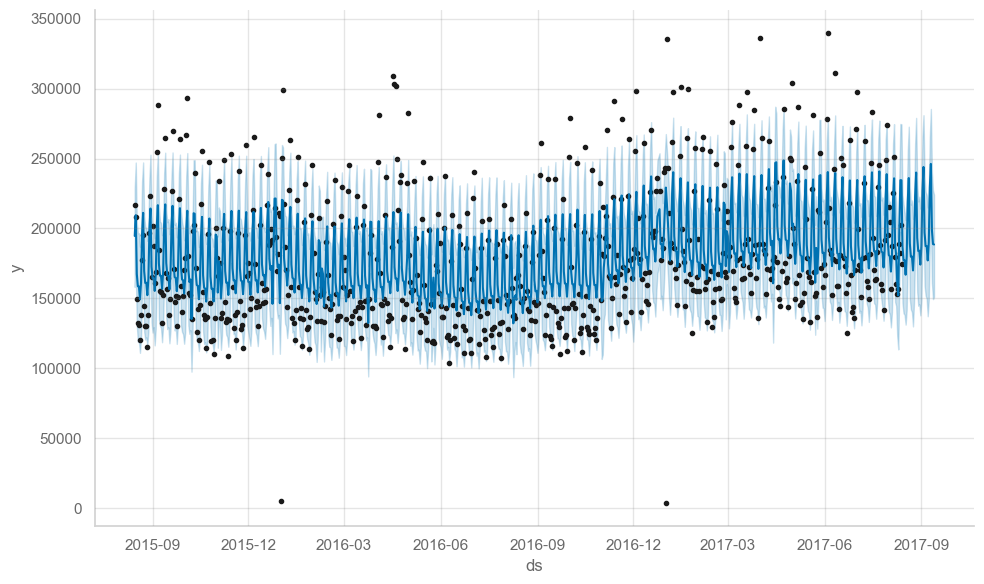

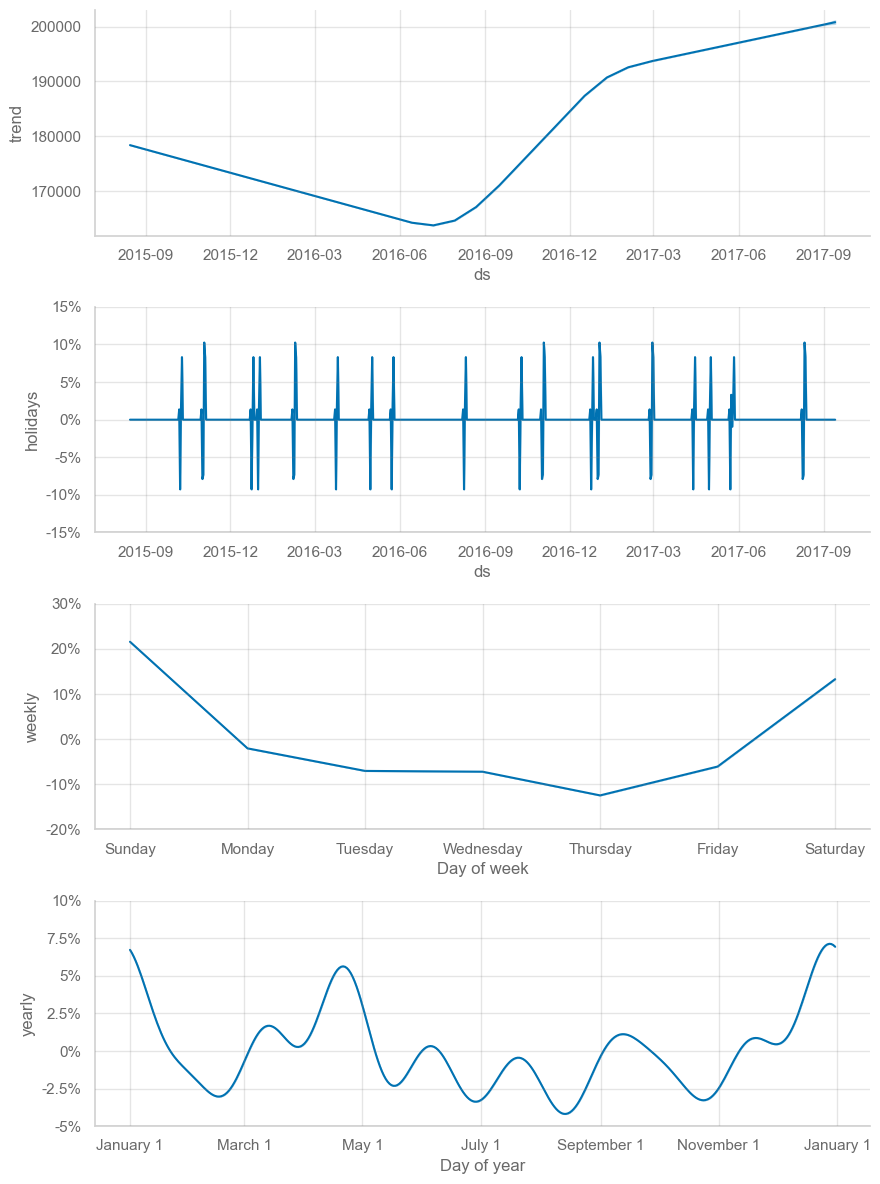

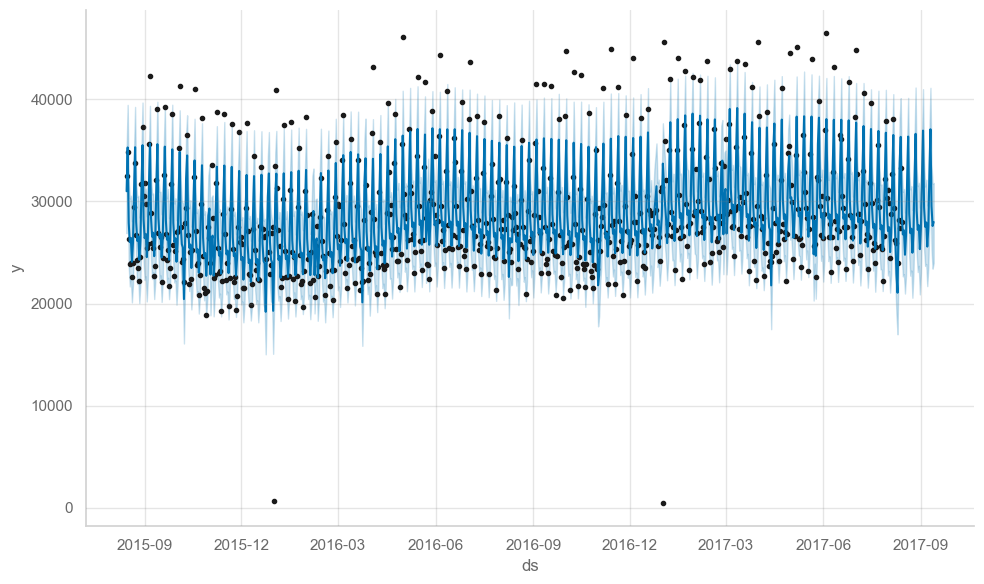

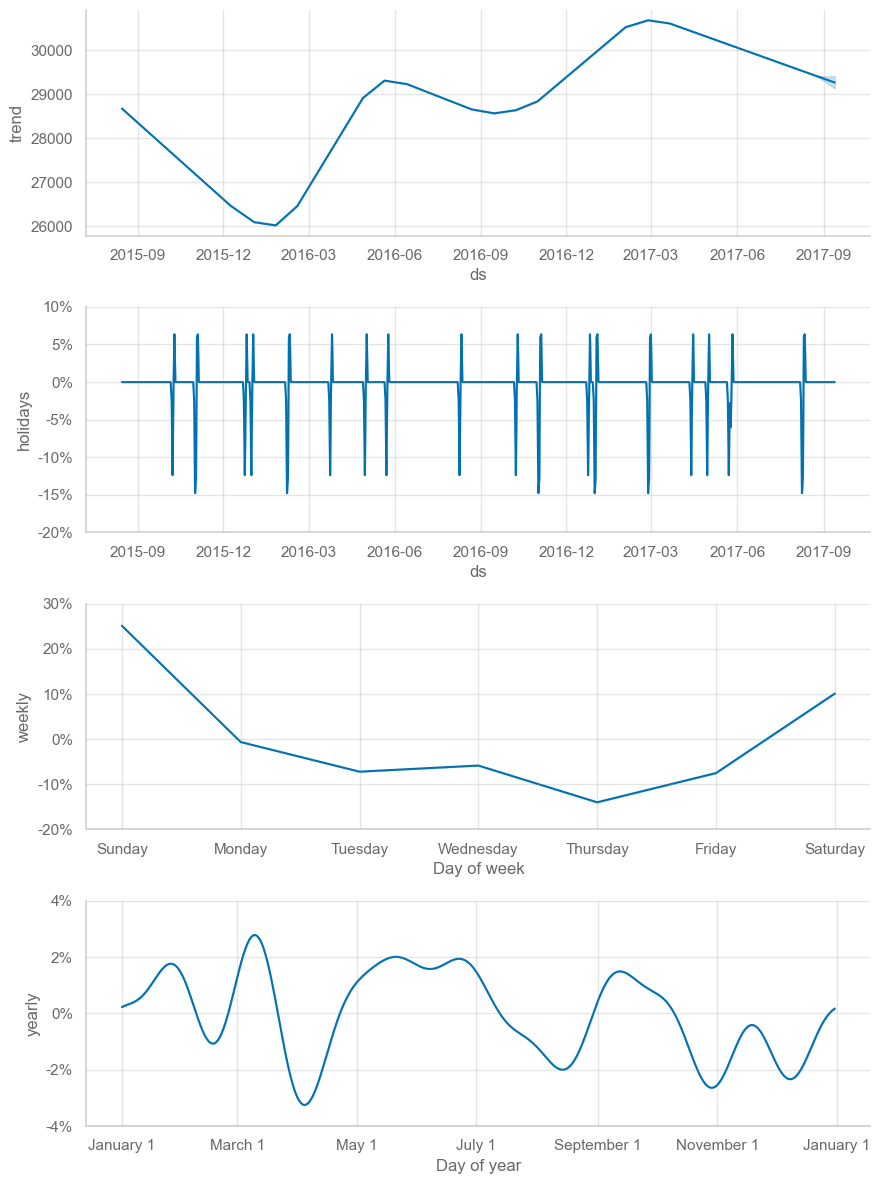

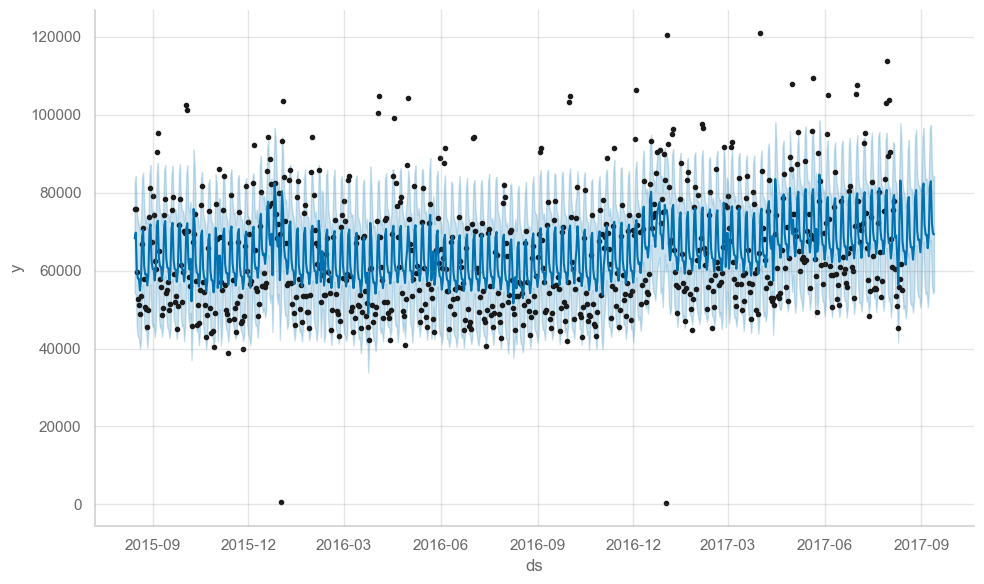

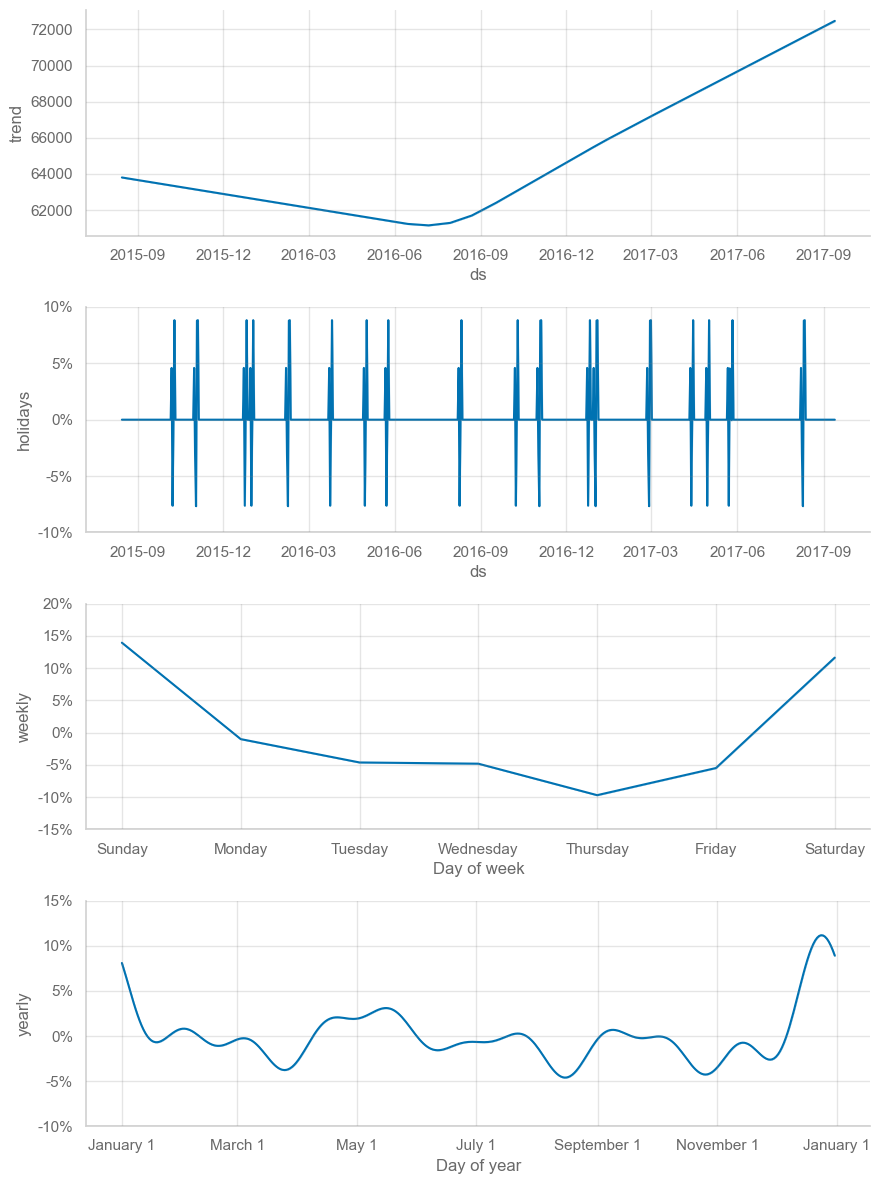

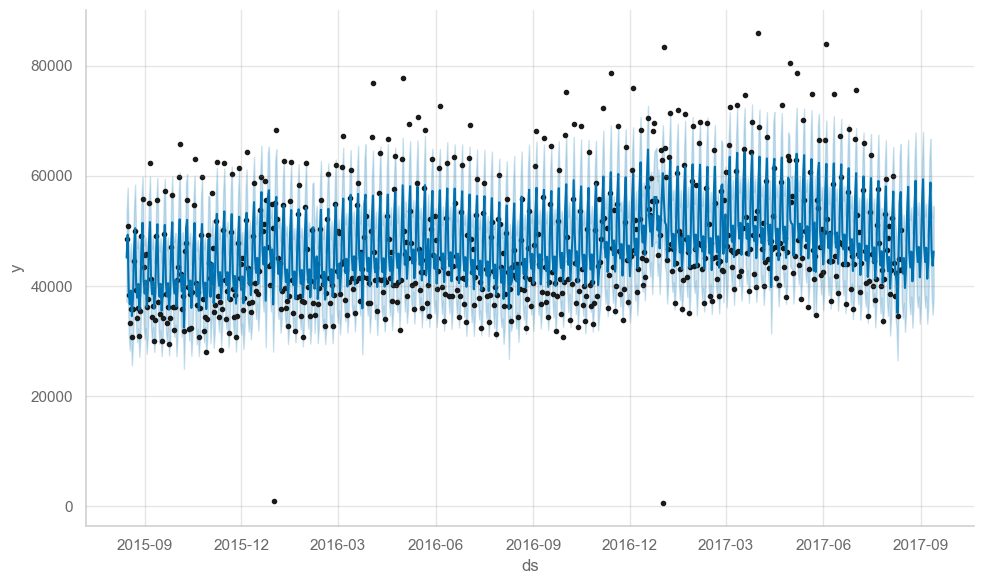

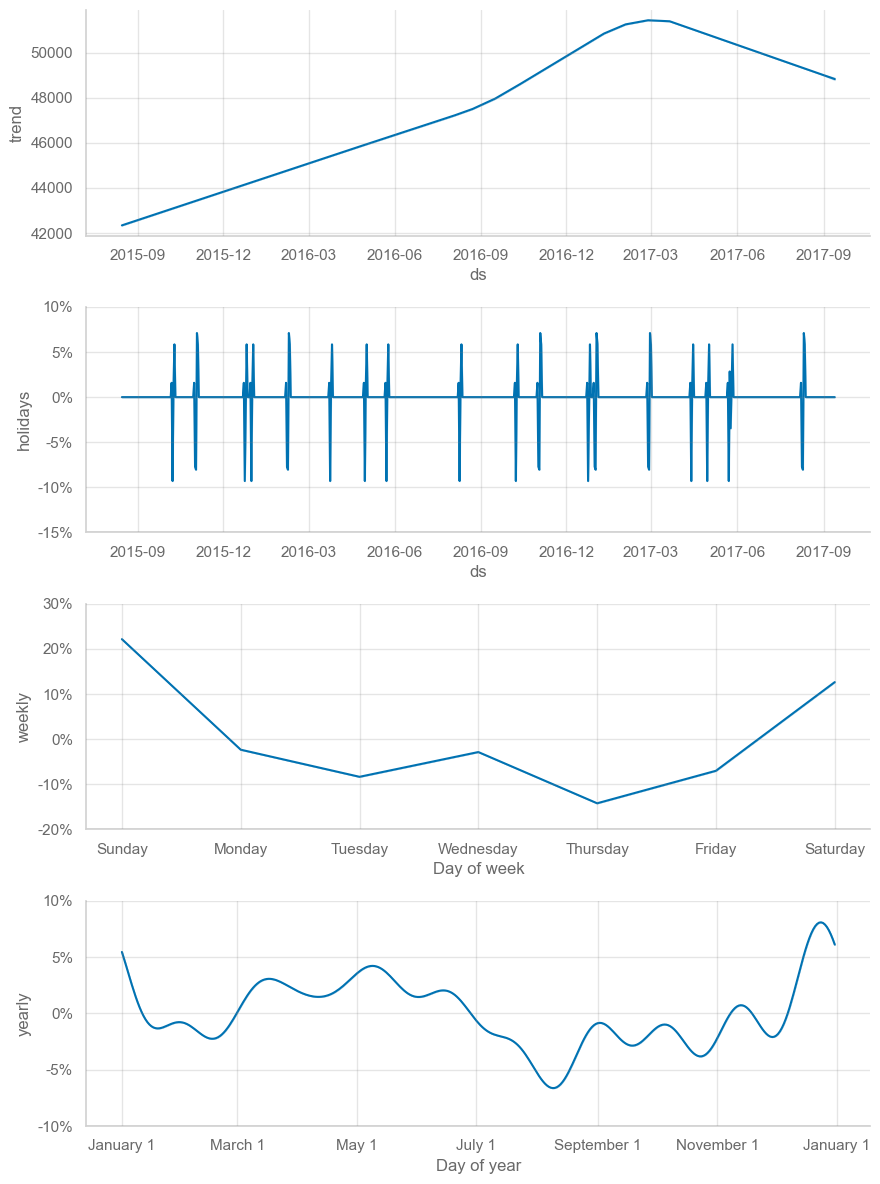

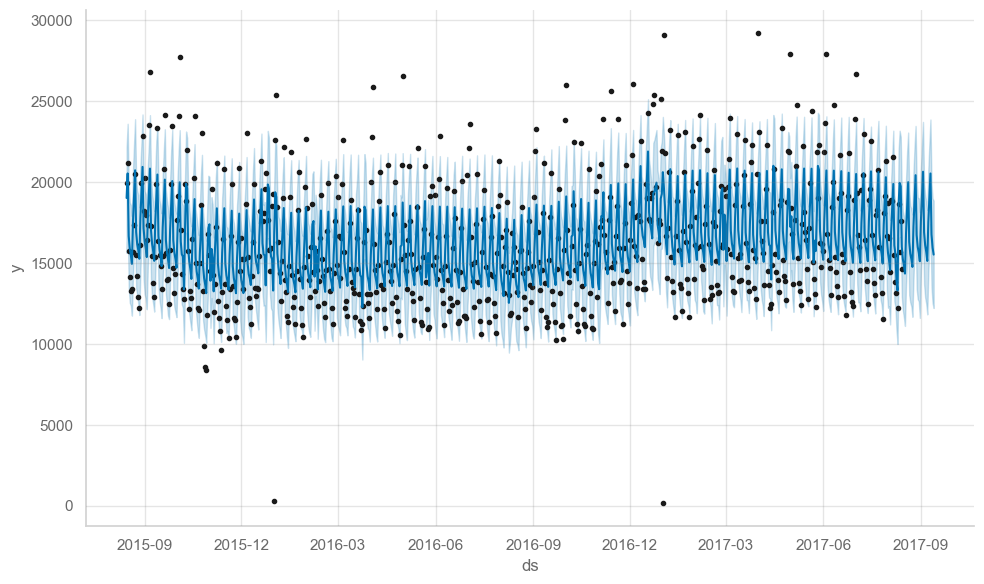

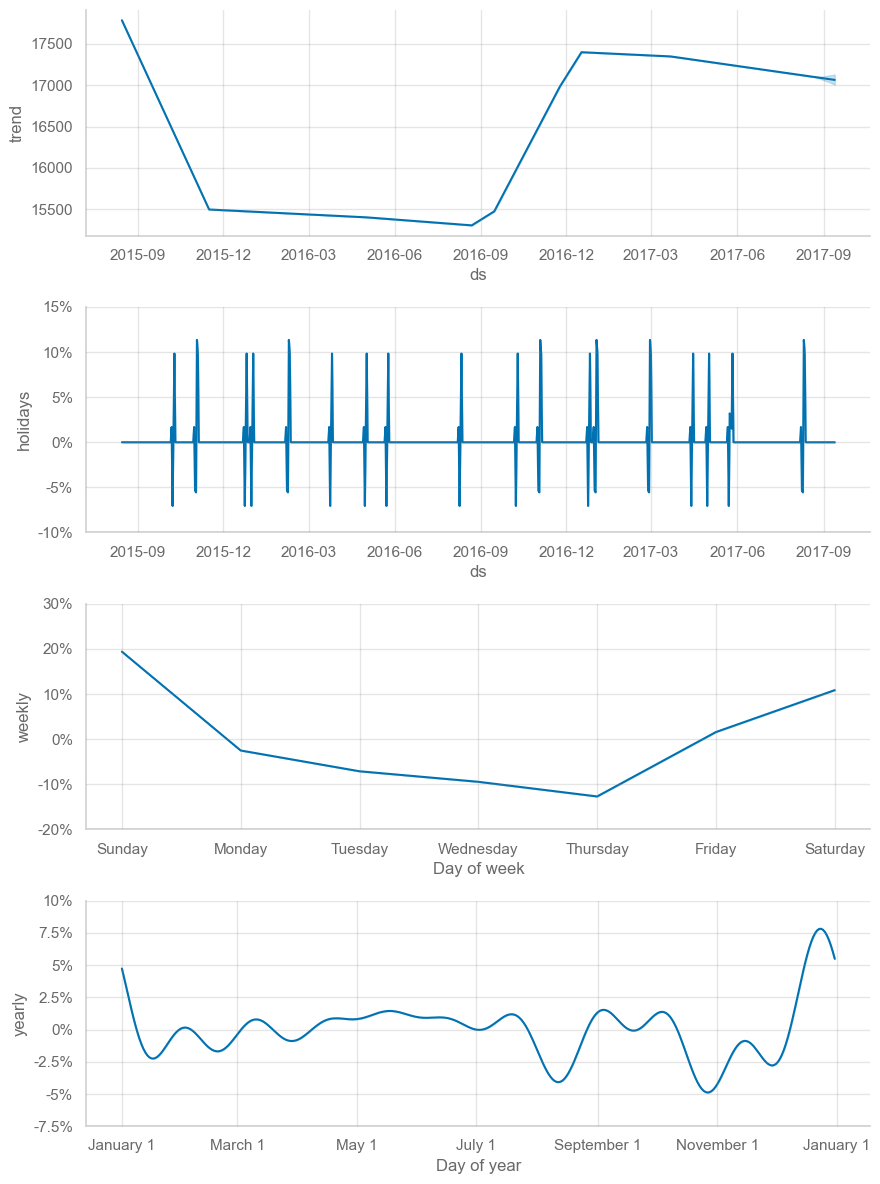

In [30]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)

In [31]:
total_sales_df.columns

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')